In [103]:
import os
import time
import copy
import itertools
import pandas as pd 
from tqdm import tqdm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

import matplotlib.pyplot as plt
from PIL import Image
import torch
# import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms
from torchsummary import summary

In [104]:
data_path = "../data"
classes = os.listdir(data_path)
data = []
for label in classes:
    folder_path = os.path.join(data_path, label)
    for file in os.listdir(folder_path):
        if file.endswith(('jpg','png','bmp')):  
            file_path = os.path.join(folder_path, file)
            data.append((file_path, label))
    
df = pd.DataFrame(data, columns=['file_path', 'label'])

In [105]:
label_mapping = {'Normal_Sperm': 0, 'Abnormal_Sperm': 1, 'Non-Sperm': 2}
df['label'] = df['label'].map(label_mapping)

In [106]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify = df['label'])
test_df, valid_df = train_test_split(temp_df, test_size=0.3, random_state=42, stratify = temp_df['label'])

print("Training set shapes:", train_df.shape)
print("Testing set shapes:", test_df.shape)
print("Validation set shapes:", valid_df.shape)

Training set shapes: (2100, 2)
Testing set shapes: (630, 2)
Validation set shapes: (270, 2)


In [146]:
test_df.to_csv("test_dataset.csv", index=False)

In [107]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None, c_type="RGB"):
        self.df = df
        self.transform = transform
        self.c_type = c_type
        self.classes = df["label"].unique

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, id):
        img_path = self.df.iloc[id]["file_path"]
        label = self.df.iloc[id]["label"]
        if self.c_type.upper() == "RGB":
            image = Image.open(img_path).convert('RGB')
        else:
            image = Image.open(img_path).convert(self.c_type)
            
        if self.transform:
            image = self.transform(image)

        return image, label

In [108]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.Normalize((0.5), (0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter()
])

In [109]:
train_dataset = CustomDataset(train_df, transform=transform, c_type="L")
valid_dataset = CustomDataset(valid_df, transform=transform, c_type="L")
test_dataset = CustomDataset(test_df, transform=transform, c_type="L")

In [110]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

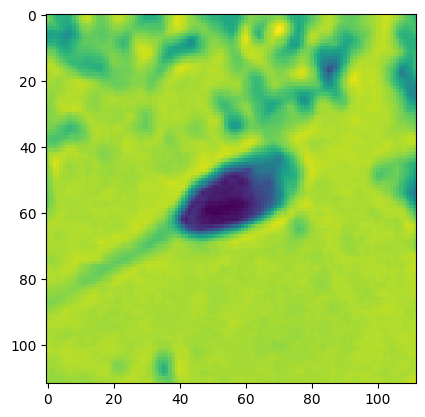

In [111]:
images, labels = next(iter(train_loader))
plt.imshow(images[0].permute(1, 2, 0))

In [133]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, num_classes) 
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # 112x112x16 -> 56x56x16
        x = self.pool(self.relu(self.conv2(x)))  # 56x56x32 -> 28x28x32
        x = self.pool(self.relu(self.conv3(x)))  # 28x28x64 -> 14x14x64
        x = x.view(-1, 64 * 14 * 14)  # Flatten: [batch_size, 64*14*14]
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [134]:
param_grid = {
    'learning_rate': [1e-3, 3e-4],
    'weight_decay': [0, 1e-4],
    'optimizer': ['Adam', 'SGD'],
    'dropout_fc_rate': [0.4, 0.5]
}

param_combinations = list(itertools.product(*param_grid.values()))


Training grid_trial_0 with params: {'learning_rate': 0.001, 'weight_decay': 0, 'optimizer': 'Adam', 'dropout_fc_rate': 0.4}


Epoch 1/50: 100%|██████████| 66/66 [00:17<00:00,  3.76it/s, loss=1.016, acc=47.67%]


Epoch 1, Train Loss: 1.016, Train Acc: 47.67%, Train F1: 0.482, Train Precision: 0.502, Train Recall: 0.477


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.51it/s, loss=0.816, acc=62.96%]


Epoch 1, Valid Loss: 0.816, Valid Acc: 62.96%, Valid F1: 0.574, Valid Precision: 0.677, Valid Recall: 0.629
Validation Confusion Matrix:
 [[87  1  4]
 [66 13 11]
 [13  5 70]]
Best model saved: Valid Accuracy = 62.96%
Current learning rate: 0.000999


Epoch 2/50: 100%|██████████| 66/66 [00:14<00:00,  4.65it/s, loss=0.816, acc=64.67%]


Epoch 2, Train Loss: 0.816, Train Acc: 64.67%, Train F1: 0.651, Train Precision: 0.658, Train Recall: 0.647


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.674, acc=72.59%]


Epoch 2, Valid Loss: 0.674, Valid Acc: 72.59%, Valid F1: 0.712, Valid Precision: 0.753, Valid Recall: 0.725
Validation Confusion Matrix:
 [[86  5  1]
 [46 37  7]
 [ 7  8 73]]
Best model saved: Valid Accuracy = 72.59%
Current learning rate: 0.000996


Epoch 3/50: 100%|██████████| 66/66 [00:15<00:00,  4.25it/s, loss=0.705, acc=70.48%]


Epoch 3, Train Loss: 0.705, Train Acc: 70.48%, Train F1: 0.706, Train Precision: 0.719, Train Recall: 0.705


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.46it/s, loss=0.608, acc=74.07%]


Epoch 3, Valid Loss: 0.608, Valid Acc: 74.07%, Valid F1: 0.741, Valid Precision: 0.759, Valid Recall: 0.740
Validation Confusion Matrix:
 [[80 12  0]
 [35 51  4]
 [ 6 13 69]]
Best model saved: Valid Accuracy = 74.07%
Current learning rate: 0.000991


Epoch 4/50: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s, loss=0.658, acc=73.19%]


Epoch 4, Train Loss: 0.658, Train Acc: 73.19%, Train F1: 0.735, Train Precision: 0.745, Train Recall: 0.732


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.16it/s, loss=0.550, acc=77.78%]


Epoch 4, Valid Loss: 0.550, Valid Acc: 77.78%, Valid F1: 0.781, Valid Precision: 0.788, Valid Recall: 0.778
Validation Confusion Matrix:
 [[73 18  1]
 [21 65  4]
 [ 4 12 72]]
Best model saved: Valid Accuracy = 77.78%
Current learning rate: 0.000984


Epoch 5/50: 100%|██████████| 66/66 [00:15<00:00,  4.32it/s, loss=0.635, acc=74.48%]


Epoch 5, Train Loss: 0.635, Train Acc: 74.48%, Train F1: 0.748, Train Precision: 0.756, Train Recall: 0.745


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.84it/s, loss=0.516, acc=83.70%]


Epoch 5, Valid Loss: 0.516, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.842, Valid Recall: 0.838
Validation Confusion Matrix:
 [[74 16  2]
 [10 75  5]
 [ 2  9 77]]
Best model saved: Valid Accuracy = 83.70%
Current learning rate: 0.000976


Epoch 6/50: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s, loss=0.596, acc=76.57%]


Epoch 6, Train Loss: 0.596, Train Acc: 76.57%, Train F1: 0.769, Train Precision: 0.775, Train Recall: 0.766


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.67it/s, loss=0.492, acc=82.59%]


Epoch 6, Valid Loss: 0.492, Valid Acc: 82.59%, Valid F1: 0.828, Valid Precision: 0.832, Valid Recall: 0.826
Validation Confusion Matrix:
 [[77 13  2]
 [18 69  3]
 [ 6  5 77]]
Early stop counter: 1/5
Current learning rate: 0.000965


Epoch 7/50: 100%|██████████| 66/66 [00:14<00:00,  4.54it/s, loss=0.562, acc=77.71%]


Epoch 7, Train Loss: 0.562, Train Acc: 77.71%, Train F1: 0.780, Train Precision: 0.786, Train Recall: 0.777


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.88it/s, loss=0.474, acc=84.07%]


Epoch 7, Valid Loss: 0.474, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.849, Valid Recall: 0.842
Validation Confusion Matrix:
 [[71 19  2]
 [ 9 79  2]
 [ 5  6 77]]
Best model saved: Valid Accuracy = 84.07%
Current learning rate: 0.000952


Epoch 8/50: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.562, acc=78.38%]


Epoch 8, Train Loss: 0.562, Train Acc: 78.38%, Train F1: 0.786, Train Precision: 0.791, Train Recall: 0.784


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.94it/s, loss=0.453, acc=82.59%]


Epoch 8, Valid Loss: 0.453, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.838, Valid Recall: 0.826
Validation Confusion Matrix:
 [[76 16  0]
 [13 75  2]
 [ 8  8 72]]
Early stop counter: 1/5
Current learning rate: 0.000938


Epoch 9/50: 100%|██████████| 66/66 [00:13<00:00,  4.72it/s, loss=0.541, acc=79.38%]


Epoch 9, Train Loss: 0.541, Train Acc: 79.38%, Train F1: 0.796, Train Precision: 0.800, Train Recall: 0.794


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.74it/s, loss=0.460, acc=84.07%]


Epoch 9, Valid Loss: 0.460, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.846, Valid Recall: 0.841
Validation Confusion Matrix:
 [[75 15  2]
 [13 75  2]
 [ 5  6 77]]
Early stop counter: 2/5
Current learning rate: 0.000922


Epoch 10/50: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.522, acc=80.00%]


Epoch 10, Train Loss: 0.522, Train Acc: 80.00%, Train F1: 0.802, Train Precision: 0.807, Train Recall: 0.800


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.86it/s, loss=0.463, acc=80.74%]


Epoch 10, Valid Loss: 0.463, Valid Acc: 80.74%, Valid F1: 0.811, Valid Precision: 0.827, Valid Recall: 0.807
Validation Confusion Matrix:
 [[71 20  1]
 [10 78  2]
 [ 5 14 69]]
Early stop counter: 3/5
Current learning rate: 0.000905


Epoch 11/50: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.500, acc=82.00%]


Epoch 11, Train Loss: 0.500, Train Acc: 82.00%, Train F1: 0.822, Train Precision: 0.825, Train Recall: 0.820


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.95it/s, loss=0.431, acc=83.70%]


Epoch 11, Valid Loss: 0.431, Valid Acc: 83.70%, Valid F1: 0.838, Valid Precision: 0.838, Valid Recall: 0.838
Validation Confusion Matrix:
 [[74 15  3]
 [15 71  4]
 [ 3  4 81]]
Early stop counter: 4/5
Current learning rate: 0.000885


Epoch 12/50: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.501, acc=80.86%]


Epoch 12, Train Loss: 0.501, Train Acc: 80.86%, Train F1: 0.810, Train Precision: 0.813, Train Recall: 0.809


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.47it/s, loss=0.433, acc=85.19%]


Epoch 12, Valid Loss: 0.433, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.863, Valid Recall: 0.852
Validation Confusion Matrix:
 [[73 19  0]
 [ 8 80  2]
 [ 4  7 77]]
Best model saved: Valid Accuracy = 85.19%
Current learning rate: 0.000864


Epoch 13/50: 100%|██████████| 66/66 [00:15<00:00,  4.21it/s, loss=0.486, acc=81.57%]


Epoch 13, Train Loss: 0.486, Train Acc: 81.57%, Train F1: 0.817, Train Precision: 0.819, Train Recall: 0.816


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.15it/s, loss=0.434, acc=84.07%]


Epoch 13, Valid Loss: 0.434, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.849, Valid Recall: 0.841
Validation Confusion Matrix:
 [[72 19  1]
 [ 9 78  3]
 [ 4  7 77]]
Early stop counter: 1/5
Current learning rate: 0.000842


Epoch 14/50: 100%|██████████| 66/66 [00:15<00:00,  4.34it/s, loss=0.469, acc=81.19%]


Epoch 14, Train Loss: 0.469, Train Acc: 81.19%, Train F1: 0.813, Train Precision: 0.815, Train Recall: 0.812


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.04it/s, loss=0.425, acc=82.96%]


Epoch 14, Valid Loss: 0.425, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.842, Valid Recall: 0.830
Validation Confusion Matrix:
 [[73 19  0]
 [12 76  2]
 [ 4  9 75]]
Early stop counter: 2/5
Current learning rate: 0.000819


Epoch 15/50: 100%|██████████| 66/66 [00:15<00:00,  4.31it/s, loss=0.457, acc=82.57%]


Epoch 15, Train Loss: 0.457, Train Acc: 82.57%, Train F1: 0.827, Train Precision: 0.828, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.03it/s, loss=0.423, acc=83.33%]


Epoch 15, Valid Loss: 0.423, Valid Acc: 83.33%, Valid F1: 0.835, Valid Precision: 0.839, Valid Recall: 0.834
Validation Confusion Matrix:
 [[70 19  3]
 [11 76  3]
 [ 2  7 79]]
Early stop counter: 3/5
Current learning rate: 0.000794


Epoch 16/50: 100%|██████████| 66/66 [00:15<00:00,  4.19it/s, loss=0.455, acc=82.81%]


Epoch 16, Train Loss: 0.455, Train Acc: 82.81%, Train F1: 0.829, Train Precision: 0.832, Train Recall: 0.828


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.37it/s, loss=0.457, acc=82.59%]


Epoch 16, Valid Loss: 0.457, Valid Acc: 82.59%, Valid F1: 0.828, Valid Precision: 0.844, Valid Recall: 0.825
Validation Confusion Matrix:
 [[84  8  0]
 [20 68  2]
 [11  6 71]]
Early stop counter: 4/5
Current learning rate: 0.000768


Epoch 17/50: 100%|██████████| 66/66 [00:15<00:00,  4.20it/s, loss=0.453, acc=82.48%]


Epoch 17, Train Loss: 0.453, Train Acc: 82.48%, Train F1: 0.826, Train Precision: 0.827, Train Recall: 0.825


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.01it/s, loss=0.425, acc=84.07%]


Epoch 17, Valid Loss: 0.425, Valid Acc: 84.07%, Valid F1: 0.842, Valid Precision: 0.845, Valid Recall: 0.841
Validation Confusion Matrix:
 [[78 13  1]
 [13 73  4]
 [ 4  8 76]]
Early stop counter: 5/5
Current learning rate: 0.000741
Early stop triggered! No recovery during 5 epoch.
Training finished after: 277.76 seconds

Training grid_trial_1 with params: {'learning_rate': 0.001, 'weight_decay': 0, 'optimizer': 'Adam', 'dropout_fc_rate': 0.5}


Epoch 1/50: 100%|██████████| 66/66 [00:16<00:00,  4.02it/s, loss=1.059, acc=41.86%]


Epoch 1, Train Loss: 1.059, Train Acc: 41.86%, Train F1: 0.419, Train Precision: 0.419, Train Recall: 0.420


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.85it/s, loss=0.894, acc=58.89%]


Epoch 1, Valid Loss: 0.894, Valid Acc: 58.89%, Valid F1: 0.570, Valid Precision: 0.618, Valid Recall: 0.592
Validation Confusion Matrix:
 [[26 51 15]
 [ 9 67 14]
 [ 4 18 66]]
Best model saved: Valid Accuracy = 58.89%
Current learning rate: 0.000999


Epoch 2/50: 100%|██████████| 66/66 [00:15<00:00,  4.16it/s, loss=0.899, acc=59.29%]


Epoch 2, Train Loss: 0.899, Train Acc: 59.29%, Train F1: 0.596, Train Precision: 0.601, Train Recall: 0.595


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.38it/s, loss=0.778, acc=68.89%]


Epoch 2, Valid Loss: 0.778, Valid Acc: 68.89%, Valid F1: 0.682, Valid Precision: 0.693, Valid Recall: 0.690
Validation Confusion Matrix:
 [[62 11 19]
 [24 47 19]
 [ 3  8 77]]
Best model saved: Valid Accuracy = 68.89%
Current learning rate: 0.000996


Epoch 3/50: 100%|██████████| 66/66 [00:20<00:00,  3.27it/s, loss=0.748, acc=69.10%]


Epoch 3, Train Loss: 0.748, Train Acc: 69.10%, Train F1: 0.695, Train Precision: 0.702, Train Recall: 0.691


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.37it/s, loss=0.663, acc=71.11%]


Epoch 3, Valid Loss: 0.663, Valid Acc: 71.11%, Valid F1: 0.705, Valid Precision: 0.739, Valid Recall: 0.710
Validation Confusion Matrix:
 [[82  8  2]
 [44 41  5]
 [10  9 69]]
Best model saved: Valid Accuracy = 71.11%
Current learning rate: 0.000991


Epoch 4/50: 100%|██████████| 66/66 [00:15<00:00,  4.40it/s, loss=0.694, acc=70.52%]


Epoch 4, Train Loss: 0.694, Train Acc: 70.52%, Train F1: 0.709, Train Precision: 0.717, Train Recall: 0.705


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s, loss=0.633, acc=73.33%]


Epoch 4, Valid Loss: 0.633, Valid Acc: 73.33%, Valid F1: 0.728, Valid Precision: 0.760, Valid Recall: 0.732
Validation Confusion Matrix:
 [[84  7  1]
 [41 44  5]
 [ 9  9 70]]
Best model saved: Valid Accuracy = 73.33%
Current learning rate: 0.000984


Epoch 5/50: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.665, acc=73.00%]


Epoch 5, Train Loss: 0.665, Train Acc: 73.00%, Train F1: 0.734, Train Precision: 0.743, Train Recall: 0.730


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.85it/s, loss=0.570, acc=75.93%]


Epoch 5, Valid Loss: 0.570, Valid Acc: 75.93%, Valid F1: 0.759, Valid Precision: 0.764, Valid Recall: 0.759
Validation Confusion Matrix:
 [[75 14  3]
 [26 57  7]
 [ 5 10 73]]
Best model saved: Valid Accuracy = 75.93%
Current learning rate: 0.000976


Epoch 6/50: 100%|██████████| 66/66 [00:13<00:00,  4.74it/s, loss=0.647, acc=73.57%]


Epoch 6, Train Loss: 0.647, Train Acc: 73.57%, Train F1: 0.739, Train Precision: 0.746, Train Recall: 0.736


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.06it/s, loss=0.569, acc=78.89%]


Epoch 6, Valid Loss: 0.569, Valid Acc: 78.89%, Valid F1: 0.792, Valid Precision: 0.800, Valid Recall: 0.789
Validation Confusion Matrix:
 [[76 15  1]
 [23 64  3]
 [ 7  8 73]]
Best model saved: Valid Accuracy = 78.89%
Current learning rate: 0.000965


Epoch 7/50: 100%|██████████| 66/66 [00:13<00:00,  4.72it/s, loss=0.619, acc=75.14%]


Epoch 7, Train Loss: 0.619, Train Acc: 75.14%, Train F1: 0.754, Train Precision: 0.762, Train Recall: 0.751


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s, loss=0.563, acc=77.78%]


Epoch 7, Valid Loss: 0.563, Valid Acc: 77.78%, Valid F1: 0.781, Valid Precision: 0.797, Valid Recall: 0.777
Validation Confusion Matrix:
 [[77 15  0]
 [21 66  3]
 [12  9 67]]
Early stop counter: 1/5
Current learning rate: 0.000952


Epoch 8/50: 100%|██████████| 66/66 [00:14<00:00,  4.67it/s, loss=0.616, acc=76.38%]


Epoch 8, Train Loss: 0.616, Train Acc: 76.38%, Train F1: 0.767, Train Precision: 0.774, Train Recall: 0.764


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.77it/s, loss=0.581, acc=77.41%]


Epoch 8, Valid Loss: 0.581, Valid Acc: 77.41%, Valid F1: 0.771, Valid Precision: 0.786, Valid Recall: 0.774
Validation Confusion Matrix:
 [[79  7  6]
 [32 53  5]
 [ 5  6 77]]
Early stop counter: 2/5
Current learning rate: 0.000938


Epoch 9/50: 100%|██████████| 66/66 [00:13<00:00,  4.72it/s, loss=0.605, acc=76.10%]


Epoch 9, Train Loss: 0.605, Train Acc: 76.10%, Train F1: 0.764, Train Precision: 0.769, Train Recall: 0.761


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.45it/s, loss=0.562, acc=78.52%]


Epoch 9, Valid Loss: 0.562, Valid Acc: 78.52%, Valid F1: 0.789, Valid Precision: 0.807, Valid Recall: 0.785
Validation Confusion Matrix:
 [[71 21  0]
 [13 75  2]
 [ 9 13 66]]
Early stop counter: 3/5
Current learning rate: 0.000922


Epoch 10/50: 100%|██████████| 66/66 [00:13<00:00,  4.74it/s, loss=0.591, acc=77.52%]


Epoch 10, Train Loss: 0.591, Train Acc: 77.52%, Train F1: 0.778, Train Precision: 0.783, Train Recall: 0.775


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.06it/s, loss=0.525, acc=79.63%]


Epoch 10, Valid Loss: 0.525, Valid Acc: 79.63%, Valid F1: 0.799, Valid Precision: 0.811, Valid Recall: 0.796
Validation Confusion Matrix:
 [[79 13  0]
 [22 65  3]
 [ 9  8 71]]
Best model saved: Valid Accuracy = 79.63%
Current learning rate: 0.000905


Epoch 11/50: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s, loss=0.570, acc=77.81%]


Epoch 11, Train Loss: 0.570, Train Acc: 77.81%, Train F1: 0.781, Train Precision: 0.785, Train Recall: 0.778


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.84it/s, loss=0.504, acc=80.00%]


Epoch 11, Valid Loss: 0.504, Valid Acc: 80.00%, Valid F1: 0.803, Valid Precision: 0.810, Valid Recall: 0.800
Validation Confusion Matrix:
 [[73 17  2]
 [15 72  3]
 [ 6 11 71]]
Best model saved: Valid Accuracy = 80.00%
Current learning rate: 0.000885


Epoch 12/50: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s, loss=0.566, acc=78.52%]


Epoch 12, Train Loss: 0.566, Train Acc: 78.52%, Train F1: 0.788, Train Precision: 0.792, Train Recall: 0.786


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.05it/s, loss=0.540, acc=78.89%]


Epoch 12, Valid Loss: 0.540, Valid Acc: 78.89%, Valid F1: 0.791, Valid Precision: 0.796, Valid Recall: 0.789
Validation Confusion Matrix:
 [[75 14  3]
 [24 63  3]
 [ 5  8 75]]
Early stop counter: 1/5
Current learning rate: 0.000864


Epoch 13/50: 100%|██████████| 66/66 [00:15<00:00,  4.33it/s, loss=0.560, acc=77.76%]


Epoch 13, Train Loss: 0.560, Train Acc: 77.76%, Train F1: 0.780, Train Precision: 0.784, Train Recall: 0.778


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.71it/s, loss=0.504, acc=78.89%]


Epoch 13, Valid Loss: 0.504, Valid Acc: 78.89%, Valid F1: 0.792, Valid Precision: 0.801, Valid Recall: 0.789
Validation Confusion Matrix:
 [[75 17  0]
 [19 67  4]
 [ 7 10 71]]
Early stop counter: 2/5
Current learning rate: 0.000842


Epoch 14/50: 100%|██████████| 66/66 [00:15<00:00,  4.17it/s, loss=0.546, acc=77.76%]


Epoch 14, Train Loss: 0.546, Train Acc: 77.76%, Train F1: 0.780, Train Precision: 0.784, Train Recall: 0.778


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.04it/s, loss=0.492, acc=81.48%]


Epoch 14, Valid Loss: 0.492, Valid Acc: 81.48%, Valid F1: 0.818, Valid Precision: 0.825, Valid Recall: 0.815
Validation Confusion Matrix:
 [[72 19  1]
 [13 74  3]
 [ 5  9 74]]
Best model saved: Valid Accuracy = 81.48%
Current learning rate: 0.000819


Epoch 15/50: 100%|██████████| 66/66 [00:15<00:00,  4.17it/s, loss=0.538, acc=78.67%]


Epoch 15, Train Loss: 0.538, Train Acc: 78.67%, Train F1: 0.789, Train Precision: 0.793, Train Recall: 0.787


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.93it/s, loss=0.505, acc=81.48%]


Epoch 15, Valid Loss: 0.505, Valid Acc: 81.48%, Valid F1: 0.818, Valid Precision: 0.825, Valid Recall: 0.815
Validation Confusion Matrix:
 [[76 16  0]
 [16 71  3]
 [ 7  8 73]]
Early stop counter: 1/5
Current learning rate: 0.000794


Epoch 16/50: 100%|██████████| 66/66 [00:15<00:00,  4.17it/s, loss=0.524, acc=78.81%]


Epoch 16, Train Loss: 0.524, Train Acc: 78.81%, Train F1: 0.790, Train Precision: 0.793, Train Recall: 0.789


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.90it/s, loss=0.488, acc=81.85%]


Epoch 16, Valid Loss: 0.488, Valid Acc: 81.85%, Valid F1: 0.821, Valid Precision: 0.830, Valid Recall: 0.818
Validation Confusion Matrix:
 [[76 15  1]
 [14 74  2]
 [ 9  8 71]]
Best model saved: Valid Accuracy = 81.85%
Current learning rate: 0.000768


Epoch 17/50: 100%|██████████| 66/66 [00:16<00:00,  4.07it/s, loss=0.521, acc=79.05%]


Epoch 17, Train Loss: 0.521, Train Acc: 79.05%, Train F1: 0.792, Train Precision: 0.796, Train Recall: 0.791


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.44it/s, loss=0.496, acc=80.00%]


Epoch 17, Valid Loss: 0.496, Valid Acc: 80.00%, Valid F1: 0.803, Valid Precision: 0.816, Valid Recall: 0.800
Validation Confusion Matrix:
 [[74 17  1]
 [13 75  2]
 [12  9 67]]
Early stop counter: 1/5
Current learning rate: 0.000741


Epoch 18/50: 100%|██████████| 66/66 [00:15<00:00,  4.13it/s, loss=0.519, acc=79.95%]


Epoch 18, Train Loss: 0.519, Train Acc: 79.95%, Train F1: 0.802, Train Precision: 0.805, Train Recall: 0.800


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s, loss=0.466, acc=82.59%]


Epoch 18, Valid Loss: 0.466, Valid Acc: 82.59%, Valid F1: 0.828, Valid Precision: 0.831, Valid Recall: 0.826
Validation Confusion Matrix:
 [[75 16  1]
 [17 70  3]
 [ 5  5 78]]
Best model saved: Valid Accuracy = 82.59%
Current learning rate: 0.000713


Epoch 19/50: 100%|██████████| 66/66 [00:18<00:00,  3.59it/s, loss=0.518, acc=80.10%]


Epoch 19, Train Loss: 0.518, Train Acc: 80.10%, Train F1: 0.803, Train Precision: 0.806, Train Recall: 0.801


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s, loss=0.510, acc=78.89%]


Epoch 19, Valid Loss: 0.510, Valid Acc: 78.89%, Valid F1: 0.791, Valid Precision: 0.804, Valid Recall: 0.789
Validation Confusion Matrix:
 [[79 12  1]
 [27 60  3]
 [ 8  6 74]]
Early stop counter: 1/5
Current learning rate: 0.000684


Epoch 20/50: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, loss=0.499, acc=80.52%]


Epoch 20, Train Loss: 0.499, Train Acc: 80.52%, Train F1: 0.807, Train Precision: 0.809, Train Recall: 0.806


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.63it/s, loss=0.473, acc=82.59%]


Epoch 20, Valid Loss: 0.473, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.838, Valid Recall: 0.826
Validation Confusion Matrix:
 [[74 18  0]
 [13 75  2]
 [ 5  9 74]]
Early stop counter: 2/5
Current learning rate: 0.000655


Epoch 21/50: 100%|██████████| 66/66 [00:16<00:00,  4.10it/s, loss=0.512, acc=80.24%]


Epoch 21, Train Loss: 0.512, Train Acc: 80.24%, Train F1: 0.804, Train Precision: 0.808, Train Recall: 0.803


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.63it/s, loss=0.456, acc=84.44%]


Epoch 21, Valid Loss: 0.456, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.851, Valid Recall: 0.845
Validation Confusion Matrix:
 [[71 21  0]
 [10 77  3]
 [ 4  4 80]]
Best model saved: Valid Accuracy = 84.44%
Current learning rate: 0.000624


Epoch 22/50: 100%|██████████| 66/66 [00:15<00:00,  4.30it/s, loss=0.495, acc=80.33%]


Epoch 22, Train Loss: 0.495, Train Acc: 80.33%, Train F1: 0.805, Train Precision: 0.807, Train Recall: 0.804


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.55it/s, loss=0.474, acc=84.07%]


Epoch 22, Valid Loss: 0.474, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.849, Valid Recall: 0.841
Validation Confusion Matrix:
 [[76 16  0]
 [12 75  3]
 [ 3  9 76]]
Early stop counter: 1/5
Current learning rate: 0.000594


Epoch 23/50: 100%|██████████| 66/66 [00:15<00:00,  4.25it/s, loss=0.507, acc=80.19%]


Epoch 23, Train Loss: 0.507, Train Acc: 80.19%, Train F1: 0.804, Train Precision: 0.806, Train Recall: 0.802


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.86it/s, loss=0.450, acc=81.11%]


Epoch 23, Valid Loss: 0.450, Valid Acc: 81.11%, Valid F1: 0.815, Valid Precision: 0.825, Valid Recall: 0.811
Validation Confusion Matrix:
 [[72 20  0]
 [12 75  3]
 [ 6 10 72]]
Early stop counter: 2/5
Current learning rate: 0.000563


Epoch 24/50: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.481, acc=81.43%]


Epoch 24, Train Loss: 0.481, Train Acc: 81.43%, Train F1: 0.816, Train Precision: 0.817, Train Recall: 0.815


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.84it/s, loss=0.444, acc=81.11%]


Epoch 24, Valid Loss: 0.444, Valid Acc: 81.11%, Valid F1: 0.814, Valid Precision: 0.823, Valid Recall: 0.811
Validation Confusion Matrix:
 [[75 17  0]
 [15 72  3]
 [ 6 10 72]]
Early stop counter: 3/5
Current learning rate: 0.000531


Epoch 25/50: 100%|██████████| 66/66 [00:13<00:00,  4.98it/s, loss=0.485, acc=81.10%]


Epoch 25, Train Loss: 0.485, Train Acc: 81.10%, Train F1: 0.813, Train Precision: 0.816, Train Recall: 0.811


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.72it/s, loss=0.472, acc=82.96%]


Epoch 25, Valid Loss: 0.472, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.842, Valid Recall: 0.830
Validation Confusion Matrix:
 [[74 18  0]
 [ 9 78  3]
 [ 7  9 72]]
Early stop counter: 4/5
Current learning rate: 0.000500


Epoch 26/50: 100%|██████████| 66/66 [00:15<00:00,  4.24it/s, loss=0.496, acc=81.38%]


Epoch 26, Train Loss: 0.496, Train Acc: 81.38%, Train F1: 0.815, Train Precision: 0.818, Train Recall: 0.814


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.77it/s, loss=0.444, acc=82.22%]


Epoch 26, Valid Loss: 0.444, Valid Acc: 82.22%, Valid F1: 0.825, Valid Precision: 0.832, Valid Recall: 0.823
Validation Confusion Matrix:
 [[72 20  0]
 [12 75  3]
 [ 6  7 75]]
Early stop counter: 5/5
Current learning rate: 0.000469
Early stop triggered! No recovery during 5 epoch.
Training finished after: 437.65 seconds

Training grid_trial_2 with params: {'learning_rate': 0.001, 'weight_decay': 0, 'optimizer': 'SGD', 'dropout_fc_rate': 0.4}


Epoch 1/50: 100%|██████████| 66/66 [00:16<00:00,  4.05it/s, loss=1.099, acc=34.10%]


Epoch 1, Train Loss: 1.099, Train Acc: 34.10%, Train F1: 0.250, Train Precision: 0.343, Train Recall: 0.336


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.43it/s, loss=1.096, acc=34.07%]


Epoch 1, Valid Loss: 1.096, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Best model saved: Valid Accuracy = 34.07%
Current learning rate: 0.000999


Epoch 2/50: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=1.097, acc=33.67%]


Epoch 2, Train Loss: 1.097, Train Acc: 33.67%, Train F1: 0.268, Train Precision: 0.225, Train Recall: 0.332


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s, loss=1.094, acc=34.07%]


Epoch 2, Valid Loss: 1.094, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Early stop counter: 1/5
Current learning rate: 0.000996


Epoch 3/50: 100%|██████████| 66/66 [00:17<00:00,  3.88it/s, loss=1.094, acc=37.33%]


Epoch 3, Train Loss: 1.094, Train Acc: 37.33%, Train F1: 0.311, Train Precision: 0.434, Train Recall: 0.368


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.10it/s, loss=1.092, acc=41.48%]


Epoch 3, Valid Loss: 1.092, Valid Acc: 41.48%, Valid F1: 0.318, Valid Precision: 0.623, Valid Recall: 0.408
Validation Confusion Matrix:
 [[87  5  0]
 [69 21  0]
 [66 18  4]]
Best model saved: Valid Accuracy = 41.48%
Current learning rate: 0.000991


Epoch 4/50: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=1.090, acc=39.33%]


Epoch 4, Train Loss: 1.090, Train Acc: 39.33%, Train F1: 0.378, Train Precision: 0.451, Train Recall: 0.390


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s, loss=1.087, acc=44.81%]


Epoch 4, Valid Loss: 1.087, Valid Acc: 44.81%, Valid F1: 0.390, Valid Precision: 0.652, Valid Recall: 0.443
Validation Confusion Matrix:
 [[85  7  0]
 [69 21  0]
 [64  9 15]]
Best model saved: Valid Accuracy = 44.81%
Current learning rate: 0.000984


Epoch 5/50: 100%|██████████| 66/66 [00:15<00:00,  4.22it/s, loss=1.086, acc=41.33%]


Epoch 5, Train Loss: 1.086, Train Acc: 41.33%, Train F1: 0.391, Train Precision: 0.484, Train Recall: 0.410


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.73it/s, loss=1.079, acc=41.11%]


Epoch 5, Valid Loss: 1.079, Valid Acc: 41.11%, Valid F1: 0.299, Valid Precision: 0.606, Valid Recall: 0.405
Validation Confusion Matrix:
 [[92  0  0]
 [88  1  1]
 [69  1 18]]
Early stop counter: 1/5
Current learning rate: 0.000976


Epoch 6/50: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s, loss=1.075, acc=47.57%]


Epoch 6, Train Loss: 1.075, Train Acc: 47.57%, Train F1: 0.481, Train Precision: 0.518, Train Recall: 0.475


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.16it/s, loss=1.062, acc=53.33%]


Epoch 6, Valid Loss: 1.062, Valid Acc: 53.33%, Valid F1: 0.479, Valid Precision: 0.689, Valid Recall: 0.530
Validation Confusion Matrix:
 [[90  1  1]
 [72 11  7]
 [43  2 43]]
Best model saved: Valid Accuracy = 53.33%
Current learning rate: 0.000965


Epoch 7/50: 100%|██████████| 66/66 [00:15<00:00,  4.29it/s, loss=1.053, acc=50.48%]


Epoch 7, Train Loss: 1.053, Train Acc: 50.48%, Train F1: 0.493, Train Precision: 0.535, Train Recall: 0.504


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.44it/s, loss=1.030, acc=65.56%]


Epoch 7, Valid Loss: 1.030, Valid Acc: 65.56%, Valid F1: 0.651, Valid Precision: 0.655, Valid Recall: 0.656
Validation Confusion Matrix:
 [[64 13 15]
 [25 46 19]
 [ 9 12 67]]
Best model saved: Valid Accuracy = 65.56%
Current learning rate: 0.000952


Epoch 8/50: 100%|██████████| 66/66 [00:15<00:00,  4.26it/s, loss=1.006, acc=53.71%]


Epoch 8, Train Loss: 1.006, Train Acc: 53.71%, Train F1: 0.537, Train Precision: 0.544, Train Recall: 0.538


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.78it/s, loss=0.954, acc=54.81%]


Epoch 8, Valid Loss: 0.954, Valid Acc: 54.81%, Valid F1: 0.521, Valid Precision: 0.696, Valid Recall: 0.551
Validation Confusion Matrix:
 [[17 75  0]
 [ 3 83  4]
 [ 3 37 48]]
Early stop counter: 1/5
Current learning rate: 0.000938


Epoch 9/50: 100%|██████████| 66/66 [00:15<00:00,  4.28it/s, loss=0.934, acc=56.81%]


Epoch 9, Train Loss: 0.934, Train Acc: 56.81%, Train F1: 0.573, Train Precision: 0.576, Train Recall: 0.570


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.24it/s, loss=0.869, acc=61.48%]


Epoch 9, Valid Loss: 0.869, Valid Acc: 61.48%, Valid F1: 0.594, Valid Precision: 0.676, Valid Recall: 0.619
Validation Confusion Matrix:
 [[22 67  3]
 [ 7 77  6]
 [ 4 17 67]]
Early stop counter: 2/5
Current learning rate: 0.000922


Epoch 10/50: 100%|██████████| 66/66 [00:15<00:00,  4.16it/s, loss=0.882, acc=58.67%]


Epoch 10, Train Loss: 0.882, Train Acc: 58.67%, Train F1: 0.591, Train Precision: 0.593, Train Recall: 0.589


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s, loss=0.827, acc=65.93%]


Epoch 10, Valid Loss: 0.827, Valid Acc: 65.93%, Valid F1: 0.657, Valid Precision: 0.661, Valid Recall: 0.662
Validation Confusion Matrix:
 [[49 34  9]
 [19 55 16]
 [ 4 10 74]]
Best model saved: Valid Accuracy = 65.93%
Current learning rate: 0.000905


Epoch 11/50: 100%|██████████| 66/66 [00:15<00:00,  4.16it/s, loss=0.872, acc=59.24%]


Epoch 11, Train Loss: 0.872, Train Acc: 59.24%, Train F1: 0.596, Train Precision: 0.598, Train Recall: 0.594


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.66it/s, loss=0.829, acc=67.41%]


Epoch 11, Valid Loss: 0.829, Valid Acc: 67.41%, Valid F1: 0.667, Valid Precision: 0.707, Valid Recall: 0.673
Validation Confusion Matrix:
 [[83  9  0]
 [48 37  5]
 [12 14 62]]
Best model saved: Valid Accuracy = 67.41%
Current learning rate: 0.000885


Epoch 12/50: 100%|██████████| 66/66 [00:15<00:00,  4.22it/s, loss=0.849, acc=61.48%]


Epoch 12, Train Loss: 0.849, Train Acc: 61.48%, Train F1: 0.618, Train Precision: 0.623, Train Recall: 0.616


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.54it/s, loss=0.781, acc=69.26%]


Epoch 12, Valid Loss: 0.781, Valid Acc: 69.26%, Valid F1: 0.699, Valid Precision: 0.721, Valid Recall: 0.694
Validation Confusion Matrix:
 [[52 40  0]
 [18 66  6]
 [ 5 14 69]]
Best model saved: Valid Accuracy = 69.26%
Current learning rate: 0.000864


Epoch 13/50: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.836, acc=62.33%]


Epoch 13, Train Loss: 0.836, Train Acc: 62.33%, Train F1: 0.627, Train Precision: 0.630, Train Recall: 0.625


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.21it/s, loss=0.768, acc=66.67%]


Epoch 13, Valid Loss: 0.768, Valid Acc: 66.67%, Valid F1: 0.667, Valid Precision: 0.688, Valid Recall: 0.669
Validation Confusion Matrix:
 [[44 44  4]
 [16 64 10]
 [ 3 13 72]]
Early stop counter: 1/5
Current learning rate: 0.000842


Epoch 14/50: 100%|██████████| 66/66 [00:16<00:00,  4.00it/s, loss=0.807, acc=64.00%]


Epoch 14, Train Loss: 0.807, Train Acc: 64.00%, Train F1: 0.644, Train Precision: 0.650, Train Recall: 0.641


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s, loss=0.776, acc=68.89%]


Epoch 14, Valid Loss: 0.776, Valid Acc: 68.89%, Valid F1: 0.697, Valid Precision: 0.714, Valid Recall: 0.689
Validation Confusion Matrix:
 [[63 29  0]
 [27 58  5]
 [ 7 16 65]]
Early stop counter: 2/5
Current learning rate: 0.000819


Epoch 15/50: 100%|██████████| 66/66 [00:13<00:00,  4.83it/s, loss=0.813, acc=63.38%]


Epoch 15, Train Loss: 0.813, Train Acc: 63.38%, Train F1: 0.638, Train Precision: 0.645, Train Recall: 0.635


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.77it/s, loss=0.764, acc=70.00%]


Epoch 15, Valid Loss: 0.764, Valid Acc: 70.00%, Valid F1: 0.689, Valid Precision: 0.730, Valid Recall: 0.699
Validation Confusion Matrix:
 [[84  8  0]
 [45 37  8]
 [12  8 68]]
Best model saved: Valid Accuracy = 70.00%
Current learning rate: 0.000794


Epoch 16/50: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s, loss=0.794, acc=64.33%]


Epoch 16, Train Loss: 0.794, Train Acc: 64.33%, Train F1: 0.648, Train Precision: 0.655, Train Recall: 0.644


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.87it/s, loss=0.756, acc=69.26%]


Epoch 16, Valid Loss: 0.756, Valid Acc: 69.26%, Valid F1: 0.688, Valid Precision: 0.728, Valid Recall: 0.691
Validation Confusion Matrix:
 [[82 10  0]
 [44 41  5]
 [14 10 64]]
Early stop counter: 1/5
Current learning rate: 0.000768


Epoch 17/50: 100%|██████████| 66/66 [00:13<00:00,  4.83it/s, loss=0.794, acc=64.57%]


Epoch 17, Train Loss: 0.794, Train Acc: 64.57%, Train F1: 0.648, Train Precision: 0.653, Train Recall: 0.646


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.06it/s, loss=0.729, acc=67.04%]


Epoch 17, Valid Loss: 0.729, Valid Acc: 67.04%, Valid F1: 0.653, Valid Precision: 0.697, Valid Recall: 0.669
Validation Confusion Matrix:
 [[83  7  2]
 [53 30  7]
 [10 10 68]]
Early stop counter: 2/5
Current learning rate: 0.000741


Epoch 18/50: 100%|██████████| 66/66 [00:13<00:00,  4.75it/s, loss=0.784, acc=64.95%]


Epoch 18, Train Loss: 0.784, Train Acc: 64.95%, Train F1: 0.652, Train Precision: 0.659, Train Recall: 0.650


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.77it/s, loss=0.746, acc=71.11%]


Epoch 18, Valid Loss: 0.746, Valid Acc: 71.11%, Valid F1: 0.696, Valid Precision: 0.729, Valid Recall: 0.711
Validation Confusion Matrix:
 [[82  6  4]
 [41 37 12]
 [ 8  7 73]]
Best model saved: Valid Accuracy = 71.11%
Current learning rate: 0.000713


Epoch 19/50: 100%|██████████| 66/66 [00:13<00:00,  4.82it/s, loss=0.773, acc=65.95%]


Epoch 19, Train Loss: 0.773, Train Acc: 65.95%, Train F1: 0.663, Train Precision: 0.671, Train Recall: 0.660


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.05it/s, loss=0.750, acc=65.93%]


Epoch 19, Valid Loss: 0.750, Valid Acc: 65.93%, Valid F1: 0.635, Valid Precision: 0.722, Valid Recall: 0.658
Validation Confusion Matrix:
 [[88  3  1]
 [60 25  5]
 [16  7 65]]
Early stop counter: 1/5
Current learning rate: 0.000684


Epoch 20/50: 100%|██████████| 66/66 [00:14<00:00,  4.70it/s, loss=0.781, acc=64.81%]


Epoch 20, Train Loss: 0.781, Train Acc: 64.81%, Train F1: 0.650, Train Precision: 0.660, Train Recall: 0.649


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.73it/s, loss=0.724, acc=68.89%]


Epoch 20, Valid Loss: 0.724, Valid Acc: 68.89%, Valid F1: 0.677, Valid Precision: 0.747, Valid Recall: 0.687
Validation Confusion Matrix:
 [[87  5  0]
 [52 34  4]
 [16  7 65]]
Early stop counter: 2/5
Current learning rate: 0.000655


Epoch 21/50: 100%|██████████| 66/66 [00:13<00:00,  4.80it/s, loss=0.760, acc=66.71%]


Epoch 21, Train Loss: 0.760, Train Acc: 66.71%, Train F1: 0.670, Train Precision: 0.677, Train Recall: 0.668


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.03it/s, loss=0.706, acc=70.37%]


Epoch 21, Valid Loss: 0.706, Valid Acc: 70.37%, Valid F1: 0.706, Valid Precision: 0.726, Valid Recall: 0.703
Validation Confusion Matrix:
 [[75 16  1]
 [38 48  4]
 [ 9 12 67]]
Early stop counter: 3/5
Current learning rate: 0.000624


Epoch 22/50: 100%|██████████| 66/66 [00:13<00:00,  4.74it/s, loss=0.765, acc=66.33%]


Epoch 22, Train Loss: 0.765, Train Acc: 66.33%, Train F1: 0.666, Train Precision: 0.675, Train Recall: 0.664


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.81it/s, loss=0.707, acc=65.56%]


Epoch 22, Valid Loss: 0.707, Valid Acc: 65.56%, Valid F1: 0.664, Valid Precision: 0.686, Valid Recall: 0.657
Validation Confusion Matrix:
 [[50 40  2]
 [23 61  6]
 [ 3 19 66]]
Early stop counter: 4/5
Current learning rate: 0.000594


Epoch 23/50: 100%|██████████| 66/66 [00:14<00:00,  4.69it/s, loss=0.758, acc=66.48%]


Epoch 23, Train Loss: 0.758, Train Acc: 66.48%, Train F1: 0.668, Train Precision: 0.679, Train Recall: 0.665


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.11it/s, loss=0.685, acc=72.96%]


Epoch 23, Valid Loss: 0.685, Valid Acc: 72.96%, Valid F1: 0.733, Valid Precision: 0.744, Valid Recall: 0.729
Validation Confusion Matrix:
 [[73 19  0]
 [28 56  6]
 [ 7 13 68]]
Best model saved: Valid Accuracy = 72.96%
Current learning rate: 0.000563


Epoch 24/50: 100%|██████████| 66/66 [00:13<00:00,  4.81it/s, loss=0.740, acc=68.86%]


Epoch 24, Train Loss: 0.740, Train Acc: 68.86%, Train F1: 0.692, Train Precision: 0.698, Train Recall: 0.689


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.82it/s, loss=0.700, acc=68.89%]


Epoch 24, Valid Loss: 0.700, Valid Acc: 68.89%, Valid F1: 0.686, Valid Precision: 0.723, Valid Recall: 0.688
Validation Confusion Matrix:
 [[80 12  0]
 [43 42  5]
 [14 10 64]]
Early stop counter: 1/5
Current learning rate: 0.000531


Epoch 25/50: 100%|██████████| 66/66 [00:14<00:00,  4.71it/s, loss=0.754, acc=67.95%]


Epoch 25, Train Loss: 0.754, Train Acc: 67.95%, Train F1: 0.683, Train Precision: 0.691, Train Recall: 0.680


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s, loss=0.689, acc=73.70%]


Epoch 25, Valid Loss: 0.689, Valid Acc: 73.70%, Valid F1: 0.738, Valid Precision: 0.754, Valid Recall: 0.736
Validation Confusion Matrix:
 [[78 14  0]
 [32 53  5]
 [ 7 13 68]]
Best model saved: Valid Accuracy = 73.70%
Current learning rate: 0.000500


Epoch 26/50: 100%|██████████| 66/66 [00:13<00:00,  4.82it/s, loss=0.749, acc=68.43%]


Epoch 26, Train Loss: 0.749, Train Acc: 68.43%, Train F1: 0.687, Train Precision: 0.694, Train Recall: 0.685


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.04it/s, loss=0.690, acc=74.81%]


Epoch 26, Valid Loss: 0.690, Valid Acc: 74.81%, Valid F1: 0.751, Valid Precision: 0.757, Valid Recall: 0.748
Validation Confusion Matrix:
 [[73 19  0]
 [25 58  7]
 [ 6 11 71]]
Best model saved: Valid Accuracy = 74.81%
Current learning rate: 0.000469


Epoch 27/50: 100%|██████████| 66/66 [00:14<00:00,  4.67it/s, loss=0.748, acc=68.10%]


Epoch 27, Train Loss: 0.748, Train Acc: 68.10%, Train F1: 0.684, Train Precision: 0.691, Train Recall: 0.681


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.86it/s, loss=0.658, acc=73.33%]


Epoch 27, Valid Loss: 0.658, Valid Acc: 73.33%, Valid F1: 0.731, Valid Precision: 0.744, Valid Recall: 0.733
Validation Confusion Matrix:
 [[80 12  0]
 [31 50  9]
 [ 8 12 68]]
Early stop counter: 1/5
Current learning rate: 0.000437


Epoch 28/50: 100%|██████████| 66/66 [00:13<00:00,  4.82it/s, loss=0.739, acc=69.00%]


Epoch 28, Train Loss: 0.739, Train Acc: 69.00%, Train F1: 0.693, Train Precision: 0.703, Train Recall: 0.690


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.99it/s, loss=0.676, acc=75.19%]


Epoch 28, Valid Loss: 0.676, Valid Acc: 75.19%, Valid F1: 0.757, Valid Precision: 0.775, Valid Recall: 0.752
Validation Confusion Matrix:
 [[69 23  0]
 [16 69  5]
 [ 4 19 65]]
Best model saved: Valid Accuracy = 75.19%
Current learning rate: 0.000406


Epoch 29/50: 100%|██████████| 66/66 [00:14<00:00,  4.68it/s, loss=0.730, acc=69.43%]


Epoch 29, Train Loss: 0.730, Train Acc: 69.43%, Train F1: 0.698, Train Precision: 0.705, Train Recall: 0.695


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.73it/s, loss=0.664, acc=74.81%]


Epoch 29, Valid Loss: 0.664, Valid Acc: 74.81%, Valid F1: 0.747, Valid Precision: 0.767, Valid Recall: 0.747
Validation Confusion Matrix:
 [[82 10  0]
 [34 51  5]
 [ 8 11 69]]
Early stop counter: 1/5
Current learning rate: 0.000376


Epoch 30/50: 100%|██████████| 66/66 [00:13<00:00,  4.75it/s, loss=0.720, acc=69.81%]


Epoch 30, Train Loss: 0.720, Train Acc: 69.81%, Train F1: 0.700, Train Precision: 0.711, Train Recall: 0.698


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.91it/s, loss=0.665, acc=73.70%]


Epoch 30, Valid Loss: 0.665, Valid Acc: 73.70%, Valid F1: 0.735, Valid Precision: 0.765, Valid Recall: 0.736
Validation Confusion Matrix:
 [[84  8  0]
 [39 48  3]
 [ 8 13 67]]
Early stop counter: 2/5
Current learning rate: 0.000345


Epoch 31/50: 100%|██████████| 66/66 [00:14<00:00,  4.65it/s, loss=0.711, acc=69.67%]


Epoch 31, Train Loss: 0.711, Train Acc: 69.67%, Train F1: 0.699, Train Precision: 0.708, Train Recall: 0.697


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.86it/s, loss=0.648, acc=73.70%]


Epoch 31, Valid Loss: 0.648, Valid Acc: 73.70%, Valid F1: 0.737, Valid Precision: 0.760, Valid Recall: 0.736
Validation Confusion Matrix:
 [[80 11  1]
 [35 51  4]
 [10 10 68]]
Early stop counter: 3/5
Current learning rate: 0.000316


Epoch 32/50: 100%|██████████| 66/66 [00:15<00:00,  4.27it/s, loss=0.717, acc=71.19%]


Epoch 32, Train Loss: 0.717, Train Acc: 71.19%, Train F1: 0.714, Train Precision: 0.724, Train Recall: 0.712


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.97it/s, loss=0.661, acc=75.19%]


Epoch 32, Valid Loss: 0.661, Valid Acc: 75.19%, Valid F1: 0.752, Valid Precision: 0.768, Valid Recall: 0.751
Validation Confusion Matrix:
 [[80 12  0]
 [31 54  5]
 [ 7 12 69]]
Early stop counter: 4/5
Current learning rate: 0.000287


Epoch 33/50: 100%|██████████| 66/66 [00:13<00:00,  4.72it/s, loss=0.708, acc=71.05%]


Epoch 33, Train Loss: 0.708, Train Acc: 71.05%, Train F1: 0.713, Train Precision: 0.723, Train Recall: 0.710


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.34it/s, loss=0.662, acc=69.26%]


Epoch 33, Valid Loss: 0.662, Valid Acc: 69.26%, Valid F1: 0.688, Valid Precision: 0.742, Valid Recall: 0.691
Validation Confusion Matrix:
 [[84  8  0]
 [46 40  4]
 [17  8 63]]
Early stop counter: 5/5
Current learning rate: 0.000259
Early stop triggered! No recovery during 5 epoch.
Training finished after: 534.89 seconds

Training grid_trial_3 with params: {'learning_rate': 0.001, 'weight_decay': 0, 'optimizer': 'SGD', 'dropout_fc_rate': 0.5}


Epoch 1/50: 100%|██████████| 66/66 [00:14<00:00,  4.44it/s, loss=1.099, acc=33.67%]


Epoch 1, Train Loss: 1.099, Train Acc: 33.67%, Train F1: 0.309, Train Precision: 0.333, Train Recall: 0.335


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.99it/s, loss=1.098, acc=34.07%]


Epoch 1, Valid Loss: 1.098, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Best model saved: Valid Accuracy = 34.07%
Current learning rate: 0.000999


Epoch 2/50: 100%|██████████| 66/66 [00:16<00:00,  4.01it/s, loss=1.097, acc=33.52%]


Epoch 2, Train Loss: 1.097, Train Acc: 33.52%, Train F1: 0.259, Train Precision: 0.357, Train Recall: 0.330


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s, loss=1.096, acc=34.07%]


Epoch 2, Valid Loss: 1.096, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Early stop counter: 1/5
Current learning rate: 0.000996


Epoch 3/50: 100%|██████████| 66/66 [00:15<00:00,  4.35it/s, loss=1.095, acc=37.67%]


Epoch 3, Train Loss: 1.095, Train Acc: 37.67%, Train F1: 0.366, Train Precision: 0.401, Train Recall: 0.374


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.86it/s, loss=1.093, acc=37.78%]


Epoch 3, Valid Loss: 1.093, Valid Acc: 37.78%, Valid F1: 0.267, Valid Precision: 0.564, Valid Recall: 0.371
Validation Confusion Matrix:
 [[88  4  0]
 [85  5  0]
 [73  6  9]]
Best model saved: Valid Accuracy = 37.78%
Current learning rate: 0.000991


Epoch 4/50: 100%|██████████| 66/66 [00:15<00:00,  4.21it/s, loss=1.092, acc=37.81%]


Epoch 4, Train Loss: 1.092, Train Acc: 37.81%, Train F1: 0.368, Train Precision: 0.417, Train Recall: 0.377


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.97it/s, loss=1.089, acc=35.19%]


Epoch 4, Valid Loss: 1.089, Valid Acc: 35.19%, Valid F1: 0.210, Valid Precision: 0.732, Valid Recall: 0.352
Validation Confusion Matrix:
 [[ 0 92  0]
 [ 0 89  1]
 [ 0 82  6]]
Early stop counter: 1/5
Current learning rate: 0.000984


Epoch 5/50: 100%|██████████| 66/66 [00:15<00:00,  4.27it/s, loss=1.088, acc=40.38%]


Epoch 5, Train Loss: 1.088, Train Acc: 40.38%, Train F1: 0.399, Train Precision: 0.462, Train Recall: 0.402


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.93it/s, loss=1.082, acc=50.37%]


Epoch 5, Valid Loss: 1.082, Valid Acc: 50.37%, Valid F1: 0.409, Valid Precision: 0.682, Valid Recall: 0.509
Validation Confusion Matrix:
 [[ 0 68 24]
 [ 0 73 17]
 [ 0 25 63]]
Best model saved: Valid Accuracy = 50.37%
Current learning rate: 0.000976


Epoch 6/50: 100%|██████████| 66/66 [00:15<00:00,  4.22it/s, loss=1.080, acc=43.90%]


Epoch 6, Train Loss: 1.080, Train Acc: 43.90%, Train F1: 0.439, Train Precision: 0.450, Train Recall: 0.440


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.31it/s, loss=1.070, acc=47.41%]


Epoch 6, Valid Loss: 1.070, Valid Acc: 47.41%, Valid F1: 0.387, Valid Precision: 0.600, Valid Recall: 0.470
Validation Confusion Matrix:
 [[90  1  1]
 [86  1  3]
 [51  0 37]]
Early stop counter: 1/5
Current learning rate: 0.000965


Epoch 7/50: 100%|██████████| 66/66 [00:15<00:00,  4.33it/s, loss=1.061, acc=46.29%]


Epoch 7, Train Loss: 1.061, Train Acc: 46.29%, Train F1: 0.461, Train Precision: 0.500, Train Recall: 0.462


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.68it/s, loss=1.044, acc=50.37%]


Epoch 7, Valid Loss: 1.044, Valid Acc: 50.37%, Valid F1: 0.422, Valid Precision: 0.775, Valid Recall: 0.508
Validation Confusion Matrix:
 [[ 0 92  0]
 [ 0 86  4]
 [ 0 38 50]]
Early stop counter: 2/5
Current learning rate: 0.000952


Epoch 8/50: 100%|██████████| 66/66 [00:15<00:00,  4.35it/s, loss=1.022, acc=50.14%]


Epoch 8, Train Loss: 1.022, Train Acc: 50.14%, Train F1: 0.501, Train Precision: 0.507, Train Recall: 0.504


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.89it/s, loss=0.991, acc=51.85%]


Epoch 8, Valid Loss: 0.991, Valid Acc: 51.85%, Valid F1: 0.429, Valid Precision: 0.740, Valid Recall: 0.523
Validation Confusion Matrix:
 [[ 0 84  8]
 [ 0 84  6]
 [ 0 32 56]]
Best model saved: Valid Accuracy = 51.85%
Current learning rate: 0.000938


Epoch 9/50: 100%|██████████| 66/66 [00:15<00:00,  4.19it/s, loss=0.968, acc=53.00%]


Epoch 9, Train Loss: 0.968, Train Acc: 53.00%, Train F1: 0.534, Train Precision: 0.543, Train Recall: 0.532


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.15it/s, loss=0.924, acc=54.81%]


Epoch 9, Valid Loss: 0.924, Valid Acc: 54.81%, Valid F1: 0.456, Valid Precision: 0.729, Valid Recall: 0.554
Validation Confusion Matrix:
 [[ 1 77 14]
 [ 0 80 10]
 [ 0 21 67]]
Best model saved: Valid Accuracy = 54.81%
Current learning rate: 0.000922


Epoch 10/50: 100%|██████████| 66/66 [00:15<00:00,  4.24it/s, loss=0.925, acc=55.10%]


Epoch 10, Train Loss: 0.925, Train Acc: 55.10%, Train F1: 0.553, Train Precision: 0.561, Train Recall: 0.553


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.96it/s, loss=0.872, acc=63.70%]


Epoch 10, Valid Loss: 0.872, Valid Acc: 63.70%, Valid F1: 0.606, Valid Precision: 0.672, Valid Recall: 0.636
Validation Confusion Matrix:
 [[80  5  7]
 [57 22 11]
 [13  5 70]]
Best model saved: Valid Accuracy = 63.70%
Current learning rate: 0.000905


Epoch 11/50: 100%|██████████| 66/66 [00:17<00:00,  3.82it/s, loss=0.896, acc=57.67%]


Epoch 11, Train Loss: 0.896, Train Acc: 57.67%, Train F1: 0.578, Train Precision: 0.579, Train Recall: 0.579


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.87it/s, loss=0.838, acc=70.00%]


Epoch 11, Valid Loss: 0.838, Valid Acc: 70.00%, Valid F1: 0.705, Valid Precision: 0.723, Valid Recall: 0.701
Validation Confusion Matrix:
 [[54 36  2]
 [17 67  6]
 [ 6 14 68]]
Best model saved: Valid Accuracy = 70.00%
Current learning rate: 0.000885


Epoch 12/50: 100%|██████████| 66/66 [00:15<00:00,  4.38it/s, loss=0.885, acc=59.38%]


Epoch 12, Train Loss: 0.885, Train Acc: 59.38%, Train F1: 0.597, Train Precision: 0.600, Train Recall: 0.596


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.87it/s, loss=0.833, acc=57.78%]


Epoch 12, Valid Loss: 0.833, Valid Acc: 57.78%, Valid F1: 0.538, Valid Precision: 0.658, Valid Recall: 0.583
Validation Confusion Matrix:
 [[12 78  2]
 [ 6 76  8]
 [ 0 20 68]]
Early stop counter: 1/5
Current learning rate: 0.000864


Epoch 13/50: 100%|██████████| 66/66 [00:14<00:00,  4.70it/s, loss=0.868, acc=59.62%]


Epoch 13, Train Loss: 0.868, Train Acc: 59.62%, Train F1: 0.600, Train Precision: 0.602, Train Recall: 0.598


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.78it/s, loss=0.810, acc=56.30%]


Epoch 13, Valid Loss: 0.810, Valid Acc: 56.30%, Valid F1: 0.476, Valid Precision: 0.769, Valid Recall: 0.569
Validation Confusion Matrix:
 [[ 1 87  4]
 [ 0 84  6]
 [ 0 21 67]]
Early stop counter: 2/5
Current learning rate: 0.000842


Epoch 14/50: 100%|██████████| 66/66 [00:15<00:00,  4.22it/s, loss=0.857, acc=60.19%]


Epoch 14, Train Loss: 0.857, Train Acc: 60.19%, Train F1: 0.605, Train Precision: 0.609, Train Recall: 0.603


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.86it/s, loss=0.812, acc=64.81%]


Epoch 14, Valid Loss: 0.812, Valid Acc: 64.81%, Valid F1: 0.631, Valid Precision: 0.714, Valid Recall: 0.652
Validation Confusion Matrix:
 [[27 61  4]
 [ 6 75  9]
 [ 1 14 73]]
Early stop counter: 3/5
Current learning rate: 0.000819


Epoch 15/50: 100%|██████████| 66/66 [00:14<00:00,  4.58it/s, loss=0.836, acc=61.67%]


Epoch 15, Train Loss: 0.836, Train Acc: 61.67%, Train F1: 0.619, Train Precision: 0.620, Train Recall: 0.618


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.97it/s, loss=0.791, acc=62.96%]


Epoch 15, Valid Loss: 0.791, Valid Acc: 62.96%, Valid F1: 0.625, Valid Precision: 0.665, Valid Recall: 0.633
Validation Confusion Matrix:
 [[32 57  3]
 [14 70  6]
 [ 6 14 68]]
Early stop counter: 4/5
Current learning rate: 0.000794


Epoch 16/50: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.846, acc=60.67%]


Epoch 16, Train Loss: 0.846, Train Acc: 60.67%, Train F1: 0.610, Train Precision: 0.615, Train Recall: 0.608


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.70it/s, loss=0.778, acc=68.89%]


Epoch 16, Valid Loss: 0.778, Valid Acc: 68.89%, Valid F1: 0.692, Valid Precision: 0.703, Valid Recall: 0.689
Validation Confusion Matrix:
 [[69 21  2]
 [34 50  6]
 [ 7 14 67]]
Early stop counter: 5/5
Current learning rate: 0.000768
Early stop triggered! No recovery during 5 epoch.
Training finished after: 266.70 seconds

Training grid_trial_4 with params: {'learning_rate': 0.001, 'weight_decay': 0.0001, 'optimizer': 'Adam', 'dropout_fc_rate': 0.4}


Epoch 1/50: 100%|██████████| 66/66 [00:15<00:00,  4.16it/s, loss=1.002, acc=49.33%]


Epoch 1, Train Loss: 1.002, Train Acc: 49.33%, Train F1: 0.494, Train Precision: 0.495, Train Recall: 0.494


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.91it/s, loss=0.893, acc=54.44%]


Epoch 1, Valid Loss: 0.893, Valid Acc: 54.44%, Valid F1: 0.455, Valid Precision: 0.728, Valid Recall: 0.550
Validation Confusion Matrix:
 [[ 1 81 10]
 [ 0 77 13]
 [ 0 19 69]]
Best model saved: Valid Accuracy = 54.44%
Current learning rate: 0.000999


Epoch 2/50: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s, loss=0.805, acc=65.10%]


Epoch 2, Train Loss: 0.805, Train Acc: 65.10%, Train F1: 0.652, Train Precision: 0.655, Train Recall: 0.652


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.41it/s, loss=0.694, acc=70.00%]


Epoch 2, Valid Loss: 0.694, Valid Acc: 70.00%, Valid F1: 0.679, Valid Precision: 0.758, Valid Recall: 0.699
Validation Confusion Matrix:
 [[88  2  2]
 [53 30  7]
 [12  5 71]]
Best model saved: Valid Accuracy = 70.00%
Current learning rate: 0.000996


Epoch 3/50: 100%|██████████| 66/66 [00:15<00:00,  4.30it/s, loss=0.721, acc=69.00%]


Epoch 3, Train Loss: 0.721, Train Acc: 69.00%, Train F1: 0.693, Train Precision: 0.702, Train Recall: 0.690


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s, loss=0.639, acc=72.96%]


Epoch 3, Valid Loss: 0.639, Valid Acc: 72.96%, Valid F1: 0.724, Valid Precision: 0.728, Valid Recall: 0.730
Validation Confusion Matrix:
 [[74 12  6]
 [29 48 13]
 [ 4  9 75]]
Best model saved: Valid Accuracy = 72.96%
Current learning rate: 0.000991


Epoch 4/50: 100%|██████████| 66/66 [00:15<00:00,  4.36it/s, loss=0.681, acc=71.43%]


Epoch 4, Train Loss: 0.681, Train Acc: 71.43%, Train F1: 0.716, Train Precision: 0.723, Train Recall: 0.714


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.96it/s, loss=0.609, acc=73.70%]


Epoch 4, Valid Loss: 0.609, Valid Acc: 73.70%, Valid F1: 0.740, Valid Precision: 0.766, Valid Recall: 0.736
Validation Confusion Matrix:
 [[80 12  0]
 [34 54  2]
 [10 13 65]]
Best model saved: Valid Accuracy = 73.70%
Current learning rate: 0.000984


Epoch 5/50: 100%|██████████| 66/66 [00:15<00:00,  4.38it/s, loss=0.642, acc=74.00%]


Epoch 5, Train Loss: 0.642, Train Acc: 74.00%, Train F1: 0.743, Train Precision: 0.752, Train Recall: 0.740


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.86it/s, loss=0.612, acc=77.04%]


Epoch 5, Valid Loss: 0.612, Valid Acc: 77.04%, Valid F1: 0.774, Valid Precision: 0.804, Valid Recall: 0.770
Validation Confusion Matrix:
 [[71 21  0]
 [11 77  2]
 [ 7 21 60]]
Best model saved: Valid Accuracy = 77.04%
Current learning rate: 0.000976


Epoch 6/50: 100%|██████████| 66/66 [00:15<00:00,  4.26it/s, loss=0.616, acc=76.05%]


Epoch 6, Train Loss: 0.616, Train Acc: 76.05%, Train F1: 0.764, Train Precision: 0.772, Train Recall: 0.760


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.01it/s, loss=0.551, acc=80.37%]


Epoch 6, Valid Loss: 0.551, Valid Acc: 80.37%, Valid F1: 0.807, Valid Precision: 0.818, Valid Recall: 0.804
Validation Confusion Matrix:
 [[76 16  0]
 [18 70  2]
 [ 6 11 71]]
Best model saved: Valid Accuracy = 80.37%
Current learning rate: 0.000965


Epoch 7/50: 100%|██████████| 66/66 [00:15<00:00,  4.28it/s, loss=0.586, acc=77.43%]


Epoch 7, Train Loss: 0.586, Train Acc: 77.43%, Train F1: 0.777, Train Precision: 0.784, Train Recall: 0.774


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.01it/s, loss=0.563, acc=79.26%]


Epoch 7, Valid Loss: 0.563, Valid Acc: 79.26%, Valid F1: 0.793, Valid Precision: 0.792, Valid Recall: 0.794
Validation Confusion Matrix:
 [[69 16  7]
 [14 68  8]
 [ 4  7 77]]
Early stop counter: 1/5
Current learning rate: 0.000952


Epoch 8/50: 100%|██████████| 66/66 [00:15<00:00,  4.37it/s, loss=0.578, acc=76.67%]


Epoch 8, Train Loss: 0.578, Train Acc: 76.67%, Train F1: 0.770, Train Precision: 0.775, Train Recall: 0.767


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.99it/s, loss=0.502, acc=80.74%]


Epoch 8, Valid Loss: 0.502, Valid Acc: 80.74%, Valid F1: 0.811, Valid Precision: 0.818, Valid Recall: 0.807
Validation Confusion Matrix:
 [[76 16  0]
 [18 69  3]
 [ 6  9 73]]
Best model saved: Valid Accuracy = 80.74%
Current learning rate: 0.000938


Epoch 9/50: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=0.566, acc=77.52%]


Epoch 9, Train Loss: 0.566, Train Acc: 77.52%, Train F1: 0.777, Train Precision: 0.780, Train Recall: 0.776


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.80it/s, loss=0.479, acc=80.37%]


Epoch 9, Valid Loss: 0.479, Valid Acc: 80.37%, Valid F1: 0.807, Valid Precision: 0.818, Valid Recall: 0.804
Validation Confusion Matrix:
 [[78 14  0]
 [22 65  3]
 [10  4 74]]
Early stop counter: 1/5
Current learning rate: 0.000922


Epoch 10/50: 100%|██████████| 66/66 [00:17<00:00,  3.85it/s, loss=0.546, acc=78.52%]


Epoch 10, Train Loss: 0.546, Train Acc: 78.52%, Train F1: 0.788, Train Precision: 0.791, Train Recall: 0.786


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.61it/s, loss=0.481, acc=81.48%]


Epoch 10, Valid Loss: 0.481, Valid Acc: 81.48%, Valid F1: 0.818, Valid Precision: 0.824, Valid Recall: 0.815
Validation Confusion Matrix:
 [[77 15  0]
 [20 67  3]
 [ 7  5 76]]
Best model saved: Valid Accuracy = 81.48%
Current learning rate: 0.000905


Epoch 11/50: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, loss=0.526, acc=79.43%]


Epoch 11, Train Loss: 0.526, Train Acc: 79.43%, Train F1: 0.796, Train Precision: 0.799, Train Recall: 0.795


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.51it/s, loss=0.473, acc=82.59%]


Epoch 11, Valid Loss: 0.473, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.838, Valid Recall: 0.826
Validation Confusion Matrix:
 [[72 20  0]
 [11 76  3]
 [ 4  9 75]]
Best model saved: Valid Accuracy = 82.59%
Current learning rate: 0.000885


Epoch 12/50: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=0.532, acc=79.14%]


Epoch 12, Train Loss: 0.532, Train Acc: 79.14%, Train F1: 0.793, Train Precision: 0.796, Train Recall: 0.792


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.63it/s, loss=0.479, acc=82.22%]


Epoch 12, Valid Loss: 0.479, Valid Acc: 82.22%, Valid F1: 0.825, Valid Precision: 0.837, Valid Recall: 0.822
Validation Confusion Matrix:
 [[77 15  0]
 [11 77  2]
 [13  7 68]]
Early stop counter: 1/5
Current learning rate: 0.000864


Epoch 13/50: 100%|██████████| 66/66 [00:14<00:00,  4.54it/s, loss=0.516, acc=80.43%]


Epoch 13, Train Loss: 0.516, Train Acc: 80.43%, Train F1: 0.806, Train Precision: 0.810, Train Recall: 0.805


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.53it/s, loss=0.456, acc=84.81%]


Epoch 13, Valid Loss: 0.456, Valid Acc: 84.81%, Valid F1: 0.849, Valid Precision: 0.850, Valid Recall: 0.849
Validation Confusion Matrix:
 [[78 12  2]
 [14 72  4]
 [ 4  5 79]]
Best model saved: Valid Accuracy = 84.81%
Current learning rate: 0.000842


Epoch 14/50: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=0.500, acc=80.95%]


Epoch 14, Train Loss: 0.500, Train Acc: 80.95%, Train F1: 0.811, Train Precision: 0.812, Train Recall: 0.810


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.88it/s, loss=0.455, acc=82.22%]


Epoch 14, Valid Loss: 0.455, Valid Acc: 82.22%, Valid F1: 0.825, Valid Precision: 0.834, Valid Recall: 0.823
Validation Confusion Matrix:
 [[72 19  1]
 [12 76  2]
 [ 5  9 74]]
Early stop counter: 1/5
Current learning rate: 0.000819


Epoch 15/50: 100%|██████████| 66/66 [00:15<00:00,  4.37it/s, loss=0.488, acc=81.43%]


Epoch 15, Train Loss: 0.488, Train Acc: 81.43%, Train F1: 0.816, Train Precision: 0.819, Train Recall: 0.815


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.47it/s, loss=0.442, acc=83.33%]


Epoch 15, Valid Loss: 0.442, Valid Acc: 83.33%, Valid F1: 0.836, Valid Precision: 0.839, Valid Recall: 0.834
Validation Confusion Matrix:
 [[76 16  0]
 [14 72  4]
 [ 6  5 77]]
Early stop counter: 2/5
Current learning rate: 0.000794


Epoch 16/50: 100%|██████████| 66/66 [00:15<00:00,  4.32it/s, loss=0.478, acc=81.71%]


Epoch 16, Train Loss: 0.478, Train Acc: 81.71%, Train F1: 0.818, Train Precision: 0.820, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.55it/s, loss=0.444, acc=84.07%]


Epoch 16, Valid Loss: 0.444, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.851, Valid Recall: 0.841
Validation Confusion Matrix:
 [[80 12  0]
 [15 73  2]
 [ 8  6 74]]
Early stop counter: 3/5
Current learning rate: 0.000768


Epoch 17/50: 100%|██████████| 66/66 [00:17<00:00,  3.80it/s, loss=0.479, acc=81.14%]


Epoch 17, Train Loss: 0.479, Train Acc: 81.14%, Train F1: 0.813, Train Precision: 0.815, Train Recall: 0.812


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.10it/s, loss=0.436, acc=85.19%]


Epoch 17, Valid Loss: 0.436, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.857, Valid Recall: 0.852
Validation Confusion Matrix:
 [[78 14  0]
 [13 74  3]
 [ 4  6 78]]
Best model saved: Valid Accuracy = 85.19%
Current learning rate: 0.000741


Epoch 18/50: 100%|██████████| 66/66 [00:16<00:00,  4.12it/s, loss=0.488, acc=81.24%]


Epoch 18, Train Loss: 0.488, Train Acc: 81.24%, Train F1: 0.814, Train Precision: 0.815, Train Recall: 0.813


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s, loss=0.435, acc=81.48%]


Epoch 18, Valid Loss: 0.435, Valid Acc: 81.48%, Valid F1: 0.817, Valid Precision: 0.830, Valid Recall: 0.814
Validation Confusion Matrix:
 [[77 15  0]
 [13 75  2]
 [10 10 68]]
Early stop counter: 1/5
Current learning rate: 0.000713


Epoch 19/50: 100%|██████████| 66/66 [00:15<00:00,  4.19it/s, loss=0.472, acc=82.10%]


Epoch 19, Train Loss: 0.472, Train Acc: 82.10%, Train F1: 0.822, Train Precision: 0.825, Train Recall: 0.821


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s, loss=0.444, acc=81.48%]


Epoch 19, Valid Loss: 0.444, Valid Acc: 81.48%, Valid F1: 0.818, Valid Precision: 0.832, Valid Recall: 0.815
Validation Confusion Matrix:
 [[71 20  1]
 [10 79  1]
 [ 8 10 70]]
Early stop counter: 2/5
Current learning rate: 0.000684


Epoch 20/50: 100%|██████████| 66/66 [00:15<00:00,  4.18it/s, loss=0.469, acc=81.86%]


Epoch 20, Train Loss: 0.469, Train Acc: 81.86%, Train F1: 0.820, Train Precision: 0.823, Train Recall: 0.819


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.41it/s, loss=0.423, acc=84.44%]


Epoch 20, Valid Loss: 0.423, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.851, Valid Recall: 0.845
Validation Confusion Matrix:
 [[75 16  1]
 [11 76  3]
 [ 4  7 77]]
Early stop counter: 3/5
Current learning rate: 0.000655


Epoch 21/50: 100%|██████████| 66/66 [00:16<00:00,  4.12it/s, loss=0.451, acc=82.43%]


Epoch 21, Train Loss: 0.451, Train Acc: 82.43%, Train F1: 0.825, Train Precision: 0.826, Train Recall: 0.825


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s, loss=0.422, acc=82.59%]


Epoch 21, Valid Loss: 0.422, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.837, Valid Recall: 0.826
Validation Confusion Matrix:
 [[79 13  0]
 [18 70  2]
 [ 6  8 74]]
Early stop counter: 4/5
Current learning rate: 0.000624


Epoch 22/50: 100%|██████████| 66/66 [00:16<00:00,  4.05it/s, loss=0.450, acc=82.67%]


Epoch 22, Train Loss: 0.450, Train Acc: 82.67%, Train F1: 0.828, Train Precision: 0.831, Train Recall: 0.827


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.45it/s, loss=0.414, acc=84.07%]


Epoch 22, Valid Loss: 0.414, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.847, Valid Recall: 0.841
Validation Confusion Matrix:
 [[75 16  1]
 [12 75  3]
 [ 4  7 77]]
Early stop counter: 5/5
Current learning rate: 0.000594
Early stop triggered! No recovery during 5 epoch.
Training finished after: 376.00 seconds

Training grid_trial_5 with params: {'learning_rate': 0.001, 'weight_decay': 0.0001, 'optimizer': 'Adam', 'dropout_fc_rate': 0.5}


Epoch 1/50: 100%|██████████| 66/66 [00:17<00:00,  3.82it/s, loss=1.043, acc=45.29%]


Epoch 1, Train Loss: 1.043, Train Acc: 45.29%, Train F1: 0.449, Train Precision: 0.486, Train Recall: 0.452


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.27it/s, loss=0.863, acc=60.74%]


Epoch 1, Valid Loss: 0.863, Valid Acc: 60.74%, Valid F1: 0.602, Valid Precision: 0.623, Valid Recall: 0.611
Validation Confusion Matrix:
 [[33 51  8]
 [19 62  9]
 [ 5 14 69]]
Best model saved: Valid Accuracy = 60.74%
Current learning rate: 0.000999


Epoch 2/50: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.898, acc=58.19%]


Epoch 2, Train Loss: 0.898, Train Acc: 58.19%, Train F1: 0.582, Train Precision: 0.590, Train Recall: 0.583


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.35it/s, loss=0.824, acc=62.59%]


Epoch 2, Valid Loss: 0.824, Valid Acc: 62.59%, Valid F1: 0.555, Valid Precision: 0.758, Valid Recall: 0.625
Validation Confusion Matrix:
 [[90  0  2]
 [75  8  7]
 [16  1 71]]
Best model saved: Valid Accuracy = 62.59%
Current learning rate: 0.000996


Epoch 3/50: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s, loss=0.801, acc=61.67%]


Epoch 3, Train Loss: 0.801, Train Acc: 61.67%, Train F1: 0.618, Train Precision: 0.629, Train Recall: 0.618


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.66it/s, loss=0.720, acc=72.96%]


Epoch 3, Valid Loss: 0.720, Valid Acc: 72.96%, Valid F1: 0.729, Valid Precision: 0.739, Valid Recall: 0.729
Validation Confusion Matrix:
 [[77 14  1]
 [35 49  6]
 [ 3 14 71]]
Best model saved: Valid Accuracy = 72.96%
Current learning rate: 0.000991


Epoch 4/50: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.753, acc=65.52%]


Epoch 4, Train Loss: 0.753, Train Acc: 65.52%, Train F1: 0.659, Train Precision: 0.667, Train Recall: 0.656


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.73it/s, loss=0.670, acc=71.48%]


Epoch 4, Valid Loss: 0.670, Valid Acc: 71.48%, Valid F1: 0.703, Valid Precision: 0.754, Valid Recall: 0.714
Validation Confusion Matrix:
 [[86  4  2]
 [48 37  5]
 [10  8 70]]
Early stop counter: 1/5
Current learning rate: 0.000984


Epoch 5/50: 100%|██████████| 66/66 [00:14<00:00,  4.69it/s, loss=0.738, acc=69.05%]


Epoch 5, Train Loss: 0.738, Train Acc: 69.05%, Train F1: 0.694, Train Precision: 0.705, Train Recall: 0.690


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.48it/s, loss=0.656, acc=72.59%]


Epoch 5, Valid Loss: 0.656, Valid Acc: 72.59%, Valid F1: 0.718, Valid Precision: 0.748, Valid Recall: 0.725
Validation Confusion Matrix:
 [[83  6  3]
 [40 43  7]
 [ 9  9 70]]
Early stop counter: 2/5
Current learning rate: 0.000976


Epoch 6/50: 100%|██████████| 66/66 [00:13<00:00,  4.75it/s, loss=0.718, acc=70.76%]


Epoch 6, Train Loss: 0.718, Train Acc: 70.76%, Train F1: 0.710, Train Precision: 0.721, Train Recall: 0.708


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.20it/s, loss=0.614, acc=74.81%]


Epoch 6, Valid Loss: 0.614, Valid Acc: 74.81%, Valid F1: 0.748, Valid Precision: 0.776, Valid Recall: 0.747
Validation Confusion Matrix:
 [[83  8  1]
 [34 53  3]
 [11 11 66]]
Best model saved: Valid Accuracy = 74.81%
Current learning rate: 0.000965


Epoch 7/50: 100%|██████████| 66/66 [00:13<00:00,  4.76it/s, loss=0.683, acc=71.67%]


Epoch 7, Train Loss: 0.683, Train Acc: 71.67%, Train F1: 0.720, Train Precision: 0.729, Train Recall: 0.717


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.27it/s, loss=0.613, acc=73.70%]


Epoch 7, Valid Loss: 0.613, Valid Acc: 73.70%, Valid F1: 0.742, Valid Precision: 0.770, Valid Recall: 0.736
Validation Confusion Matrix:
 [[75 17  0]
 [26 63  1]
 [ 9 18 61]]
Early stop counter: 1/5
Current learning rate: 0.000952


Epoch 8/50: 100%|██████████| 66/66 [00:13<00:00,  4.74it/s, loss=0.655, acc=74.81%]


Epoch 8, Train Loss: 0.655, Train Acc: 74.81%, Train F1: 0.752, Train Precision: 0.762, Train Recall: 0.748


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.98it/s, loss=0.542, acc=77.41%]


Epoch 8, Valid Loss: 0.542, Valid Acc: 77.41%, Valid F1: 0.777, Valid Precision: 0.788, Valid Recall: 0.774
Validation Confusion Matrix:
 [[77 15  0]
 [24 62  4]
 [ 7 11 70]]
Best model saved: Valid Accuracy = 77.41%
Current learning rate: 0.000938


Epoch 9/50: 100%|██████████| 66/66 [00:14<00:00,  4.69it/s, loss=0.625, acc=75.67%]


Epoch 9, Train Loss: 0.625, Train Acc: 75.67%, Train F1: 0.760, Train Precision: 0.768, Train Recall: 0.757


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.40it/s, loss=0.563, acc=75.56%]


Epoch 9, Valid Loss: 0.563, Valid Acc: 75.56%, Valid F1: 0.760, Valid Precision: 0.785, Valid Recall: 0.755
Validation Confusion Matrix:
 [[78 14  0]
 [28 61  1]
 [12 11 65]]
Early stop counter: 1/5
Current learning rate: 0.000922


Epoch 10/50: 100%|██████████| 66/66 [00:13<00:00,  4.75it/s, loss=0.616, acc=76.10%]


Epoch 10, Train Loss: 0.616, Train Acc: 76.10%, Train F1: 0.764, Train Precision: 0.774, Train Recall: 0.761


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.15it/s, loss=0.542, acc=76.30%]


Epoch 10, Valid Loss: 0.542, Valid Acc: 76.30%, Valid F1: 0.763, Valid Precision: 0.780, Valid Recall: 0.762
Validation Confusion Matrix:
 [[81  9  2]
 [27 58  5]
 [11 10 67]]
Early stop counter: 2/5
Current learning rate: 0.000905


Epoch 11/50: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.582, acc=77.29%]


Epoch 11, Train Loss: 0.582, Train Acc: 77.29%, Train F1: 0.776, Train Precision: 0.782, Train Recall: 0.773


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.05it/s, loss=0.551, acc=76.30%]


Epoch 11, Valid Loss: 0.551, Valid Acc: 76.30%, Valid F1: 0.768, Valid Precision: 0.790, Valid Recall: 0.762
Validation Confusion Matrix:
 [[75 17  0]
 [22 67  1]
 [ 9 15 64]]
Early stop counter: 3/5
Current learning rate: 0.000885


Epoch 12/50: 100%|██████████| 66/66 [00:13<00:00,  4.74it/s, loss=0.575, acc=76.90%]


Epoch 12, Train Loss: 0.575, Train Acc: 76.90%, Train F1: 0.772, Train Precision: 0.776, Train Recall: 0.769


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.40it/s, loss=0.520, acc=78.89%]


Epoch 12, Valid Loss: 0.520, Valid Acc: 78.89%, Valid F1: 0.790, Valid Precision: 0.790, Valid Recall: 0.789
Validation Confusion Matrix:
 [[74 15  3]
 [16 65  9]
 [ 2 12 74]]
Best model saved: Valid Accuracy = 78.89%
Current learning rate: 0.000864


Epoch 13/50: 100%|██████████| 66/66 [00:13<00:00,  4.76it/s, loss=0.587, acc=77.24%]


Epoch 13, Train Loss: 0.587, Train Acc: 77.24%, Train F1: 0.775, Train Precision: 0.780, Train Recall: 0.773


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.07it/s, loss=0.502, acc=80.37%]


Epoch 13, Valid Loss: 0.502, Valid Acc: 80.37%, Valid F1: 0.806, Valid Precision: 0.812, Valid Recall: 0.804
Validation Confusion Matrix:
 [[74 16  2]
 [15 71  4]
 [ 5 11 72]]
Best model saved: Valid Accuracy = 80.37%
Current learning rate: 0.000842


Epoch 14/50: 100%|██████████| 66/66 [00:14<00:00,  4.67it/s, loss=0.556, acc=78.43%]


Epoch 14, Train Loss: 0.556, Train Acc: 78.43%, Train F1: 0.787, Train Precision: 0.792, Train Recall: 0.784


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.34it/s, loss=0.515, acc=80.37%]


Epoch 14, Valid Loss: 0.515, Valid Acc: 80.37%, Valid F1: 0.806, Valid Precision: 0.816, Valid Recall: 0.804
Validation Confusion Matrix:
 [[70 20  2]
 [ 9 75  6]
 [ 3 13 72]]
Early stop counter: 1/5
Current learning rate: 0.000819


Epoch 15/50: 100%|██████████| 66/66 [00:15<00:00,  4.13it/s, loss=0.547, acc=79.19%]


Epoch 15, Train Loss: 0.547, Train Acc: 79.19%, Train F1: 0.794, Train Precision: 0.801, Train Recall: 0.792


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s, loss=0.485, acc=81.85%]


Epoch 15, Valid Loss: 0.485, Valid Acc: 81.85%, Valid F1: 0.821, Valid Precision: 0.832, Valid Recall: 0.819
Validation Confusion Matrix:
 [[71 20  1]
 [ 9 78  3]
 [ 6 10 72]]
Best model saved: Valid Accuracy = 81.85%
Current learning rate: 0.000794


Epoch 16/50: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.552, acc=78.62%]


Epoch 16, Train Loss: 0.552, Train Acc: 78.62%, Train F1: 0.788, Train Precision: 0.792, Train Recall: 0.786


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.23it/s, loss=0.467, acc=81.85%]


Epoch 16, Valid Loss: 0.467, Valid Acc: 81.85%, Valid F1: 0.820, Valid Precision: 0.826, Valid Recall: 0.818
Validation Confusion Matrix:
 [[79 13  0]
 [17 68  5]
 [ 8  6 74]]
Early stop counter: 1/5
Current learning rate: 0.000768


Epoch 17/50: 100%|██████████| 66/66 [00:14<00:00,  4.69it/s, loss=0.544, acc=79.10%]


Epoch 17, Train Loss: 0.544, Train Acc: 79.10%, Train F1: 0.793, Train Precision: 0.797, Train Recall: 0.791


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s, loss=0.469, acc=81.11%]


Epoch 17, Valid Loss: 0.469, Valid Acc: 81.11%, Valid F1: 0.813, Valid Precision: 0.818, Valid Recall: 0.811
Validation Confusion Matrix:
 [[77 14  1]
 [19 67  4]
 [ 7  6 75]]
Early stop counter: 2/5
Current learning rate: 0.000741


Epoch 18/50: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s, loss=0.537, acc=79.81%]


Epoch 18, Train Loss: 0.537, Train Acc: 79.81%, Train F1: 0.800, Train Precision: 0.805, Train Recall: 0.798


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.18it/s, loss=0.493, acc=80.74%]


Epoch 18, Valid Loss: 0.493, Valid Acc: 80.74%, Valid F1: 0.808, Valid Precision: 0.813, Valid Recall: 0.807
Validation Confusion Matrix:
 [[80 11  1]
 [21 63  6]
 [ 6  7 75]]
Early stop counter: 3/5
Current learning rate: 0.000713


Epoch 19/50: 100%|██████████| 66/66 [00:14<00:00,  4.71it/s, loss=0.529, acc=79.76%]


Epoch 19, Train Loss: 0.529, Train Acc: 79.76%, Train F1: 0.800, Train Precision: 0.803, Train Recall: 0.798


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.04it/s, loss=0.485, acc=81.48%]


Epoch 19, Valid Loss: 0.485, Valid Acc: 81.48%, Valid F1: 0.816, Valid Precision: 0.820, Valid Recall: 0.816
Validation Confusion Matrix:
 [[69 19  4]
 [11 73  6]
 [ 1  9 78]]
Early stop counter: 4/5
Current learning rate: 0.000684


Epoch 20/50: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=0.539, acc=78.14%]


Epoch 20, Train Loss: 0.539, Train Acc: 78.14%, Train F1: 0.783, Train Precision: 0.786, Train Recall: 0.782


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s, loss=0.474, acc=81.11%]


Epoch 20, Valid Loss: 0.474, Valid Acc: 81.11%, Valid F1: 0.814, Valid Precision: 0.820, Valid Recall: 0.811
Validation Confusion Matrix:
 [[73 18  1]
 [14 73  3]
 [ 8  7 73]]
Early stop counter: 5/5
Current learning rate: 0.000655
Early stop triggered! No recovery during 5 epoch.
Training finished after: 326.83 seconds

Training grid_trial_6 with params: {'learning_rate': 0.001, 'weight_decay': 0.0001, 'optimizer': 'SGD', 'dropout_fc_rate': 0.4}


Epoch 1/50: 100%|██████████| 66/66 [00:14<00:00,  4.58it/s, loss=1.098, acc=34.67%]


Epoch 1, Train Loss: 1.098, Train Acc: 34.67%, Train F1: 0.293, Train Precision: 0.389, Train Recall: 0.343


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.19it/s, loss=1.097, acc=34.07%]


Epoch 1, Valid Loss: 1.097, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Best model saved: Valid Accuracy = 34.07%
Current learning rate: 0.000999


Epoch 2/50: 100%|██████████| 66/66 [00:15<00:00,  4.38it/s, loss=1.096, acc=35.57%]


Epoch 2, Train Loss: 1.096, Train Acc: 35.57%, Train F1: 0.314, Train Precision: 0.385, Train Recall: 0.352


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.90it/s, loss=1.095, acc=37.41%]


Epoch 2, Valid Loss: 1.095, Valid Acc: 37.41%, Valid F1: 0.270, Valid Precision: 0.614, Valid Recall: 0.368
Validation Confusion Matrix:
 [[81 11  0]
 [70 20  0]
 [78 10  0]]
Best model saved: Valid Accuracy = 37.41%
Current learning rate: 0.000996


Epoch 3/50: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=1.097, acc=36.71%]


Epoch 3, Train Loss: 1.097, Train Acc: 36.71%, Train F1: 0.367, Train Precision: 0.369, Train Recall: 0.367


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.13it/s, loss=1.092, acc=52.59%]


Epoch 3, Valid Loss: 1.092, Valid Acc: 52.59%, Valid F1: 0.441, Valid Precision: 0.768, Valid Recall: 0.531
Validation Confusion Matrix:
 [[ 0 90  2]
 [ 0 85  5]
 [ 0 31 57]]
Best model saved: Valid Accuracy = 52.59%
Current learning rate: 0.000991


Epoch 4/50: 100%|██████████| 66/66 [00:15<00:00,  4.38it/s, loss=1.091, acc=37.05%]


Epoch 4, Train Loss: 1.091, Train Acc: 37.05%, Train F1: 0.310, Train Precision: 0.457, Train Recall: 0.369


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.89it/s, loss=1.088, acc=42.96%]


Epoch 4, Valid Loss: 1.088, Valid Acc: 42.96%, Valid F1: 0.324, Valid Precision: 0.791, Valid Recall: 0.424
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [64  0 24]]
Early stop counter: 1/5
Current learning rate: 0.000984


Epoch 5/50: 100%|██████████| 66/66 [00:14<00:00,  4.70it/s, loss=1.085, acc=41.29%]


Epoch 5, Train Loss: 1.085, Train Acc: 41.29%, Train F1: 0.401, Train Precision: 0.425, Train Recall: 0.412


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.05it/s, loss=1.077, acc=47.78%]


Epoch 5, Valid Loss: 1.077, Valid Acc: 47.78%, Valid F1: 0.415, Valid Precision: 0.654, Valid Recall: 0.481
Validation Confusion Matrix:
 [[ 5 87  0]
 [ 2 86  2]
 [ 1 49 38]]
Early stop counter: 2/5
Current learning rate: 0.000976


Epoch 6/50: 100%|██████████| 66/66 [00:13<00:00,  4.76it/s, loss=1.072, acc=45.62%]


Epoch 6, Train Loss: 1.072, Train Acc: 45.62%, Train F1: 0.462, Train Precision: 0.484, Train Recall: 0.457


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.86it/s, loss=1.064, acc=49.26%]


Epoch 6, Valid Loss: 1.064, Valid Acc: 49.26%, Valid F1: 0.401, Valid Precision: 0.672, Valid Recall: 0.498
Validation Confusion Matrix:
 [[ 0 74 18]
 [ 0 63 27]
 [ 0 18 70]]
Early stop counter: 3/5
Current learning rate: 0.000965


Epoch 7/50: 100%|██████████| 66/66 [00:14<00:00,  4.67it/s, loss=1.041, acc=50.43%]


Epoch 7, Train Loss: 1.041, Train Acc: 50.43%, Train F1: 0.491, Train Precision: 0.511, Train Recall: 0.507


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.86it/s, loss=1.011, acc=62.59%]


Epoch 7, Valid Loss: 1.011, Valid Acc: 62.59%, Valid F1: 0.587, Valid Precision: 0.661, Valid Recall: 0.625
Validation Confusion Matrix:
 [[83  5  4]
 [55 19 16]
 [17  4 67]]
Best model saved: Valid Accuracy = 62.59%
Current learning rate: 0.000952


Epoch 8/50: 100%|██████████| 66/66 [00:15<00:00,  4.39it/s, loss=0.983, acc=54.10%]


Epoch 8, Train Loss: 0.983, Train Acc: 54.10%, Train F1: 0.544, Train Precision: 0.547, Train Recall: 0.543


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.15it/s, loss=0.928, acc=59.26%]


Epoch 8, Valid Loss: 0.928, Valid Acc: 59.26%, Valid F1: 0.530, Valid Precision: 0.704, Valid Recall: 0.590
Validation Confusion Matrix:
 [[91  0  1]
 [74  9  7]
 [25  3 60]]
Early stop counter: 1/5
Current learning rate: 0.000938


Epoch 9/50: 100%|██████████| 66/66 [00:14<00:00,  4.59it/s, loss=0.922, acc=54.52%]


Epoch 9, Train Loss: 0.922, Train Acc: 54.52%, Train F1: 0.546, Train Precision: 0.546, Train Recall: 0.548


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.31it/s, loss=0.873, acc=59.63%]


Epoch 9, Valid Loss: 0.873, Valid Acc: 59.63%, Valid F1: 0.549, Valid Precision: 0.669, Valid Recall: 0.595
Validation Confusion Matrix:
 [[86  4  2]
 [73 12  5]
 [22  3 63]]
Early stop counter: 2/5
Current learning rate: 0.000922


Epoch 10/50: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.883, acc=56.95%]


Epoch 10, Train Loss: 0.883, Train Acc: 56.95%, Train F1: 0.573, Train Precision: 0.575, Train Recall: 0.572


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.95it/s, loss=0.839, acc=66.67%]


Epoch 10, Valid Loss: 0.839, Valid Acc: 66.67%, Valid F1: 0.663, Valid Precision: 0.661, Valid Recall: 0.668
Validation Confusion Matrix:
 [[57 27  8]
 [25 48 17]
 [ 5  8 75]]
Best model saved: Valid Accuracy = 66.67%
Current learning rate: 0.000905


Epoch 11/50: 100%|██████████| 66/66 [00:15<00:00,  4.20it/s, loss=0.871, acc=57.86%]


Epoch 11, Train Loss: 0.871, Train Acc: 57.86%, Train F1: 0.578, Train Precision: 0.581, Train Recall: 0.580


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.19it/s, loss=0.811, acc=65.93%]


Epoch 11, Valid Loss: 0.811, Valid Acc: 65.93%, Valid F1: 0.660, Valid Precision: 0.660, Valid Recall: 0.661
Validation Confusion Matrix:
 [[55 30  7]
 [29 51 10]
 [ 8  8 72]]
Early stop counter: 1/5
Current learning rate: 0.000885


Epoch 12/50: 100%|██████████| 66/66 [00:14<00:00,  4.68it/s, loss=0.852, acc=60.62%]


Epoch 12, Train Loss: 0.852, Train Acc: 60.62%, Train F1: 0.609, Train Precision: 0.611, Train Recall: 0.608


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.86it/s, loss=0.798, acc=68.52%]


Epoch 12, Valid Loss: 0.798, Valid Acc: 68.52%, Valid F1: 0.685, Valid Precision: 0.698, Valid Recall: 0.685
Validation Confusion Matrix:
 [[71 19  2]
 [39 44  7]
 [ 9  9 70]]
Best model saved: Valid Accuracy = 68.52%
Current learning rate: 0.000864


Epoch 13/50: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s, loss=0.845, acc=61.19%]


Epoch 13, Train Loss: 0.845, Train Acc: 61.19%, Train F1: 0.615, Train Precision: 0.618, Train Recall: 0.613


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.98it/s, loss=0.815, acc=64.07%]


Epoch 13, Valid Loss: 0.815, Valid Acc: 64.07%, Valid F1: 0.618, Valid Precision: 0.703, Valid Recall: 0.639
Validation Confusion Matrix:
 [[88  4  0]
 [60 25  5]
 [19  9 60]]
Early stop counter: 1/5
Current learning rate: 0.000842


Epoch 14/50: 100%|██████████| 66/66 [00:13<00:00,  4.73it/s, loss=0.821, acc=63.29%]


Epoch 14, Train Loss: 0.821, Train Acc: 63.29%, Train F1: 0.634, Train Precision: 0.640, Train Recall: 0.634


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.90it/s, loss=0.768, acc=66.67%]


Epoch 14, Valid Loss: 0.768, Valid Acc: 66.67%, Valid F1: 0.636, Valid Precision: 0.711, Valid Recall: 0.666
Validation Confusion Matrix:
 [[84  5  3]
 [54 24 12]
 [13  3 72]]
Early stop counter: 2/5
Current learning rate: 0.000819


Epoch 15/50: 100%|██████████| 66/66 [00:16<00:00,  4.10it/s, loss=0.811, acc=62.10%]


Epoch 15, Train Loss: 0.811, Train Acc: 62.10%, Train F1: 0.624, Train Precision: 0.628, Train Recall: 0.622


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.93it/s, loss=0.774, acc=69.26%]


Epoch 15, Valid Loss: 0.774, Valid Acc: 69.26%, Valid F1: 0.694, Valid Precision: 0.714, Valid Recall: 0.692
Validation Confusion Matrix:
 [[75 17  0]
 [35 49  6]
 [10 15 63]]
Best model saved: Valid Accuracy = 69.26%
Current learning rate: 0.000794


Epoch 16/50: 100%|██████████| 66/66 [00:16<00:00,  4.03it/s, loss=0.799, acc=65.24%]


Epoch 16, Train Loss: 0.799, Train Acc: 65.24%, Train F1: 0.656, Train Precision: 0.660, Train Recall: 0.653


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.53it/s, loss=0.756, acc=68.15%]


Epoch 16, Valid Loss: 0.756, Valid Acc: 68.15%, Valid F1: 0.678, Valid Precision: 0.707, Valid Recall: 0.681
Validation Confusion Matrix:
 [[78 13  1]
 [47 39  4]
 [ 9 12 67]]
Early stop counter: 1/5
Current learning rate: 0.000768


Epoch 17/50: 100%|██████████| 66/66 [00:15<00:00,  4.23it/s, loss=0.795, acc=65.05%]


Epoch 17, Train Loss: 0.795, Train Acc: 65.05%, Train F1: 0.654, Train Precision: 0.660, Train Recall: 0.651


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.00it/s, loss=0.745, acc=64.44%]


Epoch 17, Valid Loss: 0.745, Valid Acc: 64.44%, Valid F1: 0.647, Valid Precision: 0.684, Valid Recall: 0.647
Validation Confusion Matrix:
 [[38 54  0]
 [16 66  8]
 [ 3 15 70]]
Early stop counter: 2/5
Current learning rate: 0.000741


Epoch 18/50: 100%|██████████| 66/66 [00:13<00:00,  4.82it/s, loss=0.777, acc=65.38%]


Epoch 18, Train Loss: 0.777, Train Acc: 65.38%, Train F1: 0.655, Train Precision: 0.661, Train Recall: 0.655


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.98it/s, loss=0.724, acc=70.37%]


Epoch 18, Valid Loss: 0.724, Valid Acc: 70.37%, Valid F1: 0.706, Valid Precision: 0.719, Valid Recall: 0.703
Validation Confusion Matrix:
 [[73 18  1]
 [34 50  6]
 [ 8 13 67]]
Best model saved: Valid Accuracy = 70.37%
Current learning rate: 0.000713


Epoch 19/50: 100%|██████████| 66/66 [00:14<00:00,  4.43it/s, loss=0.767, acc=65.19%]


Epoch 19, Train Loss: 0.767, Train Acc: 65.19%, Train F1: 0.655, Train Precision: 0.662, Train Recall: 0.653


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s, loss=0.729, acc=69.63%]


Epoch 19, Valid Loss: 0.729, Valid Acc: 69.63%, Valid F1: 0.695, Valid Precision: 0.714, Valid Recall: 0.696
Validation Confusion Matrix:
 [[77 15  0]
 [37 46  7]
 [ 9 14 65]]
Early stop counter: 1/5
Current learning rate: 0.000684


Epoch 20/50: 100%|██████████| 66/66 [00:14<00:00,  4.44it/s, loss=0.781, acc=65.00%]


Epoch 20, Train Loss: 0.781, Train Acc: 65.00%, Train F1: 0.652, Train Precision: 0.659, Train Recall: 0.651


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.64it/s, loss=0.733, acc=68.89%]


Epoch 20, Valid Loss: 0.733, Valid Acc: 68.89%, Valid F1: 0.689, Valid Precision: 0.719, Valid Recall: 0.688
Validation Confusion Matrix:
 [[78 13  1]
 [41 45  4]
 [12 13 63]]
Early stop counter: 2/5
Current learning rate: 0.000655


Epoch 21/50: 100%|██████████| 66/66 [00:15<00:00,  4.36it/s, loss=0.769, acc=67.00%]


Epoch 21, Train Loss: 0.769, Train Acc: 67.00%, Train F1: 0.674, Train Precision: 0.681, Train Recall: 0.671


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.83it/s, loss=0.730, acc=66.30%]


Epoch 21, Valid Loss: 0.730, Valid Acc: 66.30%, Valid F1: 0.653, Valid Precision: 0.697, Valid Recall: 0.662
Validation Confusion Matrix:
 [[81 10  1]
 [51 33  6]
 [14  9 65]]
Early stop counter: 3/5
Current learning rate: 0.000624


Epoch 22/50: 100%|██████████| 66/66 [00:17<00:00,  3.85it/s, loss=0.757, acc=67.38%]


Epoch 22, Train Loss: 0.757, Train Acc: 67.38%, Train F1: 0.676, Train Precision: 0.684, Train Recall: 0.674


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.17it/s, loss=0.710, acc=68.52%]


Epoch 22, Valid Loss: 0.710, Valid Acc: 68.52%, Valid F1: 0.682, Valid Precision: 0.704, Valid Recall: 0.685
Validation Confusion Matrix:
 [[77 14  1]
 [41 42  7]
 [10 12 66]]
Early stop counter: 4/5
Current learning rate: 0.000594


Epoch 23/50: 100%|██████████| 66/66 [00:16<00:00,  4.06it/s, loss=0.770, acc=66.14%]


Epoch 23, Train Loss: 0.770, Train Acc: 66.14%, Train F1: 0.666, Train Precision: 0.673, Train Recall: 0.662


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.64it/s, loss=0.702, acc=73.70%]


Epoch 23, Valid Loss: 0.702, Valid Acc: 73.70%, Valid F1: 0.739, Valid Precision: 0.750, Valid Recall: 0.737
Validation Confusion Matrix:
 [[75 15  2]
 [29 56  5]
 [ 7 13 68]]
Best model saved: Valid Accuracy = 73.70%
Current learning rate: 0.000563


Epoch 24/50: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.756, acc=67.95%]


Epoch 24, Train Loss: 0.756, Train Acc: 67.95%, Train F1: 0.681, Train Precision: 0.689, Train Recall: 0.680


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.97it/s, loss=0.706, acc=71.48%]


Epoch 24, Valid Loss: 0.706, Valid Acc: 71.48%, Valid F1: 0.712, Valid Precision: 0.739, Valid Recall: 0.714
Validation Confusion Matrix:
 [[82  9  1]
 [39 46  5]
 [10 13 65]]
Early stop counter: 1/5
Current learning rate: 0.000531


Epoch 25/50: 100%|██████████| 66/66 [00:14<00:00,  4.54it/s, loss=0.749, acc=68.52%]


Epoch 25, Train Loss: 0.749, Train Acc: 68.52%, Train F1: 0.688, Train Precision: 0.697, Train Recall: 0.685


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.09it/s, loss=0.699, acc=70.74%]


Epoch 25, Valid Loss: 0.699, Valid Acc: 70.74%, Valid F1: 0.710, Valid Precision: 0.728, Valid Recall: 0.707
Validation Confusion Matrix:
 [[74 18  0]
 [35 50  5]
 [ 9 12 67]]
Early stop counter: 2/5
Current learning rate: 0.000500


Epoch 26/50: 100%|██████████| 66/66 [00:14<00:00,  4.52it/s, loss=0.746, acc=67.86%]


Epoch 26, Train Loss: 0.746, Train Acc: 67.86%, Train F1: 0.682, Train Precision: 0.690, Train Recall: 0.679


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.96it/s, loss=0.701, acc=71.85%]


Epoch 26, Valid Loss: 0.701, Valid Acc: 71.85%, Valid F1: 0.714, Valid Precision: 0.721, Valid Recall: 0.719
Validation Confusion Matrix:
 [[75 14  3]
 [32 47 11]
 [ 6 10 72]]
Early stop counter: 3/5
Current learning rate: 0.000469


Epoch 27/50: 100%|██████████| 66/66 [00:15<00:00,  4.31it/s, loss=0.747, acc=67.19%]


Epoch 27, Train Loss: 0.747, Train Acc: 67.19%, Train F1: 0.673, Train Precision: 0.680, Train Recall: 0.672


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s, loss=0.694, acc=74.44%]


Epoch 27, Valid Loss: 0.694, Valid Acc: 74.44%, Valid F1: 0.749, Valid Precision: 0.764, Valid Recall: 0.744
Validation Confusion Matrix:
 [[72 19  1]
 [24 63  3]
 [ 7 15 66]]
Best model saved: Valid Accuracy = 74.44%
Current learning rate: 0.000437


Epoch 28/50: 100%|██████████| 66/66 [00:15<00:00,  4.31it/s, loss=0.746, acc=68.76%]


Epoch 28, Train Loss: 0.746, Train Acc: 68.76%, Train F1: 0.690, Train Precision: 0.699, Train Recall: 0.688


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.92it/s, loss=0.688, acc=72.59%]


Epoch 28, Valid Loss: 0.688, Valid Acc: 72.59%, Valid F1: 0.722, Valid Precision: 0.732, Valid Recall: 0.726
Validation Confusion Matrix:
 [[78 12  2]
 [32 48 10]
 [ 7 11 70]]
Early stop counter: 1/5
Current learning rate: 0.000406


Epoch 29/50: 100%|██████████| 66/66 [00:15<00:00,  4.23it/s, loss=0.741, acc=69.52%]


Epoch 29, Train Loss: 0.741, Train Acc: 69.52%, Train F1: 0.697, Train Precision: 0.705, Train Recall: 0.695


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s, loss=0.678, acc=75.19%]


Epoch 29, Valid Loss: 0.678, Valid Acc: 75.19%, Valid F1: 0.752, Valid Precision: 0.762, Valid Recall: 0.752
Validation Confusion Matrix:
 [[77 13  2]
 [28 56  6]
 [ 7 11 70]]
Best model saved: Valid Accuracy = 75.19%
Current learning rate: 0.000376


Epoch 30/50: 100%|██████████| 66/66 [00:15<00:00,  4.16it/s, loss=0.729, acc=69.48%]


Epoch 30, Train Loss: 0.729, Train Acc: 69.48%, Train F1: 0.697, Train Precision: 0.709, Train Recall: 0.695


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s, loss=0.688, acc=72.22%]


Epoch 30, Valid Loss: 0.688, Valid Acc: 72.22%, Valid F1: 0.718, Valid Precision: 0.734, Valid Recall: 0.722
Validation Confusion Matrix:
 [[78 11  3]
 [35 46  9]
 [ 9  8 71]]
Early stop counter: 1/5
Current learning rate: 0.000345


Epoch 31/50: 100%|██████████| 66/66 [00:15<00:00,  4.28it/s, loss=0.717, acc=69.76%]


Epoch 31, Train Loss: 0.717, Train Acc: 69.76%, Train F1: 0.700, Train Precision: 0.708, Train Recall: 0.698


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.44it/s, loss=0.667, acc=71.48%]


Epoch 31, Valid Loss: 0.667, Valid Acc: 71.48%, Valid F1: 0.721, Valid Precision: 0.741, Valid Recall: 0.715
Validation Confusion Matrix:
 [[69 23  0]
 [25 61  4]
 [ 7 18 63]]
Early stop counter: 2/5
Current learning rate: 0.000316


Epoch 32/50: 100%|██████████| 66/66 [00:15<00:00,  4.27it/s, loss=0.721, acc=70.19%]


Epoch 32, Train Loss: 0.721, Train Acc: 70.19%, Train F1: 0.705, Train Precision: 0.714, Train Recall: 0.702


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.65it/s, loss=0.678, acc=70.00%]


Epoch 32, Valid Loss: 0.678, Valid Acc: 70.00%, Valid F1: 0.695, Valid Precision: 0.733, Valid Recall: 0.699
Validation Confusion Matrix:
 [[83  9  0]
 [44 41  5]
 [12 11 65]]
Early stop counter: 3/5
Current learning rate: 0.000287


Epoch 33/50: 100%|██████████| 66/66 [00:15<00:00,  4.27it/s, loss=0.710, acc=70.48%]


Epoch 33, Train Loss: 0.710, Train Acc: 70.48%, Train F1: 0.706, Train Precision: 0.717, Train Recall: 0.705


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.23it/s, loss=0.655, acc=74.07%]


Epoch 33, Valid Loss: 0.655, Valid Acc: 74.07%, Valid F1: 0.744, Valid Precision: 0.763, Valid Recall: 0.740
Validation Confusion Matrix:
 [[77 15  0]
 [29 58  3]
 [ 8 15 65]]
Early stop counter: 4/5
Current learning rate: 0.000259


Epoch 34/50: 100%|██████████| 66/66 [00:15<00:00,  4.28it/s, loss=0.708, acc=71.57%]


Epoch 34, Train Loss: 0.708, Train Acc: 71.57%, Train F1: 0.718, Train Precision: 0.727, Train Recall: 0.716


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.56it/s, loss=0.666, acc=74.07%]


Epoch 34, Valid Loss: 0.666, Valid Acc: 74.07%, Valid F1: 0.744, Valid Precision: 0.754, Valid Recall: 0.741
Validation Confusion Matrix:
 [[73 18  1]
 [26 59  5]
 [ 6 14 68]]
Early stop counter: 5/5
Current learning rate: 0.000232
Early stop triggered! No recovery during 5 epoch.
Training finished after: 556.71 seconds

Training grid_trial_7 with params: {'learning_rate': 0.001, 'weight_decay': 0.0001, 'optimizer': 'SGD', 'dropout_fc_rate': 0.5}


Epoch 1/50: 100%|██████████| 66/66 [00:17<00:00,  3.85it/s, loss=1.098, acc=34.29%]


Epoch 1, Train Loss: 1.098, Train Acc: 34.29%, Train F1: 0.298, Train Precision: 0.347, Train Recall: 0.340


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.42it/s, loss=1.097, acc=34.07%]


Epoch 1, Valid Loss: 1.097, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Best model saved: Valid Accuracy = 34.07%
Current learning rate: 0.000999


Epoch 2/50: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=1.097, acc=34.05%]


Epoch 2, Train Loss: 1.097, Train Acc: 34.05%, Train F1: 0.263, Train Precision: 0.375, Train Recall: 0.335


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.95it/s, loss=1.096, acc=37.41%]


Epoch 2, Valid Loss: 1.096, Valid Acc: 37.41%, Valid F1: 0.298, Valid Precision: 0.584, Valid Recall: 0.370
Validation Confusion Matrix:
 [[48 44  0]
 [37 53  0]
 [35 53  0]]
Best model saved: Valid Accuracy = 37.41%
Current learning rate: 0.000996


Epoch 3/50: 100%|██████████| 66/66 [00:14<00:00,  4.64it/s, loss=1.096, acc=34.76%]


Epoch 3, Train Loss: 1.096, Train Acc: 34.76%, Train F1: 0.283, Train Precision: 0.361, Train Recall: 0.343


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.51it/s, loss=1.095, acc=49.26%]


Epoch 3, Valid Loss: 1.095, Valid Acc: 49.26%, Valid F1: 0.483, Valid Precision: 0.568, Valid Recall: 0.490
Validation Confusion Matrix:
 [[68 24  0]
 [49 35  6]
 [34 24 30]]
Best model saved: Valid Accuracy = 49.26%
Current learning rate: 0.000991


Epoch 4/50: 100%|██████████| 66/66 [00:14<00:00,  4.70it/s, loss=1.095, acc=38.24%]


Epoch 4, Train Loss: 1.095, Train Acc: 38.24%, Train F1: 0.378, Train Precision: 0.390, Train Recall: 0.381


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.95it/s, loss=1.093, acc=39.63%]


Epoch 4, Valid Loss: 1.093, Valid Acc: 39.63%, Valid F1: 0.289, Valid Precision: 0.677, Valid Recall: 0.390
Validation Confusion Matrix:
 [[90  2  0]
 [80 10  0]
 [78  3  7]]
Early stop counter: 1/5
Current learning rate: 0.000984


Epoch 5/50: 100%|██████████| 66/66 [00:13<00:00,  4.75it/s, loss=1.094, acc=36.10%]


Epoch 5, Train Loss: 1.094, Train Acc: 36.10%, Train F1: 0.329, Train Precision: 0.394, Train Recall: 0.359


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s, loss=1.091, acc=34.44%]


Epoch 5, Valid Loss: 1.091, Valid Acc: 34.44%, Valid F1: 0.177, Valid Precision: 0.781, Valid Recall: 0.337
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [87  0  1]]
Early stop counter: 2/5
Current learning rate: 0.000976


Epoch 6/50: 100%|██████████| 66/66 [00:14<00:00,  4.68it/s, loss=1.091, acc=38.71%]


Epoch 6, Train Loss: 1.091, Train Acc: 38.71%, Train F1: 0.335, Train Precision: 0.473, Train Recall: 0.382


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.20it/s, loss=1.089, acc=37.78%]


Epoch 6, Valid Loss: 1.089, Valid Acc: 37.78%, Valid F1: 0.242, Valid Precision: 0.785, Valid Recall: 0.371
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [78  0 10]]
Early stop counter: 3/5
Current learning rate: 0.000965


Epoch 7/50: 100%|██████████| 66/66 [00:13<00:00,  4.76it/s, loss=1.089, acc=39.67%]


Epoch 7, Train Loss: 1.089, Train Acc: 39.67%, Train F1: 0.383, Train Precision: 0.458, Train Recall: 0.394


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.99it/s, loss=1.084, acc=53.33%]


Epoch 7, Valid Loss: 1.084, Valid Acc: 53.33%, Valid F1: 0.519, Valid Precision: 0.657, Valid Recall: 0.533
Validation Confusion Matrix:
 [[33 59  0]
 [ 8 79  3]
 [12 44 32]]
Best model saved: Valid Accuracy = 53.33%
Current learning rate: 0.000952


Epoch 8/50: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s, loss=1.082, acc=43.48%]


Epoch 8, Train Loss: 1.082, Train Acc: 43.48%, Train F1: 0.431, Train Precision: 0.507, Train Recall: 0.434


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.57it/s, loss=1.075, acc=52.22%]


Epoch 8, Valid Loss: 1.075, Valid Acc: 52.22%, Valid F1: 0.482, Valid Precision: 0.680, Valid Recall: 0.519
Validation Confusion Matrix:
 [[87  3  2]
 [71 15  4]
 [47  2 39]]
Early stop counter: 1/5
Current learning rate: 0.000938


Epoch 9/50: 100%|██████████| 66/66 [00:14<00:00,  4.67it/s, loss=1.074, acc=44.71%]


Epoch 9, Train Loss: 1.074, Train Acc: 44.71%, Train F1: 0.448, Train Precision: 0.467, Train Recall: 0.446


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s, loss=1.066, acc=38.89%]


Epoch 9, Valid Loss: 1.066, Valid Acc: 38.89%, Valid F1: 0.275, Valid Precision: 0.764, Valid Recall: 0.390
Validation Confusion Matrix:
 [[ 0 92  0]
 [ 0 89  1]
 [ 0 72 16]]
Early stop counter: 2/5
Current learning rate: 0.000922


Epoch 10/50: 100%|██████████| 66/66 [00:14<00:00,  4.71it/s, loss=1.058, acc=47.05%]


Epoch 10, Train Loss: 1.058, Train Acc: 47.05%, Train F1: 0.470, Train Precision: 0.499, Train Recall: 0.471


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.22it/s, loss=1.045, acc=49.63%]


Epoch 10, Valid Loss: 1.045, Valid Acc: 49.63%, Valid F1: 0.403, Valid Precision: 0.763, Valid Recall: 0.493
Validation Confusion Matrix:
 [[91  0  1]
 [85  0  5]
 [45  0 43]]
Early stop counter: 3/5
Current learning rate: 0.000905


Epoch 11/50: 100%|██████████| 66/66 [00:13<00:00,  4.78it/s, loss=1.032, acc=50.52%]


Epoch 11, Train Loss: 1.032, Train Acc: 50.52%, Train F1: 0.512, Train Precision: 0.525, Train Recall: 0.506


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.98it/s, loss=0.997, acc=55.56%]


Epoch 11, Valid Loss: 0.997, Valid Acc: 55.56%, Valid F1: 0.510, Valid Precision: 0.757, Valid Recall: 0.552
Validation Confusion Matrix:
 [[89  0  3]
 [69 14  7]
 [41  0 47]]
Best model saved: Valid Accuracy = 55.56%
Current learning rate: 0.000885


Epoch 12/50: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.981, acc=53.29%]


Epoch 12, Train Loss: 0.981, Train Acc: 53.29%, Train F1: 0.537, Train Precision: 0.540, Train Recall: 0.534


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.92it/s, loss=0.931, acc=56.30%]


Epoch 12, Valid Loss: 0.931, Valid Acc: 56.30%, Valid F1: 0.524, Valid Precision: 0.681, Valid Recall: 0.560
Validation Confusion Matrix:
 [[88  1  3]
 [69 16  5]
 [35  5 48]]
Best model saved: Valid Accuracy = 56.30%
Current learning rate: 0.000864


Epoch 13/50: 100%|██████████| 66/66 [00:13<00:00,  4.82it/s, loss=0.934, acc=55.52%]


Epoch 13, Train Loss: 0.934, Train Acc: 55.52%, Train F1: 0.559, Train Precision: 0.561, Train Recall: 0.557


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.96it/s, loss=0.899, acc=57.04%]


Epoch 13, Valid Loss: 0.899, Valid Acc: 57.04%, Valid F1: 0.507, Valid Precision: 0.637, Valid Recall: 0.576
Validation Confusion Matrix:
 [[ 9 67 16]
 [ 2 71 17]
 [ 1 13 74]]
Best model saved: Valid Accuracy = 57.04%
Current learning rate: 0.000842


Epoch 14/50: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s, loss=0.899, acc=56.38%]


Epoch 14, Train Loss: 0.899, Train Acc: 56.38%, Train F1: 0.565, Train Precision: 0.564, Train Recall: 0.566


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.79it/s, loss=0.842, acc=67.41%]


Epoch 14, Valid Loss: 0.842, Valid Acc: 67.41%, Valid F1: 0.670, Valid Precision: 0.669, Valid Recall: 0.676
Validation Confusion Matrix:
 [[58 25  9]
 [25 48 17]
 [ 2 10 76]]
Best model saved: Valid Accuracy = 67.41%
Current learning rate: 0.000819


Epoch 15/50: 100%|██████████| 66/66 [00:13<00:00,  4.77it/s, loss=0.864, acc=61.29%]


Epoch 15, Train Loss: 0.864, Train Acc: 61.29%, Train F1: 0.614, Train Precision: 0.615, Train Recall: 0.614


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.30it/s, loss=0.816, acc=65.93%]


Epoch 15, Valid Loss: 0.816, Valid Acc: 65.93%, Valid F1: 0.645, Valid Precision: 0.691, Valid Recall: 0.658
Validation Confusion Matrix:
 [[80  9  3]
 [48 32 10]
 [16  6 66]]
Early stop counter: 1/5
Current learning rate: 0.000794


Epoch 16/50: 100%|██████████| 66/66 [00:13<00:00,  4.79it/s, loss=0.874, acc=60.00%]


Epoch 16, Train Loss: 0.874, Train Acc: 60.00%, Train F1: 0.600, Train Precision: 0.601, Train Recall: 0.601


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.78it/s, loss=0.797, acc=60.74%]


Epoch 16, Valid Loss: 0.797, Valid Acc: 60.74%, Valid F1: 0.566, Valid Precision: 0.759, Valid Recall: 0.612
Validation Confusion Matrix:
 [[14 76  2]
 [ 1 82  7]
 [ 0 20 68]]
Early stop counter: 2/5
Current learning rate: 0.000768


Epoch 17/50: 100%|██████████| 66/66 [00:13<00:00,  4.73it/s, loss=0.841, acc=62.33%]


Epoch 17, Train Loss: 0.841, Train Acc: 62.33%, Train F1: 0.626, Train Precision: 0.628, Train Recall: 0.625


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.21it/s, loss=0.775, acc=71.11%]


Epoch 17, Valid Loss: 0.775, Valid Acc: 71.11%, Valid F1: 0.705, Valid Precision: 0.718, Valid Recall: 0.711
Validation Confusion Matrix:
 [[78 11  3]
 [35 44 11]
 [ 8 10 70]]
Best model saved: Valid Accuracy = 71.11%
Current learning rate: 0.000741


Epoch 18/50: 100%|██████████| 66/66 [00:13<00:00,  4.83it/s, loss=0.834, acc=64.29%]


Epoch 18, Train Loss: 0.834, Train Acc: 64.29%, Train F1: 0.642, Train Precision: 0.645, Train Recall: 0.644


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.05it/s, loss=0.771, acc=67.41%]


Epoch 18, Valid Loss: 0.771, Valid Acc: 67.41%, Valid F1: 0.665, Valid Precision: 0.689, Valid Recall: 0.673
Validation Confusion Matrix:
 [[78 11  3]
 [44 37  9]
 [10 11 67]]
Early stop counter: 1/5
Current learning rate: 0.000713


Epoch 19/50: 100%|██████████| 66/66 [00:14<00:00,  4.65it/s, loss=0.837, acc=63.29%]


Epoch 19, Train Loss: 0.837, Train Acc: 63.29%, Train F1: 0.635, Train Precision: 0.639, Train Recall: 0.634


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.09it/s, loss=0.776, acc=67.04%]


Epoch 19, Valid Loss: 0.776, Valid Acc: 67.04%, Valid F1: 0.625, Valid Precision: 0.700, Valid Recall: 0.670
Validation Confusion Matrix:
 [[86  2  4]
 [51 20 19]
 [ 8  5 75]]
Early stop counter: 2/5
Current learning rate: 0.000684


Epoch 20/50: 100%|██████████| 66/66 [00:13<00:00,  4.86it/s, loss=0.811, acc=66.14%]


Epoch 20, Train Loss: 0.811, Train Acc: 66.14%, Train F1: 0.662, Train Precision: 0.664, Train Recall: 0.662


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.05it/s, loss=0.736, acc=73.33%]


Epoch 20, Valid Loss: 0.736, Valid Acc: 73.33%, Valid F1: 0.734, Valid Precision: 0.741, Valid Recall: 0.733
Validation Confusion Matrix:
 [[74 15  3]
 [29 54  7]
 [ 7 11 70]]
Best model saved: Valid Accuracy = 73.33%
Current learning rate: 0.000655


Epoch 21/50: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s, loss=0.805, acc=65.33%]


Epoch 21, Train Loss: 0.805, Train Acc: 65.33%, Train F1: 0.654, Train Precision: 0.659, Train Recall: 0.654


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.06it/s, loss=0.736, acc=73.70%]


Epoch 21, Valid Loss: 0.736, Valid Acc: 73.70%, Valid F1: 0.740, Valid Precision: 0.745, Valid Recall: 0.737
Validation Confusion Matrix:
 [[68 22  2]
 [20 62  8]
 [ 6 13 69]]
Best model saved: Valid Accuracy = 73.70%
Current learning rate: 0.000624


Epoch 22/50: 100%|██████████| 66/66 [00:13<00:00,  4.87it/s, loss=0.808, acc=65.38%]


Epoch 22, Train Loss: 0.808, Train Acc: 65.38%, Train F1: 0.656, Train Precision: 0.660, Train Recall: 0.655


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.07it/s, loss=0.742, acc=71.48%]


Epoch 22, Valid Loss: 0.742, Valid Acc: 71.48%, Valid F1: 0.714, Valid Precision: 0.718, Valid Recall: 0.715
Validation Confusion Matrix:
 [[70 19  3]
 [29 51 10]
 [ 8  8 72]]
Early stop counter: 1/5
Current learning rate: 0.000594


Epoch 23/50: 100%|██████████| 66/66 [00:14<00:00,  4.67it/s, loss=0.792, acc=66.71%]


Epoch 23, Train Loss: 0.792, Train Acc: 66.71%, Train F1: 0.668, Train Precision: 0.672, Train Recall: 0.668


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.76it/s, loss=0.732, acc=73.70%]


Epoch 23, Valid Loss: 0.732, Valid Acc: 73.70%, Valid F1: 0.739, Valid Precision: 0.750, Valid Recall: 0.736
Validation Confusion Matrix:
 [[76 15  1]
 [27 57  6]
 [ 6 16 66]]
Early stop counter: 2/5
Current learning rate: 0.000563


Epoch 24/50: 100%|██████████| 66/66 [00:13<00:00,  4.76it/s, loss=0.782, acc=67.62%]


Epoch 24, Train Loss: 0.782, Train Acc: 67.62%, Train F1: 0.677, Train Precision: 0.682, Train Recall: 0.677


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.25it/s, loss=0.693, acc=71.11%]


Epoch 24, Valid Loss: 0.693, Valid Acc: 71.11%, Valid F1: 0.701, Valid Precision: 0.725, Valid Recall: 0.711
Validation Confusion Matrix:
 [[81 10  1]
 [41 39 10]
 [ 8  8 72]]
Early stop counter: 3/5
Current learning rate: 0.000531


Epoch 25/50: 100%|██████████| 66/66 [00:13<00:00,  4.81it/s, loss=0.768, acc=67.52%]


Epoch 25, Train Loss: 0.768, Train Acc: 67.52%, Train F1: 0.677, Train Precision: 0.681, Train Recall: 0.676


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.96it/s, loss=0.697, acc=73.70%]


Epoch 25, Valid Loss: 0.697, Valid Acc: 73.70%, Valid F1: 0.735, Valid Precision: 0.752, Valid Recall: 0.736
Validation Confusion Matrix:
 [[80 11  1]
 [33 50  7]
 [ 9 10 69]]
Early stop counter: 4/5
Current learning rate: 0.000500


Epoch 26/50: 100%|██████████| 66/66 [00:14<00:00,  4.68it/s, loss=0.778, acc=67.14%]


Epoch 26, Train Loss: 0.778, Train Acc: 67.14%, Train F1: 0.673, Train Precision: 0.680, Train Recall: 0.672


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.79it/s, loss=0.709, acc=76.30%]


Epoch 26, Valid Loss: 0.709, Valid Acc: 76.30%, Valid F1: 0.765, Valid Precision: 0.768, Valid Recall: 0.763
Validation Confusion Matrix:
 [[70 20  2]
 [15 65 10]
 [ 5 12 71]]
Best model saved: Valid Accuracy = 76.30%
Current learning rate: 0.000469


Epoch 27/50: 100%|██████████| 66/66 [00:13<00:00,  4.72it/s, loss=0.761, acc=68.57%]


Epoch 27, Train Loss: 0.761, Train Acc: 68.57%, Train F1: 0.687, Train Precision: 0.692, Train Recall: 0.686


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.21it/s, loss=0.691, acc=70.74%]


Epoch 27, Valid Loss: 0.691, Valid Acc: 70.74%, Valid F1: 0.700, Valid Precision: 0.713, Valid Recall: 0.707
Validation Confusion Matrix:
 [[77 12  3]
 [35 43 12]
 [ 8  9 71]]
Early stop counter: 1/5
Current learning rate: 0.000437


Epoch 28/50: 100%|██████████| 66/66 [00:13<00:00,  4.77it/s, loss=0.743, acc=70.00%]


Epoch 28, Train Loss: 0.743, Train Acc: 70.00%, Train F1: 0.702, Train Precision: 0.708, Train Recall: 0.700


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.70it/s, loss=0.675, acc=74.81%]


Epoch 28, Valid Loss: 0.675, Valid Acc: 74.81%, Valid F1: 0.751, Valid Precision: 0.755, Valid Recall: 0.749
Validation Confusion Matrix:
 [[66 24  2]
 [17 64  9]
 [ 5 11 72]]
Early stop counter: 2/5
Current learning rate: 0.000406


Epoch 29/50: 100%|██████████| 66/66 [00:14<00:00,  4.69it/s, loss=0.743, acc=69.62%]


Epoch 29, Train Loss: 0.743, Train Acc: 69.62%, Train F1: 0.697, Train Precision: 0.701, Train Recall: 0.697


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s, loss=0.659, acc=72.59%]


Epoch 29, Valid Loss: 0.659, Valid Acc: 72.59%, Valid F1: 0.720, Valid Precision: 0.732, Valid Recall: 0.726
Validation Confusion Matrix:
 [[78 12  2]
 [33 46 11]
 [ 7  9 72]]
Early stop counter: 3/5
Current learning rate: 0.000376


Epoch 30/50: 100%|██████████| 66/66 [00:13<00:00,  4.83it/s, loss=0.740, acc=70.52%]


Epoch 30, Train Loss: 0.740, Train Acc: 70.52%, Train F1: 0.708, Train Precision: 0.712, Train Recall: 0.706


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.95it/s, loss=0.673, acc=71.85%]


Epoch 30, Valid Loss: 0.673, Valid Acc: 71.85%, Valid F1: 0.704, Valid Precision: 0.733, Valid Recall: 0.718
Validation Confusion Matrix:
 [[81  8  3]
 [38 38 14]
 [ 8  5 75]]
Early stop counter: 4/5
Current learning rate: 0.000345


Epoch 31/50: 100%|██████████| 66/66 [00:14<00:00,  4.63it/s, loss=0.739, acc=69.62%]


Epoch 31, Train Loss: 0.739, Train Acc: 69.62%, Train F1: 0.696, Train Precision: 0.704, Train Recall: 0.696


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.96it/s, loss=0.650, acc=75.19%]


Epoch 31, Valid Loss: 0.650, Valid Acc: 75.19%, Valid F1: 0.750, Valid Precision: 0.756, Valid Recall: 0.752
Validation Confusion Matrix:
 [[78 12  2]
 [28 53  9]
 [ 5 11 72]]
Early stop counter: 5/5
Current learning rate: 0.000316
Early stop triggered! No recovery during 5 epoch.
Training finished after: 474.76 seconds

Training grid_trial_8 with params: {'learning_rate': 0.0003, 'weight_decay': 0, 'optimizer': 'Adam', 'dropout_fc_rate': 0.4}


Epoch 1/50: 100%|██████████| 66/66 [00:13<00:00,  4.73it/s, loss=1.078, acc=40.71%]


Epoch 1, Train Loss: 1.078, Train Acc: 40.71%, Train F1: 0.407, Train Precision: 0.409, Train Recall: 0.407


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.92it/s, loss=1.004, acc=52.96%]


Epoch 1, Valid Loss: 1.004, Valid Acc: 52.96%, Valid F1: 0.445, Valid Precision: 0.573, Valid Recall: 0.530
Validation Confusion Matrix:
 [[68  0 24]
 [51  4 35]
 [15  2 71]]
Best model saved: Valid Accuracy = 52.96%
Current learning rate: 0.000300


Epoch 2/50: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=0.938, acc=57.38%]


Epoch 2, Train Loss: 0.938, Train Acc: 57.38%, Train F1: 0.578, Train Precision: 0.581, Train Recall: 0.575


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.71it/s, loss=0.829, acc=67.78%]


Epoch 2, Valid Loss: 0.829, Valid Acc: 67.78%, Valid F1: 0.655, Valid Precision: 0.708, Valid Recall: 0.677
Validation Confusion Matrix:
 [[83  2  7]
 [48 30 12]
 [10  8 70]]
Best model saved: Valid Accuracy = 67.78%
Current learning rate: 0.000299


Epoch 3/50: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s, loss=0.832, acc=64.90%]


Epoch 3, Train Loss: 0.832, Train Acc: 64.90%, Train F1: 0.651, Train Precision: 0.653, Train Recall: 0.650


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.84it/s, loss=0.734, acc=68.89%]


Epoch 3, Valid Loss: 0.734, Valid Acc: 68.89%, Valid F1: 0.682, Valid Precision: 0.719, Valid Recall: 0.688
Validation Confusion Matrix:
 [[83  7  2]
 [44 40  6]
 [13 12 63]]
Best model saved: Valid Accuracy = 68.89%
Current learning rate: 0.000297


Epoch 4/50: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.763, acc=68.48%]


Epoch 4, Train Loss: 0.763, Train Acc: 68.48%, Train F1: 0.687, Train Precision: 0.691, Train Recall: 0.685


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.77it/s, loss=0.649, acc=77.78%]


Epoch 4, Valid Loss: 0.649, Valid Acc: 77.78%, Valid F1: 0.780, Valid Precision: 0.783, Valid Recall: 0.778
Validation Confusion Matrix:
 [[70 20  2]
 [16 67  7]
 [ 5 10 73]]
Best model saved: Valid Accuracy = 77.78%
Current learning rate: 0.000295


Epoch 5/50: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=0.712, acc=71.90%]


Epoch 5, Train Loss: 0.712, Train Acc: 71.90%, Train F1: 0.721, Train Precision: 0.726, Train Recall: 0.719


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.15it/s, loss=0.611, acc=78.52%]


Epoch 5, Valid Loss: 0.611, Valid Acc: 78.52%, Valid F1: 0.789, Valid Precision: 0.799, Valid Recall: 0.785
Validation Confusion Matrix:
 [[75 16  1]
 [19 68  3]
 [ 6 13 69]]
Best model saved: Valid Accuracy = 78.52%
Current learning rate: 0.000293


Epoch 6/50: 100%|██████████| 66/66 [00:14<00:00,  4.65it/s, loss=0.674, acc=73.33%]


Epoch 6, Train Loss: 0.674, Train Acc: 73.33%, Train F1: 0.735, Train Precision: 0.740, Train Recall: 0.733


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.95it/s, loss=0.592, acc=72.96%]


Epoch 6, Valid Loss: 0.592, Valid Acc: 72.96%, Valid F1: 0.731, Valid Precision: 0.767, Valid Recall: 0.728
Validation Confusion Matrix:
 [[81 11  0]
 [31 57  2]
 [15 14 59]]
Early stop counter: 1/5
Current learning rate: 0.000289


Epoch 7/50: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=0.652, acc=73.62%]


Epoch 7, Train Loss: 0.652, Train Acc: 73.62%, Train F1: 0.739, Train Precision: 0.746, Train Recall: 0.736


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.01it/s, loss=0.541, acc=77.41%]


Epoch 7, Valid Loss: 0.541, Valid Acc: 77.41%, Valid F1: 0.776, Valid Precision: 0.792, Valid Recall: 0.773
Validation Confusion Matrix:
 [[81 10  1]
 [26 61  3]
 [ 9 12 67]]
Early stop counter: 2/5
Current learning rate: 0.000286


Epoch 8/50: 100%|██████████| 66/66 [00:14<00:00,  4.69it/s, loss=0.633, acc=75.14%]


Epoch 8, Train Loss: 0.633, Train Acc: 75.14%, Train F1: 0.754, Train Precision: 0.759, Train Recall: 0.752


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.94it/s, loss=0.514, acc=79.63%]


Epoch 8, Valid Loss: 0.514, Valid Acc: 79.63%, Valid F1: 0.800, Valid Precision: 0.810, Valid Recall: 0.796
Validation Confusion Matrix:
 [[76 15  1]
 [19 69  2]
 [ 6 12 70]]
Best model saved: Valid Accuracy = 79.63%
Current learning rate: 0.000281


Epoch 9/50: 100%|██████████| 66/66 [00:14<00:00,  4.62it/s, loss=0.626, acc=74.71%]


Epoch 9, Train Loss: 0.626, Train Acc: 74.71%, Train F1: 0.750, Train Precision: 0.755, Train Recall: 0.747


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.88it/s, loss=0.534, acc=82.96%]


Epoch 9, Valid Loss: 0.534, Valid Acc: 82.96%, Valid F1: 0.831, Valid Precision: 0.834, Valid Recall: 0.830
Validation Confusion Matrix:
 [[73 17  2]
 [12 74  4]
 [ 5  6 77]]
Best model saved: Valid Accuracy = 82.96%
Current learning rate: 0.000277


Epoch 10/50: 100%|██████████| 66/66 [00:14<00:00,  4.59it/s, loss=0.592, acc=76.62%]


Epoch 10, Train Loss: 0.592, Train Acc: 76.62%, Train F1: 0.769, Train Precision: 0.773, Train Recall: 0.766


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.97it/s, loss=0.535, acc=76.30%]


Epoch 10, Valid Loss: 0.535, Valid Acc: 76.30%, Valid F1: 0.762, Valid Precision: 0.789, Valid Recall: 0.762
Validation Confusion Matrix:
 [[83  9  0]
 [38 50  2]
 [ 7  8 73]]
Early stop counter: 1/5
Current learning rate: 0.000271


Epoch 11/50: 100%|██████████| 66/66 [00:14<00:00,  4.56it/s, loss=0.588, acc=76.81%]


Epoch 11, Train Loss: 0.588, Train Acc: 76.81%, Train F1: 0.770, Train Precision: 0.773, Train Recall: 0.768


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.95it/s, loss=0.507, acc=77.04%]


Epoch 11, Valid Loss: 0.507, Valid Acc: 77.04%, Valid F1: 0.773, Valid Precision: 0.793, Valid Recall: 0.770
Validation Confusion Matrix:
 [[80 12  0]
 [28 60  2]
 [ 9 11 68]]
Early stop counter: 2/5
Current learning rate: 0.000266


Epoch 12/50: 100%|██████████| 66/66 [00:14<00:00,  4.56it/s, loss=0.574, acc=78.33%]


Epoch 12, Train Loss: 0.574, Train Acc: 78.33%, Train F1: 0.786, Train Precision: 0.789, Train Recall: 0.784


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.94it/s, loss=0.480, acc=81.85%]


Epoch 12, Valid Loss: 0.480, Valid Acc: 81.85%, Valid F1: 0.821, Valid Precision: 0.827, Valid Recall: 0.819
Validation Confusion Matrix:
 [[79 13  0]
 [22 65  3]
 [ 5  6 77]]
Early stop counter: 3/5
Current learning rate: 0.000259


Epoch 13/50: 100%|██████████| 66/66 [00:14<00:00,  4.56it/s, loss=0.572, acc=77.24%]


Epoch 13, Train Loss: 0.572, Train Acc: 77.24%, Train F1: 0.775, Train Precision: 0.779, Train Recall: 0.773


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.95it/s, loss=0.493, acc=82.59%]


Epoch 13, Valid Loss: 0.493, Valid Acc: 82.59%, Valid F1: 0.827, Valid Precision: 0.828, Valid Recall: 0.827
Validation Confusion Matrix:
 [[70 17  5]
 [13 74  3]
 [ 3  6 79]]
Early stop counter: 4/5
Current learning rate: 0.000253


Epoch 14/50: 100%|██████████| 66/66 [00:14<00:00,  4.60it/s, loss=0.559, acc=78.05%]


Epoch 14, Train Loss: 0.559, Train Acc: 78.05%, Train F1: 0.783, Train Precision: 0.787, Train Recall: 0.781


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.96it/s, loss=0.474, acc=82.96%]


Epoch 14, Valid Loss: 0.474, Valid Acc: 82.96%, Valid F1: 0.831, Valid Precision: 0.834, Valid Recall: 0.830
Validation Confusion Matrix:
 [[77 14  1]
 [20 67  3]
 [ 3  5 80]]
Early stop counter: 5/5
Current learning rate: 0.000246
Early stop triggered! No recovery during 5 epoch.
Training finished after: 218.42 seconds

Training grid_trial_9 with params: {'learning_rate': 0.0003, 'weight_decay': 0, 'optimizer': 'Adam', 'dropout_fc_rate': 0.5}


Epoch 1/50: 100%|██████████| 66/66 [00:14<00:00,  4.54it/s, loss=1.082, acc=40.67%]


Epoch 1, Train Loss: 1.082, Train Acc: 40.67%, Train F1: 0.408, Train Precision: 0.419, Train Recall: 0.406


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.90it/s, loss=0.970, acc=59.63%]


Epoch 1, Valid Loss: 0.970, Valid Acc: 59.63%, Valid F1: 0.598, Valid Precision: 0.612, Valid Recall: 0.596
Validation Confusion Matrix:
 [[62 21  9]
 [40 42  8]
 [17 14 57]]
Best model saved: Valid Accuracy = 59.63%
Current learning rate: 0.000300


Epoch 2/50: 100%|██████████| 66/66 [00:14<00:00,  4.46it/s, loss=0.915, acc=58.62%]


Epoch 2, Train Loss: 0.915, Train Acc: 58.62%, Train F1: 0.590, Train Precision: 0.595, Train Recall: 0.587


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.01it/s, loss=0.811, acc=68.15%]


Epoch 2, Valid Loss: 0.811, Valid Acc: 68.15%, Valid F1: 0.686, Valid Precision: 0.698, Valid Recall: 0.682
Validation Confusion Matrix:
 [[67 22  3]
 [33 52  5]
 [ 8 15 65]]
Best model saved: Valid Accuracy = 68.15%
Current learning rate: 0.000299


Epoch 3/50: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s, loss=0.817, acc=64.14%]


Epoch 3, Train Loss: 0.817, Train Acc: 64.14%, Train F1: 0.645, Train Precision: 0.649, Train Recall: 0.643


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.80it/s, loss=0.701, acc=74.44%]


Epoch 3, Valid Loss: 0.701, Valid Acc: 74.44%, Valid F1: 0.749, Valid Precision: 0.763, Valid Recall: 0.744
Validation Confusion Matrix:
 [[72 19  1]
 [25 62  3]
 [ 6 15 67]]
Best model saved: Valid Accuracy = 74.44%
Current learning rate: 0.000297


Epoch 4/50: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s, loss=0.743, acc=69.19%]


Epoch 4, Train Loss: 0.743, Train Acc: 69.19%, Train F1: 0.696, Train Precision: 0.704, Train Recall: 0.692


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.92it/s, loss=0.647, acc=72.96%]


Epoch 4, Valid Loss: 0.647, Valid Acc: 72.96%, Valid F1: 0.722, Valid Precision: 0.749, Valid Recall: 0.729
Validation Confusion Matrix:
 [[84  7  1]
 [42 42  6]
 [ 6 11 71]]
Early stop counter: 1/5
Current learning rate: 0.000295


Epoch 5/50: 100%|██████████| 66/66 [00:14<00:00,  4.71it/s, loss=0.693, acc=70.10%]


Epoch 5, Train Loss: 0.693, Train Acc: 70.10%, Train F1: 0.705, Train Precision: 0.713, Train Recall: 0.701


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.99it/s, loss=0.625, acc=78.89%]


Epoch 5, Valid Loss: 0.625, Valid Acc: 78.89%, Valid F1: 0.791, Valid Precision: 0.810, Valid Recall: 0.788
Validation Confusion Matrix:
 [[81 11  0]
 [22 66  2]
 [10 12 66]]
Best model saved: Valid Accuracy = 78.89%
Current learning rate: 0.000293


Epoch 6/50: 100%|██████████| 66/66 [00:14<00:00,  4.43it/s, loss=0.680, acc=72.76%]


Epoch 6, Train Loss: 0.680, Train Acc: 72.76%, Train F1: 0.731, Train Precision: 0.742, Train Recall: 0.728


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.79it/s, loss=0.587, acc=79.26%]


Epoch 6, Valid Loss: 0.587, Valid Acc: 79.26%, Valid F1: 0.796, Valid Precision: 0.818, Valid Recall: 0.792
Validation Confusion Matrix:
 [[74 18  0]
 [13 76  1]
 [ 8 16 64]]
Best model saved: Valid Accuracy = 79.26%
Current learning rate: 0.000289


Epoch 7/50: 100%|██████████| 66/66 [00:15<00:00,  4.37it/s, loss=0.652, acc=74.00%]


Epoch 7, Train Loss: 0.652, Train Acc: 74.00%, Train F1: 0.743, Train Precision: 0.754, Train Recall: 0.740


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.83it/s, loss=0.534, acc=77.04%]


Epoch 7, Valid Loss: 0.534, Valid Acc: 77.04%, Valid F1: 0.771, Valid Precision: 0.786, Valid Recall: 0.770
Validation Confusion Matrix:
 [[80 12  0]
 [30 56  4]
 [ 7  9 72]]
Early stop counter: 1/5
Current learning rate: 0.000286


Epoch 8/50: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s, loss=0.636, acc=74.19%]


Epoch 8, Train Loss: 0.636, Train Acc: 74.19%, Train F1: 0.746, Train Precision: 0.754, Train Recall: 0.742


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.21it/s, loss=0.540, acc=75.93%]


Epoch 8, Valid Loss: 0.540, Valid Acc: 75.93%, Valid F1: 0.762, Valid Precision: 0.782, Valid Recall: 0.759
Validation Confusion Matrix:
 [[79 13  0]
 [28 59  3]
 [11 10 67]]
Early stop counter: 2/5
Current learning rate: 0.000281


Epoch 9/50: 100%|██████████| 66/66 [00:15<00:00,  4.27it/s, loss=0.612, acc=76.14%]


Epoch 9, Train Loss: 0.612, Train Acc: 76.14%, Train F1: 0.764, Train Precision: 0.770, Train Recall: 0.762


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.06it/s, loss=0.508, acc=79.26%]


Epoch 9, Valid Loss: 0.508, Valid Acc: 79.26%, Valid F1: 0.795, Valid Precision: 0.806, Valid Recall: 0.792
Validation Confusion Matrix:
 [[79 13  0]
 [26 61  3]
 [ 6  8 74]]
Early stop counter: 3/5
Current learning rate: 0.000277


Epoch 10/50: 100%|██████████| 66/66 [00:14<00:00,  4.56it/s, loss=0.599, acc=76.62%]


Epoch 10, Train Loss: 0.599, Train Acc: 76.62%, Train F1: 0.769, Train Precision: 0.775, Train Recall: 0.766


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.94it/s, loss=0.506, acc=80.37%]


Epoch 10, Valid Loss: 0.506, Valid Acc: 80.37%, Valid F1: 0.807, Valid Precision: 0.812, Valid Recall: 0.804
Validation Confusion Matrix:
 [[75 17  0]
 [19 67  4]
 [ 4  9 75]]
Best model saved: Valid Accuracy = 80.37%
Current learning rate: 0.000271


Epoch 11/50: 100%|██████████| 66/66 [00:15<00:00,  4.24it/s, loss=0.586, acc=77.52%]


Epoch 11, Train Loss: 0.586, Train Acc: 77.52%, Train F1: 0.778, Train Precision: 0.784, Train Recall: 0.775


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.91it/s, loss=0.497, acc=81.48%]


Epoch 11, Valid Loss: 0.497, Valid Acc: 81.48%, Valid F1: 0.818, Valid Precision: 0.827, Valid Recall: 0.815
Validation Confusion Matrix:
 [[76 16  0]
 [14 73  3]
 [ 7 10 71]]
Best model saved: Valid Accuracy = 81.48%
Current learning rate: 0.000266


Epoch 12/50: 100%|██████████| 66/66 [00:15<00:00,  4.21it/s, loss=0.576, acc=77.81%]


Epoch 12, Train Loss: 0.576, Train Acc: 77.81%, Train F1: 0.780, Train Precision: 0.786, Train Recall: 0.778


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.20it/s, loss=0.484, acc=83.33%]


Epoch 12, Valid Loss: 0.484, Valid Acc: 83.33%, Valid F1: 0.836, Valid Precision: 0.842, Valid Recall: 0.834
Validation Confusion Matrix:
 [[76 16  0]
 [15 73  2]
 [ 6  6 76]]
Best model saved: Valid Accuracy = 83.33%
Current learning rate: 0.000259


Epoch 13/50: 100%|██████████| 66/66 [00:15<00:00,  4.20it/s, loss=0.581, acc=76.71%]


Epoch 13, Train Loss: 0.581, Train Acc: 76.71%, Train F1: 0.770, Train Precision: 0.776, Train Recall: 0.767


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.00it/s, loss=0.496, acc=81.85%]


Epoch 13, Valid Loss: 0.496, Valid Acc: 81.85%, Valid F1: 0.822, Valid Precision: 0.827, Valid Recall: 0.819
Validation Confusion Matrix:
 [[75 17  0]
 [16 71  3]
 [ 5  8 75]]
Early stop counter: 1/5
Current learning rate: 0.000253


Epoch 14/50: 100%|██████████| 66/66 [00:15<00:00,  4.35it/s, loss=0.572, acc=78.48%]


Epoch 14, Train Loss: 0.572, Train Acc: 78.48%, Train F1: 0.787, Train Precision: 0.793, Train Recall: 0.785


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.60it/s, loss=0.475, acc=82.59%]


Epoch 14, Valid Loss: 0.475, Valid Acc: 82.59%, Valid F1: 0.828, Valid Precision: 0.833, Valid Recall: 0.827
Validation Confusion Matrix:
 [[72 18  2]
 [12 75  3]
 [ 4  8 76]]
Early stop counter: 2/5
Current learning rate: 0.000246


Epoch 15/50: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s, loss=0.552, acc=78.38%]


Epoch 15, Train Loss: 0.552, Train Acc: 78.38%, Train F1: 0.787, Train Precision: 0.791, Train Recall: 0.784


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.97it/s, loss=0.464, acc=84.07%]


Epoch 15, Valid Loss: 0.464, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.850, Valid Recall: 0.841
Validation Confusion Matrix:
 [[77 15  0]
 [13 75  2]
 [ 6  7 75]]
Best model saved: Valid Accuracy = 84.07%
Current learning rate: 0.000238


Epoch 16/50: 100%|██████████| 66/66 [00:15<00:00,  4.14it/s, loss=0.553, acc=77.86%]


Epoch 16, Train Loss: 0.553, Train Acc: 77.86%, Train F1: 0.781, Train Precision: 0.785, Train Recall: 0.779


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.91it/s, loss=0.470, acc=82.22%]


Epoch 16, Valid Loss: 0.470, Valid Acc: 82.22%, Valid F1: 0.825, Valid Precision: 0.831, Valid Recall: 0.822
Validation Confusion Matrix:
 [[77 15  0]
 [16 71  3]
 [ 6  8 74]]
Early stop counter: 1/5
Current learning rate: 0.000230


Epoch 17/50: 100%|██████████| 66/66 [00:16<00:00,  4.11it/s, loss=0.539, acc=78.95%]


Epoch 17, Train Loss: 0.539, Train Acc: 78.95%, Train F1: 0.792, Train Precision: 0.797, Train Recall: 0.790


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.23it/s, loss=0.501, acc=79.26%]


Epoch 17, Valid Loss: 0.501, Valid Acc: 79.26%, Valid F1: 0.796, Valid Precision: 0.812, Valid Recall: 0.792
Validation Confusion Matrix:
 [[74 18  0]
 [15 73  2]
 [ 9 12 67]]
Early stop counter: 2/5
Current learning rate: 0.000222


Epoch 18/50: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s, loss=0.534, acc=78.67%]


Epoch 18, Train Loss: 0.534, Train Acc: 78.67%, Train F1: 0.789, Train Precision: 0.794, Train Recall: 0.787


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s, loss=0.459, acc=83.70%]


Epoch 18, Valid Loss: 0.459, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.841, Valid Recall: 0.838
Validation Confusion Matrix:
 [[73 18  1]
 [14 73  3]
 [ 3  5 80]]
Early stop counter: 3/5
Current learning rate: 0.000214


Epoch 19/50: 100%|██████████| 66/66 [00:15<00:00,  4.37it/s, loss=0.534, acc=78.95%]


Epoch 19, Train Loss: 0.534, Train Acc: 78.95%, Train F1: 0.792, Train Precision: 0.796, Train Recall: 0.790


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.15it/s, loss=0.453, acc=82.59%]


Epoch 19, Valid Loss: 0.453, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.833, Valid Recall: 0.826
Validation Confusion Matrix:
 [[76 16  0]
 [17 70  3]
 [ 4  7 77]]
Early stop counter: 4/5
Current learning rate: 0.000205


Epoch 20/50: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=0.526, acc=79.95%]


Epoch 20, Train Loss: 0.526, Train Acc: 79.95%, Train F1: 0.802, Train Precision: 0.806, Train Recall: 0.800


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.75it/s, loss=0.446, acc=82.96%]


Epoch 20, Valid Loss: 0.446, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.838, Valid Recall: 0.830
Validation Confusion Matrix:
 [[75 17  0]
 [13 74  3]
 [ 6  7 75]]
Early stop counter: 5/5
Current learning rate: 0.000196
Early stop triggered! No recovery during 5 epoch.
Training finished after: 327.72 seconds

Training grid_trial_10 with params: {'learning_rate': 0.0003, 'weight_decay': 0, 'optimizer': 'SGD', 'dropout_fc_rate': 0.4}


Epoch 1/50: 100%|██████████| 66/66 [00:14<00:00,  4.43it/s, loss=1.099, acc=34.43%]
/Users/kacper/projects/Sperm-Morphology-Image-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Train Loss: 1.099, Train Acc: 34.43%, Train F1: 0.204, Train Precision: 0.239, Train Recall: 0.337


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.22it/s, loss=1.098, acc=34.07%]


Epoch 1, Valid Loss: 1.098, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Best model saved: Valid Accuracy = 34.07%
Current learning rate: 0.000300


Epoch 2/50: 100%|██████████| 66/66 [00:14<00:00,  4.42it/s, loss=1.099, acc=33.76%]
/Users/kacper/projects/Sperm-Morphology-Image-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Train Loss: 1.099, Train Acc: 33.76%, Train F1: 0.216, Train Precision: 0.217, Train Recall: 0.331


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.43it/s, loss=1.098, acc=34.07%]


Epoch 2, Valid Loss: 1.098, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Early stop counter: 1/5
Current learning rate: 0.000299


Epoch 3/50: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=1.098, acc=34.86%]
/Users/kacper/projects/Sperm-Morphology-Image-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3, Train Loss: 1.098, Train Acc: 34.86%, Train F1: 0.250, Train Precision: 0.229, Train Recall: 0.342


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.99it/s, loss=1.097, acc=34.07%]


Epoch 3, Valid Loss: 1.097, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Early stop counter: 2/5
Current learning rate: 0.000297


Epoch 4/50: 100%|██████████| 66/66 [00:14<00:00,  4.71it/s, loss=1.098, acc=34.43%]
/Users/kacper/projects/Sperm-Morphology-Image-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4, Train Loss: 1.098, Train Acc: 34.43%, Train F1: 0.222, Train Precision: 0.233, Train Recall: 0.338


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.19it/s, loss=1.097, acc=34.07%]


Epoch 4, Valid Loss: 1.097, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Early stop counter: 3/5
Current learning rate: 0.000295


Epoch 5/50: 100%|██████████| 66/66 [00:14<00:00,  4.56it/s, loss=1.098, acc=33.62%]


Epoch 5, Train Loss: 1.098, Train Acc: 33.62%, Train F1: 0.268, Train Precision: 0.558, Train Recall: 0.332


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=1.097, acc=34.07%]


Epoch 5, Valid Loss: 1.097, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Early stop counter: 4/5
Current learning rate: 0.000293


Epoch 6/50: 100%|██████████| 66/66 [00:14<00:00,  4.61it/s, loss=1.098, acc=33.86%]
/Users/kacper/projects/Sperm-Morphology-Image-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6, Train Loss: 1.098, Train Acc: 33.86%, Train F1: 0.237, Train Precision: 0.224, Train Recall: 0.332


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.94it/s, loss=1.097, acc=34.07%]


Epoch 6, Valid Loss: 1.097, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Early stop counter: 5/5
Current learning rate: 0.000289
Early stop triggered! No recovery during 5 epoch.
Training finished after: 94.26 seconds

Training grid_trial_11 with params: {'learning_rate': 0.0003, 'weight_decay': 0, 'optimizer': 'SGD', 'dropout_fc_rate': 0.5}


Epoch 1/50: 100%|██████████| 66/66 [00:15<00:00,  4.29it/s, loss=1.101, acc=33.57%]
/Users/kacper/projects/Sperm-Morphology-Image-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Train Loss: 1.101, Train Acc: 33.57%, Train F1: 0.179, Train Precision: 0.232, Train Recall: 0.334


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.93it/s, loss=1.100, acc=33.33%]


Epoch 1, Valid Loss: 1.100, Valid Acc: 33.33%, Valid F1: 0.167, Valid Precision: 0.778, Valid Recall: 0.333
Validation Confusion Matrix:
 [[ 0 92  0]
 [ 0 90  0]
 [ 0 88  0]]
Best model saved: Valid Accuracy = 33.33%
Current learning rate: 0.000300


Epoch 2/50: 100%|██████████| 66/66 [00:15<00:00,  4.26it/s, loss=1.099, acc=33.95%]
/Users/kacper/projects/Sperm-Morphology-Image-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Train Loss: 1.099, Train Acc: 33.95%, Train F1: 0.238, Train Precision: 0.233, Train Recall: 0.340


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s, loss=1.098, acc=33.33%]


Epoch 2, Valid Loss: 1.098, Valid Acc: 33.33%, Valid F1: 0.167, Valid Precision: 0.778, Valid Recall: 0.333
Validation Confusion Matrix:
 [[ 0 92  0]
 [ 0 90  0]
 [ 0 88  0]]
Early stop counter: 1/5
Current learning rate: 0.000299


Epoch 3/50: 100%|██████████| 66/66 [00:14<00:00,  4.44it/s, loss=1.098, acc=35.38%]


Epoch 3, Train Loss: 1.098, Train Acc: 35.38%, Train F1: 0.276, Train Precision: 0.351, Train Recall: 0.355


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.03it/s, loss=1.097, acc=38.15%]


Epoch 3, Valid Loss: 1.097, Valid Acc: 38.15%, Valid F1: 0.288, Valid Precision: 0.602, Valid Recall: 0.384
Validation Confusion Matrix:
 [[ 0 72 20]
 [ 0 77 13]
 [ 0 62 26]]
Best model saved: Valid Accuracy = 38.15%
Current learning rate: 0.000297


Epoch 4/50: 100%|██████████| 66/66 [00:15<00:00,  4.29it/s, loss=1.098, acc=36.29%]


Epoch 4, Train Loss: 1.098, Train Acc: 36.29%, Train F1: 0.317, Train Precision: 0.361, Train Recall: 0.364


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.38it/s, loss=1.096, acc=35.93%]


Epoch 4, Valid Loss: 1.096, Valid Acc: 35.93%, Valid F1: 0.219, Valid Precision: 0.781, Valid Recall: 0.360
Validation Confusion Matrix:
 [[ 0 92  0]
 [ 0 90  0]
 [ 0 81  7]]
Early stop counter: 1/5
Current learning rate: 0.000295


Epoch 5/50: 100%|██████████| 66/66 [00:14<00:00,  4.43it/s, loss=1.097, acc=34.71%]


Epoch 5, Train Loss: 1.097, Train Acc: 34.71%, Train F1: 0.259, Train Precision: 0.370, Train Recall: 0.346


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s, loss=1.095, acc=34.07%]


Epoch 5, Valid Loss: 1.095, Valid Acc: 34.07%, Valid F1: 0.182, Valid Precision: 0.779, Valid Recall: 0.341
Validation Confusion Matrix:
 [[ 0 92  0]
 [ 0 90  0]
 [ 0 86  2]]
Early stop counter: 2/5
Current learning rate: 0.000293


Epoch 6/50: 100%|██████████| 66/66 [00:14<00:00,  4.40it/s, loss=1.096, acc=37.81%]


Epoch 6, Train Loss: 1.096, Train Acc: 37.81%, Train F1: 0.356, Train Precision: 0.405, Train Recall: 0.377


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.00it/s, loss=1.095, acc=32.96%]


Epoch 6, Valid Loss: 1.095, Valid Acc: 32.96%, Valid F1: 0.249, Valid Precision: 0.553, Valid Recall: 0.328
Validation Confusion Matrix:
 [[21 71  0]
 [23 67  0]
 [19 68  1]]
Early stop counter: 3/5
Current learning rate: 0.000289


Epoch 7/50: 100%|██████████| 66/66 [00:14<00:00,  4.42it/s, loss=1.096, acc=35.00%]


Epoch 7, Train Loss: 1.096, Train Acc: 35.00%, Train F1: 0.297, Train Precision: 0.416, Train Recall: 0.348


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.15it/s, loss=1.094, acc=37.41%]


Epoch 7, Valid Loss: 1.094, Valid Acc: 37.41%, Valid F1: 0.322, Valid Precision: 0.574, Valid Recall: 0.373
Validation Confusion Matrix:
 [[27 65  0]
 [24 66  0]
 [21 59  8]]
Early stop counter: 4/5
Current learning rate: 0.000286


Epoch 8/50: 100%|██████████| 66/66 [00:14<00:00,  4.43it/s, loss=1.093, acc=40.57%]


Epoch 8, Train Loss: 1.093, Train Acc: 40.57%, Train F1: 0.389, Train Precision: 0.446, Train Recall: 0.405


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.64it/s, loss=1.093, acc=46.67%]


Epoch 8, Valid Loss: 1.093, Valid Acc: 46.67%, Valid F1: 0.476, Valid Precision: 0.580, Valid Recall: 0.467
Validation Confusion Matrix:
 [[33 59  0]
 [32 57  1]
 [23 29 36]]
Best model saved: Valid Accuracy = 46.67%
Current learning rate: 0.000281


Epoch 9/50: 100%|██████████| 66/66 [00:15<00:00,  4.21it/s, loss=1.094, acc=39.52%]


Epoch 9, Train Loss: 1.094, Train Acc: 39.52%, Train F1: 0.384, Train Precision: 0.443, Train Recall: 0.394


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.74it/s, loss=1.092, acc=40.00%]


Epoch 9, Valid Loss: 1.092, Valid Acc: 40.00%, Valid F1: 0.373, Valid Precision: 0.573, Valid Recall: 0.398
Validation Confusion Matrix:
 [[34 58  0]
 [30 60  0]
 [43 31 14]]
Early stop counter: 1/5
Current learning rate: 0.000277


Epoch 10/50: 100%|██████████| 66/66 [00:15<00:00,  4.35it/s, loss=1.091, acc=40.33%]


Epoch 10, Train Loss: 1.091, Train Acc: 40.33%, Train F1: 0.392, Train Precision: 0.464, Train Recall: 0.402


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.04it/s, loss=1.092, acc=35.93%]


Epoch 10, Valid Loss: 1.092, Valid Acc: 35.93%, Valid F1: 0.317, Valid Precision: 0.514, Valid Recall: 0.358
Validation Confusion Matrix:
 [[21 71  0]
 [24 65  1]
 [38 39 11]]
Early stop counter: 2/5
Current learning rate: 0.000271


Epoch 11/50: 100%|██████████| 66/66 [00:14<00:00,  4.44it/s, loss=1.090, acc=40.62%]


Epoch 11, Train Loss: 1.090, Train Acc: 40.62%, Train F1: 0.399, Train Precision: 0.490, Train Recall: 0.404


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.76it/s, loss=1.089, acc=41.48%]


Epoch 11, Valid Loss: 1.089, Valid Acc: 41.48%, Valid F1: 0.396, Valid Precision: 0.544, Valid Recall: 0.415
Validation Confusion Matrix:
 [[23 69  0]
 [22 66  2]
 [23 42 23]]
Early stop counter: 3/5
Current learning rate: 0.000266


Epoch 12/50: 100%|██████████| 66/66 [00:15<00:00,  4.37it/s, loss=1.088, acc=42.14%]


Epoch 12, Train Loss: 1.088, Train Acc: 42.14%, Train F1: 0.403, Train Precision: 0.512, Train Recall: 0.420


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.38it/s, loss=1.088, acc=42.59%]


Epoch 12, Valid Loss: 1.088, Valid Acc: 42.59%, Valid F1: 0.418, Valid Precision: 0.539, Valid Recall: 0.427
Validation Confusion Matrix:
 [[21 71  0]
 [24 64  2]
 [25 33 30]]
Early stop counter: 4/5
Current learning rate: 0.000259


Epoch 13/50: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=1.086, acc=43.05%]


Epoch 13, Train Loss: 1.086, Train Acc: 43.05%, Train F1: 0.432, Train Precision: 0.501, Train Recall: 0.430


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.48it/s, loss=1.083, acc=53.33%]


Epoch 13, Valid Loss: 1.083, Valid Acc: 53.33%, Valid F1: 0.548, Valid Precision: 0.615, Valid Recall: 0.533
Validation Confusion Matrix:
 [[54 38  0]
 [44 44  2]
 [28 14 46]]
Best model saved: Valid Accuracy = 53.33%
Current learning rate: 0.000253


Epoch 14/50: 100%|██████████| 66/66 [00:17<00:00,  3.86it/s, loss=1.083, acc=45.00%]


Epoch 14, Train Loss: 1.083, Train Acc: 45.00%, Train F1: 0.454, Train Precision: 0.501, Train Recall: 0.450


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s, loss=1.081, acc=46.67%]


Epoch 14, Valid Loss: 1.081, Valid Acc: 46.67%, Valid F1: 0.457, Valid Precision: 0.569, Valid Recall: 0.467
Validation Confusion Matrix:
 [[28 64  0]
 [19 68  3]
 [26 32 30]]
Early stop counter: 1/5
Current learning rate: 0.000246


Epoch 15/50: 100%|██████████| 66/66 [00:15<00:00,  4.15it/s, loss=1.079, acc=47.10%]


Epoch 15, Train Loss: 1.079, Train Acc: 47.10%, Train F1: 0.476, Train Precision: 0.516, Train Recall: 0.471


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.56it/s, loss=1.078, acc=52.22%]


Epoch 15, Valid Loss: 1.078, Valid Acc: 52.22%, Valid F1: 0.534, Valid Precision: 0.605, Valid Recall: 0.521
Validation Confusion Matrix:
 [[54 38  0]
 [42 45  3]
 [28 18 42]]
Early stop counter: 2/5
Current learning rate: 0.000238


Epoch 16/50: 100%|██████████| 66/66 [00:14<00:00,  4.56it/s, loss=1.078, acc=45.10%]


Epoch 16, Train Loss: 1.078, Train Acc: 45.10%, Train F1: 0.458, Train Precision: 0.496, Train Recall: 0.452


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.10it/s, loss=1.072, acc=51.11%]


Epoch 16, Valid Loss: 1.072, Valid Acc: 51.11%, Valid F1: 0.459, Valid Precision: 0.640, Valid Recall: 0.514
Validation Confusion Matrix:
 [[ 8 84  0]
 [ 1 86  3]
 [ 5 39 44]]
Early stop counter: 3/5
Current learning rate: 0.000230


Epoch 17/50: 100%|██████████| 66/66 [00:13<00:00,  4.78it/s, loss=1.071, acc=47.33%]


Epoch 17, Train Loss: 1.071, Train Acc: 47.33%, Train F1: 0.470, Train Precision: 0.520, Train Recall: 0.474


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.07it/s, loss=1.065, acc=61.48%]


Epoch 17, Valid Loss: 1.065, Valid Acc: 61.48%, Valid F1: 0.625, Valid Precision: 0.674, Valid Recall: 0.615
Validation Confusion Matrix:
 [[57 35  0]
 [30 58  2]
 [20 17 51]]
Best model saved: Valid Accuracy = 61.48%
Current learning rate: 0.000222


Epoch 18/50: 100%|██████████| 66/66 [00:14<00:00,  4.47it/s, loss=1.066, acc=50.62%]


Epoch 18, Train Loss: 1.066, Train Acc: 50.62%, Train F1: 0.507, Train Precision: 0.532, Train Recall: 0.508


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.99it/s, loss=1.060, acc=59.26%]


Epoch 18, Valid Loss: 1.060, Valid Acc: 59.26%, Valid F1: 0.596, Valid Precision: 0.650, Valid Recall: 0.595
Validation Confusion Matrix:
 [[33 59  0]
 [17 68  5]
 [ 8 21 59]]
Early stop counter: 1/5
Current learning rate: 0.000214


Epoch 19/50: 100%|██████████| 66/66 [00:13<00:00,  4.83it/s, loss=1.060, acc=51.00%]


Epoch 19, Train Loss: 1.060, Train Acc: 51.00%, Train F1: 0.511, Train Precision: 0.526, Train Recall: 0.512


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.23it/s, loss=1.054, acc=56.30%]


Epoch 19, Valid Loss: 1.054, Valid Acc: 56.30%, Valid F1: 0.553, Valid Precision: 0.620, Valid Recall: 0.566
Validation Confusion Matrix:
 [[24 62  6]
 [14 68  8]
 [ 1 27 60]]
Early stop counter: 2/5
Current learning rate: 0.000205


Epoch 20/50: 100%|██████████| 66/66 [00:15<00:00,  4.36it/s, loss=1.051, acc=52.43%]


Epoch 20, Train Loss: 1.051, Train Acc: 52.43%, Train F1: 0.525, Train Precision: 0.548, Train Recall: 0.526


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.19it/s, loss=1.046, acc=59.26%]


Epoch 20, Valid Loss: 1.046, Valid Acc: 59.26%, Valid F1: 0.598, Valid Precision: 0.624, Valid Recall: 0.595
Validation Confusion Matrix:
 [[38 49  5]
 [25 58  7]
 [ 3 21 64]]
Early stop counter: 3/5
Current learning rate: 0.000196


Epoch 21/50: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=1.043, acc=52.14%]


Epoch 21, Train Loss: 1.043, Train Acc: 52.14%, Train F1: 0.526, Train Precision: 0.542, Train Recall: 0.523


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.94it/s, loss=1.033, acc=57.04%]


Epoch 21, Valid Loss: 1.033, Valid Acc: 57.04%, Valid F1: 0.550, Valid Precision: 0.628, Valid Recall: 0.574
Validation Confusion Matrix:
 [[18 72  2]
 [11 74  5]
 [ 4 22 62]]
Early stop counter: 4/5
Current learning rate: 0.000187


Epoch 22/50: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=1.034, acc=53.05%]


Epoch 22, Train Loss: 1.034, Train Acc: 53.05%, Train F1: 0.520, Train Precision: 0.547, Train Recall: 0.533


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s, loss=1.020, acc=62.59%]


Epoch 22, Valid Loss: 1.020, Valid Acc: 62.59%, Valid F1: 0.625, Valid Precision: 0.672, Valid Recall: 0.628
Validation Confusion Matrix:
 [[35 54  3]
 [13 71  6]
 [ 6 19 63]]
Best model saved: Valid Accuracy = 62.59%
Current learning rate: 0.000178


Epoch 23/50: 100%|██████████| 66/66 [00:16<00:00,  3.97it/s, loss=1.020, acc=53.57%]


Epoch 23, Train Loss: 1.020, Train Acc: 53.57%, Train F1: 0.529, Train Precision: 0.558, Train Recall: 0.538


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.47it/s, loss=1.009, acc=60.00%]


Epoch 23, Valid Loss: 1.009, Valid Acc: 60.00%, Valid F1: 0.591, Valid Precision: 0.641, Valid Recall: 0.604
Validation Confusion Matrix:
 [[27 60  5]
 [16 67  7]
 [ 1 19 68]]
Early stop counter: 1/5
Current learning rate: 0.000169


Epoch 24/50: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s, loss=1.006, acc=54.67%]


Epoch 24, Train Loss: 1.006, Train Acc: 54.67%, Train F1: 0.540, Train Precision: 0.564, Train Recall: 0.549


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.47it/s, loss=0.995, acc=58.52%]


Epoch 24, Valid Loss: 0.995, Valid Acc: 58.52%, Valid F1: 0.584, Valid Precision: 0.608, Valid Recall: 0.588
Validation Confusion Matrix:
 [[36 47  9]
 [19 58 13]
 [ 3 21 64]]
Early stop counter: 2/5
Current learning rate: 0.000159


Epoch 25/50: 100%|██████████| 66/66 [00:13<00:00,  4.83it/s, loss=0.992, acc=54.19%]


Epoch 25, Train Loss: 0.992, Train Acc: 54.19%, Train F1: 0.540, Train Precision: 0.554, Train Recall: 0.544


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.14it/s, loss=0.977, acc=63.70%]


Epoch 25, Valid Loss: 0.977, Valid Acc: 63.70%, Valid F1: 0.642, Valid Precision: 0.672, Valid Recall: 0.639
Validation Confusion Matrix:
 [[45 43  4]
 [19 66  5]
 [ 7 20 61]]
Best model saved: Valid Accuracy = 63.70%
Current learning rate: 0.000150


Epoch 26/50: 100%|██████████| 66/66 [00:15<00:00,  4.23it/s, loss=0.982, acc=54.00%]


Epoch 26, Train Loss: 0.982, Train Acc: 54.00%, Train F1: 0.536, Train Precision: 0.552, Train Recall: 0.543


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s, loss=0.981, acc=52.96%]


Epoch 26, Valid Loss: 0.981, Valid Acc: 52.96%, Valid F1: 0.528, Valid Precision: 0.527, Valid Recall: 0.532
Validation Confusion Matrix:
 [[36 43 13]
 [34 40 16]
 [ 5 16 67]]
Early stop counter: 1/5
Current learning rate: 0.000141


Epoch 27/50: 100%|██████████| 66/66 [00:14<00:00,  4.43it/s, loss=0.970, acc=57.33%]


Epoch 27, Train Loss: 0.970, Train Acc: 57.33%, Train F1: 0.567, Train Precision: 0.590, Train Recall: 0.576


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.36it/s, loss=0.961, acc=55.19%]


Epoch 27, Valid Loss: 0.961, Valid Acc: 55.19%, Valid F1: 0.557, Valid Precision: 0.562, Valid Recall: 0.554
Validation Confusion Matrix:
 [[41 40 11]
 [35 46  9]
 [ 8 18 62]]
Early stop counter: 2/5
Current learning rate: 0.000131


Epoch 28/50: 100%|██████████| 66/66 [00:15<00:00,  4.27it/s, loss=0.959, acc=55.48%]


Epoch 28, Train Loss: 0.959, Train Acc: 55.48%, Train F1: 0.552, Train Precision: 0.566, Train Recall: 0.558


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.53it/s, loss=0.950, acc=59.63%]


Epoch 28, Valid Loss: 0.950, Valid Acc: 59.63%, Valid F1: 0.600, Valid Precision: 0.620, Valid Recall: 0.598
Validation Confusion Matrix:
 [[39 47  6]
 [23 60  7]
 [ 9 17 62]]
Early stop counter: 3/5
Current learning rate: 0.000122


Epoch 29/50: 100%|██████████| 66/66 [00:15<00:00,  4.36it/s, loss=0.950, acc=56.67%]


Epoch 29, Train Loss: 0.950, Train Acc: 56.67%, Train F1: 0.553, Train Precision: 0.596, Train Recall: 0.570


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.67it/s, loss=0.940, acc=59.26%]


Epoch 29, Valid Loss: 0.940, Valid Acc: 59.26%, Valid F1: 0.581, Valid Precision: 0.593, Valid Recall: 0.593
Validation Confusion Matrix:
 [[64 23  5]
 [53 26 11]
 [11  7 70]]
Early stop counter: 4/5
Current learning rate: 0.000113


Epoch 30/50: 100%|██████████| 66/66 [00:16<00:00,  4.09it/s, loss=0.943, acc=56.38%]


Epoch 30, Train Loss: 0.943, Train Acc: 56.38%, Train F1: 0.567, Train Precision: 0.577, Train Recall: 0.566


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s, loss=0.934, acc=57.41%]


Epoch 30, Valid Loss: 0.934, Valid Acc: 57.41%, Valid F1: 0.578, Valid Precision: 0.587, Valid Recall: 0.575
Validation Confusion Matrix:
 [[55 34  3]
 [49 33  8]
 [ 7 14 67]]
Early stop counter: 5/5
Current learning rate: 0.000104
Early stop triggered! No recovery during 5 epoch.
Training finished after: 496.70 seconds

Training grid_trial_12 with params: {'learning_rate': 0.0003, 'weight_decay': 0.0001, 'optimizer': 'Adam', 'dropout_fc_rate': 0.4}


Epoch 1/50: 100%|██████████| 66/66 [00:16<00:00,  4.08it/s, loss=1.064, acc=41.86%]


Epoch 1, Train Loss: 1.064, Train Acc: 41.86%, Train F1: 0.416, Train Precision: 0.429, Train Recall: 0.417


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.74it/s, loss=0.943, acc=52.59%]


Epoch 1, Valid Loss: 0.943, Valid Acc: 52.59%, Valid F1: 0.484, Valid Precision: 0.595, Valid Recall: 0.529
Validation Confusion Matrix:
 [[12 69 11]
 [ 6 78  6]
 [ 2 34 52]]
Best model saved: Valid Accuracy = 52.59%
Current learning rate: 0.000300


Epoch 2/50: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s, loss=0.923, acc=57.71%]


Epoch 2, Train Loss: 0.923, Train Acc: 57.71%, Train F1: 0.580, Train Precision: 0.586, Train Recall: 0.578


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s, loss=0.837, acc=68.52%]


Epoch 2, Valid Loss: 0.837, Valid Acc: 68.52%, Valid F1: 0.682, Valid Precision: 0.683, Valid Recall: 0.687
Validation Confusion Matrix:
 [[59 21 12]
 [18 52 20]
 [ 7  7 74]]
Best model saved: Valid Accuracy = 68.52%
Current learning rate: 0.000299


Epoch 3/50: 100%|██████████| 66/66 [00:16<00:00,  4.07it/s, loss=0.840, acc=64.62%]


Epoch 3, Train Loss: 0.840, Train Acc: 64.62%, Train F1: 0.647, Train Precision: 0.649, Train Recall: 0.647


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s, loss=0.697, acc=73.33%]


Epoch 3, Valid Loss: 0.697, Valid Acc: 73.33%, Valid F1: 0.729, Valid Precision: 0.734, Valid Recall: 0.733
Validation Confusion Matrix:
 [[75 13  4]
 [27 50 13]
 [ 7  8 73]]
Best model saved: Valid Accuracy = 73.33%
Current learning rate: 0.000297


Epoch 4/50: 100%|██████████| 66/66 [00:15<00:00,  4.24it/s, loss=0.772, acc=68.24%]


Epoch 4, Train Loss: 0.772, Train Acc: 68.24%, Train F1: 0.683, Train Precision: 0.689, Train Recall: 0.683


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.61it/s, loss=0.647, acc=73.33%]


Epoch 4, Valid Loss: 0.647, Valid Acc: 73.33%, Valid F1: 0.731, Valid Precision: 0.736, Valid Recall: 0.733
Validation Confusion Matrix:
 [[74 13  5]
 [26 53 11]
 [ 8  9 71]]
Early stop counter: 1/5
Current learning rate: 0.000295


Epoch 5/50: 100%|██████████| 66/66 [00:15<00:00,  4.32it/s, loss=0.703, acc=72.29%]


Epoch 5, Train Loss: 0.703, Train Acc: 72.29%, Train F1: 0.724, Train Precision: 0.731, Train Recall: 0.723


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.55it/s, loss=0.623, acc=72.96%]


Epoch 5, Valid Loss: 0.623, Valid Acc: 72.96%, Valid F1: 0.731, Valid Precision: 0.760, Valid Recall: 0.728
Validation Confusion Matrix:
 [[81 11  0]
 [33 53  4]
 [14 11 63]]
Early stop counter: 2/5
Current learning rate: 0.000293


Epoch 6/50: 100%|██████████| 66/66 [00:15<00:00,  4.39it/s, loss=0.671, acc=72.81%]


Epoch 6, Train Loss: 0.671, Train Acc: 72.81%, Train F1: 0.731, Train Precision: 0.742, Train Recall: 0.728


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s, loss=0.577, acc=78.15%]


Epoch 6, Valid Loss: 0.577, Valid Acc: 78.15%, Valid F1: 0.785, Valid Precision: 0.802, Valid Recall: 0.781
Validation Confusion Matrix:
 [[78 14  0]
 [22 66  2]
 [10 11 67]]
Best model saved: Valid Accuracy = 78.15%
Current learning rate: 0.000289


Epoch 7/50: 100%|██████████| 66/66 [00:16<00:00,  4.10it/s, loss=0.649, acc=73.95%]


Epoch 7, Train Loss: 0.649, Train Acc: 73.95%, Train F1: 0.743, Train Precision: 0.752, Train Recall: 0.739


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.21it/s, loss=0.554, acc=76.67%]


Epoch 7, Valid Loss: 0.554, Valid Acc: 76.67%, Valid F1: 0.768, Valid Precision: 0.778, Valid Recall: 0.767
Validation Confusion Matrix:
 [[77 14  1]
 [31 55  4]
 [ 5  8 75]]
Early stop counter: 1/5
Current learning rate: 0.000286


Epoch 8/50: 100%|██████████| 66/66 [00:16<00:00,  4.06it/s, loss=0.623, acc=75.29%]


Epoch 8, Train Loss: 0.623, Train Acc: 75.29%, Train F1: 0.755, Train Precision: 0.763, Train Recall: 0.753


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.66it/s, loss=0.561, acc=82.96%]


Epoch 8, Valid Loss: 0.561, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.844, Valid Recall: 0.830
Validation Confusion Matrix:
 [[75 17  0]
 [10 78  2]
 [ 7 10 71]]
Best model saved: Valid Accuracy = 82.96%
Current learning rate: 0.000281


Epoch 9/50: 100%|██████████| 66/66 [00:16<00:00,  3.99it/s, loss=0.606, acc=75.76%]


Epoch 9, Train Loss: 0.606, Train Acc: 75.76%, Train F1: 0.760, Train Precision: 0.767, Train Recall: 0.758


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.34it/s, loss=0.546, acc=80.37%]


Epoch 9, Valid Loss: 0.546, Valid Acc: 80.37%, Valid F1: 0.807, Valid Precision: 0.823, Valid Recall: 0.803
Validation Confusion Matrix:
 [[74 18  0]
 [12 76  2]
 [ 8 13 67]]
Early stop counter: 1/5
Current learning rate: 0.000277


Epoch 10/50: 100%|██████████| 66/66 [00:16<00:00,  4.08it/s, loss=0.601, acc=75.71%]


Epoch 10, Train Loss: 0.601, Train Acc: 75.71%, Train F1: 0.760, Train Precision: 0.768, Train Recall: 0.757


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s, loss=0.546, acc=79.26%]


Epoch 10, Valid Loss: 0.546, Valid Acc: 79.26%, Valid F1: 0.792, Valid Precision: 0.793, Valid Recall: 0.793
Validation Confusion Matrix:
 [[74 15  3]
 [23 60  7]
 [ 3  5 80]]
Early stop counter: 2/5
Current learning rate: 0.000271


Epoch 11/50: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s, loss=0.597, acc=77.62%]


Epoch 11, Train Loss: 0.597, Train Acc: 77.62%, Train F1: 0.779, Train Precision: 0.785, Train Recall: 0.776


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s, loss=0.514, acc=80.74%]


Epoch 11, Valid Loss: 0.514, Valid Acc: 80.74%, Valid F1: 0.809, Valid Precision: 0.811, Valid Recall: 0.808
Validation Confusion Matrix:
 [[74 16  2]
 [18 67  5]
 [ 3  8 77]]
Early stop counter: 3/5
Current learning rate: 0.000266


Epoch 12/50: 100%|██████████| 66/66 [00:16<00:00,  4.06it/s, loss=0.587, acc=76.29%]


Epoch 12, Train Loss: 0.587, Train Acc: 76.29%, Train F1: 0.765, Train Precision: 0.772, Train Recall: 0.763


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.47it/s, loss=0.510, acc=80.74%]


Epoch 12, Valid Loss: 0.510, Valid Acc: 80.74%, Valid F1: 0.810, Valid Precision: 0.821, Valid Recall: 0.807
Validation Confusion Matrix:
 [[79 13  0]
 [20 67  3]
 [10  6 72]]
Early stop counter: 4/5
Current learning rate: 0.000259


Epoch 13/50: 100%|██████████| 66/66 [00:16<00:00,  4.10it/s, loss=0.569, acc=76.95%]


Epoch 13, Train Loss: 0.569, Train Acc: 76.95%, Train F1: 0.772, Train Precision: 0.779, Train Recall: 0.770


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.38it/s, loss=0.494, acc=79.63%]


Epoch 13, Valid Loss: 0.494, Valid Acc: 79.63%, Valid F1: 0.799, Valid Precision: 0.807, Valid Recall: 0.796
Validation Confusion Matrix:
 [[76 16  0]
 [20 66  4]
 [ 9  6 73]]
Early stop counter: 5/5
Current learning rate: 0.000253
Early stop triggered! No recovery during 5 epoch.
Training finished after: 228.54 seconds

Training grid_trial_13 with params: {'learning_rate': 0.0003, 'weight_decay': 0.0001, 'optimizer': 'Adam', 'dropout_fc_rate': 0.5}


Epoch 1/50: 100%|██████████| 66/66 [00:16<00:00,  4.00it/s, loss=1.057, acc=44.24%]


Epoch 1, Train Loss: 1.057, Train Acc: 44.24%, Train F1: 0.429, Train Precision: 0.443, Train Recall: 0.444


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.53it/s, loss=0.915, acc=61.85%]


Epoch 1, Valid Loss: 0.915, Valid Acc: 61.85%, Valid F1: 0.595, Valid Precision: 0.632, Valid Recall: 0.619
Validation Confusion Matrix:
 [[67  6 19]
 [45 27 18]
 [ 8  7 73]]
Best model saved: Valid Accuracy = 61.85%
Current learning rate: 0.000300


Epoch 2/50: 100%|██████████| 66/66 [00:16<00:00,  4.03it/s, loss=0.880, acc=59.86%]


Epoch 2, Train Loss: 0.880, Train Acc: 59.86%, Train F1: 0.600, Train Precision: 0.601, Train Recall: 0.600


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s, loss=0.767, acc=72.59%]


Epoch 2, Valid Loss: 0.767, Valid Acc: 72.59%, Valid F1: 0.730, Valid Precision: 0.741, Valid Recall: 0.726
Validation Confusion Matrix:
 [[66 23  3]
 [18 66  6]
 [ 8 16 64]]
Best model saved: Valid Accuracy = 72.59%
Current learning rate: 0.000299


Epoch 3/50: 100%|██████████| 66/66 [00:16<00:00,  4.05it/s, loss=0.801, acc=64.67%]


Epoch 3, Train Loss: 0.801, Train Acc: 64.67%, Train F1: 0.649, Train Precision: 0.653, Train Recall: 0.648


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.67it/s, loss=0.708, acc=70.00%]


Epoch 3, Valid Loss: 0.708, Valid Acc: 70.00%, Valid F1: 0.694, Valid Precision: 0.732, Valid Recall: 0.699
Validation Confusion Matrix:
 [[82  8  2]
 [46 40  4]
 [11 10 67]]
Early stop counter: 1/5
Current learning rate: 0.000297


Epoch 4/50: 100%|██████████| 66/66 [00:16<00:00,  3.97it/s, loss=0.743, acc=70.14%]


Epoch 4, Train Loss: 0.743, Train Acc: 70.14%, Train F1: 0.704, Train Precision: 0.710, Train Recall: 0.702


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.61it/s, loss=0.649, acc=74.07%]


Epoch 4, Valid Loss: 0.649, Valid Acc: 74.07%, Valid F1: 0.736, Valid Precision: 0.759, Valid Recall: 0.740
Validation Confusion Matrix:
 [[82  8  2]
 [38 46  6]
 [ 7  9 72]]
Best model saved: Valid Accuracy = 74.07%
Current learning rate: 0.000295


Epoch 5/50: 100%|██████████| 66/66 [00:16<00:00,  4.01it/s, loss=0.725, acc=69.48%]


Epoch 5, Train Loss: 0.725, Train Acc: 69.48%, Train F1: 0.698, Train Precision: 0.706, Train Recall: 0.695


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.23it/s, loss=0.624, acc=74.07%]


Epoch 5, Valid Loss: 0.624, Valid Acc: 74.07%, Valid F1: 0.742, Valid Precision: 0.762, Valid Recall: 0.740
Validation Confusion Matrix:
 [[80 12  0]
 [32 54  4]
 [ 8 14 66]]
Early stop counter: 1/5
Current learning rate: 0.000293


Epoch 6/50: 100%|██████████| 66/66 [00:15<00:00,  4.39it/s, loss=0.675, acc=72.95%]


Epoch 6, Train Loss: 0.675, Train Acc: 72.95%, Train F1: 0.733, Train Precision: 0.742, Train Recall: 0.730


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.93it/s, loss=0.592, acc=75.93%]


Epoch 6, Valid Loss: 0.592, Valid Acc: 75.93%, Valid F1: 0.761, Valid Precision: 0.778, Valid Recall: 0.759
Validation Confusion Matrix:
 [[79 13  0]
 [27 59  4]
 [ 9 12 67]]
Best model saved: Valid Accuracy = 75.93%
Current learning rate: 0.000289


Epoch 7/50: 100%|██████████| 66/66 [00:15<00:00,  4.29it/s, loss=0.651, acc=73.48%]


Epoch 7, Train Loss: 0.651, Train Acc: 73.48%, Train F1: 0.737, Train Precision: 0.746, Train Recall: 0.735


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.40it/s, loss=0.553, acc=78.89%]


Epoch 7, Valid Loss: 0.553, Valid Acc: 78.89%, Valid F1: 0.792, Valid Precision: 0.805, Valid Recall: 0.788
Validation Confusion Matrix:
 [[78 14  0]
 [20 67  3]
 [ 8 12 68]]
Best model saved: Valid Accuracy = 78.89%
Current learning rate: 0.000286


Epoch 8/50: 100%|██████████| 66/66 [00:15<00:00,  4.29it/s, loss=0.639, acc=74.14%]


Epoch 8, Train Loss: 0.639, Train Acc: 74.14%, Train F1: 0.745, Train Precision: 0.757, Train Recall: 0.741


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.19it/s, loss=0.542, acc=78.52%]


Epoch 8, Valid Loss: 0.542, Valid Acc: 78.52%, Valid F1: 0.789, Valid Precision: 0.798, Valid Recall: 0.785
Validation Confusion Matrix:
 [[76 16  0]
 [23 64  3]
 [ 5 11 72]]
Early stop counter: 1/5
Current learning rate: 0.000281


Epoch 9/50: 100%|██████████| 66/66 [00:15<00:00,  4.35it/s, loss=0.630, acc=75.43%]


Epoch 9, Train Loss: 0.630, Train Acc: 75.43%, Train F1: 0.757, Train Precision: 0.766, Train Recall: 0.754


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.93it/s, loss=0.545, acc=77.41%]


Epoch 9, Valid Loss: 0.545, Valid Acc: 77.41%, Valid F1: 0.775, Valid Precision: 0.789, Valid Recall: 0.774
Validation Confusion Matrix:
 [[80 11  1]
 [28 58  4]
 [ 8  9 71]]
Early stop counter: 2/5
Current learning rate: 0.000277


Epoch 10/50: 100%|██████████| 66/66 [00:15<00:00,  4.36it/s, loss=0.622, acc=75.57%]


Epoch 10, Train Loss: 0.622, Train Acc: 75.57%, Train F1: 0.758, Train Precision: 0.766, Train Recall: 0.755


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.09it/s, loss=0.521, acc=81.11%]


Epoch 10, Valid Loss: 0.521, Valid Acc: 81.11%, Valid F1: 0.814, Valid Precision: 0.824, Valid Recall: 0.811
Validation Confusion Matrix:
 [[75 17  0]
 [12 74  4]
 [ 6 12 70]]
Best model saved: Valid Accuracy = 81.11%
Current learning rate: 0.000271


Epoch 11/50: 100%|██████████| 66/66 [00:19<00:00,  3.34it/s, loss=0.608, acc=76.29%]


Epoch 11, Train Loss: 0.608, Train Acc: 76.29%, Train F1: 0.766, Train Precision: 0.775, Train Recall: 0.763


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.08it/s, loss=0.529, acc=79.63%]


Epoch 11, Valid Loss: 0.529, Valid Acc: 79.63%, Valid F1: 0.796, Valid Precision: 0.798, Valid Recall: 0.797
Validation Confusion Matrix:
 [[76 14  2]
 [20 62  8]
 [ 5  6 77]]
Early stop counter: 1/5
Current learning rate: 0.000266


Epoch 12/50: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s, loss=0.601, acc=77.00%]


Epoch 12, Train Loss: 0.601, Train Acc: 77.00%, Train F1: 0.772, Train Precision: 0.779, Train Recall: 0.770


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.87it/s, loss=0.493, acc=81.48%]


Epoch 12, Valid Loss: 0.493, Valid Acc: 81.48%, Valid F1: 0.817, Valid Precision: 0.823, Valid Recall: 0.815
Validation Confusion Matrix:
 [[72 18  2]
 [14 73  3]
 [ 4  9 75]]
Best model saved: Valid Accuracy = 81.48%
Current learning rate: 0.000259


Epoch 13/50: 100%|██████████| 66/66 [00:15<00:00,  4.37it/s, loss=0.585, acc=77.62%]


Epoch 13, Train Loss: 0.585, Train Acc: 77.62%, Train F1: 0.778, Train Precision: 0.784, Train Recall: 0.776


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.90it/s, loss=0.499, acc=81.85%]


Epoch 13, Valid Loss: 0.499, Valid Acc: 81.85%, Valid F1: 0.821, Valid Precision: 0.835, Valid Recall: 0.818
Validation Confusion Matrix:
 [[74 17  1]
 [11 78  1]
 [ 7 12 69]]
Best model saved: Valid Accuracy = 81.85%
Current learning rate: 0.000253


Epoch 14/50: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.581, acc=78.14%]


Epoch 14, Train Loss: 0.581, Train Acc: 78.14%, Train F1: 0.784, Train Precision: 0.790, Train Recall: 0.781


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.01it/s, loss=0.504, acc=81.85%]


Epoch 14, Valid Loss: 0.504, Valid Acc: 81.85%, Valid F1: 0.821, Valid Precision: 0.828, Valid Recall: 0.819
Validation Confusion Matrix:
 [[74 17  1]
 [13 74  3]
 [ 6  9 73]]
Early stop counter: 1/5
Current learning rate: 0.000246


Epoch 15/50: 100%|██████████| 66/66 [00:14<00:00,  4.54it/s, loss=0.570, acc=78.19%]


Epoch 15, Train Loss: 0.570, Train Acc: 78.19%, Train F1: 0.784, Train Precision: 0.790, Train Recall: 0.782


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.96it/s, loss=0.485, acc=80.74%]


Epoch 15, Valid Loss: 0.485, Valid Acc: 80.74%, Valid F1: 0.810, Valid Precision: 0.814, Valid Recall: 0.808
Validation Confusion Matrix:
 [[73 18  1]
 [17 69  4]
 [ 7  5 76]]
Early stop counter: 2/5
Current learning rate: 0.000238


Epoch 16/50: 100%|██████████| 66/66 [00:13<00:00,  4.72it/s, loss=0.572, acc=78.43%]


Epoch 16, Train Loss: 0.572, Train Acc: 78.43%, Train F1: 0.787, Train Precision: 0.793, Train Recall: 0.784


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.25it/s, loss=0.478, acc=82.59%]


Epoch 16, Valid Loss: 0.478, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.838, Valid Recall: 0.826
Validation Confusion Matrix:
 [[77 15  0]
 [14 74  2]
 [ 6 10 72]]
Best model saved: Valid Accuracy = 82.59%
Current learning rate: 0.000230


Epoch 17/50: 100%|██████████| 66/66 [00:15<00:00,  4.37it/s, loss=0.538, acc=79.57%]


Epoch 17, Train Loss: 0.538, Train Acc: 79.57%, Train F1: 0.798, Train Precision: 0.803, Train Recall: 0.796


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.98it/s, loss=0.468, acc=83.33%]


Epoch 17, Valid Loss: 0.468, Valid Acc: 83.33%, Valid F1: 0.836, Valid Precision: 0.842, Valid Recall: 0.833
Validation Confusion Matrix:
 [[78 14  0]
 [14 73  3]
 [ 6  8 74]]
Best model saved: Valid Accuracy = 83.33%
Current learning rate: 0.000222


Epoch 18/50: 100%|██████████| 66/66 [00:15<00:00,  4.31it/s, loss=0.560, acc=78.67%]


Epoch 18, Train Loss: 0.560, Train Acc: 78.67%, Train F1: 0.788, Train Precision: 0.792, Train Recall: 0.787


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s, loss=0.481, acc=81.11%]


Epoch 18, Valid Loss: 0.481, Valid Acc: 81.11%, Valid F1: 0.814, Valid Precision: 0.830, Valid Recall: 0.811
Validation Confusion Matrix:
 [[73 19  0]
 [10 78  2]
 [ 8 12 68]]
Early stop counter: 1/5
Current learning rate: 0.000214


Epoch 19/50: 100%|██████████| 66/66 [00:14<00:00,  4.57it/s, loss=0.545, acc=79.00%]


Epoch 19, Train Loss: 0.545, Train Acc: 79.00%, Train F1: 0.792, Train Precision: 0.797, Train Recall: 0.790


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.80it/s, loss=0.470, acc=82.59%]


Epoch 19, Valid Loss: 0.470, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.838, Valid Recall: 0.826
Validation Confusion Matrix:
 [[75 17  0]
 [13 75  2]
 [ 6  9 73]]
Early stop counter: 2/5
Current learning rate: 0.000205


Epoch 20/50: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s, loss=0.535, acc=79.29%]


Epoch 20, Train Loss: 0.535, Train Acc: 79.29%, Train F1: 0.795, Train Precision: 0.799, Train Recall: 0.793


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.03it/s, loss=0.463, acc=83.70%]


Epoch 20, Valid Loss: 0.463, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.841, Valid Recall: 0.838
Validation Confusion Matrix:
 [[74 16  2]
 [13 74  3]
 [ 4  6 78]]
Best model saved: Valid Accuracy = 83.70%
Current learning rate: 0.000196


Epoch 21/50: 100%|██████████| 66/66 [00:15<00:00,  4.37it/s, loss=0.538, acc=80.14%]


Epoch 21, Train Loss: 0.538, Train Acc: 80.14%, Train F1: 0.804, Train Precision: 0.809, Train Recall: 0.801


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.93it/s, loss=0.470, acc=83.33%]


Epoch 21, Valid Loss: 0.470, Valid Acc: 83.33%, Valid F1: 0.836, Valid Precision: 0.847, Valid Recall: 0.834
Validation Confusion Matrix:
 [[73 19  0]
 [ 9 79  2]
 [ 6  9 73]]
Early stop counter: 1/5
Current learning rate: 0.000187


Epoch 22/50: 100%|██████████| 66/66 [00:15<00:00,  4.38it/s, loss=0.528, acc=79.57%]


Epoch 22, Train Loss: 0.528, Train Acc: 79.57%, Train F1: 0.798, Train Precision: 0.802, Train Recall: 0.796


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.67it/s, loss=0.487, acc=80.74%]


Epoch 22, Valid Loss: 0.487, Valid Acc: 80.74%, Valid F1: 0.811, Valid Precision: 0.823, Valid Recall: 0.807
Validation Confusion Matrix:
 [[76 16  0]
 [15 73  2]
 [10  9 69]]
Early stop counter: 2/5
Current learning rate: 0.000178


Epoch 23/50: 100%|██████████| 66/66 [00:14<00:00,  4.51it/s, loss=0.523, acc=80.48%]


Epoch 23, Train Loss: 0.523, Train Acc: 80.48%, Train F1: 0.807, Train Precision: 0.811, Train Recall: 0.805


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.06it/s, loss=0.446, acc=84.07%]


Epoch 23, Valid Loss: 0.446, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.847, Valid Recall: 0.841
Validation Confusion Matrix:
 [[77 15  0]
 [14 73  3]
 [ 6  5 77]]
Best model saved: Valid Accuracy = 84.07%
Current learning rate: 0.000169


Epoch 24/50: 100%|██████████| 66/66 [00:15<00:00,  4.23it/s, loss=0.532, acc=79.76%]


Epoch 24, Train Loss: 0.532, Train Acc: 79.76%, Train F1: 0.799, Train Precision: 0.803, Train Recall: 0.798


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.57it/s, loss=0.449, acc=83.70%]


Epoch 24, Valid Loss: 0.449, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.844, Valid Recall: 0.838
Validation Confusion Matrix:
 [[70 20  2]
 [11 77  2]
 [ 3  6 79]]
Early stop counter: 1/5
Current learning rate: 0.000159


Epoch 25/50: 100%|██████████| 66/66 [00:15<00:00,  4.26it/s, loss=0.514, acc=80.95%]


Epoch 25, Train Loss: 0.514, Train Acc: 80.95%, Train F1: 0.811, Train Precision: 0.815, Train Recall: 0.810


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.05it/s, loss=0.449, acc=83.33%]


Epoch 25, Valid Loss: 0.449, Valid Acc: 83.33%, Valid F1: 0.835, Valid Precision: 0.836, Valid Recall: 0.834
Validation Confusion Matrix:
 [[75 15  2]
 [14 72  4]
 [ 4  6 78]]
Early stop counter: 2/5
Current learning rate: 0.000150


Epoch 26/50: 100%|██████████| 66/66 [00:15<00:00,  4.21it/s, loss=0.532, acc=80.19%]


Epoch 26, Train Loss: 0.532, Train Acc: 80.19%, Train F1: 0.804, Train Precision: 0.807, Train Recall: 0.802


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s, loss=0.448, acc=84.81%]


Epoch 26, Valid Loss: 0.448, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.855, Valid Recall: 0.848
Validation Confusion Matrix:
 [[77 15  0]
 [12 75  3]
 [ 3  8 77]]
Best model saved: Valid Accuracy = 84.81%
Current learning rate: 0.000141


Epoch 27/50: 100%|██████████| 66/66 [00:16<00:00,  4.09it/s, loss=0.522, acc=79.76%]


Epoch 27, Train Loss: 0.522, Train Acc: 79.76%, Train F1: 0.799, Train Precision: 0.803, Train Recall: 0.798


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.60it/s, loss=0.448, acc=82.59%]


Epoch 27, Valid Loss: 0.448, Valid Acc: 82.59%, Valid F1: 0.828, Valid Precision: 0.831, Valid Recall: 0.826
Validation Confusion Matrix:
 [[76 16  0]
 [17 69  4]
 [ 3  7 78]]
Early stop counter: 1/5
Current learning rate: 0.000131


Epoch 28/50: 100%|██████████| 66/66 [00:15<00:00,  4.22it/s, loss=0.515, acc=81.19%]


Epoch 28, Train Loss: 0.515, Train Acc: 81.19%, Train F1: 0.814, Train Precision: 0.817, Train Recall: 0.812


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s, loss=0.451, acc=82.59%]


Epoch 28, Valid Loss: 0.451, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.835, Valid Recall: 0.826
Validation Confusion Matrix:
 [[75 17  0]
 [14 73  3]
 [ 5  8 75]]
Early stop counter: 2/5
Current learning rate: 0.000122


Epoch 29/50: 100%|██████████| 66/66 [00:15<00:00,  4.18it/s, loss=0.513, acc=80.90%]


Epoch 29, Train Loss: 0.513, Train Acc: 80.90%, Train F1: 0.811, Train Precision: 0.815, Train Recall: 0.809


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.83it/s, loss=0.458, acc=82.22%]


Epoch 29, Valid Loss: 0.458, Valid Acc: 82.22%, Valid F1: 0.825, Valid Precision: 0.837, Valid Recall: 0.822
Validation Confusion Matrix:
 [[75 17  0]
 [11 77  2]
 [ 7 11 70]]
Early stop counter: 3/5
Current learning rate: 0.000113


Epoch 30/50: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=0.506, acc=80.19%]


Epoch 30, Train Loss: 0.506, Train Acc: 80.19%, Train F1: 0.804, Train Precision: 0.809, Train Recall: 0.802


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.53it/s, loss=0.449, acc=83.33%]


Epoch 30, Valid Loss: 0.449, Valid Acc: 83.33%, Valid F1: 0.836, Valid Precision: 0.839, Valid Recall: 0.834
Validation Confusion Matrix:
 [[75 16  1]
 [14 73  3]
 [ 4  7 77]]
Early stop counter: 4/5
Current learning rate: 0.000104


Epoch 31/50: 100%|██████████| 66/66 [00:16<00:00,  4.09it/s, loss=0.495, acc=81.48%]


Epoch 31, Train Loss: 0.495, Train Acc: 81.48%, Train F1: 0.817, Train Precision: 0.821, Train Recall: 0.815


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s, loss=0.430, acc=84.81%]


Epoch 31, Valid Loss: 0.430, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.859, Valid Recall: 0.849
Validation Confusion Matrix:
 [[74 18  0]
 [ 9 79  2]
 [ 4  8 76]]
Early stop counter: 5/5
Current learning rate: 0.000095
Early stop triggered! No recovery during 5 epoch.
Training finished after: 523.58 seconds

Training grid_trial_14 with params: {'learning_rate': 0.0003, 'weight_decay': 0.0001, 'optimizer': 'SGD', 'dropout_fc_rate': 0.4}


Epoch 1/50: 100%|██████████| 66/66 [00:15<00:00,  4.14it/s, loss=1.099, acc=34.05%]
/Users/kacper/projects/Sperm-Morphology-Image-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Train Loss: 1.099, Train Acc: 34.05%, Train F1: 0.169, Train Precision: 0.114, Train Recall: 0.333


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.98it/s, loss=1.098, acc=34.07%]


Epoch 1, Valid Loss: 1.098, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Best model saved: Valid Accuracy = 34.07%
Current learning rate: 0.000300


Epoch 2/50: 100%|██████████| 66/66 [00:15<00:00,  4.23it/s, loss=1.099, acc=33.95%]
/Users/kacper/projects/Sperm-Morphology-Image-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Train Loss: 1.099, Train Acc: 33.95%, Train F1: 0.169, Train Precision: 0.113, Train Recall: 0.332


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.67it/s, loss=1.098, acc=34.07%]


Epoch 2, Valid Loss: 1.098, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Early stop counter: 1/5
Current learning rate: 0.000299


Epoch 3/50: 100%|██████████| 66/66 [00:15<00:00,  4.21it/s, loss=1.098, acc=34.05%]
/Users/kacper/projects/Sperm-Morphology-Image-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3, Train Loss: 1.098, Train Acc: 34.05%, Train F1: 0.170, Train Precision: 0.225, Train Recall: 0.333


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.49it/s, loss=1.098, acc=34.07%]


Epoch 3, Valid Loss: 1.098, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Early stop counter: 2/5
Current learning rate: 0.000297


Epoch 4/50: 100%|██████████| 66/66 [00:15<00:00,  4.24it/s, loss=1.098, acc=33.71%]
/Users/kacper/projects/Sperm-Morphology-Image-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4, Train Loss: 1.098, Train Acc: 33.71%, Train F1: 0.189, Train Precision: 0.222, Train Recall: 0.330


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.93it/s, loss=1.098, acc=34.07%]


Epoch 4, Valid Loss: 1.098, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Early stop counter: 3/5
Current learning rate: 0.000295


Epoch 5/50: 100%|██████████| 66/66 [00:15<00:00,  4.13it/s, loss=1.098, acc=34.05%]
/Users/kacper/projects/Sperm-Morphology-Image-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5, Train Loss: 1.098, Train Acc: 34.05%, Train F1: 0.184, Train Precision: 0.215, Train Recall: 0.333


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s, loss=1.097, acc=34.07%]


Epoch 5, Valid Loss: 1.097, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Early stop counter: 4/5
Current learning rate: 0.000293


Epoch 6/50: 100%|██████████| 66/66 [00:16<00:00,  4.12it/s, loss=1.098, acc=33.38%]
/Users/kacper/projects/Sperm-Morphology-Image-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6, Train Loss: 1.098, Train Acc: 33.38%, Train F1: 0.218, Train Precision: 0.217, Train Recall: 0.327


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s, loss=1.097, acc=34.07%]


Epoch 6, Valid Loss: 1.097, Valid Acc: 34.07%, Valid F1: 0.169, Valid Precision: 0.780, Valid Recall: 0.333
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [88  0  0]]
Early stop counter: 5/5
Current learning rate: 0.000289
Early stop triggered! No recovery during 5 epoch.
Training finished after: 102.74 seconds

Training grid_trial_15 with params: {'learning_rate': 0.0003, 'weight_decay': 0.0001, 'optimizer': 'SGD', 'dropout_fc_rate': 0.5}


Epoch 1/50: 100%|██████████| 66/66 [00:16<00:00,  4.09it/s, loss=1.100, acc=31.29%]


Epoch 1, Train Loss: 1.100, Train Acc: 31.29%, Train F1: 0.313, Train Precision: 0.314, Train Recall: 0.313


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.37it/s, loss=1.098, acc=36.67%]


Epoch 1, Valid Loss: 1.098, Valid Acc: 36.67%, Valid F1: 0.328, Valid Precision: 0.406, Valid Recall: 0.365
Validation Confusion Matrix:
 [[28 59  5]
 [22 61  7]
 [15 63 10]]
Best model saved: Valid Accuracy = 36.67%
Current learning rate: 0.000300


Epoch 2/50: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s, loss=1.098, acc=34.00%]


Epoch 2, Train Loss: 1.098, Train Acc: 34.00%, Train F1: 0.323, Train Precision: 0.337, Train Recall: 0.338


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.25it/s, loss=1.098, acc=34.81%]


Epoch 2, Valid Loss: 1.098, Valid Acc: 34.81%, Valid F1: 0.192, Valid Precision: 0.560, Valid Recall: 0.341
Validation Confusion Matrix:
 [[91  1  0]
 [88  2  0]
 [84  3  1]]
Early stop counter: 1/5
Current learning rate: 0.000299


Epoch 3/50: 100%|██████████| 66/66 [00:15<00:00,  4.13it/s, loss=1.098, acc=34.38%]


Epoch 3, Train Loss: 1.098, Train Acc: 34.38%, Train F1: 0.277, Train Precision: 0.343, Train Recall: 0.339


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.34it/s, loss=1.097, acc=35.56%]


Epoch 3, Valid Loss: 1.097, Valid Acc: 35.56%, Valid F1: 0.230, Valid Precision: 0.567, Valid Recall: 0.349
Validation Confusion Matrix:
 [[86  6  0]
 [81  9  0]
 [76 11  1]]
Early stop counter: 2/5
Current learning rate: 0.000297


Epoch 4/50: 100%|██████████| 66/66 [00:15<00:00,  4.31it/s, loss=1.098, acc=32.52%]


Epoch 4, Train Loss: 1.098, Train Acc: 32.52%, Train F1: 0.256, Train Precision: 0.330, Train Recall: 0.323


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.97it/s, loss=1.097, acc=34.44%]


Epoch 4, Valid Loss: 1.097, Valid Acc: 34.44%, Valid F1: 0.178, Valid Precision: 0.614, Valid Recall: 0.337
Validation Confusion Matrix:
 [[92  0  0]
 [89  1  0]
 [87  1  0]]
Early stop counter: 3/5
Current learning rate: 0.000295


Epoch 5/50: 100%|██████████| 66/66 [00:15<00:00,  4.21it/s, loss=1.098, acc=33.33%]


Epoch 5, Train Loss: 1.098, Train Acc: 33.33%, Train F1: 0.270, Train Precision: 0.343, Train Recall: 0.328


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.25it/s, loss=1.097, acc=34.81%]


Epoch 5, Valid Loss: 1.097, Valid Acc: 34.81%, Valid F1: 0.185, Valid Precision: 0.781, Valid Recall: 0.341
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [86  0  2]]
Early stop counter: 4/5
Current learning rate: 0.000293


Epoch 6/50: 100%|██████████| 66/66 [00:15<00:00,  4.28it/s, loss=1.097, acc=35.95%]


Epoch 6, Train Loss: 1.097, Train Acc: 35.95%, Train F1: 0.279, Train Precision: 0.380, Train Recall: 0.354


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.51it/s, loss=1.096, acc=34.44%]


Epoch 6, Valid Loss: 1.096, Valid Acc: 34.44%, Valid F1: 0.177, Valid Precision: 0.781, Valid Recall: 0.337
Validation Confusion Matrix:
 [[92  0  0]
 [90  0  0]
 [87  0  1]]
Early stop counter: 5/5
Current learning rate: 0.000289
Early stop triggered! No recovery during 5 epoch.
Training finished after: 104.11 seconds
    learning_rate  weight_decay optimizer  dropout_fc_rate       run_name  \
0          0.0010        0.0000      Adam              0.4   grid_trial_0   
4          0.0010        0.0001      Adam              0.4   grid_trial_4   
13         0.0003        0.0001      Adam              0.5  grid_trial_13   
1          0.0010        0.0000      Adam              0.5   grid_trial_1   
9          0.0003        0.0000      Adam              0.5   grid_trial_9   
8          0.0003        0.0000      Adam              0.4   grid_trial_8   
12         0.0003        0.0001      Adam              0.4  grid_trial_12   
5          0.0010        0.0001      Adam              0.5   gr

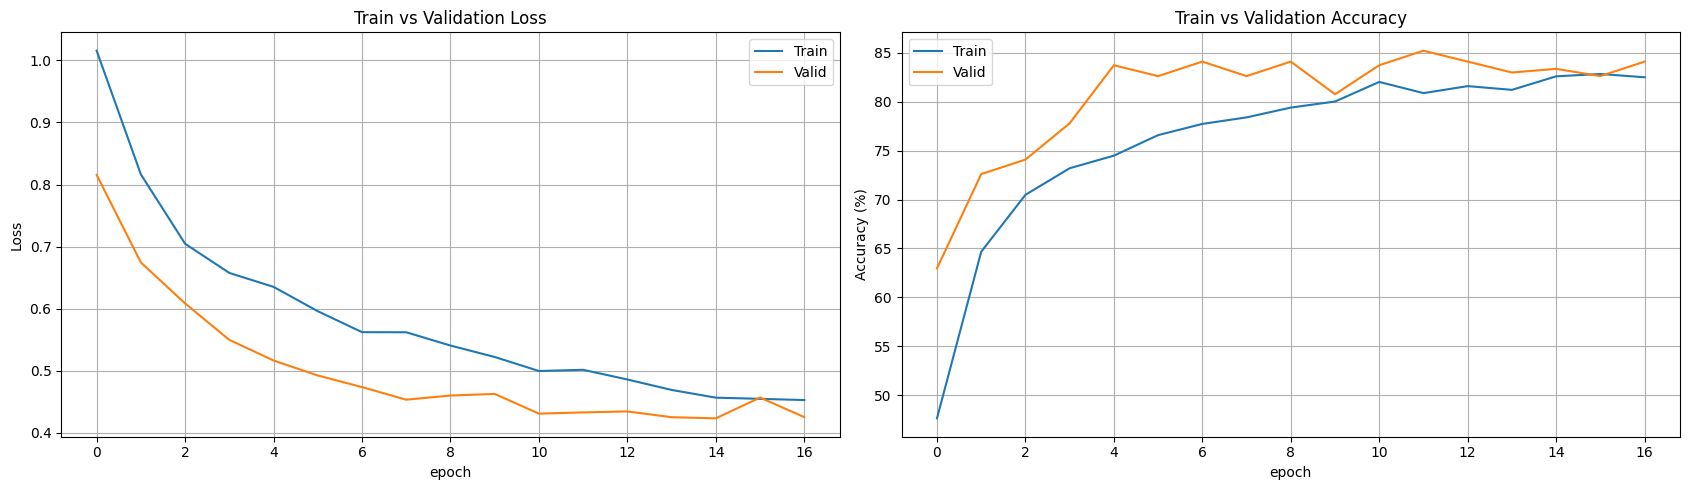

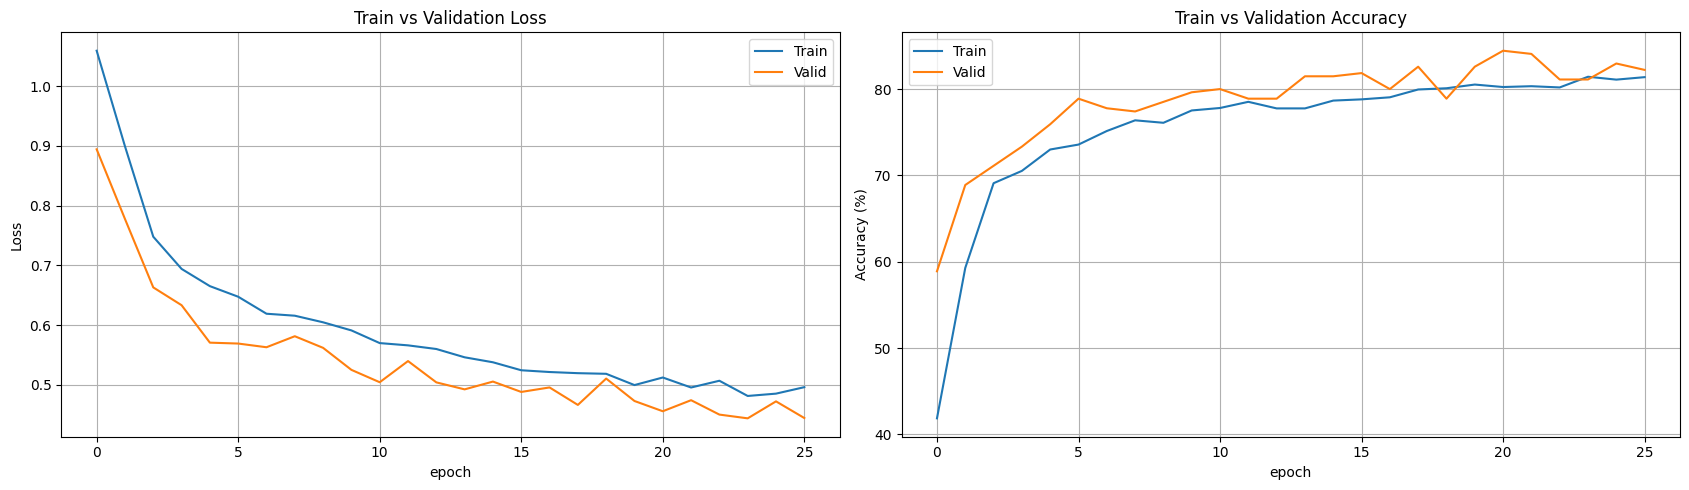

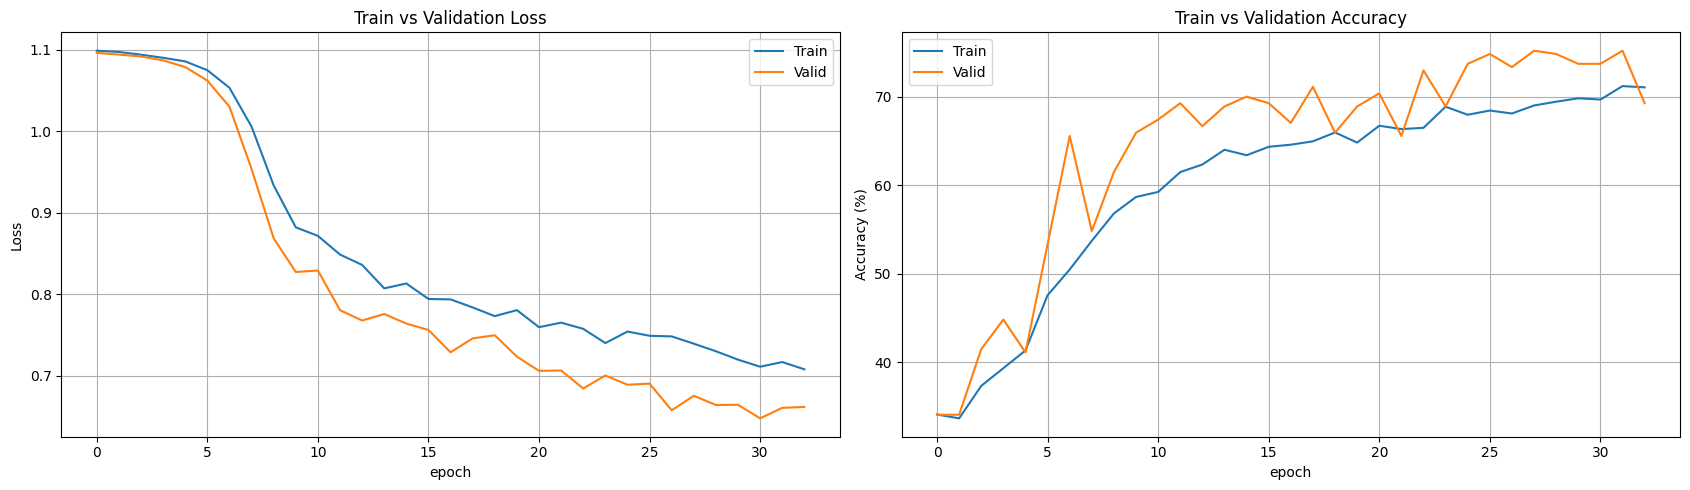

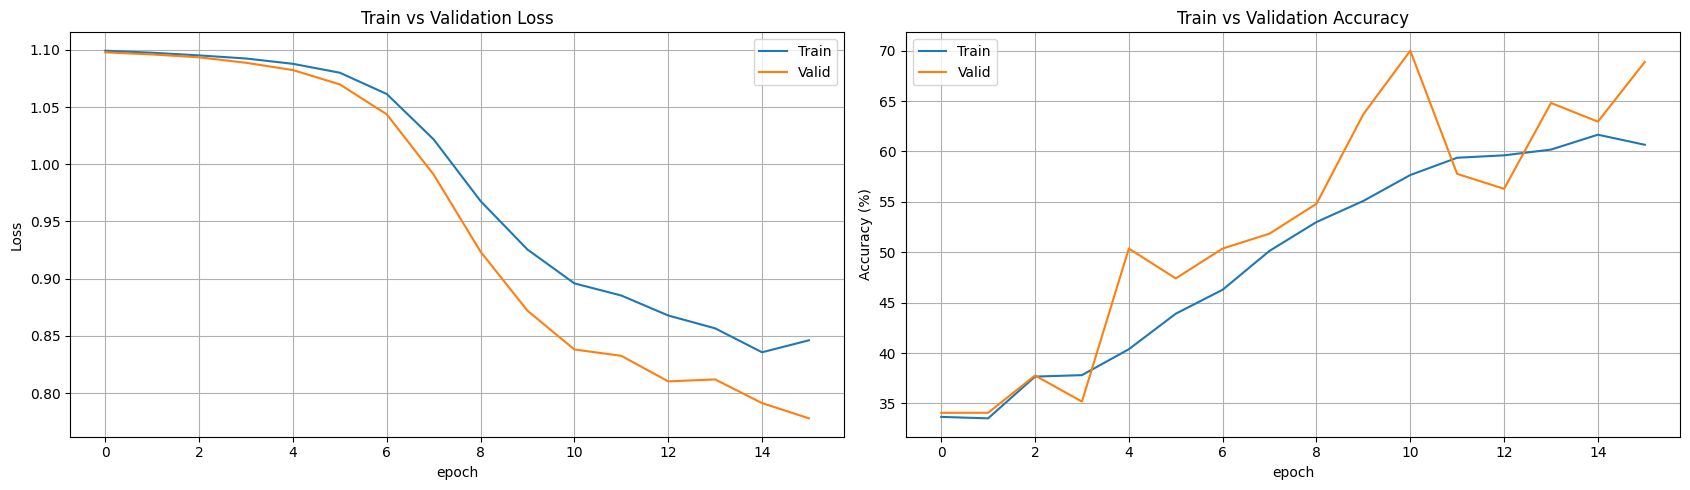

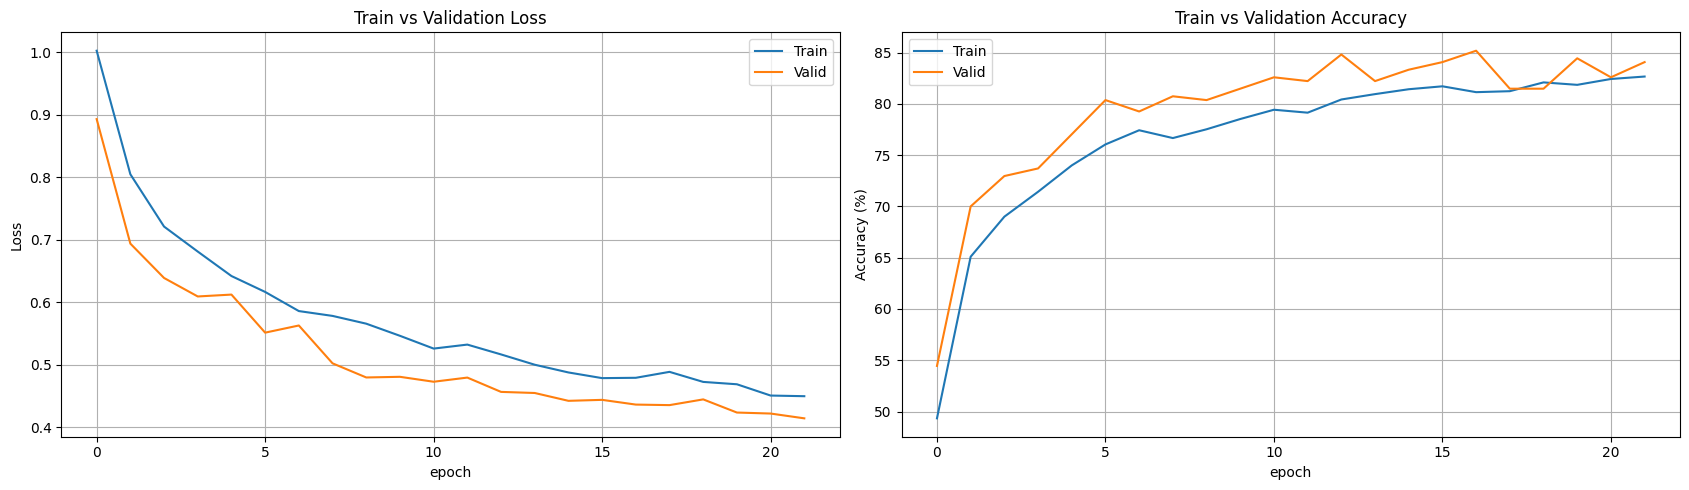

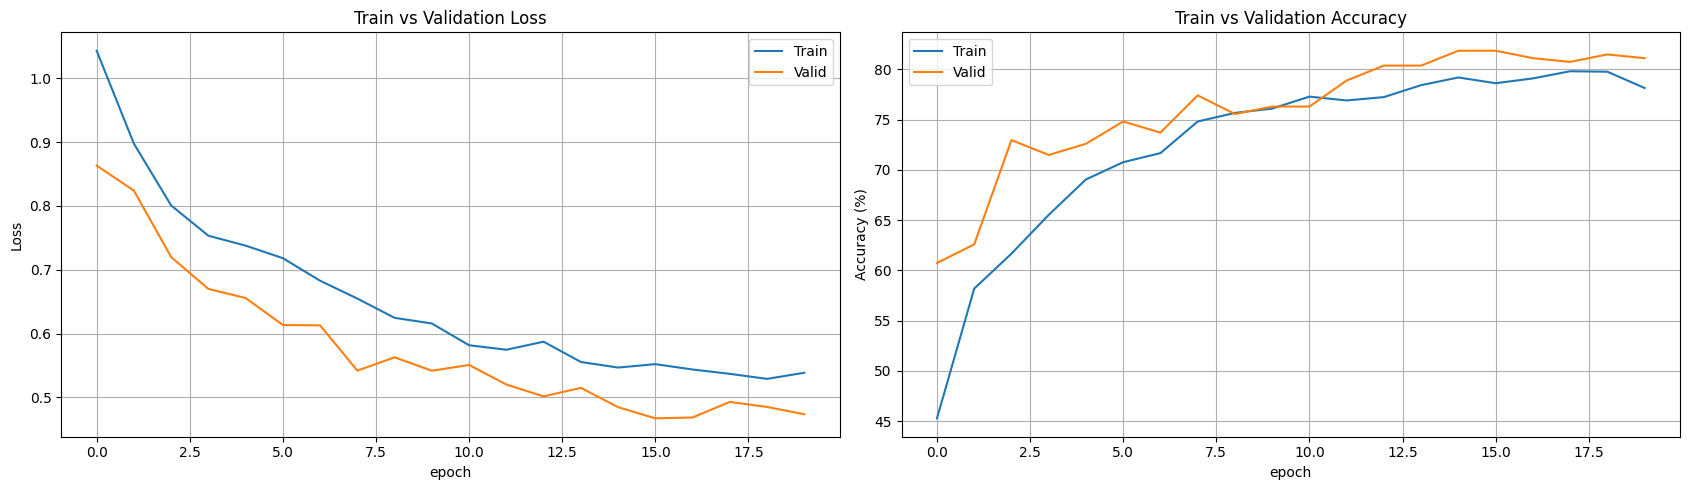

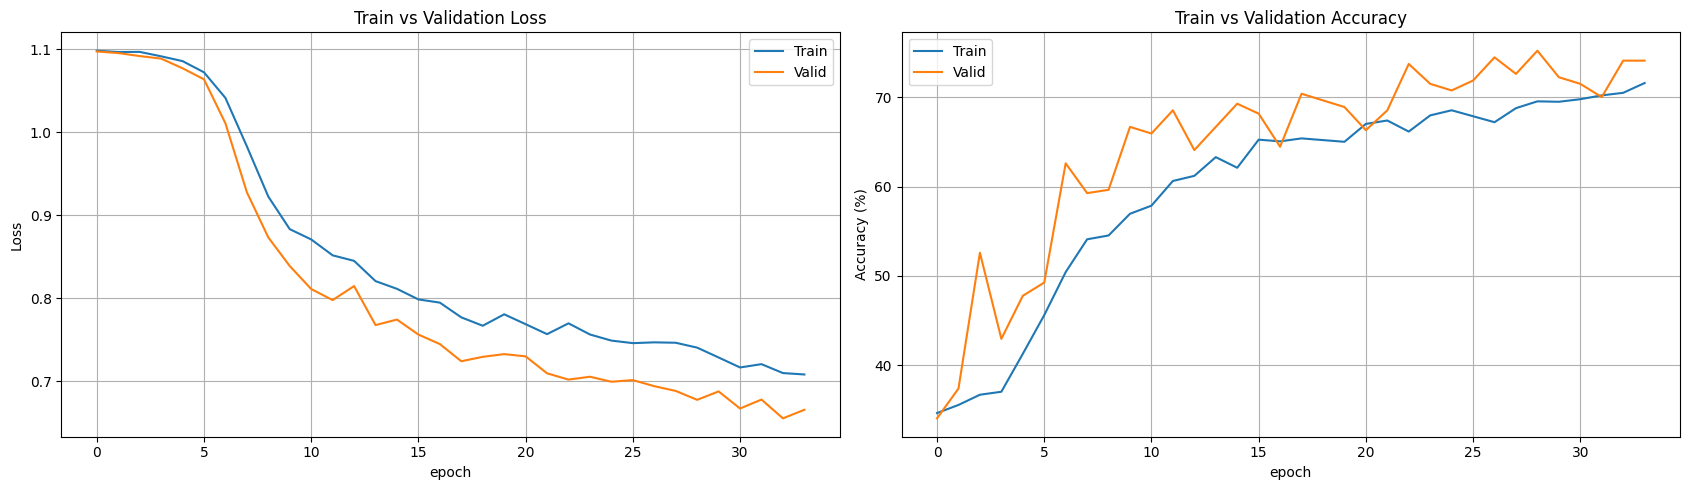

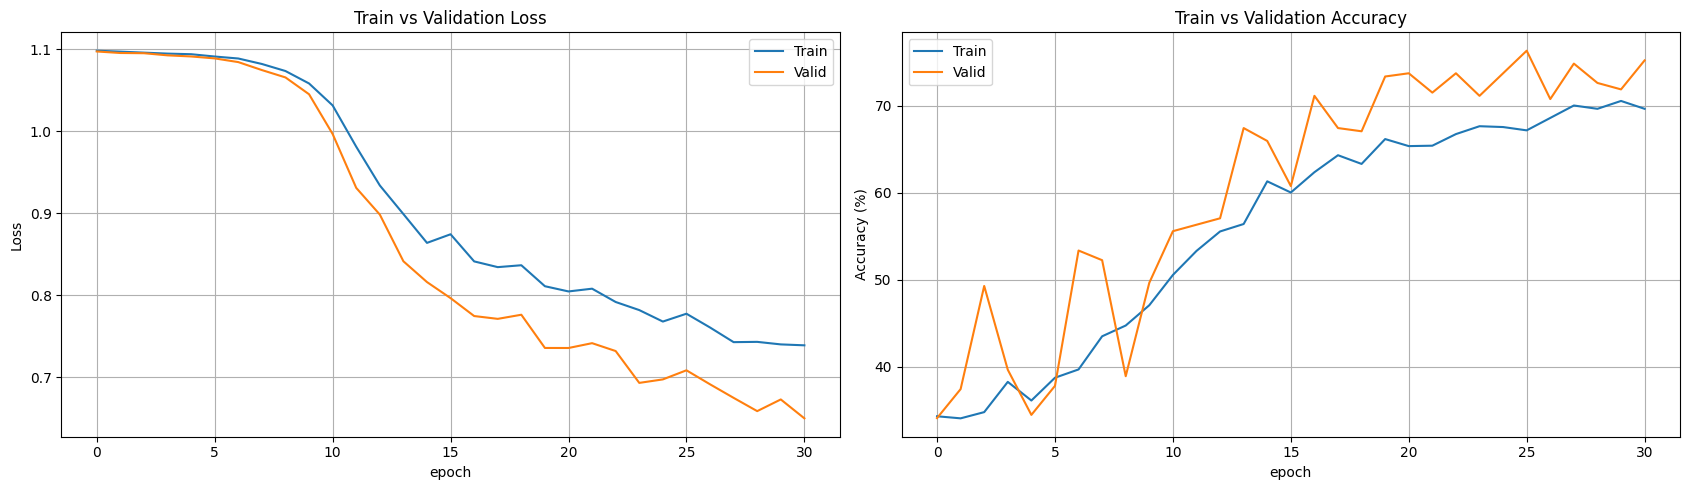

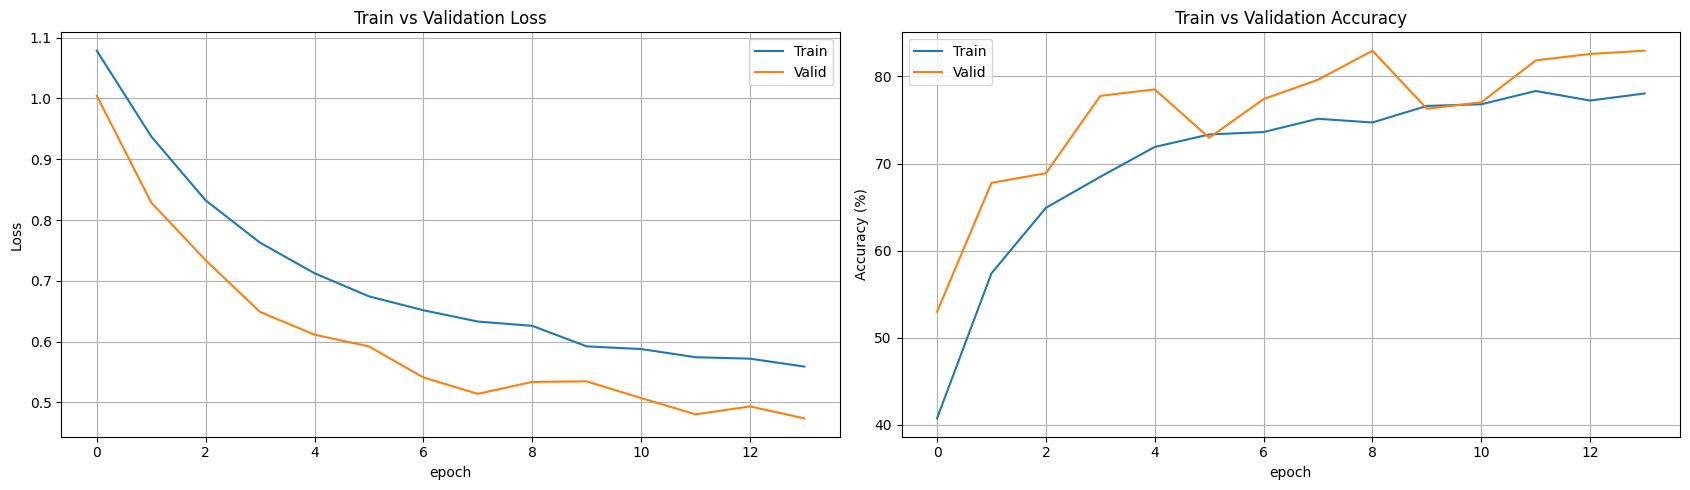

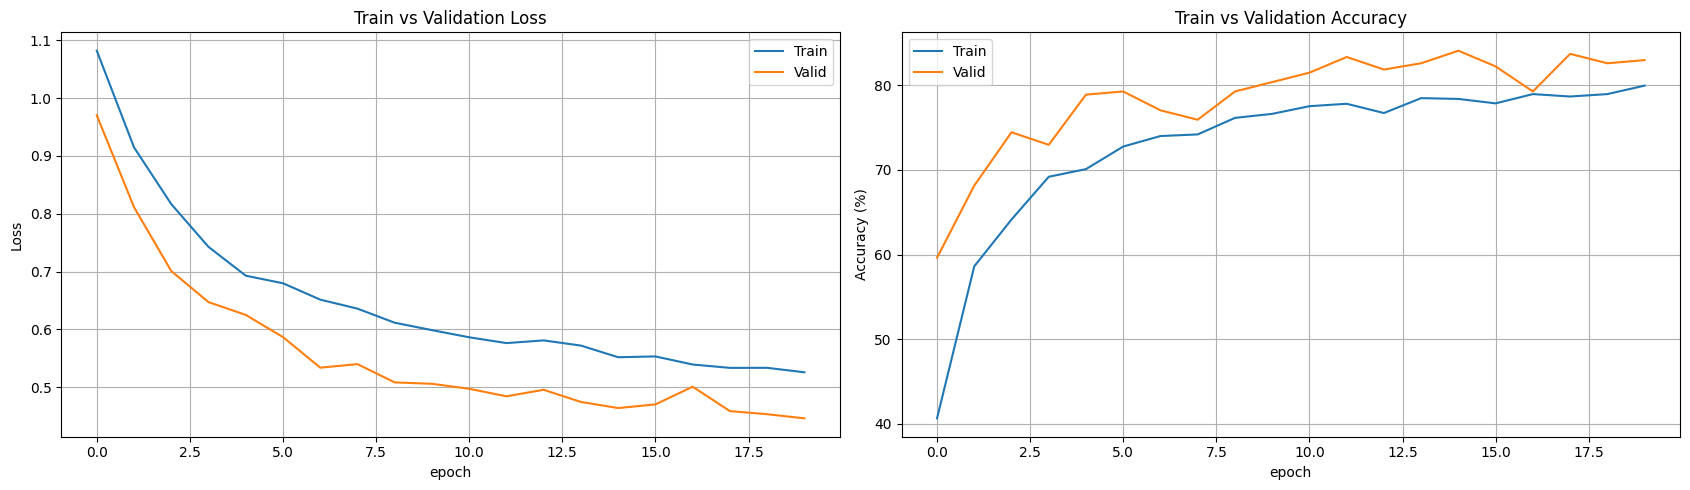

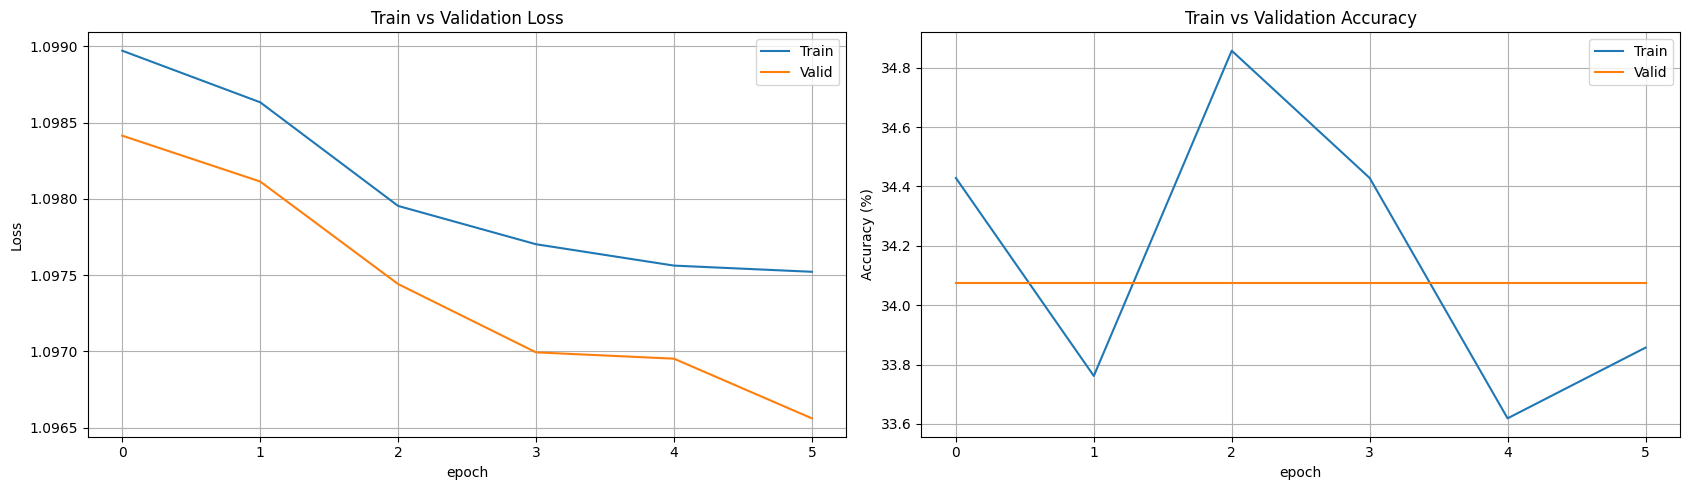

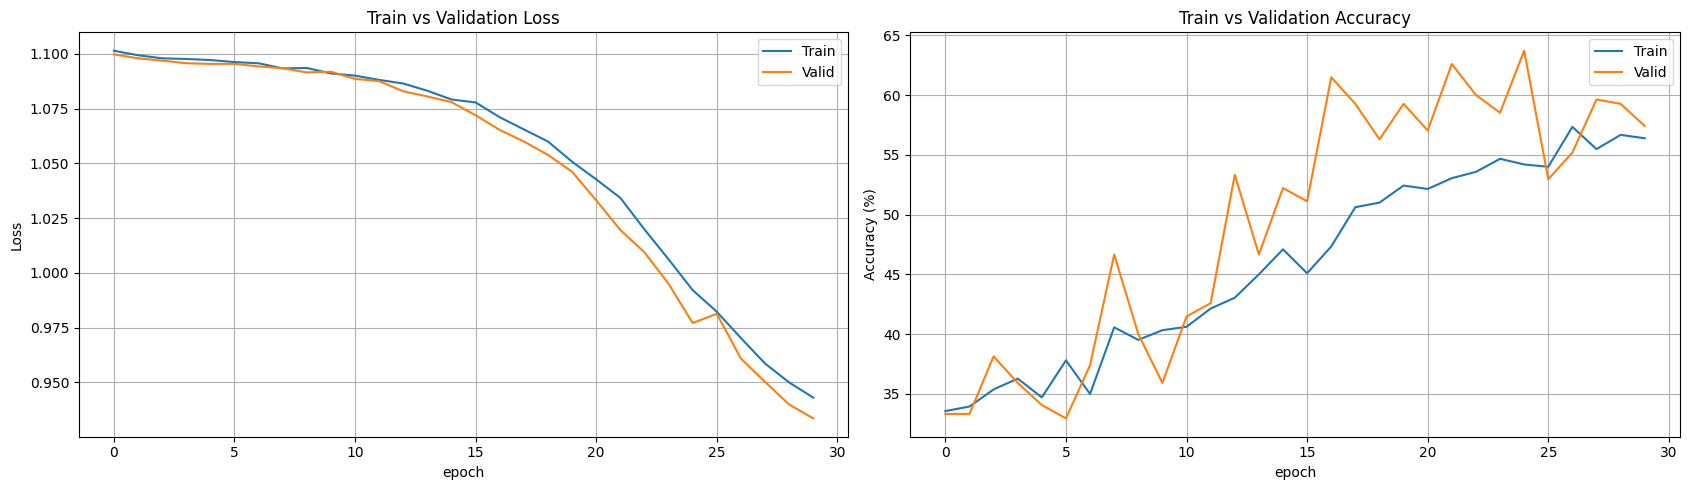

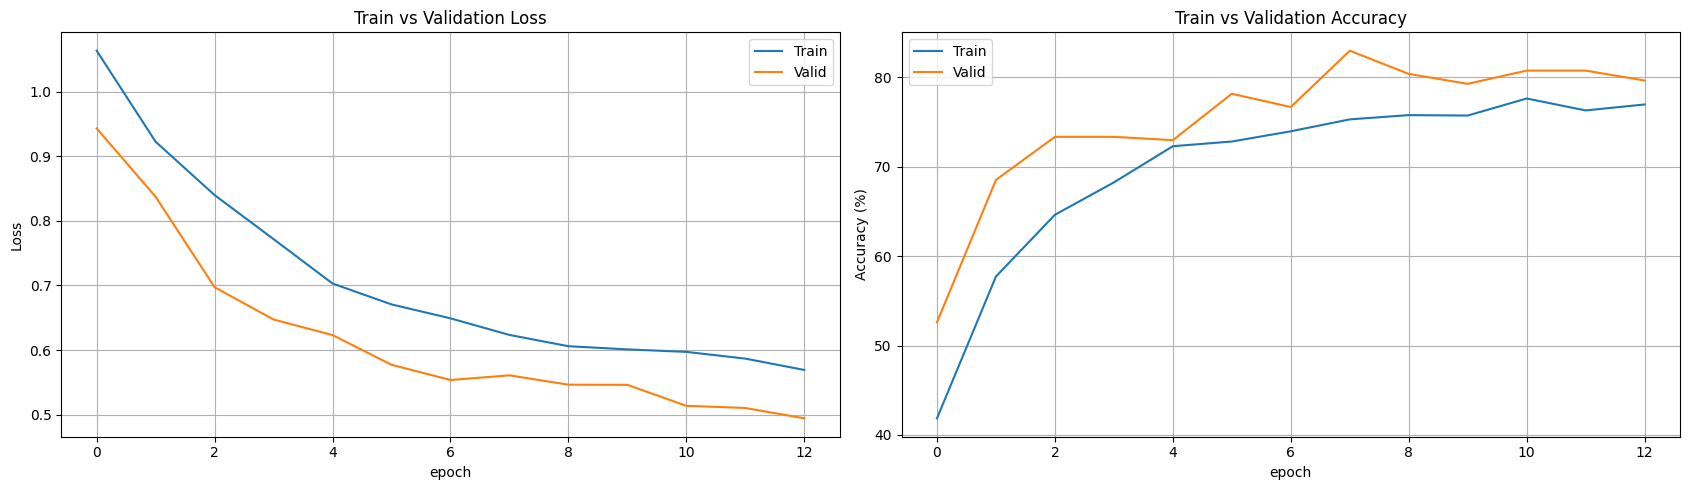

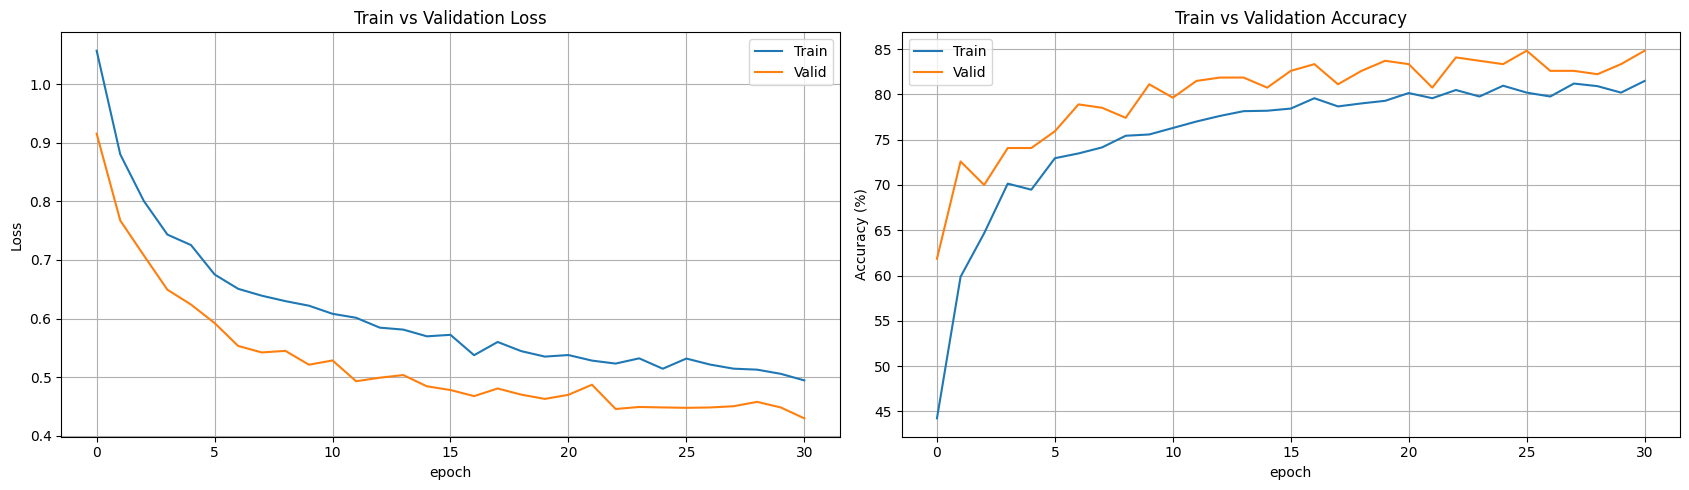

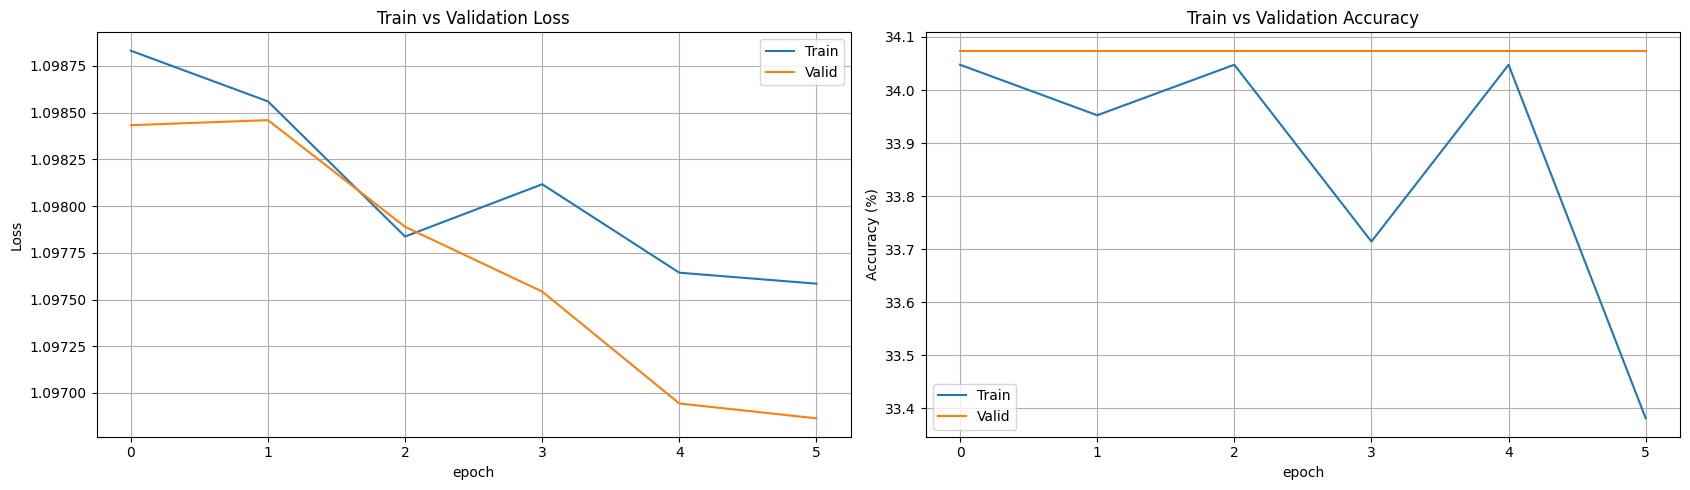

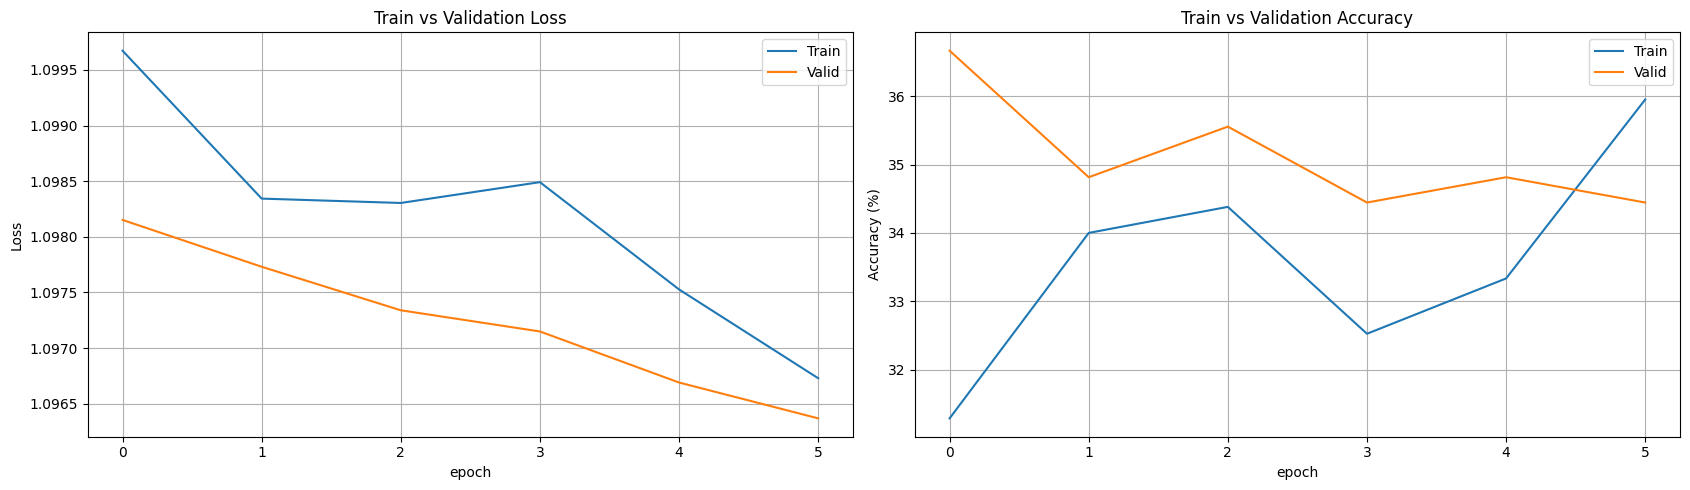

In [ ]:
results = []

for i, combo in enumerate(param_combinations):
    params = dict(zip(param_grid.keys(), combo))
    run_name = f"grid_trial_{i}"
    print(f"\nTraining {run_name} with params: {params}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CustomCNN(dropout_rate=params['dropout_fc_rate']).to(device)
    num_epochs = 50
    criterion = nn.CrossEntropyLoss()
    optimizers = {
        "Adam": torch.optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"]),
        "SGD": torch.optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9)
    }
    optimizer = optimizers[params["optimizer"]]
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

    train_acc_history = []
    train_loss_history = []
    valid_acc_history = []
    valid_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_valid_acc = 0.0
    best_model_path = f"../models/grid_search/{run_name}.pt"
    patience = 5
    early_stop_counter = 0

    start = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_labels = []
        all_preds = []

        train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, (images, labels) in train_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            train_loss_avg = running_loss / (i + 1)
            train_accuracy = 100 * correct_train / total_train
            train_bar.set_postfix({'loss': f'{train_loss_avg:.3f}', 'acc': f'{train_accuracy:.2f}%'})

        train_f1 = f1_score(all_labels, all_preds, average='macro')
        train_precision = precision_score(all_labels, all_preds, average='macro')
        train_recall = recall_score(all_labels, all_preds, average='macro')
        train_loss_avg = running_loss / len(train_loader)
        train_loss_history.append(train_loss_avg)
        train_acc_history.append(train_accuracy)

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss_avg:.3f}, Train Acc: {train_accuracy:.2f}%, '
            f'Train F1: {train_f1:.3f}, Train Precision: {train_precision:.3f}, Train Recall: {train_recall:.3f}')
        
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            valid_bar = tqdm(valid_loader, total=len(valid_loader), desc="Validation")
            for images, labels in valid_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total_valid += labels.size(0)
                correct_valid += (preds == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

                valid_loss_avg = valid_loss / len(valid_loader)
                valid_accuracy = 100 * correct_valid / total_valid
                valid_bar.set_postfix({'loss': f'{valid_loss_avg:.3f}', 'acc': f'{valid_accuracy:.2f}%'})

        valid_f1 = f1_score(all_labels, all_preds, average='macro')
        valid_precision = precision_score(all_labels, all_preds, average='macro',zero_division=1)
        valid_recall = recall_score(all_labels, all_preds, average='macro',zero_division=1)
        valid_loss_avg = valid_loss / len(valid_loader)
        valid_loss_history.append(valid_loss_avg)
        valid_acc_history.append(valid_accuracy)

        print(f'Epoch {epoch + 1}, Valid Loss: {valid_loss_avg:.3f}, Valid Acc: {valid_accuracy:.2f}%, '
            f'Valid F1: {valid_f1:.3f}, Valid Precision: {valid_precision:.3f}, Valid Recall: {valid_recall:.3f}')
        print("Validation Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

        if valid_accuracy > best_valid_acc:
            best_valid_acc = valid_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved: Valid Accuracy = {best_valid_acc:.2f}%")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stop counter: {early_stop_counter}/{patience}")

        scheduler.step()
        print(f"Current learning rate: {scheduler.get_last_lr()[0]:.6f}")

        if early_stop_counter >= patience:
            print(f"Early stop triggered! No recovery during {patience} epoch.")
            break

    results.append({**params, "run_name": run_name, "valid_acc": best_valid_acc})
    time_elapsed = time.time() - start
    print(f"Training finished after: {time_elapsed:.2f} seconds")

    plt.figure(figsize=(17,5))
    plt.subplot(121)
    plt.plot(train_loss_history)
    plt.plot(valid_loss_history)
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Validation Loss')
    plt.grid()

    plt.subplot(122)
    plt.plot(train_acc_history,)
    plt.plot(valid_acc_history)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Validation Accuracy')
    plt.grid()

    plt.tight_layout()
    plt.savefig(f"../images/{run_name}_training_results.png")

results_df = pd.DataFrame(results).sort_values(by="valid_acc", ascending=False)
results_df.to_csv("grid_search_results.csv", index=False)
print(results_df)
best_run = results_df.iloc[0]
print("\nBest Hyperparameters:")
print(best_run)

In [138]:
results_df

,learning_rate,weight_decay,optimizer,dropout_fc_rate,run_name,valid_acc
0,0.0010,0.0000,Adam,0.4,grid_trial_0,85.185185
4,0.0010,0.0001,Adam,0.4,grid_trial_4,85.185185
13,0.0003,0.0001,Adam,0.5,grid_trial_13,84.814815
1,0.0010,0.0000,Adam,0.5,grid_trial_1,84.444444
9,0.0003,0.0000,Adam,0.5,grid_trial_9,84.074074
8,0.0003,0.0000,Adam,0.4,grid_trial_8,82.962963
12,0.0003,0.0001,Adam,0.4,grid_trial_12,82.962963
5,0.0010,0.0001,Adam,0.5,grid_trial_5,81.851852
7,0.0010,0.0001,SGD,0.5,grid_trial_7,76.296296
2,0.0010,0.0000,SGD,0.4,grid_trial_2,75.185185


In [139]:
best_run = results_df.iloc[0]
print("\nBest Hyperparameters:")
print(best_run)


Best Hyperparameters:
learning_rate             0.001
weight_decay                0.0
optimizer                  Adam
dropout_fc_rate             0.4
run_name           grid_trial_0
valid_acc             85.185185
Name: 0, dtype: object


In [140]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.4):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # 112 -> 56
        x = self.pool(self.relu(self.bn2(self.conv2(x))))  # 56 -> 28
        x = self.pool(self.relu(self.bn3(self.conv3(x))))  # 28 -> 14
        x = x.view(-1, 64 * 14 * 14)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [141]:
param_grid = {
    'learning_rate': [1e-3, 7e-4, 5e-4],
    'dropout_fc_rate': [0.3, 0.35, 0.4]
}

param_combinations = list(itertools.product(*param_grid.values()))


Training improved_grid_trial_0 with params: {'learning_rate': 0.001, 'dropout_fc_rate': 0.3}


Epoch 1/100: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s, loss=1.293, acc=45.33%]


Epoch 1, Train Loss: 1.293, Train Acc: 45.33%, Train F1: 0.416, Train Precision: 0.438, Train Recall: 0.453


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.88it/s, loss=0.869, acc=56.30%]


Epoch 1, Valid Loss: 0.869, Valid Acc: 56.30%, Valid F1: 0.483, Valid Precision: 0.649, Valid Recall: 0.561
Validation Confusion Matrix:
 [[90  0  2]
 [82  3  5]
 [27  2 59]]
Best model saved: Valid Accuracy = 56.30%
Current learning rate: 0.000999


Epoch 2/100: 100%|██████████| 66/66 [00:18<00:00,  3.60it/s, loss=0.855, acc=55.33%]


Epoch 2, Train Loss: 0.855, Train Acc: 55.33%, Train F1: 0.540, Train Precision: 0.577, Train Recall: 0.554


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.86it/s, loss=0.747, acc=65.93%]


Epoch 2, Valid Loss: 0.747, Valid Acc: 65.93%, Valid F1: 0.648, Valid Precision: 0.716, Valid Recall: 0.658
Validation Confusion Matrix:
 [[84  7  1]
 [56 31  3]
 [17  8 63]]
Best model saved: Valid Accuracy = 65.93%
Current learning rate: 0.000996


Epoch 3/100: 100%|██████████| 66/66 [00:18<00:00,  3.48it/s, loss=0.795, acc=60.05%]


Epoch 3, Train Loss: 0.795, Train Acc: 60.05%, Train F1: 0.606, Train Precision: 0.629, Train Recall: 0.601


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.42it/s, loss=0.711, acc=72.22%]


Epoch 3, Valid Loss: 0.711, Valid Acc: 72.22%, Valid F1: 0.719, Valid Precision: 0.731, Valid Recall: 0.722
Validation Confusion Matrix:
 [[76 15  1]
 [38 45  7]
 [ 5  9 74]]
Best model saved: Valid Accuracy = 72.22%
Current learning rate: 0.000991


Epoch 4/100: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s, loss=0.791, acc=60.76%]


Epoch 4, Train Loss: 0.791, Train Acc: 60.76%, Train F1: 0.610, Train Precision: 0.641, Train Recall: 0.607


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.66it/s, loss=0.674, acc=69.26%]


Epoch 4, Valid Loss: 0.674, Valid Acc: 69.26%, Valid F1: 0.674, Valid Precision: 0.746, Valid Recall: 0.692
Validation Confusion Matrix:
 [[85  4  3]
 [52 31  7]
 [13  4 71]]
Early stop counter: 1/20
Current learning rate: 0.000984


Epoch 5/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.753, acc=64.76%]


Epoch 5, Train Loss: 0.753, Train Acc: 64.76%, Train F1: 0.655, Train Precision: 0.678, Train Recall: 0.648


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s, loss=0.649, acc=73.33%]


Epoch 5, Valid Loss: 0.649, Valid Acc: 73.33%, Valid F1: 0.737, Valid Precision: 0.758, Valid Recall: 0.735
Validation Confusion Matrix:
 [[53 37  2]
 [13 73  4]
 [ 5 11 72]]
Best model saved: Valid Accuracy = 73.33%
Current learning rate: 0.000976


Epoch 6/100: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s, loss=0.749, acc=66.33%]


Epoch 6, Train Loss: 0.749, Train Acc: 66.33%, Train F1: 0.670, Train Precision: 0.687, Train Recall: 0.664


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.37it/s, loss=0.625, acc=79.63%]


Epoch 6, Valid Loss: 0.625, Valid Acc: 79.63%, Valid F1: 0.798, Valid Precision: 0.807, Valid Recall: 0.797
Validation Confusion Matrix:
 [[67 20  5]
 [ 9 77  4]
 [ 5 12 71]]
Best model saved: Valid Accuracy = 79.63%
Current learning rate: 0.000965


Epoch 7/100: 100%|██████████| 66/66 [00:20<00:00,  3.24it/s, loss=0.745, acc=64.81%]


Epoch 7, Train Loss: 0.745, Train Acc: 64.81%, Train F1: 0.654, Train Precision: 0.670, Train Recall: 0.648


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.99it/s, loss=0.615, acc=72.59%]


Epoch 7, Valid Loss: 0.615, Valid Acc: 72.59%, Valid F1: 0.720, Valid Precision: 0.739, Valid Recall: 0.726
Validation Confusion Matrix:
 [[80 10  2]
 [38 44  8]
 [ 7  9 72]]
Early stop counter: 1/20
Current learning rate: 0.000952


Epoch 8/100: 100%|██████████| 66/66 [00:17<00:00,  3.85it/s, loss=0.733, acc=68.86%]


Epoch 8, Train Loss: 0.733, Train Acc: 68.86%, Train F1: 0.694, Train Precision: 0.715, Train Recall: 0.688


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.36it/s, loss=0.570, acc=79.26%]


Epoch 8, Valid Loss: 0.570, Valid Acc: 79.26%, Valid F1: 0.797, Valid Precision: 0.810, Valid Recall: 0.793
Validation Confusion Matrix:
 [[72 20  0]
 [13 73  4]
 [ 4 15 69]]
Early stop counter: 2/20
Current learning rate: 0.000938


Epoch 9/100: 100%|██████████| 66/66 [00:17<00:00,  3.76it/s, loss=0.704, acc=70.67%]


Epoch 9, Train Loss: 0.704, Train Acc: 70.67%, Train F1: 0.711, Train Precision: 0.729, Train Recall: 0.706


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.30it/s, loss=0.586, acc=75.19%]


Epoch 9, Valid Loss: 0.586, Valid Acc: 75.19%, Valid F1: 0.755, Valid Precision: 0.778, Valid Recall: 0.751
Validation Confusion Matrix:
 [[79 13  0]
 [31 56  3]
 [12  8 68]]
Early stop counter: 3/20
Current learning rate: 0.000922


Epoch 10/100: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=0.687, acc=69.95%]


Epoch 10, Train Loss: 0.687, Train Acc: 69.95%, Train F1: 0.704, Train Precision: 0.721, Train Recall: 0.699


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.30it/s, loss=0.647, acc=72.59%]


Epoch 10, Valid Loss: 0.647, Valid Acc: 72.59%, Valid F1: 0.725, Valid Precision: 0.781, Valid Recall: 0.725
Validation Confusion Matrix:
 [[68 24  0]
 [10 79  1]
 [12 27 49]]
Early stop counter: 4/20
Current learning rate: 0.000905


Epoch 11/100: 100%|██████████| 66/66 [00:17<00:00,  3.82it/s, loss=0.689, acc=71.19%]


Epoch 11, Train Loss: 0.689, Train Acc: 71.19%, Train F1: 0.716, Train Precision: 0.741, Train Recall: 0.712


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.75it/s, loss=0.663, acc=74.07%]


Epoch 11, Valid Loss: 0.663, Valid Acc: 74.07%, Valid F1: 0.738, Valid Precision: 0.755, Valid Recall: 0.743
Validation Confusion Matrix:
 [[57 23 12]
 [ 6 63 21]
 [ 3  5 80]]
Early stop counter: 5/20
Current learning rate: 0.000885


Epoch 12/100: 100%|██████████| 66/66 [00:18<00:00,  3.61it/s, loss=0.673, acc=71.67%]


Epoch 12, Train Loss: 0.673, Train Acc: 71.67%, Train F1: 0.721, Train Precision: 0.742, Train Recall: 0.717


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.43it/s, loss=0.545, acc=78.89%]


Epoch 12, Valid Loss: 0.545, Valid Acc: 78.89%, Valid F1: 0.792, Valid Precision: 0.810, Valid Recall: 0.788
Validation Confusion Matrix:
 [[80 12  0]
 [21 67  2]
 [11 11 66]]
Early stop counter: 6/20
Current learning rate: 0.000864


Epoch 13/100: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s, loss=0.681, acc=70.71%]


Epoch 13, Train Loss: 0.681, Train Acc: 70.71%, Train F1: 0.711, Train Precision: 0.736, Train Recall: 0.707


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.42it/s, loss=0.509, acc=80.00%]


Epoch 13, Valid Loss: 0.509, Valid Acc: 80.00%, Valid F1: 0.803, Valid Precision: 0.817, Valid Recall: 0.799
Validation Confusion Matrix:
 [[79 13  0]
 [19 69  2]
 [ 7 13 68]]
Best model saved: Valid Accuracy = 80.00%
Current learning rate: 0.000842


Epoch 14/100: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s, loss=0.658, acc=72.62%]


Epoch 14, Train Loss: 0.658, Train Acc: 72.62%, Train F1: 0.731, Train Precision: 0.746, Train Recall: 0.726


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.70it/s, loss=0.511, acc=80.00%]


Epoch 14, Valid Loss: 0.511, Valid Acc: 80.00%, Valid F1: 0.805, Valid Precision: 0.827, Valid Recall: 0.800
Validation Confusion Matrix:
 [[68 24  0]
 [ 9 79  2]
 [ 4 15 69]]
Early stop counter: 1/20
Current learning rate: 0.000819


Epoch 15/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.664, acc=71.86%]


Epoch 15, Train Loss: 0.664, Train Acc: 71.86%, Train F1: 0.722, Train Precision: 0.733, Train Recall: 0.719


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.30it/s, loss=0.503, acc=81.48%]


Epoch 15, Valid Loss: 0.503, Valid Acc: 81.48%, Valid F1: 0.817, Valid Precision: 0.823, Valid Recall: 0.815
Validation Confusion Matrix:
 [[71 19  2]
 [11 75  4]
 [ 5  9 74]]
Best model saved: Valid Accuracy = 81.48%
Current learning rate: 0.000794


Epoch 16/100: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, loss=0.644, acc=74.38%]


Epoch 16, Train Loss: 0.644, Train Acc: 74.38%, Train F1: 0.747, Train Precision: 0.755, Train Recall: 0.744


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s, loss=0.500, acc=84.07%]


Epoch 16, Valid Loss: 0.500, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.849, Valid Recall: 0.842
Validation Confusion Matrix:
 [[71 20  1]
 [ 8 77  5]
 [ 2  7 79]]
Best model saved: Valid Accuracy = 84.07%
Current learning rate: 0.000768


Epoch 17/100: 100%|██████████| 66/66 [00:18<00:00,  3.47it/s, loss=0.621, acc=74.57%]


Epoch 17, Train Loss: 0.621, Train Acc: 74.57%, Train F1: 0.749, Train Precision: 0.766, Train Recall: 0.746


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.47it/s, loss=0.479, acc=80.37%]


Epoch 17, Valid Loss: 0.479, Valid Acc: 80.37%, Valid F1: 0.805, Valid Precision: 0.806, Valid Recall: 0.804
Validation Confusion Matrix:
 [[75 15  2]
 [19 65  6]
 [ 3  8 77]]
Early stop counter: 1/20
Current learning rate: 0.000741


Epoch 18/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.603, acc=75.05%]


Epoch 18, Train Loss: 0.603, Train Acc: 75.05%, Train F1: 0.753, Train Precision: 0.763, Train Recall: 0.751


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s, loss=0.498, acc=82.96%]


Epoch 18, Valid Loss: 0.498, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.845, Valid Recall: 0.830
Validation Confusion Matrix:
 [[69 23  0]
 [ 7 79  4]
 [ 3  9 76]]
Early stop counter: 2/20
Current learning rate: 0.000713


Epoch 19/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.607, acc=75.95%]


Epoch 19, Train Loss: 0.607, Train Acc: 75.95%, Train F1: 0.763, Train Precision: 0.773, Train Recall: 0.760


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.44it/s, loss=0.503, acc=82.59%]


Epoch 19, Valid Loss: 0.503, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.839, Valid Recall: 0.826
Validation Confusion Matrix:
 [[75 17  0]
 [13 75  2]
 [ 4 11 73]]
Early stop counter: 3/20
Current learning rate: 0.000684


Epoch 20/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.611, acc=75.62%]


Epoch 20, Train Loss: 0.611, Train Acc: 75.62%, Train F1: 0.760, Train Precision: 0.771, Train Recall: 0.757


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.73it/s, loss=0.466, acc=83.70%]


Epoch 20, Valid Loss: 0.466, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.847, Valid Recall: 0.837
Validation Confusion Matrix:
 [[75 17  0]
 [13 75  2]
 [ 3  9 76]]
Early stop counter: 4/20
Current learning rate: 0.000655


Epoch 21/100: 100%|██████████| 66/66 [00:19<00:00,  3.46it/s, loss=0.592, acc=75.43%]


Epoch 21, Train Loss: 0.592, Train Acc: 75.43%, Train F1: 0.757, Train Precision: 0.765, Train Recall: 0.755


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s, loss=0.513, acc=80.74%]


Epoch 21, Valid Loss: 0.513, Valid Acc: 80.74%, Valid F1: 0.809, Valid Precision: 0.825, Valid Recall: 0.809
Validation Confusion Matrix:
 [[62 28  2]
 [ 7 78  5]
 [ 2  8 78]]
Early stop counter: 5/20
Current learning rate: 0.000624


Epoch 22/100: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s, loss=0.588, acc=76.05%]


Epoch 22, Train Loss: 0.588, Train Acc: 76.05%, Train F1: 0.764, Train Precision: 0.774, Train Recall: 0.761


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s, loss=0.493, acc=82.59%]


Epoch 22, Valid Loss: 0.493, Valid Acc: 82.59%, Valid F1: 0.830, Valid Precision: 0.847, Valid Recall: 0.826
Validation Confusion Matrix:
 [[72 20  0]
 [10 80  0]
 [ 5 12 71]]
Early stop counter: 6/20
Current learning rate: 0.000594


Epoch 23/100: 100%|██████████| 66/66 [00:21<00:00,  3.09it/s, loss=0.565, acc=77.14%]


Epoch 23, Train Loss: 0.565, Train Acc: 77.14%, Train F1: 0.774, Train Precision: 0.786, Train Recall: 0.772


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s, loss=0.466, acc=83.70%]


Epoch 23, Valid Loss: 0.466, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.850, Valid Recall: 0.837
Validation Confusion Matrix:
 [[79 13  0]
 [14 75  1]
 [ 6 10 72]]
Early stop counter: 7/20
Current learning rate: 0.000563


Epoch 24/100: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.584, acc=76.00%]


Epoch 24, Train Loss: 0.584, Train Acc: 76.00%, Train F1: 0.763, Train Precision: 0.775, Train Recall: 0.760


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.42it/s, loss=0.438, acc=85.19%]


Epoch 24, Valid Loss: 0.438, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.854, Valid Recall: 0.852
Validation Confusion Matrix:
 [[79 12  1]
 [12 73  5]
 [ 3  7 78]]
Best model saved: Valid Accuracy = 85.19%
Current learning rate: 0.000531


Epoch 25/100: 100%|██████████| 66/66 [00:18<00:00,  3.59it/s, loss=0.590, acc=75.24%]


Epoch 25, Train Loss: 0.590, Train Acc: 75.24%, Train F1: 0.756, Train Precision: 0.766, Train Recall: 0.753


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.34it/s, loss=0.459, acc=82.96%]


Epoch 25, Valid Loss: 0.459, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.848, Valid Recall: 0.830
Validation Confusion Matrix:
 [[69 23  0]
 [ 7 80  3]
 [ 3 10 75]]
Early stop counter: 1/20
Current learning rate: 0.000500


Epoch 26/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.588, acc=75.24%]


Epoch 26, Train Loss: 0.588, Train Acc: 75.24%, Train F1: 0.756, Train Precision: 0.772, Train Recall: 0.753


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.36it/s, loss=0.462, acc=85.56%]


Epoch 26, Valid Loss: 0.462, Valid Acc: 85.56%, Valid F1: 0.856, Valid Precision: 0.857, Valid Recall: 0.856
Validation Confusion Matrix:
 [[74 17  1]
 [ 9 75  6]
 [ 3  3 82]]
Best model saved: Valid Accuracy = 85.56%
Current learning rate: 0.000469


Epoch 27/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.550, acc=77.48%]


Epoch 27, Train Loss: 0.550, Train Acc: 77.48%, Train F1: 0.778, Train Precision: 0.789, Train Recall: 0.776


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.40it/s, loss=0.421, acc=85.19%]


Epoch 27, Valid Loss: 0.421, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.857, Valid Recall: 0.853
Validation Confusion Matrix:
 [[73 19  0]
 [ 9 76  5]
 [ 2  5 81]]
Early stop counter: 1/20
Current learning rate: 0.000437


Epoch 28/100: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.564, acc=77.00%]


Epoch 28, Train Loss: 0.564, Train Acc: 77.00%, Train F1: 0.773, Train Precision: 0.783, Train Recall: 0.771


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s, loss=0.411, acc=85.19%]


Epoch 28, Valid Loss: 0.411, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.854, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 14  2]
 [12 74  4]
 [ 3  5 80]]
Early stop counter: 2/20
Current learning rate: 0.000406


Epoch 29/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.546, acc=77.81%]


Epoch 29, Train Loss: 0.546, Train Acc: 77.81%, Train F1: 0.781, Train Precision: 0.794, Train Recall: 0.779


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.37it/s, loss=0.461, acc=84.07%]


Epoch 29, Valid Loss: 0.461, Valid Acc: 84.07%, Valid F1: 0.841, Valid Precision: 0.842, Valid Recall: 0.842
Validation Confusion Matrix:
 [[73 16  3]
 [ 9 73  8]
 [ 2  5 81]]
Early stop counter: 3/20
Current learning rate: 0.000376


Epoch 30/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.557, acc=77.33%]


Epoch 30, Train Loss: 0.557, Train Acc: 77.33%, Train F1: 0.776, Train Precision: 0.788, Train Recall: 0.774


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.01it/s, loss=0.450, acc=84.44%]


Epoch 30, Valid Loss: 0.450, Valid Acc: 84.44%, Valid F1: 0.845, Valid Precision: 0.846, Valid Recall: 0.845
Validation Confusion Matrix:
 [[73 16  3]
 [ 8 75  7]
 [ 3  5 80]]
Early stop counter: 4/20
Current learning rate: 0.000345


Epoch 31/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.534, acc=79.57%]


Epoch 31, Train Loss: 0.534, Train Acc: 79.57%, Train F1: 0.798, Train Precision: 0.806, Train Recall: 0.797


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.44it/s, loss=0.435, acc=85.19%]


Epoch 31, Valid Loss: 0.435, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.859, Valid Recall: 0.852
Validation Confusion Matrix:
 [[75 17  0]
 [10 77  3]
 [ 3  7 78]]
Early stop counter: 5/20
Current learning rate: 0.000316


Epoch 32/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.556, acc=77.10%]


Epoch 32, Train Loss: 0.556, Train Acc: 77.10%, Train F1: 0.774, Train Precision: 0.786, Train Recall: 0.772


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.38it/s, loss=0.473, acc=85.19%]


Epoch 32, Valid Loss: 0.473, Valid Acc: 85.19%, Valid F1: 0.855, Valid Precision: 0.862, Valid Recall: 0.852
Validation Confusion Matrix:
 [[75 17  0]
 [10 79  1]
 [ 5  7 76]]
Early stop counter: 6/20
Current learning rate: 0.000287


Epoch 33/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.518, acc=78.57%]


Epoch 33, Train Loss: 0.518, Train Acc: 78.57%, Train F1: 0.789, Train Precision: 0.800, Train Recall: 0.787


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.72it/s, loss=0.412, acc=82.96%]


Epoch 33, Valid Loss: 0.412, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.839, Valid Recall: 0.830
Validation Confusion Matrix:
 [[77 15  0]
 [16 72  2]
 [ 4  9 75]]
Early stop counter: 7/20
Current learning rate: 0.000259


Epoch 34/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.534, acc=78.48%]


Epoch 34, Train Loss: 0.534, Train Acc: 78.48%, Train F1: 0.788, Train Precision: 0.796, Train Recall: 0.785


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.44it/s, loss=0.420, acc=84.44%]


Epoch 34, Valid Loss: 0.420, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.850, Valid Recall: 0.845
Validation Confusion Matrix:
 [[74 17  1]
 [10 76  4]
 [ 3  7 78]]
Early stop counter: 8/20
Current learning rate: 0.000232


Epoch 35/100: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s, loss=0.520, acc=79.00%]


Epoch 35, Train Loss: 0.520, Train Acc: 79.00%, Train F1: 0.793, Train Precision: 0.804, Train Recall: 0.791


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.93it/s, loss=0.415, acc=84.07%]


Epoch 35, Valid Loss: 0.415, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.852, Valid Recall: 0.841
Validation Confusion Matrix:
 [[75 16  1]
 [10 78  2]
 [ 3 11 74]]
Early stop counter: 9/20
Current learning rate: 0.000206


Epoch 36/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.515, acc=78.95%]


Epoch 36, Train Loss: 0.515, Train Acc: 78.95%, Train F1: 0.792, Train Precision: 0.804, Train Recall: 0.790


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.42it/s, loss=0.409, acc=85.19%]


Epoch 36, Valid Loss: 0.409, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.859, Valid Recall: 0.852
Validation Confusion Matrix:
 [[78 14  0]
 [13 75  2]
 [ 4  7 77]]
Early stop counter: 10/20
Current learning rate: 0.000181


Epoch 37/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.497, acc=80.62%]


Epoch 37, Train Loss: 0.497, Train Acc: 80.62%, Train F1: 0.809, Train Precision: 0.818, Train Recall: 0.807


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.51it/s, loss=0.398, acc=85.93%]


Epoch 37, Valid Loss: 0.398, Valid Acc: 85.93%, Valid F1: 0.862, Valid Precision: 0.866, Valid Recall: 0.859
Validation Confusion Matrix:
 [[80 12  0]
 [15 74  1]
 [ 3  7 78]]
Best model saved: Valid Accuracy = 85.93%
Current learning rate: 0.000158


Epoch 38/100: 100%|██████████| 66/66 [00:19<00:00,  3.46it/s, loss=0.507, acc=79.38%]


Epoch 38, Train Loss: 0.507, Train Acc: 79.38%, Train F1: 0.797, Train Precision: 0.807, Train Recall: 0.795


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.70it/s, loss=0.437, acc=83.70%]


Epoch 38, Valid Loss: 0.437, Valid Acc: 83.70%, Valid F1: 0.838, Valid Precision: 0.848, Valid Recall: 0.838
Validation Confusion Matrix:
 [[67 24  1]
 [ 5 79  6]
 [ 3  5 80]]
Early stop counter: 1/20
Current learning rate: 0.000136


Epoch 39/100: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s, loss=0.520, acc=79.76%]


Epoch 39, Train Loss: 0.520, Train Acc: 79.76%, Train F1: 0.800, Train Precision: 0.810, Train Recall: 0.799


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.45it/s, loss=0.421, acc=85.93%]


Epoch 39, Valid Loss: 0.421, Valid Acc: 85.93%, Valid F1: 0.862, Valid Precision: 0.867, Valid Recall: 0.859
Validation Confusion Matrix:
 [[79 13  0]
 [13 76  1]
 [ 5  6 77]]
Early stop counter: 2/20
Current learning rate: 0.000115


Epoch 40/100: 100%|██████████| 66/66 [00:19<00:00,  3.30it/s, loss=0.505, acc=79.29%]


Epoch 40, Train Loss: 0.505, Train Acc: 79.29%, Train F1: 0.796, Train Precision: 0.805, Train Recall: 0.794


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s, loss=0.395, acc=85.93%]


Epoch 40, Valid Loss: 0.395, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.865, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 15  0]
 [ 9 77  4]
 [ 3  7 78]]
Early stop counter: 3/20
Current learning rate: 0.000095


Epoch 41/100: 100%|██████████| 66/66 [00:20<00:00,  3.21it/s, loss=0.503, acc=80.05%]


Epoch 41, Train Loss: 0.503, Train Acc: 80.05%, Train F1: 0.804, Train Precision: 0.815, Train Recall: 0.801


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.47it/s, loss=0.389, acc=84.44%]


Epoch 41, Valid Loss: 0.389, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.855, Valid Recall: 0.845
Validation Confusion Matrix:
 [[71 21  0]
 [ 8 78  4]
 [ 2  7 79]]
Early stop counter: 4/20
Current learning rate: 0.000078


Epoch 42/100: 100%|██████████| 66/66 [00:19<00:00,  3.36it/s, loss=0.492, acc=80.19%]


Epoch 42, Train Loss: 0.492, Train Acc: 80.19%, Train F1: 0.805, Train Precision: 0.815, Train Recall: 0.803


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.36it/s, loss=0.386, acc=87.41%]


Epoch 42, Valid Loss: 0.386, Valid Acc: 87.41%, Valid F1: 0.875, Valid Precision: 0.876, Valid Recall: 0.874
Validation Confusion Matrix:
 [[81 11  0]
 [12 74  4]
 [ 2  5 81]]
Best model saved: Valid Accuracy = 87.41%
Current learning rate: 0.000062


Epoch 43/100: 100%|██████████| 66/66 [00:17<00:00,  3.73it/s, loss=0.510, acc=78.76%]


Epoch 43, Train Loss: 0.510, Train Acc: 78.76%, Train F1: 0.791, Train Precision: 0.802, Train Recall: 0.789


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.14it/s, loss=0.391, acc=85.56%]


Epoch 43, Valid Loss: 0.391, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.862, Valid Recall: 0.856
Validation Confusion Matrix:
 [[77 15  0]
 [11 76  3]
 [ 3  7 78]]
Early stop counter: 1/20
Current learning rate: 0.000048


Epoch 44/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.503, acc=80.43%]


Epoch 44, Train Loss: 0.503, Train Acc: 80.43%, Train F1: 0.806, Train Precision: 0.813, Train Recall: 0.805


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s, loss=0.390, acc=84.81%]


Epoch 44, Valid Loss: 0.390, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.860, Valid Recall: 0.849
Validation Confusion Matrix:
 [[72 20  0]
 [ 8 79  3]
 [ 2  8 78]]
Early stop counter: 2/20
Current learning rate: 0.000035


Epoch 45/100: 100%|██████████| 66/66 [00:17<00:00,  3.77it/s, loss=0.489, acc=80.57%]


Epoch 45, Train Loss: 0.489, Train Acc: 80.57%, Train F1: 0.808, Train Precision: 0.818, Train Recall: 0.807


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.40it/s, loss=0.385, acc=86.30%]


Epoch 45, Valid Loss: 0.385, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.869, Valid Recall: 0.863
Validation Confusion Matrix:
 [[78 14  0]
 [12 76  2]
 [ 3  6 79]]
Early stop counter: 3/20
Current learning rate: 0.000024


Epoch 46/100: 100%|██████████| 66/66 [00:17<00:00,  3.81it/s, loss=0.488, acc=80.00%]


Epoch 46, Train Loss: 0.488, Train Acc: 80.00%, Train F1: 0.802, Train Precision: 0.809, Train Recall: 0.801


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.42it/s, loss=0.385, acc=85.19%]


Epoch 46, Valid Loss: 0.385, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.857, Valid Recall: 0.852
Validation Confusion Matrix:
 [[75 16  1]
 [ 9 77  4]
 [ 3  7 78]]
Early stop counter: 4/20
Current learning rate: 0.000016


Epoch 47/100: 100%|██████████| 66/66 [00:16<00:00,  3.88it/s, loss=0.478, acc=80.48%]


Epoch 47, Train Loss: 0.478, Train Acc: 80.48%, Train F1: 0.807, Train Precision: 0.814, Train Recall: 0.805


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.21it/s, loss=0.392, acc=86.67%]


Epoch 47, Valid Loss: 0.392, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.871, Valid Recall: 0.867
Validation Confusion Matrix:
 [[78 14  0]
 [10 77  3]
 [ 3  6 79]]
Early stop counter: 5/20
Current learning rate: 0.000009


Epoch 48/100: 100%|██████████| 66/66 [00:17<00:00,  3.78it/s, loss=0.493, acc=80.29%]


Epoch 48, Train Loss: 0.493, Train Acc: 80.29%, Train F1: 0.806, Train Precision: 0.816, Train Recall: 0.804


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.39it/s, loss=0.399, acc=85.93%]


Epoch 48, Valid Loss: 0.399, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.865, Valid Recall: 0.860
Validation Confusion Matrix:
 [[75 17  0]
 [ 8 78  4]
 [ 3  6 79]]
Early stop counter: 6/20
Current learning rate: 0.000004


Epoch 49/100: 100%|██████████| 66/66 [00:17<00:00,  3.69it/s, loss=0.485, acc=80.24%]


Epoch 49, Train Loss: 0.485, Train Acc: 80.24%, Train F1: 0.805, Train Precision: 0.815, Train Recall: 0.803


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s, loss=0.390, acc=85.93%]


Epoch 49, Valid Loss: 0.390, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.866, Valid Recall: 0.860
Validation Confusion Matrix:
 [[74 17  1]
 [ 8 79  3]
 [ 3  6 79]]
Early stop counter: 7/20
Current learning rate: 0.000001


Epoch 50/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.488, acc=79.48%]


Epoch 50, Train Loss: 0.488, Train Acc: 79.48%, Train F1: 0.798, Train Precision: 0.810, Train Recall: 0.796


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.55it/s, loss=0.397, acc=85.19%]


Epoch 50, Valid Loss: 0.397, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.857, Valid Recall: 0.853
Validation Confusion Matrix:
 [[74 17  1]
 [ 9 77  4]
 [ 3  6 79]]
Early stop counter: 8/20
Current learning rate: 0.000000


Epoch 51/100: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, loss=0.491, acc=80.48%]


Epoch 51, Train Loss: 0.491, Train Acc: 80.48%, Train F1: 0.807, Train Precision: 0.817, Train Recall: 0.806


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.40it/s, loss=0.396, acc=85.56%]


Epoch 51, Valid Loss: 0.396, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.863, Valid Recall: 0.856
Validation Confusion Matrix:
 [[74 17  1]
 [ 7 79  4]
 [ 3  7 78]]
Early stop counter: 9/20
Current learning rate: 0.000001


Epoch 52/100: 100%|██████████| 66/66 [00:19<00:00,  3.36it/s, loss=0.477, acc=80.76%]


Epoch 52, Train Loss: 0.477, Train Acc: 80.76%, Train F1: 0.810, Train Precision: 0.822, Train Recall: 0.808


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.63it/s, loss=0.391, acc=86.30%]


Epoch 52, Valid Loss: 0.391, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.868, Valid Recall: 0.863
Validation Confusion Matrix:
 [[77 15  0]
 [ 9 77  4]
 [ 2  7 79]]
Early stop counter: 10/20
Current learning rate: 0.000004


Epoch 53/100: 100%|██████████| 66/66 [00:19<00:00,  3.34it/s, loss=0.486, acc=80.00%]


Epoch 53, Train Loss: 0.486, Train Acc: 80.00%, Train F1: 0.803, Train Precision: 0.818, Train Recall: 0.801


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.39it/s, loss=0.379, acc=86.67%]


Epoch 53, Valid Loss: 0.379, Valid Acc: 86.67%, Valid F1: 0.869, Valid Precision: 0.872, Valid Recall: 0.867
Validation Confusion Matrix:
 [[77 14  1]
 [10 78  2]
 [ 2  7 79]]
Early stop counter: 11/20
Current learning rate: 0.000009


Epoch 54/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.483, acc=80.38%]


Epoch 54, Train Loss: 0.483, Train Acc: 80.38%, Train F1: 0.806, Train Precision: 0.815, Train Recall: 0.805


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.62it/s, loss=0.371, acc=86.67%]


Epoch 54, Valid Loss: 0.371, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.873, Valid Recall: 0.867
Validation Confusion Matrix:
 [[77 14  1]
 [ 9 79  2]
 [ 3  7 78]]
Early stop counter: 12/20
Current learning rate: 0.000016


Epoch 55/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.477, acc=80.62%]


Epoch 55, Train Loss: 0.477, Train Acc: 80.62%, Train F1: 0.809, Train Precision: 0.819, Train Recall: 0.807


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.15it/s, loss=0.390, acc=86.67%]


Epoch 55, Valid Loss: 0.390, Valid Acc: 86.67%, Valid F1: 0.869, Valid Precision: 0.874, Valid Recall: 0.867
Validation Confusion Matrix:
 [[77 15  0]
 [ 9 79  2]
 [ 3  7 78]]
Early stop counter: 13/20
Current learning rate: 0.000024


Epoch 56/100: 100%|██████████| 66/66 [00:17<00:00,  3.88it/s, loss=0.481, acc=80.86%]


Epoch 56, Train Loss: 0.481, Train Acc: 80.86%, Train F1: 0.811, Train Precision: 0.821, Train Recall: 0.809


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.44it/s, loss=0.376, acc=86.30%]


Epoch 56, Valid Loss: 0.376, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.869, Valid Recall: 0.863
Validation Confusion Matrix:
 [[77 15  0]
 [ 9 78  3]
 [ 3  7 78]]
Early stop counter: 14/20
Current learning rate: 0.000035


Epoch 57/100: 100%|██████████| 66/66 [00:17<00:00,  3.70it/s, loss=0.499, acc=78.62%]


Epoch 57, Train Loss: 0.499, Train Acc: 78.62%, Train F1: 0.789, Train Precision: 0.800, Train Recall: 0.787


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.40it/s, loss=0.383, acc=84.44%]


Epoch 57, Valid Loss: 0.383, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.849, Valid Recall: 0.845
Validation Confusion Matrix:
 [[74 16  2]
 [11 76  3]
 [ 3  7 78]]
Early stop counter: 15/20
Current learning rate: 0.000048


Epoch 58/100: 100%|██████████| 66/66 [00:17<00:00,  3.81it/s, loss=0.486, acc=80.14%]


Epoch 58, Train Loss: 0.486, Train Acc: 80.14%, Train F1: 0.804, Train Precision: 0.814, Train Recall: 0.802


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.30it/s, loss=0.403, acc=84.07%]


Epoch 58, Valid Loss: 0.403, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.847, Valid Recall: 0.842
Validation Confusion Matrix:
 [[71 20  1]
 [12 76  2]
 [ 3  5 80]]
Early stop counter: 16/20
Current learning rate: 0.000062


Epoch 59/100: 100%|██████████| 66/66 [00:17<00:00,  3.68it/s, loss=0.478, acc=79.38%]


Epoch 59, Train Loss: 0.478, Train Acc: 79.38%, Train F1: 0.797, Train Precision: 0.807, Train Recall: 0.795


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.37it/s, loss=0.374, acc=85.19%]


Epoch 59, Valid Loss: 0.374, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.856, Valid Recall: 0.853
Validation Confusion Matrix:
 [[75 16  1]
 [12 75  3]
 [ 2  6 80]]
Early stop counter: 17/20
Current learning rate: 0.000078


Epoch 60/100: 100%|██████████| 66/66 [00:17<00:00,  3.69it/s, loss=0.490, acc=80.33%]


Epoch 60, Train Loss: 0.490, Train Acc: 80.33%, Train F1: 0.806, Train Precision: 0.815, Train Recall: 0.804


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.30it/s, loss=0.382, acc=85.93%]


Epoch 60, Valid Loss: 0.382, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.866, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 16  0]
 [ 8 78  4]
 [ 3  7 78]]
Early stop counter: 18/20
Current learning rate: 0.000095


Epoch 61/100: 100%|██████████| 66/66 [00:17<00:00,  3.70it/s, loss=0.496, acc=79.62%]


Epoch 61, Train Loss: 0.496, Train Acc: 79.62%, Train F1: 0.799, Train Precision: 0.809, Train Recall: 0.797


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.43it/s, loss=0.383, acc=85.19%]


Epoch 61, Valid Loss: 0.383, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.866, Valid Recall: 0.853
Validation Confusion Matrix:
 [[69 23  0]
 [ 5 82  3]
 [ 3  6 79]]
Early stop counter: 19/20
Current learning rate: 0.000115


Epoch 62/100: 100%|██████████| 66/66 [00:17<00:00,  3.82it/s, loss=0.482, acc=80.14%]


Epoch 62, Train Loss: 0.482, Train Acc: 80.14%, Train F1: 0.804, Train Precision: 0.815, Train Recall: 0.802


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.81it/s, loss=0.388, acc=87.04%]


Epoch 62, Valid Loss: 0.388, Valid Acc: 87.04%, Valid F1: 0.872, Valid Precision: 0.878, Valid Recall: 0.871
Validation Confusion Matrix:
 [[76 16  0]
 [ 7 80  3]
 [ 2  7 79]]
Early stop counter: 20/20
Current learning rate: 0.000136
Early stop triggered! No recovery during 20 epoch.
Training finished after: 1223.35 seconds

Training improved_grid_trial_1 with params: {'learning_rate': 0.001, 'dropout_fc_rate': 0.35}


Epoch 1/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=1.269, acc=45.67%]


Epoch 1, Train Loss: 1.269, Train Acc: 45.67%, Train F1: 0.451, Train Precision: 0.452, Train Recall: 0.457


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.41it/s, loss=0.798, acc=63.33%]


Epoch 1, Valid Loss: 0.798, Valid Acc: 63.33%, Valid F1: 0.642, Valid Precision: 0.671, Valid Recall: 0.634
Validation Confusion Matrix:
 [[54 34  4]
 [25 60  5]
 [ 3 28 57]]
Best model saved: Valid Accuracy = 63.33%
Current learning rate: 0.000999


Epoch 2/100: 100%|██████████| 66/66 [00:18<00:00,  3.60it/s, loss=0.825, acc=61.14%]


Epoch 2, Train Loss: 0.825, Train Acc: 61.14%, Train F1: 0.610, Train Precision: 0.617, Train Recall: 0.612


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.62it/s, loss=0.673, acc=73.70%]


Epoch 2, Valid Loss: 0.673, Valid Acc: 73.70%, Valid F1: 0.739, Valid Precision: 0.757, Valid Recall: 0.736
Validation Confusion Matrix:
 [[78 14  0]
 [31 54  5]
 [10 11 67]]
Best model saved: Valid Accuracy = 73.70%
Current learning rate: 0.000996


Epoch 3/100: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, loss=0.786, acc=65.76%]


Epoch 3, Train Loss: 0.786, Train Acc: 65.76%, Train F1: 0.660, Train Precision: 0.664, Train Recall: 0.658


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.21it/s, loss=0.681, acc=68.15%]


Epoch 3, Valid Loss: 0.681, Valid Acc: 68.15%, Valid F1: 0.678, Valid Precision: 0.751, Valid Recall: 0.680
Validation Confusion Matrix:
 [[85  7  0]
 [52 38  0]
 [18  9 61]]
Early stop counter: 1/20
Current learning rate: 0.000991


Epoch 4/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.787, acc=63.76%]


Epoch 4, Train Loss: 0.787, Train Acc: 63.76%, Train F1: 0.645, Train Precision: 0.657, Train Recall: 0.639


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.38it/s, loss=0.674, acc=74.81%]


Epoch 4, Valid Loss: 0.674, Valid Acc: 74.81%, Valid F1: 0.752, Valid Precision: 0.772, Valid Recall: 0.747
Validation Confusion Matrix:
 [[77 14  1]
 [28 60  2]
 [10 13 65]]
Best model saved: Valid Accuracy = 74.81%
Current learning rate: 0.000984


Epoch 5/100: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, loss=0.737, acc=67.14%]


Epoch 5, Train Loss: 0.737, Train Acc: 67.14%, Train F1: 0.676, Train Precision: 0.684, Train Recall: 0.672


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.38it/s, loss=0.607, acc=74.44%]


Epoch 5, Valid Loss: 0.607, Valid Acc: 74.44%, Valid F1: 0.750, Valid Precision: 0.785, Valid Recall: 0.745
Validation Confusion Matrix:
 [[59 33  0]
 [10 77  3]
 [ 5 18 65]]
Early stop counter: 1/20
Current learning rate: 0.000976


Epoch 6/100: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.698, acc=70.38%]


Epoch 6, Train Loss: 0.698, Train Acc: 70.38%, Train F1: 0.708, Train Precision: 0.715, Train Recall: 0.704


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.79it/s, loss=0.595, acc=78.15%]


Epoch 6, Valid Loss: 0.595, Valid Acc: 78.15%, Valid F1: 0.785, Valid Precision: 0.802, Valid Recall: 0.781
Validation Confusion Matrix:
 [[76 16  0]
 [19 69  2]
 [10 12 66]]
Best model saved: Valid Accuracy = 78.15%
Current learning rate: 0.000965


Epoch 7/100: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, loss=0.716, acc=69.67%]


Epoch 7, Train Loss: 0.716, Train Acc: 69.67%, Train F1: 0.701, Train Precision: 0.711, Train Recall: 0.697


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.41it/s, loss=0.540, acc=78.15%]


Epoch 7, Valid Loss: 0.540, Valid Acc: 78.15%, Valid F1: 0.784, Valid Precision: 0.793, Valid Recall: 0.781
Validation Confusion Matrix:
 [[77 14  1]
 [21 65  4]
 [ 6 13 69]]
Early stop counter: 1/20
Current learning rate: 0.000952


Epoch 8/100: 100%|██████████| 66/66 [00:18<00:00,  3.60it/s, loss=0.659, acc=72.29%]


Epoch 8, Train Loss: 0.659, Train Acc: 72.29%, Train F1: 0.727, Train Precision: 0.739, Train Recall: 0.723


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.53it/s, loss=0.575, acc=75.56%]


Epoch 8, Valid Loss: 0.575, Valid Acc: 75.56%, Valid F1: 0.749, Valid Precision: 0.764, Valid Recall: 0.755
Validation Confusion Matrix:
 [[81 10  1]
 [31 48 11]
 [ 7  6 75]]
Early stop counter: 2/20
Current learning rate: 0.000938


Epoch 9/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.661, acc=72.33%]


Epoch 9, Train Loss: 0.661, Train Acc: 72.33%, Train F1: 0.727, Train Precision: 0.732, Train Recall: 0.724


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.534, acc=80.74%]


Epoch 9, Valid Loss: 0.534, Valid Acc: 80.74%, Valid F1: 0.809, Valid Precision: 0.816, Valid Recall: 0.808
Validation Confusion Matrix:
 [[78 14  0]
 [22 64  4]
 [ 6  6 76]]
Best model saved: Valid Accuracy = 80.74%
Current learning rate: 0.000922


Epoch 10/100: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s, loss=0.643, acc=73.10%]


Epoch 10, Train Loss: 0.643, Train Acc: 73.10%, Train F1: 0.734, Train Precision: 0.739, Train Recall: 0.731


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.31it/s, loss=0.538, acc=77.41%]


Epoch 10, Valid Loss: 0.538, Valid Acc: 77.41%, Valid F1: 0.778, Valid Precision: 0.800, Valid Recall: 0.774
Validation Confusion Matrix:
 [[72 20  0]
 [15 73  2]
 [ 7 17 64]]
Early stop counter: 1/20
Current learning rate: 0.000905


Epoch 11/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.642, acc=73.81%]


Epoch 11, Train Loss: 0.642, Train Acc: 73.81%, Train F1: 0.741, Train Precision: 0.749, Train Recall: 0.738


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s, loss=0.561, acc=78.89%]


Epoch 11, Valid Loss: 0.561, Valid Acc: 78.89%, Valid F1: 0.788, Valid Precision: 0.788, Valid Recall: 0.790
Validation Confusion Matrix:
 [[72 16  4]
 [22 60  8]
 [ 4  3 81]]
Early stop counter: 2/20
Current learning rate: 0.000885


Epoch 12/100: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s, loss=0.632, acc=73.81%]


Epoch 12, Train Loss: 0.632, Train Acc: 73.81%, Train F1: 0.740, Train Precision: 0.745, Train Recall: 0.738


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.39it/s, loss=0.497, acc=78.89%]


Epoch 12, Valid Loss: 0.497, Valid Acc: 78.89%, Valid F1: 0.793, Valid Precision: 0.814, Valid Recall: 0.789
Validation Confusion Matrix:
 [[71 20  1]
 [12 77  1]
 [ 6 17 65]]
Early stop counter: 3/20
Current learning rate: 0.000864


Epoch 13/100: 100%|██████████| 66/66 [00:19<00:00,  3.38it/s, loss=0.624, acc=74.90%]


Epoch 13, Train Loss: 0.624, Train Acc: 74.90%, Train F1: 0.752, Train Precision: 0.760, Train Recall: 0.749


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.81it/s, loss=0.487, acc=82.96%]


Epoch 13, Valid Loss: 0.487, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.845, Valid Recall: 0.830
Validation Confusion Matrix:
 [[72 20  0]
 [ 9 78  3]
 [ 3 11 74]]
Best model saved: Valid Accuracy = 82.96%
Current learning rate: 0.000842


Epoch 14/100: 100%|██████████| 66/66 [00:21<00:00,  3.04it/s, loss=0.615, acc=73.90%]


Epoch 14, Train Loss: 0.615, Train Acc: 73.90%, Train F1: 0.742, Train Precision: 0.748, Train Recall: 0.739


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.39it/s, loss=0.494, acc=81.85%]


Epoch 14, Valid Loss: 0.494, Valid Acc: 81.85%, Valid F1: 0.819, Valid Precision: 0.832, Valid Recall: 0.820
Validation Confusion Matrix:
 [[63 25  4]
 [ 6 79  5]
 [ 2  7 79]]
Early stop counter: 1/20
Current learning rate: 0.000819


Epoch 15/100: 100%|██████████| 66/66 [00:19<00:00,  3.44it/s, loss=0.611, acc=75.29%]


Epoch 15, Train Loss: 0.611, Train Acc: 75.29%, Train F1: 0.756, Train Precision: 0.764, Train Recall: 0.753


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.37it/s, loss=0.459, acc=82.22%]


Epoch 15, Valid Loss: 0.459, Valid Acc: 82.22%, Valid F1: 0.825, Valid Precision: 0.831, Valid Recall: 0.823
Validation Confusion Matrix:
 [[72 19  1]
 [11 75  4]
 [ 4  9 75]]
Early stop counter: 2/20
Current learning rate: 0.000794


Epoch 16/100: 100%|██████████| 66/66 [00:17<00:00,  3.75it/s, loss=0.605, acc=75.29%]


Epoch 16, Train Loss: 0.605, Train Acc: 75.29%, Train F1: 0.756, Train Precision: 0.764, Train Recall: 0.753


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.35it/s, loss=0.453, acc=80.74%]


Epoch 16, Valid Loss: 0.453, Valid Acc: 80.74%, Valid F1: 0.809, Valid Precision: 0.819, Valid Recall: 0.807
Validation Confusion Matrix:
 [[79 13  0]
 [16 70  4]
 [ 7 12 69]]
Early stop counter: 3/20
Current learning rate: 0.000768


Epoch 17/100: 100%|██████████| 66/66 [00:17<00:00,  3.82it/s, loss=0.595, acc=75.33%]


Epoch 17, Train Loss: 0.595, Train Acc: 75.33%, Train F1: 0.756, Train Precision: 0.762, Train Recall: 0.754


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.31it/s, loss=0.492, acc=80.74%]


Epoch 17, Valid Loss: 0.492, Valid Acc: 80.74%, Valid F1: 0.811, Valid Precision: 0.822, Valid Recall: 0.807
Validation Confusion Matrix:
 [[79 12  1]
 [21 68  1]
 [ 7 10 71]]
Early stop counter: 4/20
Current learning rate: 0.000741


Epoch 18/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.591, acc=77.24%]


Epoch 18, Train Loss: 0.591, Train Acc: 77.24%, Train F1: 0.775, Train Precision: 0.783, Train Recall: 0.773


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s, loss=0.461, acc=82.59%]


Epoch 18, Valid Loss: 0.461, Valid Acc: 82.59%, Valid F1: 0.830, Valid Precision: 0.841, Valid Recall: 0.826
Validation Confusion Matrix:
 [[72 20  0]
 [11 77  2]
 [ 3 11 74]]
Early stop counter: 5/20
Current learning rate: 0.000713


Epoch 19/100: 100%|██████████| 66/66 [00:20<00:00,  3.29it/s, loss=0.550, acc=77.57%]


Epoch 19, Train Loss: 0.550, Train Acc: 77.57%, Train F1: 0.778, Train Precision: 0.783, Train Recall: 0.776


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.52it/s, loss=0.438, acc=81.85%]


Epoch 19, Valid Loss: 0.438, Valid Acc: 81.85%, Valid F1: 0.823, Valid Precision: 0.836, Valid Recall: 0.819
Validation Confusion Matrix:
 [[72 20  0]
 [12 77  1]
 [ 5 11 72]]
Early stop counter: 6/20
Current learning rate: 0.000684


Epoch 20/100: 100%|██████████| 66/66 [00:17<00:00,  3.73it/s, loss=0.603, acc=76.67%]


Epoch 20, Train Loss: 0.603, Train Acc: 76.67%, Train F1: 0.769, Train Precision: 0.777, Train Recall: 0.767


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s, loss=0.451, acc=83.70%]


Epoch 20, Valid Loss: 0.451, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.847, Valid Recall: 0.838
Validation Confusion Matrix:
 [[72 19  1]
 [10 77  3]
 [ 2  9 77]]
Best model saved: Valid Accuracy = 83.70%
Current learning rate: 0.000655


Epoch 21/100: 100%|██████████| 66/66 [00:17<00:00,  3.79it/s, loss=0.550, acc=77.71%]


Epoch 21, Train Loss: 0.550, Train Acc: 77.71%, Train F1: 0.780, Train Precision: 0.786, Train Recall: 0.778


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.433, acc=83.33%]


Epoch 21, Valid Loss: 0.433, Valid Acc: 83.33%, Valid F1: 0.835, Valid Precision: 0.839, Valid Recall: 0.834
Validation Confusion Matrix:
 [[79 12  1]
 [20 67  3]
 [ 4  5 79]]
Early stop counter: 1/20
Current learning rate: 0.000624


Epoch 22/100: 100%|██████████| 66/66 [00:17<00:00,  3.84it/s, loss=0.572, acc=76.29%]


Epoch 22, Train Loss: 0.572, Train Acc: 76.29%, Train F1: 0.766, Train Precision: 0.774, Train Recall: 0.763


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.38it/s, loss=0.446, acc=84.44%]


Epoch 22, Valid Loss: 0.446, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.851, Valid Recall: 0.845
Validation Confusion Matrix:
 [[76 15  1]
 [13 75  2]
 [ 4  7 77]]
Best model saved: Valid Accuracy = 84.44%
Current learning rate: 0.000594


Epoch 23/100: 100%|██████████| 66/66 [00:17<00:00,  3.72it/s, loss=0.542, acc=79.05%]


Epoch 23, Train Loss: 0.542, Train Acc: 79.05%, Train F1: 0.792, Train Precision: 0.797, Train Recall: 0.791


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.95it/s, loss=0.439, acc=84.44%]


Epoch 23, Valid Loss: 0.439, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.851, Valid Recall: 0.845
Validation Confusion Matrix:
 [[79 13  0]
 [18 70  2]
 [ 5  4 79]]
Early stop counter: 1/20
Current learning rate: 0.000563


Epoch 24/100: 100%|██████████| 66/66 [00:17<00:00,  3.82it/s, loss=0.556, acc=77.76%]


Epoch 24, Train Loss: 0.556, Train Acc: 77.76%, Train F1: 0.780, Train Precision: 0.787, Train Recall: 0.778


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.77it/s, loss=0.413, acc=84.44%]


Epoch 24, Valid Loss: 0.413, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.852, Valid Recall: 0.845
Validation Confusion Matrix:
 [[75 17  0]
 [ 9 77  4]
 [ 4  8 76]]
Early stop counter: 2/20
Current learning rate: 0.000531


Epoch 25/100: 100%|██████████| 66/66 [00:17<00:00,  3.84it/s, loss=0.529, acc=79.14%]


Epoch 25, Train Loss: 0.529, Train Acc: 79.14%, Train F1: 0.794, Train Precision: 0.800, Train Recall: 0.792


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.37it/s, loss=0.421, acc=83.33%]


Epoch 25, Valid Loss: 0.421, Valid Acc: 83.33%, Valid F1: 0.836, Valid Precision: 0.842, Valid Recall: 0.834
Validation Confusion Matrix:
 [[74 17  1]
 [10 76  4]
 [ 3 10 75]]
Early stop counter: 3/20
Current learning rate: 0.000500


Epoch 26/100: 100%|██████████| 66/66 [00:17<00:00,  3.72it/s, loss=0.540, acc=78.81%]


Epoch 26, Train Loss: 0.540, Train Acc: 78.81%, Train F1: 0.790, Train Precision: 0.796, Train Recall: 0.788


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.418, acc=85.93%]


Epoch 26, Valid Loss: 0.418, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.867, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 16  0]
 [ 8 78  4]
 [ 2  8 78]]
Best model saved: Valid Accuracy = 85.93%
Current learning rate: 0.000469


Epoch 27/100: 100%|██████████| 66/66 [00:18<00:00,  3.60it/s, loss=0.518, acc=79.52%]


Epoch 27, Train Loss: 0.518, Train Acc: 79.52%, Train F1: 0.797, Train Precision: 0.803, Train Recall: 0.796


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.37it/s, loss=0.440, acc=81.48%]


Epoch 27, Valid Loss: 0.440, Valid Acc: 81.48%, Valid F1: 0.817, Valid Precision: 0.831, Valid Recall: 0.814
Validation Confusion Matrix:
 [[79 13  0]
 [15 73  2]
 [ 5 15 68]]
Early stop counter: 1/20
Current learning rate: 0.000437


Epoch 28/100: 100%|██████████| 66/66 [00:17<00:00,  3.68it/s, loss=0.530, acc=79.24%]


Epoch 28, Train Loss: 0.530, Train Acc: 79.24%, Train F1: 0.794, Train Precision: 0.801, Train Recall: 0.793


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.81it/s, loss=0.418, acc=85.19%]


Epoch 28, Valid Loss: 0.418, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.860, Valid Recall: 0.853
Validation Confusion Matrix:
 [[73 17  2]
 [ 8 79  3]
 [ 2  8 78]]
Early stop counter: 2/20
Current learning rate: 0.000406


Epoch 29/100: 100%|██████████| 66/66 [00:17<00:00,  3.70it/s, loss=0.526, acc=79.57%]


Epoch 29, Train Loss: 0.526, Train Acc: 79.57%, Train F1: 0.798, Train Precision: 0.802, Train Recall: 0.796


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.432, acc=84.07%]


Epoch 29, Valid Loss: 0.432, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.847, Valid Recall: 0.841
Validation Confusion Matrix:
 [[79 13  0]
 [15 72  3]
 [ 4  8 76]]
Early stop counter: 3/20
Current learning rate: 0.000376


Epoch 30/100: 100%|██████████| 66/66 [00:17<00:00,  3.71it/s, loss=0.508, acc=78.33%]


Epoch 30, Train Loss: 0.508, Train Acc: 78.33%, Train F1: 0.786, Train Precision: 0.794, Train Recall: 0.784


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.30it/s, loss=0.422, acc=85.19%]


Epoch 30, Valid Loss: 0.422, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.855, Valid Recall: 0.853
Validation Confusion Matrix:
 [[74 16  2]
 [10 76  4]
 [ 2  6 80]]
Early stop counter: 4/20
Current learning rate: 0.000345


Epoch 31/100: 100%|██████████| 66/66 [00:17<00:00,  3.71it/s, loss=0.520, acc=79.71%]


Epoch 31, Train Loss: 0.520, Train Acc: 79.71%, Train F1: 0.799, Train Precision: 0.806, Train Recall: 0.798


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.387, acc=85.93%]


Epoch 31, Valid Loss: 0.387, Valid Acc: 85.93%, Valid F1: 0.860, Valid Precision: 0.860, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 14  2]
 [12 74  4]
 [ 2  4 82]]
Early stop counter: 5/20
Current learning rate: 0.000316


Epoch 32/100: 100%|██████████| 66/66 [00:17<00:00,  3.72it/s, loss=0.501, acc=80.14%]


Epoch 32, Train Loss: 0.501, Train Acc: 80.14%, Train F1: 0.804, Train Precision: 0.810, Train Recall: 0.802


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.16it/s, loss=0.403, acc=85.56%]


Epoch 32, Valid Loss: 0.403, Valid Acc: 85.56%, Valid F1: 0.856, Valid Precision: 0.857, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 14  2]
 [10 75  5]
 [ 3  5 80]]
Early stop counter: 6/20
Current learning rate: 0.000287


Epoch 33/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.497, acc=80.05%]


Epoch 33, Train Loss: 0.497, Train Acc: 80.05%, Train F1: 0.803, Train Precision: 0.808, Train Recall: 0.801


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s, loss=0.372, acc=85.93%]


Epoch 33, Valid Loss: 0.372, Valid Acc: 85.93%, Valid F1: 0.860, Valid Precision: 0.862, Valid Recall: 0.859
Validation Confusion Matrix:
 [[79 12  1]
 [10 75  5]
 [ 3  7 78]]
Early stop counter: 7/20
Current learning rate: 0.000259


Epoch 34/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.502, acc=79.67%]


Epoch 34, Train Loss: 0.502, Train Acc: 79.67%, Train F1: 0.798, Train Precision: 0.801, Train Recall: 0.797


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.31it/s, loss=0.391, acc=85.19%]


Epoch 34, Valid Loss: 0.391, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.859, Valid Recall: 0.852
Validation Confusion Matrix:
 [[77 15  0]
 [11 76  3]
 [ 3  8 77]]
Early stop counter: 8/20
Current learning rate: 0.000232


Epoch 35/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.465, acc=81.10%]


Epoch 35, Train Loss: 0.465, Train Acc: 81.10%, Train F1: 0.813, Train Precision: 0.819, Train Recall: 0.811


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.06it/s, loss=0.383, acc=85.56%]


Epoch 35, Valid Loss: 0.383, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.864, Valid Recall: 0.856
Validation Confusion Matrix:
 [[75 17  0]
 [ 8 78  4]
 [ 2  8 78]]
Early stop counter: 9/20
Current learning rate: 0.000206


Epoch 36/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.463, acc=82.05%]


Epoch 36, Train Loss: 0.463, Train Acc: 82.05%, Train F1: 0.822, Train Precision: 0.826, Train Recall: 0.821


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.62it/s, loss=0.391, acc=85.93%]


Epoch 36, Valid Loss: 0.391, Valid Acc: 85.93%, Valid F1: 0.862, Valid Precision: 0.869, Valid Recall: 0.860
Validation Confusion Matrix:
 [[73 19  0]
 [ 7 80  3]
 [ 2  7 79]]
Early stop counter: 10/20
Current learning rate: 0.000181


Epoch 37/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.480, acc=80.86%]


Epoch 37, Train Loss: 0.480, Train Acc: 80.86%, Train F1: 0.811, Train Precision: 0.817, Train Recall: 0.809


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.30it/s, loss=0.400, acc=83.70%]


Epoch 37, Valid Loss: 0.400, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.846, Valid Recall: 0.838
Validation Confusion Matrix:
 [[73 18  1]
 [10 76  4]
 [ 1 10 77]]
Early stop counter: 11/20
Current learning rate: 0.000158


Epoch 38/100: 100%|██████████| 66/66 [00:18<00:00,  3.60it/s, loss=0.476, acc=80.71%]


Epoch 38, Train Loss: 0.476, Train Acc: 80.71%, Train F1: 0.809, Train Precision: 0.815, Train Recall: 0.808


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.23it/s, loss=0.396, acc=85.93%]


Epoch 38, Valid Loss: 0.396, Valid Acc: 85.93%, Valid F1: 0.860, Valid Precision: 0.861, Valid Recall: 0.859
Validation Confusion Matrix:
 [[80 10  2]
 [12 74  4]
 [ 2  8 78]]
Early stop counter: 12/20
Current learning rate: 0.000136


Epoch 39/100: 100%|██████████| 66/66 [00:18<00:00,  3.56it/s, loss=0.476, acc=80.05%]


Epoch 39, Train Loss: 0.476, Train Acc: 80.05%, Train F1: 0.802, Train Precision: 0.806, Train Recall: 0.801


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.37it/s, loss=0.379, acc=85.19%]


Epoch 39, Valid Loss: 0.379, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 16  0]
 [11 76  3]
 [ 3  7 78]]
Early stop counter: 13/20
Current learning rate: 0.000115


Epoch 40/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.461, acc=81.24%]


Epoch 40, Train Loss: 0.461, Train Acc: 81.24%, Train F1: 0.814, Train Precision: 0.819, Train Recall: 0.813


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.95it/s, loss=0.381, acc=84.44%]


Epoch 40, Valid Loss: 0.381, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.850, Valid Recall: 0.845
Validation Confusion Matrix:
 [[76 15  1]
 [12 75  3]
 [ 3  8 77]]
Early stop counter: 14/20
Current learning rate: 0.000095


Epoch 41/100: 100%|██████████| 66/66 [00:20<00:00,  3.17it/s, loss=0.457, acc=81.62%]


Epoch 41, Train Loss: 0.457, Train Acc: 81.62%, Train F1: 0.818, Train Precision: 0.822, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.43it/s, loss=0.378, acc=84.81%]


Epoch 41, Valid Loss: 0.378, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.856, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 16  1]
 [10 77  3]
 [ 2  9 77]]
Early stop counter: 15/20
Current learning rate: 0.000078


Epoch 42/100: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.453, acc=80.95%]


Epoch 42, Train Loss: 0.453, Train Acc: 80.95%, Train F1: 0.811, Train Precision: 0.815, Train Recall: 0.810


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.06it/s, loss=0.365, acc=86.67%]


Epoch 42, Valid Loss: 0.365, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.871, Valid Recall: 0.867
Validation Confusion Matrix:
 [[77 15  0]
 [ 9 77  4]
 [ 2  6 80]]
Best model saved: Valid Accuracy = 86.67%
Current learning rate: 0.000062


Epoch 43/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.456, acc=81.19%]


Epoch 43, Train Loss: 0.456, Train Acc: 81.19%, Train F1: 0.814, Train Precision: 0.819, Train Recall: 0.812


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s, loss=0.355, acc=86.30%]


Epoch 43, Valid Loss: 0.355, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.868, Valid Recall: 0.863
Validation Confusion Matrix:
 [[78 14  0]
 [11 76  3]
 [ 3  6 79]]
Early stop counter: 1/20
Current learning rate: 0.000048


Epoch 44/100: 100%|██████████| 66/66 [00:17<00:00,  3.73it/s, loss=0.449, acc=81.67%]


Epoch 44, Train Loss: 0.449, Train Acc: 81.67%, Train F1: 0.819, Train Precision: 0.825, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s, loss=0.370, acc=85.56%]


Epoch 44, Valid Loss: 0.370, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.863, Valid Recall: 0.856
Validation Confusion Matrix:
 [[77 15  0]
 [ 8 78  4]
 [ 3  9 76]]
Early stop counter: 2/20
Current learning rate: 0.000035


Epoch 45/100: 100%|██████████| 66/66 [00:17<00:00,  3.68it/s, loss=0.448, acc=81.62%]


Epoch 45, Train Loss: 0.448, Train Acc: 81.62%, Train F1: 0.818, Train Precision: 0.823, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s, loss=0.368, acc=84.44%]


Epoch 45, Valid Loss: 0.368, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.850, Valid Recall: 0.845
Validation Confusion Matrix:
 [[74 16  2]
 [11 76  3]
 [ 2  8 78]]
Early stop counter: 3/20
Current learning rate: 0.000024


Epoch 46/100: 100%|██████████| 66/66 [00:17<00:00,  3.67it/s, loss=0.443, acc=82.05%]


Epoch 46, Train Loss: 0.443, Train Acc: 82.05%, Train F1: 0.823, Train Precision: 0.829, Train Recall: 0.821


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.61it/s, loss=0.367, acc=85.93%]


Epoch 46, Valid Loss: 0.367, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.864, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 15  0]
 [10 76  4]
 [ 3  6 79]]
Early stop counter: 4/20
Current learning rate: 0.000016


Epoch 47/100: 100%|██████████| 66/66 [00:19<00:00,  3.44it/s, loss=0.444, acc=81.43%]


Epoch 47, Train Loss: 0.444, Train Acc: 81.43%, Train F1: 0.816, Train Precision: 0.820, Train Recall: 0.815


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.65it/s, loss=0.382, acc=85.93%]


Epoch 47, Valid Loss: 0.382, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.864, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 16  0]
 [ 9 77  4]
 [ 3  6 79]]
Early stop counter: 5/20
Current learning rate: 0.000009


Epoch 48/100: 100%|██████████| 66/66 [00:24<00:00,  2.67it/s, loss=0.435, acc=82.05%]


Epoch 48, Train Loss: 0.435, Train Acc: 82.05%, Train F1: 0.822, Train Precision: 0.827, Train Recall: 0.821


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.24it/s, loss=0.357, acc=85.93%]


Epoch 48, Valid Loss: 0.357, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.864, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 13  2]
 [ 9 78  3]
 [ 3  8 77]]
Early stop counter: 6/20
Current learning rate: 0.000004


Epoch 49/100: 100%|██████████| 66/66 [00:23<00:00,  2.86it/s, loss=0.453, acc=81.14%]


Epoch 49, Train Loss: 0.453, Train Acc: 81.14%, Train F1: 0.813, Train Precision: 0.819, Train Recall: 0.812


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.94it/s, loss=0.361, acc=85.93%]


Epoch 49, Valid Loss: 0.361, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.863, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 15  1]
 [10 76  4]
 [ 2  6 80]]
Early stop counter: 7/20
Current learning rate: 0.000001


Epoch 50/100: 100%|██████████| 66/66 [00:19<00:00,  3.31it/s, loss=0.440, acc=81.62%]


Epoch 50, Train Loss: 0.440, Train Acc: 81.62%, Train F1: 0.818, Train Precision: 0.824, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.75it/s, loss=0.378, acc=85.93%]


Epoch 50, Valid Loss: 0.378, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.866, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 16  0]
 [10 77  3]
 [ 2  7 79]]
Early stop counter: 8/20
Current learning rate: 0.000000


Epoch 51/100: 100%|██████████| 66/66 [00:23<00:00,  2.81it/s, loss=0.448, acc=81.76%]


Epoch 51, Train Loss: 0.448, Train Acc: 81.76%, Train F1: 0.820, Train Precision: 0.827, Train Recall: 0.818


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s, loss=0.375, acc=86.67%]


Epoch 51, Valid Loss: 0.375, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.870, Valid Recall: 0.867
Validation Confusion Matrix:
 [[77 14  1]
 [ 9 77  4]
 [ 2  6 80]]
Early stop counter: 9/20
Current learning rate: 0.000001


Epoch 52/100: 100%|██████████| 66/66 [00:26<00:00,  2.46it/s, loss=0.457, acc=81.48%]


Epoch 52, Train Loss: 0.457, Train Acc: 81.48%, Train F1: 0.817, Train Precision: 0.825, Train Recall: 0.815


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.10it/s, loss=0.382, acc=85.93%]


Epoch 52, Valid Loss: 0.382, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.863, Valid Recall: 0.860
Validation Confusion Matrix:
 [[78 14  0]
 [11 75  4]
 [ 2  7 79]]
Early stop counter: 10/20
Current learning rate: 0.000004


Epoch 53/100: 100%|██████████| 66/66 [00:22<00:00,  2.92it/s, loss=0.457, acc=80.86%]


Epoch 53, Train Loss: 0.457, Train Acc: 80.86%, Train F1: 0.811, Train Precision: 0.818, Train Recall: 0.809


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.78it/s, loss=0.376, acc=85.56%]


Epoch 53, Valid Loss: 0.376, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[75 16  1]
 [ 9 77  4]
 [ 2  7 79]]
Early stop counter: 11/20
Current learning rate: 0.000009


Epoch 54/100: 100%|██████████| 66/66 [00:17<00:00,  3.75it/s, loss=0.436, acc=81.24%]


Epoch 54, Train Loss: 0.436, Train Acc: 81.24%, Train F1: 0.815, Train Precision: 0.822, Train Recall: 0.813


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.25it/s, loss=0.353, acc=85.19%]


Epoch 54, Valid Loss: 0.353, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[77 15  0]
 [12 75  3]
 [ 3  7 78]]
Early stop counter: 12/20
Current learning rate: 0.000016


Epoch 55/100: 100%|██████████| 66/66 [00:17<00:00,  3.69it/s, loss=0.438, acc=82.29%]


Epoch 55, Train Loss: 0.438, Train Acc: 82.29%, Train F1: 0.825, Train Precision: 0.829, Train Recall: 0.824


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.31it/s, loss=0.365, acc=86.30%]


Epoch 55, Valid Loss: 0.365, Valid Acc: 86.30%, Valid F1: 0.864, Valid Precision: 0.866, Valid Recall: 0.864
Validation Confusion Matrix:
 [[76 14  2]
 [10 77  3]
 [ 2  6 80]]
Early stop counter: 13/20
Current learning rate: 0.000024


Epoch 56/100: 100%|██████████| 66/66 [00:17<00:00,  3.78it/s, loss=0.438, acc=81.76%]


Epoch 56, Train Loss: 0.438, Train Acc: 81.76%, Train F1: 0.820, Train Precision: 0.826, Train Recall: 0.818


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.31it/s, loss=0.368, acc=85.93%]


Epoch 56, Valid Loss: 0.368, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.863, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 15  1]
 [ 9 77  4]
 [ 3  6 79]]
Early stop counter: 14/20
Current learning rate: 0.000035


Epoch 57/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.446, acc=81.71%]


Epoch 57, Train Loss: 0.446, Train Acc: 81.71%, Train F1: 0.819, Train Precision: 0.822, Train Recall: 0.818


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s, loss=0.363, acc=85.56%]


Epoch 57, Valid Loss: 0.363, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.860, Valid Recall: 0.856
Validation Confusion Matrix:
 [[75 16  1]
 [11 76  3]
 [ 2  6 80]]
Early stop counter: 15/20
Current learning rate: 0.000048


Epoch 58/100: 100%|██████████| 66/66 [00:18<00:00,  3.59it/s, loss=0.452, acc=81.71%]


Epoch 58, Train Loss: 0.452, Train Acc: 81.71%, Train F1: 0.819, Train Precision: 0.830, Train Recall: 0.818


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.34it/s, loss=0.387, acc=85.93%]


Epoch 58, Valid Loss: 0.387, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.865, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 15  1]
 [ 8 78  4]
 [ 2  8 78]]
Early stop counter: 16/20
Current learning rate: 0.000062


Epoch 59/100: 100%|██████████| 66/66 [00:18<00:00,  3.56it/s, loss=0.453, acc=82.33%]


Epoch 59, Train Loss: 0.453, Train Acc: 82.33%, Train F1: 0.825, Train Precision: 0.828, Train Recall: 0.824


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.30it/s, loss=0.388, acc=85.56%]


Epoch 59, Valid Loss: 0.388, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.860, Valid Recall: 0.856
Validation Confusion Matrix:
 [[78 12  2]
 [11 76  3]
 [ 3  8 77]]
Early stop counter: 17/20
Current learning rate: 0.000078


Epoch 60/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.440, acc=82.19%]


Epoch 60, Train Loss: 0.440, Train Acc: 82.19%, Train F1: 0.824, Train Precision: 0.829, Train Recall: 0.823


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.22it/s, loss=0.372, acc=86.67%]


Epoch 60, Valid Loss: 0.372, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.869, Valid Recall: 0.867
Validation Confusion Matrix:
 [[80 12  0]
 [10 75  5]
 [ 3  6 79]]
Early stop counter: 18/20
Current learning rate: 0.000095


Epoch 61/100: 100%|██████████| 66/66 [00:18<00:00,  3.47it/s, loss=0.466, acc=81.05%]


Epoch 61, Train Loss: 0.466, Train Acc: 81.05%, Train F1: 0.812, Train Precision: 0.819, Train Recall: 0.811


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.25it/s, loss=0.374, acc=85.56%]


Epoch 61, Valid Loss: 0.374, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.863, Valid Recall: 0.857
Validation Confusion Matrix:
 [[72 17  3]
 [ 6 78  6]
 [ 0  7 81]]
Early stop counter: 19/20
Current learning rate: 0.000115


Epoch 62/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.450, acc=80.71%]


Epoch 62, Train Loss: 0.450, Train Acc: 80.71%, Train F1: 0.809, Train Precision: 0.816, Train Recall: 0.808


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.370, acc=84.81%]


Epoch 62, Valid Loss: 0.370, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.852, Valid Recall: 0.849
Validation Confusion Matrix:
 [[77 14  1]
 [12 74  4]
 [ 3  7 78]]
Early stop counter: 20/20
Current learning rate: 0.000136
Early stop triggered! No recovery during 20 epoch.
Training finished after: 1253.55 seconds

Training improved_grid_trial_2 with params: {'learning_rate': 0.001, 'dropout_fc_rate': 0.4}


Epoch 1/100: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s, loss=1.258, acc=42.43%]


Epoch 1, Train Loss: 1.258, Train Acc: 42.43%, Train F1: 0.426, Train Precision: 0.427, Train Recall: 0.425


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.50it/s, loss=0.918, acc=62.96%]


Epoch 1, Valid Loss: 0.918, Valid Acc: 62.96%, Valid F1: 0.612, Valid Precision: 0.699, Valid Recall: 0.628
Validation Confusion Matrix:
 [[85  6  1]
 [60 26  4]
 [22  7 59]]
Best model saved: Valid Accuracy = 62.96%
Current learning rate: 0.000999


Epoch 2/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.893, acc=55.76%]


Epoch 2, Train Loss: 0.893, Train Acc: 55.76%, Train F1: 0.562, Train Precision: 0.569, Train Recall: 0.558


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.13it/s, loss=0.803, acc=72.59%]


Epoch 2, Valid Loss: 0.803, Valid Acc: 72.59%, Valid F1: 0.730, Valid Precision: 0.760, Valid Recall: 0.725
Validation Confusion Matrix:
 [[75 17  0]
 [25 63  2]
 [14 16 58]]
Best model saved: Valid Accuracy = 72.59%
Current learning rate: 0.000996


Epoch 3/100: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, loss=0.838, acc=58.67%]


Epoch 3, Train Loss: 0.838, Train Acc: 58.67%, Train F1: 0.595, Train Precision: 0.615, Train Recall: 0.587


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s, loss=0.706, acc=69.26%]


Epoch 3, Valid Loss: 0.706, Valid Acc: 69.26%, Valid F1: 0.688, Valid Precision: 0.741, Valid Recall: 0.691
Validation Confusion Matrix:
 [[85  7  0]
 [45 41  4]
 [17 10 61]]
Early stop counter: 1/20
Current learning rate: 0.000991


Epoch 4/100: 100%|██████████| 66/66 [00:18<00:00,  3.66it/s, loss=0.810, acc=60.48%]


Epoch 4, Train Loss: 0.810, Train Acc: 60.48%, Train F1: 0.612, Train Precision: 0.631, Train Recall: 0.605


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.46it/s, loss=0.676, acc=72.59%]


Epoch 4, Valid Loss: 0.676, Valid Acc: 72.59%, Valid F1: 0.729, Valid Precision: 0.750, Valid Recall: 0.728
Validation Confusion Matrix:
 [[54 35  3]
 [13 71  6]
 [ 3 14 71]]
Early stop counter: 2/20
Current learning rate: 0.000984


Epoch 5/100: 100%|██████████| 66/66 [00:17<00:00,  3.69it/s, loss=0.774, acc=62.19%]


Epoch 5, Train Loss: 0.774, Train Acc: 62.19%, Train F1: 0.631, Train Precision: 0.656, Train Recall: 0.622


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.21it/s, loss=0.640, acc=74.44%]


Epoch 5, Valid Loss: 0.640, Valid Acc: 74.44%, Valid F1: 0.746, Valid Precision: 0.774, Valid Recall: 0.743
Validation Confusion Matrix:
 [[82 10  0]
 [35 53  2]
 [10 12 66]]
Best model saved: Valid Accuracy = 74.44%
Current learning rate: 0.000976


Epoch 6/100: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, loss=0.794, acc=62.33%]


Epoch 6, Train Loss: 0.794, Train Acc: 62.33%, Train F1: 0.630, Train Precision: 0.646, Train Recall: 0.624


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.95it/s, loss=0.675, acc=73.70%]


Epoch 6, Valid Loss: 0.675, Valid Acc: 73.70%, Valid F1: 0.737, Valid Precision: 0.752, Valid Recall: 0.736
Validation Confusion Matrix:
 [[80 11  1]
 [30 54  6]
 [ 8 15 65]]
Early stop counter: 1/20
Current learning rate: 0.000965


Epoch 7/100: 100%|██████████| 66/66 [00:18<00:00,  3.48it/s, loss=0.758, acc=66.10%]


Epoch 7, Train Loss: 0.758, Train Acc: 66.10%, Train F1: 0.667, Train Precision: 0.689, Train Recall: 0.661


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.28it/s, loss=0.631, acc=77.78%]


Epoch 7, Valid Loss: 0.631, Valid Acc: 77.78%, Valid F1: 0.781, Valid Precision: 0.797, Valid Recall: 0.777
Validation Confusion Matrix:
 [[76 16  0]
 [18 69  3]
 [ 8 15 65]]
Best model saved: Valid Accuracy = 77.78%
Current learning rate: 0.000952


Epoch 8/100: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s, loss=0.745, acc=65.43%]


Epoch 8, Train Loss: 0.745, Train Acc: 65.43%, Train F1: 0.662, Train Precision: 0.686, Train Recall: 0.655


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s, loss=0.639, acc=74.44%]


Epoch 8, Valid Loss: 0.639, Valid Acc: 74.44%, Valid F1: 0.746, Valid Precision: 0.770, Valid Recall: 0.744
Validation Confusion Matrix:
 [[80 12  0]
 [34 53  3]
 [10 10 68]]
Early stop counter: 1/20
Current learning rate: 0.000938


Epoch 9/100: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, loss=0.727, acc=67.33%]


Epoch 9, Train Loss: 0.727, Train Acc: 67.33%, Train F1: 0.681, Train Precision: 0.698, Train Recall: 0.674


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.25it/s, loss=0.747, acc=64.07%]


Epoch 9, Valid Loss: 0.747, Valid Acc: 64.07%, Valid F1: 0.641, Valid Precision: 0.752, Valid Recall: 0.641
Validation Confusion Matrix:
 [[46 46  0]
 [ 7 82  1]
 [ 6 37 45]]
Early stop counter: 2/20
Current learning rate: 0.000922


Epoch 10/100: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s, loss=0.716, acc=67.95%]


Epoch 10, Train Loss: 0.716, Train Acc: 67.95%, Train F1: 0.687, Train Precision: 0.706, Train Recall: 0.680


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s, loss=0.616, acc=74.44%]


Epoch 10, Valid Loss: 0.616, Valid Acc: 74.44%, Valid F1: 0.747, Valid Precision: 0.790, Valid Recall: 0.743
Validation Confusion Matrix:
 [[73 19  0]
 [16 74  0]
 [10 24 54]]
Early stop counter: 3/20
Current learning rate: 0.000905


Epoch 11/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.727, acc=67.52%]


Epoch 11, Train Loss: 0.727, Train Acc: 67.52%, Train F1: 0.682, Train Precision: 0.705, Train Recall: 0.675


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s, loss=0.566, acc=76.67%]


Epoch 11, Valid Loss: 0.566, Valid Acc: 76.67%, Valid F1: 0.771, Valid Precision: 0.789, Valid Recall: 0.766
Validation Confusion Matrix:
 [[77 15  0]
 [25 63  2]
 [10 11 67]]
Early stop counter: 4/20
Current learning rate: 0.000885


Epoch 12/100: 100%|██████████| 66/66 [00:18<00:00,  3.48it/s, loss=0.714, acc=67.90%]


Epoch 12, Train Loss: 0.714, Train Acc: 67.90%, Train F1: 0.686, Train Precision: 0.704, Train Recall: 0.680


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.13it/s, loss=0.561, acc=77.78%]


Epoch 12, Valid Loss: 0.561, Valid Acc: 77.78%, Valid F1: 0.780, Valid Precision: 0.797, Valid Recall: 0.777
Validation Confusion Matrix:
 [[79 13  0]
 [22 65  3]
 [10 12 66]]
Early stop counter: 5/20
Current learning rate: 0.000864


Epoch 13/100: 100%|██████████| 66/66 [00:19<00:00,  3.45it/s, loss=0.681, acc=67.76%]


Epoch 13, Train Loss: 0.681, Train Acc: 67.76%, Train F1: 0.684, Train Precision: 0.705, Train Recall: 0.678


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.15it/s, loss=0.529, acc=79.63%]


Epoch 13, Valid Loss: 0.529, Valid Acc: 79.63%, Valid F1: 0.799, Valid Precision: 0.808, Valid Recall: 0.797
Validation Confusion Matrix:
 [[68 22  2]
 [12 74  4]
 [ 4 11 73]]
Best model saved: Valid Accuracy = 79.63%
Current learning rate: 0.000842


Epoch 14/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.688, acc=69.52%]


Epoch 14, Train Loss: 0.688, Train Acc: 69.52%, Train F1: 0.701, Train Precision: 0.721, Train Recall: 0.696


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.90it/s, loss=0.560, acc=81.11%]


Epoch 14, Valid Loss: 0.560, Valid Acc: 81.11%, Valid F1: 0.813, Valid Precision: 0.819, Valid Recall: 0.812
Validation Confusion Matrix:
 [[70 20  2]
 [ 8 73  9]
 [ 2 10 76]]
Best model saved: Valid Accuracy = 81.11%
Current learning rate: 0.000819


Epoch 15/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.693, acc=69.33%]


Epoch 15, Train Loss: 0.693, Train Acc: 69.33%, Train F1: 0.699, Train Precision: 0.718, Train Recall: 0.694


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.46it/s, loss=0.539, acc=78.89%]


Epoch 15, Valid Loss: 0.539, Valid Acc: 78.89%, Valid F1: 0.794, Valid Precision: 0.813, Valid Recall: 0.789
Validation Confusion Matrix:
 [[68 24  0]
 [10 76  4]
 [ 3 16 69]]
Early stop counter: 1/20
Current learning rate: 0.000794


Epoch 16/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.662, acc=70.67%]


Epoch 16, Train Loss: 0.662, Train Acc: 70.67%, Train F1: 0.713, Train Precision: 0.732, Train Recall: 0.707


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.32it/s, loss=0.513, acc=82.96%]


Epoch 16, Valid Loss: 0.513, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.839, Valid Recall: 0.829
Validation Confusion Matrix:
 [[78 14  0]
 [14 73  3]
 [ 4 11 73]]
Best model saved: Valid Accuracy = 82.96%
Current learning rate: 0.000768


Epoch 17/100: 100%|██████████| 66/66 [00:18<00:00,  3.48it/s, loss=0.681, acc=71.10%]


Epoch 17, Train Loss: 0.681, Train Acc: 71.10%, Train F1: 0.716, Train Precision: 0.736, Train Recall: 0.711


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.05it/s, loss=0.567, acc=78.15%]


Epoch 17, Valid Loss: 0.567, Valid Acc: 78.15%, Valid F1: 0.784, Valid Precision: 0.808, Valid Recall: 0.781
Validation Confusion Matrix:
 [[76 16  0]
 [16 73  1]
 [10 16 62]]
Early stop counter: 1/20
Current learning rate: 0.000741


Epoch 18/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.660, acc=70.57%]


Epoch 18, Train Loss: 0.660, Train Acc: 70.57%, Train F1: 0.711, Train Precision: 0.728, Train Recall: 0.706


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.91it/s, loss=0.525, acc=80.00%]


Epoch 18, Valid Loss: 0.525, Valid Acc: 80.00%, Valid F1: 0.804, Valid Precision: 0.829, Valid Recall: 0.800
Validation Confusion Matrix:
 [[67 25  0]
 [ 8 80  2]
 [ 4 15 69]]
Early stop counter: 2/20
Current learning rate: 0.000713


Epoch 19/100: 100%|██████████| 66/66 [00:18<00:00,  3.56it/s, loss=0.668, acc=71.19%]


Epoch 19, Train Loss: 0.668, Train Acc: 71.19%, Train F1: 0.717, Train Precision: 0.734, Train Recall: 0.712


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s, loss=0.562, acc=77.41%]


Epoch 19, Valid Loss: 0.562, Valid Acc: 77.41%, Valid F1: 0.778, Valid Precision: 0.805, Valid Recall: 0.773
Validation Confusion Matrix:
 [[76 16  0]
 [18 72  0]
 [11 16 61]]
Early stop counter: 3/20
Current learning rate: 0.000684


Epoch 20/100: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, loss=0.665, acc=70.38%]


Epoch 20, Train Loss: 0.665, Train Acc: 70.38%, Train F1: 0.709, Train Precision: 0.725, Train Recall: 0.704


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.32it/s, loss=0.573, acc=81.11%]


Epoch 20, Valid Loss: 0.573, Valid Acc: 81.11%, Valid F1: 0.813, Valid Precision: 0.818, Valid Recall: 0.811
Validation Confusion Matrix:
 [[78 14  0]
 [17 68  5]
 [ 5 10 73]]
Early stop counter: 4/20
Current learning rate: 0.000655


Epoch 21/100: 100%|██████████| 66/66 [00:18<00:00,  3.48it/s, loss=0.646, acc=72.62%]


Epoch 21, Train Loss: 0.646, Train Acc: 72.62%, Train F1: 0.731, Train Precision: 0.743, Train Recall: 0.727


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.12it/s, loss=0.479, acc=82.96%]


Epoch 21, Valid Loss: 0.479, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.844, Valid Recall: 0.830
Validation Confusion Matrix:
 [[75 17  0]
 [10 77  3]
 [ 3 13 72]]
Early stop counter: 5/20
Current learning rate: 0.000624


Epoch 22/100: 100%|██████████| 66/66 [00:19<00:00,  3.45it/s, loss=0.632, acc=71.90%]


Epoch 22, Train Loss: 0.632, Train Acc: 71.90%, Train F1: 0.725, Train Precision: 0.742, Train Recall: 0.720


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s, loss=0.508, acc=82.59%]


Epoch 22, Valid Loss: 0.508, Valid Acc: 82.59%, Valid F1: 0.830, Valid Precision: 0.848, Valid Recall: 0.826
Validation Confusion Matrix:
 [[72 20  0]
 [ 9 80  1]
 [ 3 14 71]]
Early stop counter: 6/20
Current learning rate: 0.000594


Epoch 23/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.631, acc=73.14%]


Epoch 23, Train Loss: 0.631, Train Acc: 73.14%, Train F1: 0.736, Train Precision: 0.752, Train Recall: 0.732


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.13it/s, loss=0.459, acc=82.96%]


Epoch 23, Valid Loss: 0.459, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.842, Valid Recall: 0.830
Validation Confusion Matrix:
 [[76 16  0]
 [11 76  3]
 [ 4 12 72]]
Early stop counter: 7/20
Current learning rate: 0.000563


Epoch 24/100: 100%|██████████| 66/66 [00:19<00:00,  3.45it/s, loss=0.623, acc=73.33%]


Epoch 24, Train Loss: 0.623, Train Acc: 73.33%, Train F1: 0.738, Train Precision: 0.754, Train Recall: 0.734


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.09it/s, loss=0.467, acc=82.59%]


Epoch 24, Valid Loss: 0.467, Valid Acc: 82.59%, Valid F1: 0.828, Valid Precision: 0.833, Valid Recall: 0.826
Validation Confusion Matrix:
 [[77 14  1]
 [13 73  4]
 [ 5 10 73]]
Early stop counter: 8/20
Current learning rate: 0.000531


Epoch 25/100: 100%|██████████| 66/66 [00:20<00:00,  3.23it/s, loss=0.612, acc=74.57%]


Epoch 25, Train Loss: 0.612, Train Acc: 74.57%, Train F1: 0.750, Train Precision: 0.762, Train Recall: 0.746


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.44it/s, loss=0.479, acc=81.48%]


Epoch 25, Valid Loss: 0.479, Valid Acc: 81.48%, Valid F1: 0.818, Valid Precision: 0.830, Valid Recall: 0.814
Validation Confusion Matrix:
 [[78 14  0]
 [15 73  2]
 [ 5 14 69]]
Early stop counter: 9/20
Current learning rate: 0.000500


Epoch 26/100: 100%|██████████| 66/66 [00:20<00:00,  3.26it/s, loss=0.625, acc=73.19%]


Epoch 26, Train Loss: 0.625, Train Acc: 73.19%, Train F1: 0.737, Train Precision: 0.760, Train Recall: 0.733


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.58it/s, loss=0.487, acc=83.70%]


Epoch 26, Valid Loss: 0.487, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.842, Valid Recall: 0.837
Validation Confusion Matrix:
 [[78 13  1]
 [14 72  4]
 [ 4  8 76]]
Best model saved: Valid Accuracy = 83.70%
Current learning rate: 0.000469


Epoch 27/100: 100%|██████████| 66/66 [00:23<00:00,  2.82it/s, loss=0.585, acc=74.24%]


Epoch 27, Train Loss: 0.585, Train Acc: 74.24%, Train F1: 0.747, Train Precision: 0.762, Train Recall: 0.743


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.74it/s, loss=0.464, acc=80.74%]


Epoch 27, Valid Loss: 0.464, Valid Acc: 80.74%, Valid F1: 0.808, Valid Precision: 0.809, Valid Recall: 0.808
Validation Confusion Matrix:
 [[74 15  3]
 [16 67  7]
 [ 2  9 77]]
Early stop counter: 1/20
Current learning rate: 0.000437


Epoch 28/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.602, acc=73.76%]


Epoch 28, Train Loss: 0.602, Train Acc: 73.76%, Train F1: 0.742, Train Precision: 0.752, Train Recall: 0.738


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.80it/s, loss=0.450, acc=83.33%]


Epoch 28, Valid Loss: 0.450, Valid Acc: 83.33%, Valid F1: 0.836, Valid Precision: 0.846, Valid Recall: 0.833
Validation Confusion Matrix:
 [[76 16  0]
 [10 77  3]
 [ 4 12 72]]
Early stop counter: 2/20
Current learning rate: 0.000406


Epoch 29/100: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s, loss=0.572, acc=75.29%]


Epoch 29, Train Loss: 0.572, Train Acc: 75.29%, Train F1: 0.757, Train Precision: 0.772, Train Recall: 0.754


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.14it/s, loss=0.423, acc=81.11%]


Epoch 29, Valid Loss: 0.423, Valid Acc: 81.11%, Valid F1: 0.814, Valid Precision: 0.824, Valid Recall: 0.811
Validation Confusion Matrix:
 [[78 14  0]
 [19 69  2]
 [ 5 11 72]]
Early stop counter: 3/20
Current learning rate: 0.000376


Epoch 30/100: 100%|██████████| 66/66 [00:17<00:00,  3.87it/s, loss=0.594, acc=74.00%]


Epoch 30, Train Loss: 0.594, Train Acc: 74.00%, Train F1: 0.744, Train Precision: 0.760, Train Recall: 0.741


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.76it/s, loss=0.436, acc=83.70%]


Epoch 30, Valid Loss: 0.436, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.849, Valid Recall: 0.837
Validation Confusion Matrix:
 [[74 18  0]
 [ 9 77  4]
 [ 2 11 75]]
Early stop counter: 4/20
Current learning rate: 0.000345


Epoch 31/100: 100%|██████████| 66/66 [00:17<00:00,  3.88it/s, loss=0.574, acc=75.62%]


Epoch 31, Train Loss: 0.574, Train Acc: 75.62%, Train F1: 0.761, Train Precision: 0.776, Train Recall: 0.757


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.44it/s, loss=0.446, acc=83.70%]


Epoch 31, Valid Loss: 0.446, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.847, Valid Recall: 0.838
Validation Confusion Matrix:
 [[73 18  1]
 [ 9 77  4]
 [ 2 10 76]]
Early stop counter: 5/20
Current learning rate: 0.000316


Epoch 32/100: 100%|██████████| 66/66 [00:19<00:00,  3.37it/s, loss=0.575, acc=74.81%]


Epoch 32, Train Loss: 0.575, Train Acc: 74.81%, Train F1: 0.752, Train Precision: 0.764, Train Recall: 0.749


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.91it/s, loss=0.417, acc=84.07%]


Epoch 32, Valid Loss: 0.417, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.849, Valid Recall: 0.841
Validation Confusion Matrix:
 [[76 15  1]
 [11 76  3]
 [ 2 11 75]]
Best model saved: Valid Accuracy = 84.07%
Current learning rate: 0.000287


Epoch 33/100: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=0.580, acc=75.38%]


Epoch 33, Train Loss: 0.580, Train Acc: 75.38%, Train F1: 0.759, Train Precision: 0.773, Train Recall: 0.754


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.35it/s, loss=0.427, acc=82.59%]


Epoch 33, Valid Loss: 0.427, Valid Acc: 82.59%, Valid F1: 0.827, Valid Precision: 0.829, Valid Recall: 0.826
Validation Confusion Matrix:
 [[78 12  2]
 [18 68  4]
 [ 3  8 77]]
Early stop counter: 1/20
Current learning rate: 0.000259


Epoch 34/100: 100%|██████████| 66/66 [00:17<00:00,  3.86it/s, loss=0.561, acc=75.76%]


Epoch 34, Train Loss: 0.561, Train Acc: 75.76%, Train F1: 0.762, Train Precision: 0.774, Train Recall: 0.758


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.62it/s, loss=0.405, acc=83.70%]


Epoch 34, Valid Loss: 0.405, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.849, Valid Recall: 0.838
Validation Confusion Matrix:
 [[72 20  0]
 [ 9 78  3]
 [ 3  9 76]]
Early stop counter: 2/20
Current learning rate: 0.000232


Epoch 35/100: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s, loss=0.559, acc=76.43%]


Epoch 35, Train Loss: 0.559, Train Acc: 76.43%, Train F1: 0.768, Train Precision: 0.780, Train Recall: 0.765


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.69it/s, loss=0.386, acc=84.81%]


Epoch 35, Valid Loss: 0.386, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.860, Valid Recall: 0.848
Validation Confusion Matrix:
 [[80 12  0]
 [13 76  1]
 [ 4 11 73]]
Best model saved: Valid Accuracy = 84.81%
Current learning rate: 0.000206


Epoch 36/100: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s, loss=0.536, acc=77.10%]


Epoch 36, Train Loss: 0.536, Train Acc: 77.10%, Train F1: 0.775, Train Precision: 0.789, Train Recall: 0.772


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.55it/s, loss=0.439, acc=81.85%]


Epoch 36, Valid Loss: 0.439, Valid Acc: 81.85%, Valid F1: 0.821, Valid Precision: 0.830, Valid Recall: 0.819
Validation Confusion Matrix:
 [[70 20  2]
 [ 9 76  5]
 [ 2 11 75]]
Early stop counter: 1/20
Current learning rate: 0.000181


Epoch 37/100: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s, loss=0.544, acc=76.95%]


Epoch 37, Train Loss: 0.544, Train Acc: 76.95%, Train F1: 0.774, Train Precision: 0.790, Train Recall: 0.770


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.81it/s, loss=0.396, acc=82.59%]


Epoch 37, Valid Loss: 0.396, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.838, Valid Recall: 0.826
Validation Confusion Matrix:
 [[78 14  0]
 [15 73  2]
 [ 4 12 72]]
Early stop counter: 2/20
Current learning rate: 0.000158


Epoch 38/100: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s, loss=0.544, acc=76.81%]


Epoch 38, Train Loss: 0.544, Train Acc: 76.81%, Train F1: 0.772, Train Precision: 0.786, Train Recall: 0.769


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.81it/s, loss=0.416, acc=82.96%]


Epoch 38, Valid Loss: 0.416, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.847, Valid Recall: 0.830
Validation Confusion Matrix:
 [[71 21  0]
 [ 9 79  2]
 [ 3 11 74]]
Early stop counter: 3/20
Current learning rate: 0.000136


Epoch 39/100: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s, loss=0.554, acc=76.71%]


Epoch 39, Train Loss: 0.554, Train Acc: 76.71%, Train F1: 0.771, Train Precision: 0.783, Train Recall: 0.768


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.56it/s, loss=0.415, acc=85.19%]


Epoch 39, Valid Loss: 0.415, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.860, Valid Recall: 0.852
Validation Confusion Matrix:
 [[82 10  0]
 [15 73  2]
 [ 3 10 75]]
Best model saved: Valid Accuracy = 85.19%
Current learning rate: 0.000115


Epoch 40/100: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s, loss=0.528, acc=77.19%]


Epoch 40, Train Loss: 0.528, Train Acc: 77.19%, Train F1: 0.776, Train Precision: 0.789, Train Recall: 0.773


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.13it/s, loss=0.396, acc=84.44%]


Epoch 40, Valid Loss: 0.396, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.852, Valid Recall: 0.844
Validation Confusion Matrix:
 [[79 13  0]
 [12 75  3]
 [ 5  9 74]]
Early stop counter: 1/20
Current learning rate: 0.000095


Epoch 41/100: 100%|██████████| 66/66 [00:18<00:00,  3.66it/s, loss=0.522, acc=77.14%]


Epoch 41, Train Loss: 0.522, Train Acc: 77.14%, Train F1: 0.775, Train Precision: 0.788, Train Recall: 0.772


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.07it/s, loss=0.400, acc=84.07%]


Epoch 41, Valid Loss: 0.400, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.850, Valid Recall: 0.840
Validation Confusion Matrix:
 [[81 11  0]
 [16 72  2]
 [ 4 10 74]]
Early stop counter: 2/20
Current learning rate: 0.000078


Epoch 42/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.537, acc=77.14%]


Epoch 42, Train Loss: 0.537, Train Acc: 77.14%, Train F1: 0.776, Train Precision: 0.787, Train Recall: 0.772


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s, loss=0.416, acc=83.70%]


Epoch 42, Valid Loss: 0.416, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.846, Valid Recall: 0.837
Validation Confusion Matrix:
 [[78 14  0]
 [10 76  4]
 [ 5 11 72]]
Early stop counter: 3/20
Current learning rate: 0.000062


Epoch 43/100: 100%|██████████| 66/66 [00:17<00:00,  3.67it/s, loss=0.528, acc=76.86%]


Epoch 43, Train Loss: 0.528, Train Acc: 76.86%, Train F1: 0.772, Train Precision: 0.786, Train Recall: 0.770


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.06it/s, loss=0.379, acc=83.70%]


Epoch 43, Valid Loss: 0.379, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.845, Valid Recall: 0.837
Validation Confusion Matrix:
 [[78 14  0]
 [14 73  3]
 [ 2 11 75]]
Early stop counter: 4/20
Current learning rate: 0.000048


Epoch 44/100: 100%|██████████| 66/66 [00:17<00:00,  3.71it/s, loss=0.525, acc=77.81%]


Epoch 44, Train Loss: 0.525, Train Acc: 77.81%, Train F1: 0.781, Train Precision: 0.793, Train Recall: 0.779


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.08it/s, loss=0.400, acc=84.07%]


Epoch 44, Valid Loss: 0.400, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.850, Valid Recall: 0.841
Validation Confusion Matrix:
 [[77 14  1]
 [11 76  3]
 [ 2 12 74]]
Early stop counter: 5/20
Current learning rate: 0.000035


Epoch 45/100: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s, loss=0.524, acc=78.00%]


Epoch 45, Train Loss: 0.524, Train Acc: 78.00%, Train F1: 0.784, Train Precision: 0.801, Train Recall: 0.781


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.26it/s, loss=0.372, acc=85.19%]


Epoch 45, Valid Loss: 0.372, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[80 12  0]
 [13 74  3]
 [ 2 10 76]]
Early stop counter: 6/20
Current learning rate: 0.000024


Epoch 46/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.519, acc=77.81%]


Epoch 46, Train Loss: 0.519, Train Acc: 77.81%, Train F1: 0.782, Train Precision: 0.792, Train Recall: 0.779


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.09it/s, loss=0.396, acc=84.44%]


Epoch 46, Valid Loss: 0.396, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.850, Valid Recall: 0.845
Validation Confusion Matrix:
 [[77 14  1]
 [10 76  4]
 [ 4  9 75]]
Early stop counter: 7/20
Current learning rate: 0.000016


Epoch 47/100: 100%|██████████| 66/66 [00:18<00:00,  3.66it/s, loss=0.519, acc=77.62%]


Epoch 47, Train Loss: 0.519, Train Acc: 77.62%, Train F1: 0.780, Train Precision: 0.791, Train Recall: 0.777


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.06it/s, loss=0.396, acc=85.56%]


Epoch 47, Valid Loss: 0.396, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.864, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 16  0]
 [ 7 79  4]
 [ 3  9 76]]
Best model saved: Valid Accuracy = 85.56%
Current learning rate: 0.000009


Epoch 48/100: 100%|██████████| 66/66 [00:18<00:00,  3.56it/s, loss=0.517, acc=77.24%]


Epoch 48, Train Loss: 0.517, Train Acc: 77.24%, Train F1: 0.776, Train Precision: 0.791, Train Recall: 0.773


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.11it/s, loss=0.407, acc=84.81%]


Epoch 48, Valid Loss: 0.407, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.855, Valid Recall: 0.848
Validation Confusion Matrix:
 [[77 14  1]
 [ 8 78  4]
 [ 5  9 74]]
Early stop counter: 1/20
Current learning rate: 0.000004


Epoch 49/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.521, acc=77.29%]


Epoch 49, Train Loss: 0.521, Train Acc: 77.29%, Train F1: 0.777, Train Precision: 0.788, Train Recall: 0.774


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.10it/s, loss=0.375, acc=85.56%]


Epoch 49, Valid Loss: 0.375, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.863, Valid Recall: 0.855
Validation Confusion Matrix:
 [[80 12  0]
 [11 76  3]
 [ 3 10 75]]
Early stop counter: 2/20
Current learning rate: 0.000001


Epoch 50/100: 100%|██████████| 66/66 [00:18<00:00,  3.61it/s, loss=0.507, acc=78.48%]


Epoch 50, Train Loss: 0.507, Train Acc: 78.48%, Train F1: 0.788, Train Precision: 0.802, Train Recall: 0.786


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.11it/s, loss=0.395, acc=84.07%]


Epoch 50, Valid Loss: 0.395, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.849, Valid Recall: 0.841
Validation Confusion Matrix:
 [[77 14  1]
 [12 75  3]
 [ 2 11 75]]
Early stop counter: 3/20
Current learning rate: 0.000000


Epoch 51/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.513, acc=77.43%]


Epoch 51, Train Loss: 0.513, Train Acc: 77.43%, Train F1: 0.778, Train Precision: 0.794, Train Recall: 0.775


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.19it/s, loss=0.386, acc=85.19%]


Epoch 51, Valid Loss: 0.386, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.857, Valid Recall: 0.852
Validation Confusion Matrix:
 [[78 13  1]
 [10 76  4]
 [ 3  9 76]]
Early stop counter: 4/20
Current learning rate: 0.000001


Epoch 52/100: 100%|██████████| 66/66 [00:17<00:00,  3.72it/s, loss=0.516, acc=77.67%]


Epoch 52, Train Loss: 0.516, Train Acc: 77.67%, Train F1: 0.780, Train Precision: 0.791, Train Recall: 0.778


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.09it/s, loss=0.405, acc=84.44%]


Epoch 52, Valid Loss: 0.405, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.849, Valid Recall: 0.845
Validation Confusion Matrix:
 [[77 14  1]
 [10 75  5]
 [ 4  8 76]]
Early stop counter: 5/20
Current learning rate: 0.000004


Epoch 53/100: 100%|██████████| 66/66 [00:18<00:00,  3.60it/s, loss=0.519, acc=77.76%]


Epoch 53, Train Loss: 0.519, Train Acc: 77.76%, Train F1: 0.781, Train Precision: 0.794, Train Recall: 0.778


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.29it/s, loss=0.383, acc=84.81%]


Epoch 53, Valid Loss: 0.383, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.855, Valid Recall: 0.848
Validation Confusion Matrix:
 [[77 14  1]
 [10 77  3]
 [ 5  8 75]]
Early stop counter: 6/20
Current learning rate: 0.000009


Epoch 54/100: 100%|██████████| 66/66 [00:17<00:00,  3.68it/s, loss=0.517, acc=78.43%]


Epoch 54, Train Loss: 0.517, Train Acc: 78.43%, Train F1: 0.788, Train Precision: 0.802, Train Recall: 0.785


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.92it/s, loss=0.384, acc=83.70%]


Epoch 54, Valid Loss: 0.384, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.842, Valid Recall: 0.837
Validation Confusion Matrix:
 [[77 13  2]
 [11 75  4]
 [ 4 10 74]]
Early stop counter: 7/20
Current learning rate: 0.000016


Epoch 55/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.527, acc=76.86%]


Epoch 55, Train Loss: 0.527, Train Acc: 76.86%, Train F1: 0.772, Train Precision: 0.782, Train Recall: 0.769


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.94it/s, loss=0.403, acc=84.07%]


Epoch 55, Valid Loss: 0.403, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.849, Valid Recall: 0.841
Validation Confusion Matrix:
 [[78 14  0]
 [11 75  4]
 [ 3 11 74]]
Early stop counter: 8/20
Current learning rate: 0.000024


Epoch 56/100: 100%|██████████| 66/66 [00:18<00:00,  3.60it/s, loss=0.538, acc=77.29%]


Epoch 56, Train Loss: 0.538, Train Acc: 77.29%, Train F1: 0.777, Train Precision: 0.790, Train Recall: 0.774


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s, loss=0.397, acc=85.19%]


Epoch 56, Valid Loss: 0.397, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[78 13  1]
 [10 76  4]
 [ 2 10 76]]
Early stop counter: 9/20
Current learning rate: 0.000035


Epoch 57/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.519, acc=78.81%]


Epoch 57, Train Loss: 0.519, Train Acc: 78.81%, Train F1: 0.791, Train Precision: 0.803, Train Recall: 0.789


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.02it/s, loss=0.389, acc=86.67%]


Epoch 57, Valid Loss: 0.389, Valid Acc: 86.67%, Valid F1: 0.869, Valid Precision: 0.875, Valid Recall: 0.867
Validation Confusion Matrix:
 [[79 13  0]
 [ 9 79  2]
 [ 3  9 76]]
Best model saved: Valid Accuracy = 86.67%
Current learning rate: 0.000048


Epoch 58/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.517, acc=77.14%]


Epoch 58, Train Loss: 0.517, Train Acc: 77.14%, Train F1: 0.775, Train Precision: 0.786, Train Recall: 0.772


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.74it/s, loss=0.388, acc=84.81%]


Epoch 58, Valid Loss: 0.388, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.855, Valid Recall: 0.849
Validation Confusion Matrix:
 [[76 16  0]
 [11 76  3]
 [ 4  7 77]]
Early stop counter: 1/20
Current learning rate: 0.000062


Epoch 59/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.511, acc=77.33%]


Epoch 59, Train Loss: 0.511, Train Acc: 77.33%, Train F1: 0.777, Train Precision: 0.789, Train Recall: 0.774


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.74it/s, loss=0.372, acc=85.19%]


Epoch 59, Valid Loss: 0.372, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.857, Valid Recall: 0.852
Validation Confusion Matrix:
 [[80 12  0]
 [12 74  4]
 [ 4  8 76]]
Early stop counter: 2/20
Current learning rate: 0.000078


Epoch 60/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.523, acc=78.48%]


Epoch 60, Train Loss: 0.523, Train Acc: 78.48%, Train F1: 0.788, Train Precision: 0.797, Train Recall: 0.786


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.50it/s, loss=0.413, acc=83.70%]


Epoch 60, Valid Loss: 0.413, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.845, Valid Recall: 0.837
Validation Confusion Matrix:
 [[75 16  1]
 [ 9 76  5]
 [ 2 11 75]]
Early stop counter: 3/20
Current learning rate: 0.000095


Epoch 61/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.523, acc=76.29%]


Epoch 61, Train Loss: 0.523, Train Acc: 76.29%, Train F1: 0.767, Train Precision: 0.783, Train Recall: 0.764


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s, loss=0.406, acc=84.44%]


Epoch 61, Valid Loss: 0.406, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.853, Valid Recall: 0.844
Validation Confusion Matrix:
 [[79 13  0]
 [14 74  2]
 [ 5  8 75]]
Early stop counter: 4/20
Current learning rate: 0.000115


Epoch 62/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.510, acc=78.24%]


Epoch 62, Train Loss: 0.510, Train Acc: 78.24%, Train F1: 0.786, Train Precision: 0.794, Train Recall: 0.783


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.64it/s, loss=0.380, acc=85.19%]


Epoch 62, Valid Loss: 0.380, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.859, Valid Recall: 0.852
Validation Confusion Matrix:
 [[78 14  0]
 [11 76  3]
 [ 3  9 76]]
Early stop counter: 5/20
Current learning rate: 0.000136


Epoch 63/100: 100%|██████████| 66/66 [00:18<00:00,  3.50it/s, loss=0.520, acc=78.19%]


Epoch 63, Train Loss: 0.520, Train Acc: 78.19%, Train F1: 0.785, Train Precision: 0.796, Train Recall: 0.783


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s, loss=0.397, acc=85.56%]


Epoch 63, Valid Loss: 0.397, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.858, Valid Recall: 0.856
Validation Confusion Matrix:
 [[77 13  2]
 [ 9 76  5]
 [ 4  6 78]]
Early stop counter: 6/20
Current learning rate: 0.000158


Epoch 64/100: 100%|██████████| 66/66 [00:18<00:00,  3.60it/s, loss=0.510, acc=77.76%]


Epoch 64, Train Loss: 0.510, Train Acc: 77.76%, Train F1: 0.781, Train Precision: 0.794, Train Recall: 0.778


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s, loss=0.420, acc=85.56%]


Epoch 64, Valid Loss: 0.420, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 15  1]
 [ 8 77  5]
 [ 2  8 78]]
Early stop counter: 7/20
Current learning rate: 0.000181


Epoch 65/100: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, loss=0.518, acc=77.43%]


Epoch 65, Train Loss: 0.518, Train Acc: 77.43%, Train F1: 0.778, Train Precision: 0.791, Train Recall: 0.775


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.35it/s, loss=0.395, acc=84.07%]


Epoch 65, Valid Loss: 0.395, Valid Acc: 84.07%, Valid F1: 0.842, Valid Precision: 0.845, Valid Recall: 0.841
Validation Confusion Matrix:
 [[80 12  0]
 [14 71  5]
 [ 4  8 76]]
Early stop counter: 8/20
Current learning rate: 0.000206


Epoch 66/100: 100%|██████████| 66/66 [00:18<00:00,  3.60it/s, loss=0.508, acc=78.05%]


Epoch 66, Train Loss: 0.508, Train Acc: 78.05%, Train F1: 0.784, Train Precision: 0.796, Train Recall: 0.781


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s, loss=0.391, acc=83.70%]


Epoch 66, Valid Loss: 0.391, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.843, Valid Recall: 0.837
Validation Confusion Matrix:
 [[80 11  1]
 [20 68  2]
 [ 3  7 78]]
Early stop counter: 9/20
Current learning rate: 0.000232


Epoch 67/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.515, acc=77.33%]


Epoch 67, Train Loss: 0.515, Train Acc: 77.33%, Train F1: 0.777, Train Precision: 0.786, Train Recall: 0.774


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.35it/s, loss=0.395, acc=85.93%]


Epoch 67, Valid Loss: 0.395, Valid Acc: 85.93%, Valid F1: 0.860, Valid Precision: 0.863, Valid Recall: 0.859
Validation Confusion Matrix:
 [[80 11  1]
 [10 76  4]
 [ 4  8 76]]
Early stop counter: 10/20
Current learning rate: 0.000259


Epoch 68/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.531, acc=77.52%]


Epoch 68, Train Loss: 0.531, Train Acc: 77.52%, Train F1: 0.778, Train Precision: 0.786, Train Recall: 0.776


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.32it/s, loss=0.397, acc=84.81%]


Epoch 68, Valid Loss: 0.397, Valid Acc: 84.81%, Valid F1: 0.849, Valid Precision: 0.855, Valid Recall: 0.848
Validation Confusion Matrix:
 [[83  9  0]
 [17 70  3]
 [ 4  8 76]]
Early stop counter: 11/20
Current learning rate: 0.000287


Epoch 69/100: 100%|██████████| 66/66 [00:18<00:00,  3.59it/s, loss=0.516, acc=76.67%]


Epoch 69, Train Loss: 0.516, Train Acc: 76.67%, Train F1: 0.770, Train Precision: 0.781, Train Recall: 0.768


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.45it/s, loss=0.435, acc=82.22%]


Epoch 69, Valid Loss: 0.435, Valid Acc: 82.22%, Valid F1: 0.824, Valid Precision: 0.835, Valid Recall: 0.822
Validation Confusion Matrix:
 [[82 10  0]
 [22 65  3]
 [ 8  5 75]]
Early stop counter: 12/20
Current learning rate: 0.000316


Epoch 70/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.522, acc=76.86%]


Epoch 70, Train Loss: 0.522, Train Acc: 76.86%, Train F1: 0.771, Train Precision: 0.775, Train Recall: 0.770


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s, loss=0.382, acc=85.19%]


Epoch 70, Valid Loss: 0.382, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.857, Valid Recall: 0.852
Validation Confusion Matrix:
 [[78 14  0]
 [ 9 76  5]
 [ 4  8 76]]
Early stop counter: 13/20
Current learning rate: 0.000345


Epoch 71/100: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, loss=0.530, acc=77.62%]


Epoch 71, Train Loss: 0.530, Train Acc: 77.62%, Train F1: 0.779, Train Precision: 0.786, Train Recall: 0.777


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.32it/s, loss=0.392, acc=84.44%]


Epoch 71, Valid Loss: 0.392, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.856, Valid Recall: 0.844
Validation Confusion Matrix:
 [[81 11  0]
 [15 74  1]
 [ 6  9 73]]
Early stop counter: 14/20
Current learning rate: 0.000376


Epoch 72/100: 100%|██████████| 66/66 [00:18<00:00,  3.60it/s, loss=0.535, acc=77.33%]


Epoch 72, Train Loss: 0.535, Train Acc: 77.33%, Train F1: 0.777, Train Precision: 0.784, Train Recall: 0.774


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s, loss=0.428, acc=85.93%]


Epoch 72, Valid Loss: 0.428, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.863, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 14  1]
 [ 8 77  5]
 [ 3  7 78]]
Early stop counter: 15/20
Current learning rate: 0.000406


Epoch 73/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.540, acc=77.67%]


Epoch 73, Train Loss: 0.540, Train Acc: 77.67%, Train F1: 0.779, Train Precision: 0.788, Train Recall: 0.778


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s, loss=0.399, acc=85.19%]


Epoch 73, Valid Loss: 0.399, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.862, Valid Recall: 0.852
Validation Confusion Matrix:
 [[75 16  1]
 [ 9 79  2]
 [ 2 10 76]]
Early stop counter: 16/20
Current learning rate: 0.000437


Epoch 74/100: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, loss=0.528, acc=77.57%]


Epoch 74, Train Loss: 0.528, Train Acc: 77.57%, Train F1: 0.779, Train Precision: 0.789, Train Recall: 0.777


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s, loss=0.399, acc=84.44%]


Epoch 74, Valid Loss: 0.399, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.850, Valid Recall: 0.845
Validation Confusion Matrix:
 [[80 12  0]
 [17 70  3]
 [ 4  6 78]]
Early stop counter: 17/20
Current learning rate: 0.000469


Epoch 75/100: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.535, acc=76.90%]


Epoch 75, Train Loss: 0.535, Train Acc: 76.90%, Train F1: 0.772, Train Precision: 0.779, Train Recall: 0.770


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.28it/s, loss=0.392, acc=87.04%]


Epoch 75, Valid Loss: 0.392, Valid Acc: 87.04%, Valid F1: 0.872, Valid Precision: 0.875, Valid Recall: 0.871
Validation Confusion Matrix:
 [[76 15  1]
 [ 7 79  4]
 [ 2  6 80]]
Best model saved: Valid Accuracy = 87.04%
Current learning rate: 0.000500


Epoch 76/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.515, acc=78.52%]


Epoch 76, Train Loss: 0.515, Train Acc: 78.52%, Train F1: 0.788, Train Precision: 0.794, Train Recall: 0.786


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.46it/s, loss=0.408, acc=85.56%]


Epoch 76, Valid Loss: 0.408, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.863, Valid Recall: 0.856
Validation Confusion Matrix:
 [[74 18  0]
 [ 8 78  4]
 [ 2  7 79]]
Early stop counter: 1/20
Current learning rate: 0.000531


Epoch 77/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.520, acc=77.62%]


Epoch 77, Train Loss: 0.520, Train Acc: 77.62%, Train F1: 0.778, Train Precision: 0.784, Train Recall: 0.777


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s, loss=0.382, acc=85.19%]


Epoch 77, Valid Loss: 0.382, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.861, Valid Recall: 0.852
Validation Confusion Matrix:
 [[80 12  0]
 [14 75  1]
 [ 5  8 75]]
Early stop counter: 2/20
Current learning rate: 0.000563


Epoch 78/100: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, loss=0.522, acc=78.14%]


Epoch 78, Train Loss: 0.522, Train Acc: 78.14%, Train F1: 0.785, Train Precision: 0.794, Train Recall: 0.782


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s, loss=0.420, acc=85.19%]


Epoch 78, Valid Loss: 0.420, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[79 13  0]
 [13 74  3]
 [ 4  7 77]]
Early stop counter: 3/20
Current learning rate: 0.000594


Epoch 79/100: 100%|██████████| 66/66 [00:18<00:00,  3.59it/s, loss=0.514, acc=77.00%]


Epoch 79, Train Loss: 0.514, Train Acc: 77.00%, Train F1: 0.773, Train Precision: 0.778, Train Recall: 0.771


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s, loss=0.406, acc=85.19%]


Epoch 79, Valid Loss: 0.406, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.857, Valid Recall: 0.852
Validation Confusion Matrix:
 [[75 16  1]
 [10 76  4]
 [ 2  7 79]]
Early stop counter: 4/20
Current learning rate: 0.000624


Epoch 80/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.520, acc=77.33%]


Epoch 80, Train Loss: 0.520, Train Acc: 77.33%, Train F1: 0.777, Train Precision: 0.783, Train Recall: 0.774


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.37it/s, loss=0.434, acc=84.81%]


Epoch 80, Valid Loss: 0.434, Valid Acc: 84.81%, Valid F1: 0.849, Valid Precision: 0.852, Valid Recall: 0.849
Validation Confusion Matrix:
 [[72 17  3]
 [ 7 77  6]
 [ 3  5 80]]
Early stop counter: 5/20
Current learning rate: 0.000655


Epoch 81/100: 100%|██████████| 66/66 [00:18<00:00,  3.59it/s, loss=0.505, acc=79.29%]


Epoch 81, Train Loss: 0.505, Train Acc: 79.29%, Train F1: 0.796, Train Precision: 0.800, Train Recall: 0.793


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.34it/s, loss=0.433, acc=85.19%]


Epoch 81, Valid Loss: 0.433, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.853, Valid Recall: 0.852
Validation Confusion Matrix:
 [[77 12  3]
 [11 74  5]
 [ 2  7 79]]
Early stop counter: 6/20
Current learning rate: 0.000684


Epoch 82/100: 100%|██████████| 66/66 [00:18<00:00,  3.56it/s, loss=0.507, acc=78.00%]


Epoch 82, Train Loss: 0.507, Train Acc: 78.00%, Train F1: 0.782, Train Precision: 0.787, Train Recall: 0.781


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.38it/s, loss=0.384, acc=85.93%]


Epoch 82, Valid Loss: 0.384, Valid Acc: 85.93%, Valid F1: 0.860, Valid Precision: 0.864, Valid Recall: 0.859
Validation Confusion Matrix:
 [[83  9  0]
 [16 71  3]
 [ 3  7 78]]
Early stop counter: 7/20
Current learning rate: 0.000713


Epoch 83/100: 100%|██████████| 66/66 [00:18<00:00,  3.61it/s, loss=0.509, acc=78.71%]


Epoch 83, Train Loss: 0.509, Train Acc: 78.71%, Train F1: 0.789, Train Precision: 0.794, Train Recall: 0.788


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.25it/s, loss=0.386, acc=82.96%]


Epoch 83, Valid Loss: 0.386, Valid Acc: 82.96%, Valid F1: 0.830, Valid Precision: 0.833, Valid Recall: 0.830
Validation Confusion Matrix:
 [[80 11  1]
 [19 66  5]
 [ 4  6 78]]
Early stop counter: 8/20
Current learning rate: 0.000741


Epoch 84/100: 100%|██████████| 66/66 [00:18<00:00,  3.56it/s, loss=0.507, acc=78.57%]


Epoch 84, Train Loss: 0.507, Train Acc: 78.57%, Train F1: 0.788, Train Precision: 0.793, Train Recall: 0.786


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s, loss=0.410, acc=82.59%]


Epoch 84, Valid Loss: 0.410, Valid Acc: 82.59%, Valid F1: 0.824, Valid Precision: 0.841, Valid Recall: 0.826
Validation Confusion Matrix:
 [[86  5  1]
 [27 59  4]
 [ 5  5 78]]
Early stop counter: 9/20
Current learning rate: 0.000768


Epoch 85/100: 100%|██████████| 66/66 [00:18<00:00,  3.59it/s, loss=0.520, acc=79.05%]


Epoch 85, Train Loss: 0.520, Train Acc: 79.05%, Train F1: 0.793, Train Precision: 0.798, Train Recall: 0.791


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s, loss=0.418, acc=84.44%]


Epoch 85, Valid Loss: 0.418, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.859, Valid Recall: 0.846
Validation Confusion Matrix:
 [[69 22  1]
 [ 6 80  4]
 [ 1  8 79]]
Early stop counter: 10/20
Current learning rate: 0.000794


Epoch 86/100: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, loss=0.517, acc=78.29%]


Epoch 86, Train Loss: 0.517, Train Acc: 78.29%, Train F1: 0.785, Train Precision: 0.789, Train Recall: 0.783


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s, loss=0.413, acc=85.93%]


Epoch 86, Valid Loss: 0.413, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.867, Valid Recall: 0.859
Validation Confusion Matrix:
 [[82  9  1]
 [15 74  1]
 [ 5  7 76]]
Early stop counter: 11/20
Current learning rate: 0.000819


Epoch 87/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.546, acc=77.19%]


Epoch 87, Train Loss: 0.546, Train Acc: 77.19%, Train F1: 0.774, Train Precision: 0.782, Train Recall: 0.772


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s, loss=0.388, acc=86.67%]


Epoch 87, Valid Loss: 0.388, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.872, Valid Recall: 0.867
Validation Confusion Matrix:
 [[83  9  0]
 [16 72  2]
 [ 3  6 79]]
Early stop counter: 12/20
Current learning rate: 0.000842


Epoch 88/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.509, acc=79.05%]


Epoch 88, Train Loss: 0.509, Train Acc: 79.05%, Train F1: 0.793, Train Precision: 0.797, Train Recall: 0.791


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s, loss=0.410, acc=86.67%]


Epoch 88, Valid Loss: 0.410, Valid Acc: 86.67%, Valid F1: 0.867, Valid Precision: 0.867, Valid Recall: 0.867
Validation Confusion Matrix:
 [[79 10  3]
 [10 75  5]
 [ 3  5 80]]
Early stop counter: 13/20
Current learning rate: 0.000864


Epoch 89/100: 100%|██████████| 66/66 [00:18<00:00,  3.50it/s, loss=0.516, acc=79.48%]


Epoch 89, Train Loss: 0.516, Train Acc: 79.48%, Train F1: 0.797, Train Precision: 0.800, Train Recall: 0.795


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.40it/s, loss=0.409, acc=84.44%]


Epoch 89, Valid Loss: 0.409, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.849, Valid Recall: 0.845
Validation Confusion Matrix:
 [[71 18  3]
 [10 77  3]
 [ 2  6 80]]
Early stop counter: 14/20
Current learning rate: 0.000885


Epoch 90/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.528, acc=78.00%]


Epoch 90, Train Loss: 0.528, Train Acc: 78.00%, Train F1: 0.783, Train Precision: 0.789, Train Recall: 0.780


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.14it/s, loss=0.451, acc=82.59%]


Epoch 90, Valid Loss: 0.451, Valid Acc: 82.59%, Valid F1: 0.828, Valid Precision: 0.847, Valid Recall: 0.825
Validation Confusion Matrix:
 [[85  7  0]
 [24 65  1]
 [ 9  6 73]]
Early stop counter: 15/20
Current learning rate: 0.000905


Epoch 91/100: 100%|██████████| 66/66 [00:18<00:00,  3.50it/s, loss=0.497, acc=80.33%]


Epoch 91, Train Loss: 0.497, Train Acc: 80.33%, Train F1: 0.806, Train Precision: 0.810, Train Recall: 0.804


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.21it/s, loss=0.426, acc=84.81%]


Epoch 91, Valid Loss: 0.426, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.855, Valid Recall: 0.848
Validation Confusion Matrix:
 [[80 12  0]
 [17 71  2]
 [ 3  7 78]]
Early stop counter: 16/20
Current learning rate: 0.000922


Epoch 92/100: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, loss=0.494, acc=80.24%]


Epoch 92, Train Loss: 0.494, Train Acc: 80.24%, Train F1: 0.804, Train Precision: 0.809, Train Recall: 0.803


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s, loss=0.429, acc=81.85%]


Epoch 92, Valid Loss: 0.429, Valid Acc: 81.85%, Valid F1: 0.820, Valid Precision: 0.839, Valid Recall: 0.818
Validation Confusion Matrix:
 [[85  7  0]
 [25 63  2]
 [ 9  6 73]]
Early stop counter: 17/20
Current learning rate: 0.000938


Epoch 93/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.518, acc=78.76%]


Epoch 93, Train Loss: 0.518, Train Acc: 78.76%, Train F1: 0.790, Train Precision: 0.798, Train Recall: 0.788


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.05it/s, loss=0.415, acc=82.96%]


Epoch 93, Valid Loss: 0.415, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.841, Valid Recall: 0.830
Validation Confusion Matrix:
 [[75 17  0]
 [15 74  1]
 [ 6  7 75]]
Early stop counter: 18/20
Current learning rate: 0.000952


Epoch 94/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.500, acc=78.48%]


Epoch 94, Train Loss: 0.500, Train Acc: 78.48%, Train F1: 0.787, Train Precision: 0.793, Train Recall: 0.785


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s, loss=0.401, acc=83.33%]


Epoch 94, Valid Loss: 0.401, Valid Acc: 83.33%, Valid F1: 0.832, Valid Precision: 0.842, Valid Recall: 0.833
Validation Confusion Matrix:
 [[84  8  0]
 [24 61  5]
 [ 4  4 80]]
Early stop counter: 19/20
Current learning rate: 0.000965


Epoch 95/100: 100%|██████████| 66/66 [00:20<00:00,  3.29it/s, loss=0.530, acc=77.90%]


Epoch 95, Train Loss: 0.530, Train Acc: 77.90%, Train F1: 0.781, Train Precision: 0.789, Train Recall: 0.779


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.09it/s, loss=0.408, acc=85.56%]


Epoch 95, Valid Loss: 0.408, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[79 12  1]
 [11 76  3]
 [ 5  7 76]]
Early stop counter: 20/20
Current learning rate: 0.000976
Early stop triggered! No recovery during 20 epoch.
Training finished after: 1892.20 seconds

Training improved_grid_trial_3 with params: {'learning_rate': 0.0007, 'dropout_fc_rate': 0.3}


Epoch 1/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=1.141, acc=45.67%]


Epoch 1, Train Loss: 1.141, Train Acc: 45.67%, Train F1: 0.458, Train Precision: 0.469, Train Recall: 0.457


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s, loss=0.840, acc=67.78%]


Epoch 1, Valid Loss: 0.840, Valid Acc: 67.78%, Valid F1: 0.683, Valid Precision: 0.694, Valid Recall: 0.678
Validation Confusion Matrix:
 [[63 24  5]
 [28 57  5]
 [ 8 17 63]]
Best model saved: Valid Accuracy = 67.78%
Current learning rate: 0.000699


Epoch 2/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.842, acc=60.76%]


Epoch 2, Train Loss: 0.842, Train Acc: 60.76%, Train F1: 0.613, Train Precision: 0.622, Train Recall: 0.609


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s, loss=0.742, acc=70.74%]


Epoch 2, Valid Loss: 0.742, Valid Acc: 70.74%, Valid F1: 0.715, Valid Precision: 0.742, Valid Recall: 0.707
Validation Confusion Matrix:
 [[67 24  1]
 [26 63  1]
 [10 17 61]]
Best model saved: Valid Accuracy = 70.74%
Current learning rate: 0.000697


Epoch 3/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.788, acc=63.86%]


Epoch 3, Train Loss: 0.788, Train Acc: 63.86%, Train F1: 0.644, Train Precision: 0.651, Train Recall: 0.639


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.42it/s, loss=0.668, acc=76.30%]


Epoch 3, Valid Loss: 0.668, Valid Acc: 76.30%, Valid F1: 0.763, Valid Precision: 0.778, Valid Recall: 0.763
Validation Confusion Matrix:
 [[79  9  4]
 [29 56  5]
 [10  7 71]]
Best model saved: Valid Accuracy = 76.30%
Current learning rate: 0.000694


Epoch 4/100: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, loss=0.753, acc=66.14%]


Epoch 4, Train Loss: 0.753, Train Acc: 66.14%, Train F1: 0.664, Train Precision: 0.668, Train Recall: 0.662


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.34it/s, loss=0.716, acc=68.52%]


Epoch 4, Valid Loss: 0.716, Valid Acc: 68.52%, Valid F1: 0.681, Valid Precision: 0.730, Valid Recall: 0.684
Validation Confusion Matrix:
 [[82  8  2]
 [48 39  3]
 [15  9 64]]
Early stop counter: 1/20
Current learning rate: 0.000689


Epoch 5/100: 100%|██████████| 66/66 [00:17<00:00,  3.70it/s, loss=0.742, acc=67.10%]


Epoch 5, Train Loss: 0.742, Train Acc: 67.10%, Train F1: 0.674, Train Precision: 0.679, Train Recall: 0.672


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.95it/s, loss=0.596, acc=77.04%]


Epoch 5, Valid Loss: 0.596, Valid Acc: 77.04%, Valid F1: 0.772, Valid Precision: 0.783, Valid Recall: 0.770
Validation Confusion Matrix:
 [[78 12  2]
 [27 59  4]
 [ 8  9 71]]
Best model saved: Valid Accuracy = 77.04%
Current learning rate: 0.000683


Epoch 6/100: 100%|██████████| 66/66 [00:18<00:00,  3.66it/s, loss=0.719, acc=68.71%]


Epoch 6, Train Loss: 0.719, Train Acc: 68.71%, Train F1: 0.690, Train Precision: 0.699, Train Recall: 0.687


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.34it/s, loss=0.547, acc=77.04%]


Epoch 6, Valid Loss: 0.547, Valid Acc: 77.04%, Valid F1: 0.772, Valid Precision: 0.787, Valid Recall: 0.770
Validation Confusion Matrix:
 [[79 12  1]
 [29 58  3]
 [ 8  9 71]]
Early stop counter: 1/20
Current learning rate: 0.000675


Epoch 7/100: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, loss=0.678, acc=70.24%]


Epoch 7, Train Loss: 0.678, Train Acc: 70.24%, Train F1: 0.707, Train Precision: 0.716, Train Recall: 0.703


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.40it/s, loss=0.593, acc=78.52%]


Epoch 7, Valid Loss: 0.593, Valid Acc: 78.52%, Valid F1: 0.789, Valid Precision: 0.808, Valid Recall: 0.784
Validation Confusion Matrix:
 [[78 14  0]
 [20 69  1]
 [ 7 16 65]]
Best model saved: Valid Accuracy = 78.52%
Current learning rate: 0.000667


Epoch 8/100: 100%|██████████| 66/66 [00:17<00:00,  3.68it/s, loss=0.671, acc=72.33%]


Epoch 8, Train Loss: 0.671, Train Acc: 72.33%, Train F1: 0.727, Train Precision: 0.735, Train Recall: 0.723


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.43it/s, loss=0.582, acc=76.67%]


Epoch 8, Valid Loss: 0.582, Valid Acc: 76.67%, Valid F1: 0.770, Valid Precision: 0.795, Valid Recall: 0.766
Validation Confusion Matrix:
 [[81 11  0]
 [27 62  1]
 [10 14 64]]
Early stop counter: 1/20
Current learning rate: 0.000657


Epoch 9/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.664, acc=71.14%]


Epoch 9, Train Loss: 0.664, Train Acc: 71.14%, Train F1: 0.715, Train Precision: 0.725, Train Recall: 0.711


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.34it/s, loss=0.534, acc=79.26%]


Epoch 9, Valid Loss: 0.534, Valid Acc: 79.26%, Valid F1: 0.796, Valid Precision: 0.807, Valid Recall: 0.793
Validation Confusion Matrix:
 [[67 24  1]
 [12 75  3]
 [ 7  9 72]]
Best model saved: Valid Accuracy = 79.26%
Current learning rate: 0.000646


Epoch 10/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.636, acc=73.29%]


Epoch 10, Train Loss: 0.636, Train Acc: 73.29%, Train F1: 0.736, Train Precision: 0.743, Train Recall: 0.733


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s, loss=0.518, acc=80.74%]


Epoch 10, Valid Loss: 0.518, Valid Acc: 80.74%, Valid F1: 0.811, Valid Precision: 0.819, Valid Recall: 0.808
Validation Confusion Matrix:
 [[72 19  1]
 [13 74  3]
 [ 6 10 72]]
Best model saved: Valid Accuracy = 80.74%
Current learning rate: 0.000633


Epoch 11/100: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, loss=0.625, acc=73.95%]


Epoch 11, Train Loss: 0.625, Train Acc: 73.95%, Train F1: 0.743, Train Precision: 0.751, Train Recall: 0.740


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.89it/s, loss=0.502, acc=81.11%]


Epoch 11, Valid Loss: 0.502, Valid Acc: 81.11%, Valid F1: 0.815, Valid Precision: 0.830, Valid Recall: 0.811
Validation Confusion Matrix:
 [[70 21  1]
 [10 78  2]
 [ 4 13 71]]
Best model saved: Valid Accuracy = 81.11%
Current learning rate: 0.000620


Epoch 12/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.632, acc=72.48%]


Epoch 12, Train Loss: 0.632, Train Acc: 72.48%, Train F1: 0.729, Train Precision: 0.738, Train Recall: 0.725


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s, loss=0.488, acc=79.63%]


Epoch 12, Valid Loss: 0.488, Valid Acc: 79.63%, Valid F1: 0.800, Valid Precision: 0.817, Valid Recall: 0.796
Validation Confusion Matrix:
 [[78 14  0]
 [19 70  1]
 [ 8 13 67]]
Early stop counter: 1/20
Current learning rate: 0.000605


Epoch 13/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.623, acc=72.76%]


Epoch 13, Train Loss: 0.623, Train Acc: 72.76%, Train F1: 0.731, Train Precision: 0.739, Train Recall: 0.728


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s, loss=0.527, acc=77.78%]


Epoch 13, Valid Loss: 0.527, Valid Acc: 77.78%, Valid F1: 0.783, Valid Precision: 0.804, Valid Recall: 0.777
Validation Confusion Matrix:
 [[72 20  0]
 [16 73  1]
 [ 7 16 65]]
Early stop counter: 2/20
Current learning rate: 0.000590


Epoch 14/100: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, loss=0.624, acc=73.33%]


Epoch 14, Train Loss: 0.624, Train Acc: 73.33%, Train F1: 0.737, Train Precision: 0.751, Train Recall: 0.733


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s, loss=0.475, acc=81.85%]


Epoch 14, Valid Loss: 0.475, Valid Acc: 81.85%, Valid F1: 0.821, Valid Precision: 0.833, Valid Recall: 0.818
Validation Confusion Matrix:
 [[76 15  1]
 [14 75  1]
 [ 8 10 70]]
Best model saved: Valid Accuracy = 81.85%
Current learning rate: 0.000573


Epoch 15/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.608, acc=73.90%]


Epoch 15, Train Loss: 0.608, Train Acc: 73.90%, Train F1: 0.742, Train Precision: 0.752, Train Recall: 0.739


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s, loss=0.468, acc=82.96%]


Epoch 15, Valid Loss: 0.468, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.842, Valid Recall: 0.830
Validation Confusion Matrix:
 [[72 19  1]
 [10 78  2]
 [ 4 10 74]]
Best model saved: Valid Accuracy = 82.96%
Current learning rate: 0.000556


Epoch 16/100: 100%|██████████| 66/66 [00:18<00:00,  3.48it/s, loss=0.587, acc=76.05%]


Epoch 16, Train Loss: 0.587, Train Acc: 76.05%, Train F1: 0.763, Train Precision: 0.771, Train Recall: 0.760


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.47it/s, loss=0.471, acc=82.22%]


Epoch 16, Valid Loss: 0.471, Valid Acc: 82.22%, Valid F1: 0.825, Valid Precision: 0.834, Valid Recall: 0.822
Validation Confusion Matrix:
 [[74 17  1]
 [12 75  3]
 [ 2 13 73]]
Early stop counter: 1/20
Current learning rate: 0.000538


Epoch 17/100: 100%|██████████| 66/66 [00:18<00:00,  3.59it/s, loss=0.594, acc=75.67%]


Epoch 17, Train Loss: 0.594, Train Acc: 75.67%, Train F1: 0.760, Train Precision: 0.768, Train Recall: 0.757


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.86it/s, loss=0.464, acc=80.37%]


Epoch 17, Valid Loss: 0.464, Valid Acc: 80.37%, Valid F1: 0.807, Valid Precision: 0.815, Valid Recall: 0.804
Validation Confusion Matrix:
 [[72 19  1]
 [15 72  3]
 [ 4 11 73]]
Early stop counter: 2/20
Current learning rate: 0.000519


Epoch 18/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.566, acc=76.38%]


Epoch 18, Train Loss: 0.566, Train Acc: 76.38%, Train F1: 0.767, Train Precision: 0.775, Train Recall: 0.764


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.40it/s, loss=0.464, acc=82.59%]


Epoch 18, Valid Loss: 0.464, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.840, Valid Recall: 0.827
Validation Confusion Matrix:
 [[69 22  1]
 [10 78  2]
 [ 3  9 76]]
Early stop counter: 3/20
Current learning rate: 0.000499


Epoch 19/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.575, acc=75.19%]


Epoch 19, Train Loss: 0.575, Train Acc: 75.19%, Train F1: 0.754, Train Precision: 0.758, Train Recall: 0.752


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.17it/s, loss=0.505, acc=78.89%]


Epoch 19, Valid Loss: 0.505, Valid Acc: 78.89%, Valid F1: 0.793, Valid Precision: 0.817, Valid Recall: 0.790
Validation Confusion Matrix:
 [[63 28  1]
 [ 9 79  2]
 [ 3 14 71]]
Early stop counter: 4/20
Current learning rate: 0.000479


Epoch 20/100: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, loss=0.562, acc=75.86%]


Epoch 20, Train Loss: 0.562, Train Acc: 75.86%, Train F1: 0.761, Train Precision: 0.768, Train Recall: 0.759


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.46it/s, loss=0.492, acc=82.22%]


Epoch 20, Valid Loss: 0.492, Valid Acc: 82.22%, Valid F1: 0.826, Valid Precision: 0.836, Valid Recall: 0.823
Validation Confusion Matrix:
 [[70 20  2]
 [13 77  0]
 [ 3 10 75]]
Early stop counter: 5/20
Current learning rate: 0.000458


Epoch 21/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.556, acc=76.86%]


Epoch 21, Train Loss: 0.556, Train Acc: 76.86%, Train F1: 0.771, Train Precision: 0.778, Train Recall: 0.769


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s, loss=0.456, acc=80.74%]


Epoch 21, Valid Loss: 0.456, Valid Acc: 80.74%, Valid F1: 0.810, Valid Precision: 0.816, Valid Recall: 0.808
Validation Confusion Matrix:
 [[68 22  2]
 [12 73  5]
 [ 2  9 77]]
Early stop counter: 6/20
Current learning rate: 0.000437


Epoch 22/100: 100%|██████████| 66/66 [00:18<00:00,  3.56it/s, loss=0.568, acc=76.24%]


Epoch 22, Train Loss: 0.568, Train Acc: 76.24%, Train F1: 0.765, Train Precision: 0.774, Train Recall: 0.762


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.41it/s, loss=0.455, acc=81.48%]


Epoch 22, Valid Loss: 0.455, Valid Acc: 81.48%, Valid F1: 0.818, Valid Precision: 0.824, Valid Recall: 0.815
Validation Confusion Matrix:
 [[77 14  1]
 [19 69  2]
 [ 3 11 74]]
Early stop counter: 7/20
Current learning rate: 0.000416


Epoch 23/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.534, acc=77.33%]


Epoch 23, Train Loss: 0.534, Train Acc: 77.33%, Train F1: 0.776, Train Precision: 0.784, Train Recall: 0.773


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.26it/s, loss=0.436, acc=82.59%]


Epoch 23, Valid Loss: 0.436, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.837, Valid Recall: 0.826
Validation Confusion Matrix:
 [[75 16  1]
 [13 75  2]
 [ 4 11 73]]
Early stop counter: 8/20
Current learning rate: 0.000394


Epoch 24/100: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, loss=0.529, acc=76.57%]


Epoch 24, Train Loss: 0.529, Train Acc: 76.57%, Train F1: 0.769, Train Precision: 0.777, Train Recall: 0.766


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s, loss=0.415, acc=82.59%]


Epoch 24, Valid Loss: 0.415, Valid Acc: 82.59%, Valid F1: 0.828, Valid Precision: 0.831, Valid Recall: 0.826
Validation Confusion Matrix:
 [[74 16  2]
 [12 73  5]
 [ 3  9 76]]
Early stop counter: 9/20
Current learning rate: 0.000372


Epoch 25/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.524, acc=79.14%]


Epoch 25, Train Loss: 0.524, Train Acc: 79.14%, Train F1: 0.794, Train Precision: 0.802, Train Recall: 0.791


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.44it/s, loss=0.468, acc=81.11%]


Epoch 25, Valid Loss: 0.468, Valid Acc: 81.11%, Valid F1: 0.814, Valid Precision: 0.836, Valid Recall: 0.811
Validation Confusion Matrix:
 [[75 17  0]
 [10 79  1]
 [ 6 17 65]]
Early stop counter: 10/20
Current learning rate: 0.000350


Epoch 26/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.513, acc=78.29%]


Epoch 26, Train Loss: 0.513, Train Acc: 78.29%, Train F1: 0.785, Train Precision: 0.787, Train Recall: 0.783


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.08it/s, loss=0.451, acc=82.59%]


Epoch 26, Valid Loss: 0.451, Valid Acc: 82.59%, Valid F1: 0.827, Valid Precision: 0.845, Valid Recall: 0.826
Validation Confusion Matrix:
 [[84  8  0]
 [25 62  3]
 [ 9  2 77]]
Early stop counter: 11/20
Current learning rate: 0.000328


Epoch 27/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.503, acc=78.95%]


Epoch 27, Train Loss: 0.503, Train Acc: 78.95%, Train F1: 0.792, Train Precision: 0.796, Train Recall: 0.790


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s, loss=0.412, acc=83.70%]


Epoch 27, Valid Loss: 0.412, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.848, Valid Recall: 0.837
Validation Confusion Matrix:
 [[74 17  1]
 [ 9 78  3]
 [ 3 11 74]]
Best model saved: Valid Accuracy = 83.70%
Current learning rate: 0.000306


Epoch 28/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.489, acc=80.10%]


Epoch 28, Train Loss: 0.489, Train Acc: 80.10%, Train F1: 0.803, Train Precision: 0.808, Train Recall: 0.801


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.14it/s, loss=0.442, acc=82.96%]


Epoch 28, Valid Loss: 0.442, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.845, Valid Recall: 0.830
Validation Confusion Matrix:
 [[75 17  0]
 [12 77  1]
 [ 5 11 72]]
Early stop counter: 1/20
Current learning rate: 0.000284


Epoch 29/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.490, acc=78.86%]


Epoch 29, Train Loss: 0.490, Train Acc: 78.86%, Train F1: 0.791, Train Precision: 0.796, Train Recall: 0.789


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.38it/s, loss=0.411, acc=82.59%]


Epoch 29, Valid Loss: 0.411, Valid Acc: 82.59%, Valid F1: 0.830, Valid Precision: 0.840, Valid Recall: 0.826
Validation Confusion Matrix:
 [[72 19  1]
 [12 76  2]
 [ 1 12 75]]
Early stop counter: 2/20
Current learning rate: 0.000263


Epoch 30/100: 100%|██████████| 66/66 [00:18<00:00,  3.56it/s, loss=0.484, acc=78.76%]


Epoch 30, Train Loss: 0.484, Train Acc: 78.76%, Train F1: 0.790, Train Precision: 0.797, Train Recall: 0.787


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.25it/s, loss=0.426, acc=84.07%]


Epoch 30, Valid Loss: 0.426, Valid Acc: 84.07%, Valid F1: 0.844, Valid Precision: 0.852, Valid Recall: 0.841
Validation Confusion Matrix:
 [[78 14  0]
 [12 76  2]
 [ 3 12 73]]
Best model saved: Valid Accuracy = 84.07%
Current learning rate: 0.000242


Epoch 31/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.478, acc=79.81%]


Epoch 31, Train Loss: 0.478, Train Acc: 79.81%, Train F1: 0.800, Train Precision: 0.804, Train Recall: 0.798


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s, loss=0.402, acc=83.33%]


Epoch 31, Valid Loss: 0.402, Valid Acc: 83.33%, Valid F1: 0.836, Valid Precision: 0.841, Valid Recall: 0.833
Validation Confusion Matrix:
 [[77 15  0]
 [13 73  4]
 [ 3 10 75]]
Early stop counter: 1/20
Current learning rate: 0.000221


Epoch 32/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.470, acc=80.62%]


Epoch 32, Train Loss: 0.470, Train Acc: 80.62%, Train F1: 0.808, Train Precision: 0.813, Train Recall: 0.806


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.51it/s, loss=0.410, acc=84.81%]


Epoch 32, Valid Loss: 0.410, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.856, Valid Recall: 0.849
Validation Confusion Matrix:
 [[74 17  1]
 [10 78  2]
 [ 4  7 77]]
Best model saved: Valid Accuracy = 84.81%
Current learning rate: 0.000201


Epoch 33/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.471, acc=80.29%]


Epoch 33, Train Loss: 0.471, Train Acc: 80.29%, Train F1: 0.805, Train Precision: 0.808, Train Recall: 0.803


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s, loss=0.426, acc=85.56%]


Epoch 33, Valid Loss: 0.426, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.863, Valid Recall: 0.856
Validation Confusion Matrix:
 [[80 12  0]
 [13 75  2]
 [ 3  9 76]]
Best model saved: Valid Accuracy = 85.56%
Current learning rate: 0.000181


Epoch 34/100: 100%|██████████| 66/66 [00:18<00:00,  3.48it/s, loss=0.469, acc=81.00%]


Epoch 34, Train Loss: 0.469, Train Acc: 81.00%, Train F1: 0.812, Train Precision: 0.815, Train Recall: 0.810


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.35it/s, loss=0.412, acc=84.44%]


Epoch 34, Valid Loss: 0.412, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.850, Valid Recall: 0.845
Validation Confusion Matrix:
 [[79 12  1]
 [16 72  2]
 [ 3  8 77]]
Early stop counter: 1/20
Current learning rate: 0.000162


Epoch 35/100: 100%|██████████| 66/66 [00:18<00:00,  3.61it/s, loss=0.489, acc=80.05%]


Epoch 35, Train Loss: 0.489, Train Acc: 80.05%, Train F1: 0.803, Train Precision: 0.809, Train Recall: 0.800


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.08it/s, loss=0.365, acc=84.81%]


Epoch 35, Valid Loss: 0.365, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.854, Valid Recall: 0.849
Validation Confusion Matrix:
 [[77 14  1]
 [14 74  2]
 [ 2  8 78]]
Early stop counter: 2/20
Current learning rate: 0.000144


Epoch 36/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.455, acc=80.62%]


Epoch 36, Train Loss: 0.455, Train Acc: 80.62%, Train F1: 0.808, Train Precision: 0.813, Train Recall: 0.806


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s, loss=0.395, acc=82.96%]


Epoch 36, Valid Loss: 0.395, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.840, Valid Recall: 0.830
Validation Confusion Matrix:
 [[73 19  0]
 [12 75  3]
 [ 3  9 76]]
Early stop counter: 3/20
Current learning rate: 0.000127


Epoch 37/100: 100%|██████████| 66/66 [00:19<00:00,  3.36it/s, loss=0.458, acc=80.67%]


Epoch 37, Train Loss: 0.458, Train Acc: 80.67%, Train F1: 0.809, Train Precision: 0.815, Train Recall: 0.807


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.42it/s, loss=0.397, acc=83.33%]


Epoch 37, Valid Loss: 0.397, Valid Acc: 83.33%, Valid F1: 0.836, Valid Precision: 0.842, Valid Recall: 0.834
Validation Confusion Matrix:
 [[73 18  1]
 [12 76  2]
 [ 4  8 76]]
Early stop counter: 4/20
Current learning rate: 0.000110


Epoch 38/100: 100%|██████████| 66/66 [00:18<00:00,  3.56it/s, loss=0.458, acc=80.62%]


Epoch 38, Train Loss: 0.458, Train Acc: 80.62%, Train F1: 0.808, Train Precision: 0.814, Train Recall: 0.806


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.17it/s, loss=0.402, acc=84.44%]


Epoch 38, Valid Loss: 0.402, Valid Acc: 84.44%, Valid F1: 0.848, Valid Precision: 0.856, Valid Recall: 0.845
Validation Confusion Matrix:
 [[73 19  0]
 [11 78  1]
 [ 3  8 77]]
Early stop counter: 5/20
Current learning rate: 0.000095


Epoch 39/100: 100%|██████████| 66/66 [00:17<00:00,  3.69it/s, loss=0.455, acc=81.24%]


Epoch 39, Train Loss: 0.455, Train Acc: 81.24%, Train F1: 0.815, Train Precision: 0.818, Train Recall: 0.813


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.48it/s, loss=0.412, acc=82.96%]


Epoch 39, Valid Loss: 0.412, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.842, Valid Recall: 0.830
Validation Confusion Matrix:
 [[79 13  0]
 [19 70  1]
 [ 7  6 75]]
Early stop counter: 6/20
Current learning rate: 0.000080


Epoch 40/100: 100%|██████████| 66/66 [00:21<00:00,  3.05it/s, loss=0.451, acc=80.71%]


Epoch 40, Train Loss: 0.451, Train Acc: 80.71%, Train F1: 0.809, Train Precision: 0.810, Train Recall: 0.808


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s, loss=0.397, acc=84.81%]


Epoch 40, Valid Loss: 0.397, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.853, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 16  1]
 [12 75  3]
 [ 3  6 79]]
Early stop counter: 7/20
Current learning rate: 0.000067


Epoch 41/100: 100%|██████████| 66/66 [00:17<00:00,  3.82it/s, loss=0.441, acc=82.24%]


Epoch 41, Train Loss: 0.441, Train Acc: 82.24%, Train F1: 0.824, Train Precision: 0.826, Train Recall: 0.823


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.42it/s, loss=0.393, acc=84.81%]


Epoch 41, Valid Loss: 0.393, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.853, Valid Recall: 0.848
Validation Confusion Matrix:
 [[81 11  0]
 [17 70  3]
 [ 3  7 78]]
Early stop counter: 8/20
Current learning rate: 0.000054


Epoch 42/100: 100%|██████████| 66/66 [00:17<00:00,  3.67it/s, loss=0.443, acc=82.14%]


Epoch 42, Train Loss: 0.443, Train Acc: 82.14%, Train F1: 0.823, Train Precision: 0.825, Train Recall: 0.822


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.67it/s, loss=0.366, acc=85.93%]


Epoch 42, Valid Loss: 0.366, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.863, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 14  1]
 [13 75  2]
 [ 3  5 80]]
Best model saved: Valid Accuracy = 85.93%
Current learning rate: 0.000043


Epoch 43/100: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.450, acc=81.48%]


Epoch 43, Train Loss: 0.450, Train Acc: 81.48%, Train F1: 0.815, Train Precision: 0.817, Train Recall: 0.815


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.89it/s, loss=0.376, acc=84.44%]


Epoch 43, Valid Loss: 0.376, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.849, Valid Recall: 0.845
Validation Confusion Matrix:
 [[78 13  1]
 [17 71  2]
 [ 3  6 79]]
Early stop counter: 1/20
Current learning rate: 0.000033


Epoch 44/100: 100%|██████████| 66/66 [00:19<00:00,  3.37it/s, loss=0.433, acc=82.57%]


Epoch 44, Train Loss: 0.433, Train Acc: 82.57%, Train F1: 0.827, Train Precision: 0.830, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.12it/s, loss=0.372, acc=86.67%]


Epoch 44, Valid Loss: 0.372, Valid Acc: 86.67%, Valid F1: 0.869, Valid Precision: 0.871, Valid Recall: 0.867
Validation Confusion Matrix:
 [[77 15  0]
 [12 76  2]
 [ 3  4 81]]
Best model saved: Valid Accuracy = 86.67%
Current learning rate: 0.000025


Epoch 45/100: 100%|██████████| 66/66 [00:17<00:00,  3.72it/s, loss=0.450, acc=81.67%]


Epoch 45, Train Loss: 0.450, Train Acc: 81.67%, Train F1: 0.818, Train Precision: 0.820, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s, loss=0.388, acc=84.07%]


Epoch 45, Valid Loss: 0.388, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.847, Valid Recall: 0.841
Validation Confusion Matrix:
 [[73 18  1]
 [10 76  4]
 [ 3  7 78]]
Early stop counter: 1/20
Current learning rate: 0.000017


Epoch 46/100: 100%|██████████| 66/66 [00:17<00:00,  3.78it/s, loss=0.436, acc=81.67%]


Epoch 46, Train Loss: 0.436, Train Acc: 81.67%, Train F1: 0.819, Train Precision: 0.822, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.39it/s, loss=0.383, acc=86.30%]


Epoch 46, Valid Loss: 0.383, Valid Acc: 86.30%, Valid F1: 0.864, Valid Precision: 0.867, Valid Recall: 0.863
Validation Confusion Matrix:
 [[78 13  1]
 [11 76  3]
 [ 3  6 79]]
Early stop counter: 2/20
Current learning rate: 0.000011


Epoch 47/100: 100%|██████████| 66/66 [00:17<00:00,  3.80it/s, loss=0.446, acc=82.10%]


Epoch 47, Train Loss: 0.446, Train Acc: 82.10%, Train F1: 0.823, Train Precision: 0.825, Train Recall: 0.821


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s, loss=0.372, acc=84.81%]


Epoch 47, Valid Loss: 0.372, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.853, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 16  1]
 [12 75  3]
 [ 3  6 79]]
Early stop counter: 3/20
Current learning rate: 0.000006


Epoch 48/100: 100%|██████████| 66/66 [00:17<00:00,  3.75it/s, loss=0.444, acc=81.33%]


Epoch 48, Train Loss: 0.444, Train Acc: 81.33%, Train F1: 0.815, Train Precision: 0.816, Train Recall: 0.814


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s, loss=0.400, acc=85.93%]


Epoch 48, Valid Loss: 0.400, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.865, Valid Recall: 0.860
Validation Confusion Matrix:
 [[75 17  0]
 [ 9 77  4]
 [ 2  6 80]]
Early stop counter: 4/20
Current learning rate: 0.000003


Epoch 49/100: 100%|██████████| 66/66 [00:17<00:00,  3.77it/s, loss=0.446, acc=81.76%]


Epoch 49, Train Loss: 0.446, Train Acc: 81.76%, Train F1: 0.819, Train Precision: 0.821, Train Recall: 0.818


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.21it/s, loss=0.388, acc=85.19%]


Epoch 49, Valid Loss: 0.388, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.856, Valid Recall: 0.852
Validation Confusion Matrix:
 [[77 14  1]
 [12 75  3]
 [ 3  7 78]]
Early stop counter: 5/20
Current learning rate: 0.000001


Epoch 50/100: 100%|██████████| 66/66 [00:17<00:00,  3.73it/s, loss=0.437, acc=81.67%]


Epoch 50, Train Loss: 0.437, Train Acc: 81.67%, Train F1: 0.818, Train Precision: 0.820, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.82it/s, loss=0.384, acc=85.56%]


Epoch 50, Valid Loss: 0.384, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.859, Valid Recall: 0.856
Validation Confusion Matrix:
 [[78 13  1]
 [14 73  3]
 [ 3  5 80]]
Early stop counter: 6/20
Current learning rate: 0.000000


Epoch 51/100: 100%|██████████| 66/66 [00:18<00:00,  3.50it/s, loss=0.446, acc=82.38%]


Epoch 51, Train Loss: 0.446, Train Acc: 82.38%, Train F1: 0.825, Train Precision: 0.828, Train Recall: 0.824


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s, loss=0.374, acc=86.30%]


Epoch 51, Valid Loss: 0.374, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.868, Valid Recall: 0.863
Validation Confusion Matrix:
 [[77 13  2]
 [10 78  2]
 [ 3  7 78]]
Early stop counter: 7/20
Current learning rate: 0.000001


Epoch 52/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.437, acc=82.57%]


Epoch 52, Train Loss: 0.437, Train Acc: 82.57%, Train F1: 0.827, Train Precision: 0.830, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.45it/s, loss=0.392, acc=84.44%]


Epoch 52, Valid Loss: 0.392, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.850, Valid Recall: 0.845
Validation Confusion Matrix:
 [[74 17  1]
 [10 76  4]
 [ 3  7 78]]
Early stop counter: 8/20
Current learning rate: 0.000003


Epoch 53/100: 100%|██████████| 66/66 [00:17<00:00,  3.69it/s, loss=0.434, acc=82.00%]


Epoch 53, Train Loss: 0.434, Train Acc: 82.00%, Train F1: 0.821, Train Precision: 0.823, Train Recall: 0.820


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.95it/s, loss=0.371, acc=84.44%]


Epoch 53, Valid Loss: 0.371, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.847, Valid Recall: 0.845
Validation Confusion Matrix:
 [[75 16  1]
 [13 73  4]
 [ 3  5 80]]
Early stop counter: 9/20
Current learning rate: 0.000006


Epoch 54/100: 100%|██████████| 66/66 [00:18<00:00,  3.61it/s, loss=0.433, acc=83.05%]


Epoch 54, Train Loss: 0.433, Train Acc: 83.05%, Train F1: 0.832, Train Precision: 0.834, Train Recall: 0.831


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s, loss=0.382, acc=82.96%]


Epoch 54, Valid Loss: 0.382, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.834, Valid Recall: 0.830
Validation Confusion Matrix:
 [[76 15  1]
 [18 69  3]
 [ 2  7 79]]
Early stop counter: 10/20
Current learning rate: 0.000011


Epoch 55/100: 100%|██████████| 66/66 [00:18<00:00,  3.48it/s, loss=0.426, acc=82.48%]


Epoch 55, Train Loss: 0.426, Train Acc: 82.48%, Train F1: 0.826, Train Precision: 0.828, Train Recall: 0.825


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.76it/s, loss=0.395, acc=84.07%]


Epoch 55, Valid Loss: 0.395, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.845, Valid Recall: 0.841
Validation Confusion Matrix:
 [[77 15  0]
 [17 70  3]
 [ 3  5 80]]
Early stop counter: 11/20
Current learning rate: 0.000017


Epoch 56/100: 100%|██████████| 66/66 [00:18<00:00,  3.50it/s, loss=0.431, acc=82.19%]


Epoch 56, Train Loss: 0.431, Train Acc: 82.19%, Train F1: 0.824, Train Precision: 0.826, Train Recall: 0.822


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.17it/s, loss=0.379, acc=85.56%]


Epoch 56, Valid Loss: 0.379, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[77 14  1]
 [14 75  1]
 [ 3  6 79]]
Early stop counter: 12/20
Current learning rate: 0.000025


Epoch 57/100: 100%|██████████| 66/66 [00:19<00:00,  3.46it/s, loss=0.431, acc=82.67%]


Epoch 57, Train Loss: 0.431, Train Acc: 82.67%, Train F1: 0.828, Train Precision: 0.829, Train Recall: 0.827


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.10it/s, loss=0.367, acc=85.19%]


Epoch 57, Valid Loss: 0.367, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.857, Valid Recall: 0.852
Validation Confusion Matrix:
 [[78 13  1]
 [12 75  3]
 [ 3  8 77]]
Early stop counter: 13/20
Current learning rate: 0.000033


Epoch 58/100: 100%|██████████| 66/66 [00:19<00:00,  3.36it/s, loss=0.436, acc=82.62%]


Epoch 58, Train Loss: 0.436, Train Acc: 82.62%, Train F1: 0.828, Train Precision: 0.831, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.08it/s, loss=0.382, acc=85.93%]


Epoch 58, Valid Loss: 0.382, Valid Acc: 85.93%, Valid F1: 0.862, Valid Precision: 0.865, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 15  0]
 [14 75  1]
 [ 3  5 80]]
Early stop counter: 14/20
Current learning rate: 0.000043


Epoch 59/100: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, loss=0.432, acc=82.57%]


Epoch 59, Train Loss: 0.432, Train Acc: 82.57%, Train F1: 0.827, Train Precision: 0.830, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s, loss=0.368, acc=86.67%]


Epoch 59, Valid Loss: 0.368, Valid Acc: 86.67%, Valid F1: 0.869, Valid Precision: 0.874, Valid Recall: 0.867
Validation Confusion Matrix:
 [[75 16  1]
 [ 8 80  2]
 [ 2  7 79]]
Early stop counter: 15/20
Current learning rate: 0.000054


Epoch 60/100: 100%|██████████| 66/66 [00:19<00:00,  3.46it/s, loss=0.444, acc=81.57%]


Epoch 60, Train Loss: 0.444, Train Acc: 81.57%, Train F1: 0.817, Train Precision: 0.819, Train Recall: 0.816


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s, loss=0.365, acc=86.30%]


Epoch 60, Valid Loss: 0.365, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.869, Valid Recall: 0.863
Validation Confusion Matrix:
 [[78 13  1]
 [11 77  2]
 [ 2  8 78]]
Early stop counter: 16/20
Current learning rate: 0.000067


Epoch 61/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.443, acc=81.67%]


Epoch 61, Train Loss: 0.443, Train Acc: 81.67%, Train F1: 0.818, Train Precision: 0.819, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.86it/s, loss=0.375, acc=83.70%]


Epoch 61, Valid Loss: 0.375, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.841, Valid Recall: 0.838
Validation Confusion Matrix:
 [[74 17  1]
 [13 73  4]
 [ 3  6 79]]
Early stop counter: 17/20
Current learning rate: 0.000080


Epoch 62/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.442, acc=82.24%]


Epoch 62, Train Loss: 0.442, Train Acc: 82.24%, Train F1: 0.824, Train Precision: 0.827, Train Recall: 0.822


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.01it/s, loss=0.408, acc=84.81%]


Epoch 62, Valid Loss: 0.408, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.856, Valid Recall: 0.849
Validation Confusion Matrix:
 [[69 22  1]
 [ 8 79  3]
 [ 3  4 81]]
Early stop counter: 18/20
Current learning rate: 0.000095


Epoch 63/100: 100%|██████████| 66/66 [00:18<00:00,  3.50it/s, loss=0.441, acc=81.62%]


Epoch 63, Train Loss: 0.441, Train Acc: 81.62%, Train F1: 0.817, Train Precision: 0.819, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.78it/s, loss=0.351, acc=85.93%]


Epoch 63, Valid Loss: 0.351, Valid Acc: 85.93%, Valid F1: 0.862, Valid Precision: 0.870, Valid Recall: 0.860
Validation Confusion Matrix:
 [[74 18  0]
 [ 9 80  1]
 [ 3  7 78]]
Early stop counter: 19/20
Current learning rate: 0.000110


Epoch 64/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.449, acc=81.29%]


Epoch 64, Train Loss: 0.449, Train Acc: 81.29%, Train F1: 0.814, Train Precision: 0.816, Train Recall: 0.813


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.99it/s, loss=0.380, acc=83.33%]


Epoch 64, Valid Loss: 0.380, Valid Acc: 83.33%, Valid F1: 0.836, Valid Precision: 0.841, Valid Recall: 0.834
Validation Confusion Matrix:
 [[74 18  0]
 [13 74  3]
 [ 4  7 77]]
Early stop counter: 20/20
Current learning rate: 0.000127
Early stop triggered! No recovery during 20 epoch.
Training finished after: 1285.77 seconds

Training improved_grid_trial_4 with params: {'learning_rate': 0.0007, 'dropout_fc_rate': 0.35}


Epoch 1/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=1.158, acc=51.52%]


Epoch 1, Train Loss: 1.158, Train Acc: 51.52%, Train F1: 0.517, Train Precision: 0.518, Train Recall: 0.516


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.95it/s, loss=0.758, acc=66.67%]


Epoch 1, Valid Loss: 0.758, Valid Acc: 66.67%, Valid F1: 0.667, Valid Precision: 0.693, Valid Recall: 0.666
Validation Confusion Matrix:
 [[74 14  4]
 [35 49  6]
 [18 13 57]]
Best model saved: Valid Accuracy = 66.67%
Current learning rate: 0.000699


Epoch 2/100: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s, loss=0.776, acc=66.19%]


Epoch 2, Train Loss: 0.776, Train Acc: 66.19%, Train F1: 0.664, Train Precision: 0.666, Train Recall: 0.663


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.07it/s, loss=0.656, acc=69.26%]


Epoch 2, Valid Loss: 0.656, Valid Acc: 69.26%, Valid F1: 0.690, Valid Precision: 0.735, Valid Recall: 0.692
Validation Confusion Matrix:
 [[81 10  1]
 [45 41  4]
 [16  7 65]]
Best model saved: Valid Accuracy = 69.26%
Current learning rate: 0.000697


Epoch 3/100: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s, loss=0.728, acc=68.81%]


Epoch 3, Train Loss: 0.728, Train Acc: 68.81%, Train F1: 0.691, Train Precision: 0.697, Train Recall: 0.688


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.82it/s, loss=0.622, acc=70.37%]


Epoch 3, Valid Loss: 0.622, Valid Acc: 70.37%, Valid F1: 0.699, Valid Precision: 0.749, Valid Recall: 0.702
Validation Confusion Matrix:
 [[85  7  0]
 [46 41  3]
 [14 10 64]]
Best model saved: Valid Accuracy = 70.37%
Current learning rate: 0.000694


Epoch 4/100: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s, loss=0.712, acc=69.33%]


Epoch 4, Train Loss: 0.712, Train Acc: 69.33%, Train F1: 0.698, Train Precision: 0.705, Train Recall: 0.694


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.57it/s, loss=0.607, acc=77.78%]


Epoch 4, Valid Loss: 0.607, Valid Acc: 77.78%, Valid F1: 0.778, Valid Precision: 0.782, Valid Recall: 0.779
Validation Confusion Matrix:
 [[66 20  6]
 [11 68 11]
 [ 2 10 76]]
Best model saved: Valid Accuracy = 77.78%
Current learning rate: 0.000689


Epoch 5/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.701, acc=70.10%]


Epoch 5, Train Loss: 0.701, Train Acc: 70.10%, Train F1: 0.704, Train Precision: 0.707, Train Recall: 0.702


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.76it/s, loss=0.555, acc=76.30%]


Epoch 5, Valid Loss: 0.555, Valid Acc: 76.30%, Valid F1: 0.767, Valid Precision: 0.792, Valid Recall: 0.762
Validation Confusion Matrix:
 [[79 13  0]
 [28 61  1]
 [12 10 66]]
Early stop counter: 1/20
Current learning rate: 0.000683


Epoch 6/100: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s, loss=0.667, acc=71.86%]


Epoch 6, Train Loss: 0.667, Train Acc: 71.86%, Train F1: 0.722, Train Precision: 0.728, Train Recall: 0.719


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.54it/s, loss=0.583, acc=77.04%]


Epoch 6, Valid Loss: 0.583, Valid Acc: 77.04%, Valid F1: 0.774, Valid Precision: 0.780, Valid Recall: 0.771
Validation Confusion Matrix:
 [[65 25  2]
 [17 68  5]
 [ 3 10 75]]
Early stop counter: 2/20
Current learning rate: 0.000675


Epoch 7/100: 100%|██████████| 66/66 [00:16<00:00,  4.00it/s, loss=0.678, acc=72.67%]


Epoch 7, Train Loss: 0.678, Train Acc: 72.67%, Train F1: 0.730, Train Precision: 0.738, Train Recall: 0.727


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.13it/s, loss=0.564, acc=78.15%]


Epoch 7, Valid Loss: 0.564, Valid Acc: 78.15%, Valid F1: 0.786, Valid Precision: 0.818, Valid Recall: 0.781
Validation Confusion Matrix:
 [[70 22  0]
 [11 79  0]
 [ 7 19 62]]
Best model saved: Valid Accuracy = 78.15%
Current learning rate: 0.000667


Epoch 8/100: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s, loss=0.672, acc=73.24%]


Epoch 8, Train Loss: 0.672, Train Acc: 73.24%, Train F1: 0.735, Train Precision: 0.741, Train Recall: 0.733


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.49it/s, loss=0.548, acc=78.15%]


Epoch 8, Valid Loss: 0.548, Valid Acc: 78.15%, Valid F1: 0.784, Valid Precision: 0.793, Valid Recall: 0.781
Validation Confusion Matrix:
 [[76 15  1]
 [23 63  4]
 [ 8  8 72]]
Early stop counter: 1/20
Current learning rate: 0.000657


Epoch 9/100: 100%|██████████| 66/66 [00:16<00:00,  3.99it/s, loss=0.664, acc=71.71%]


Epoch 9, Train Loss: 0.664, Train Acc: 71.71%, Train F1: 0.720, Train Precision: 0.727, Train Recall: 0.718


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.77it/s, loss=0.516, acc=79.26%]


Epoch 9, Valid Loss: 0.516, Valid Acc: 79.26%, Valid F1: 0.795, Valid Precision: 0.802, Valid Recall: 0.792
Validation Confusion Matrix:
 [[75 16  1]
 [15 70  5]
 [ 8 11 69]]
Best model saved: Valid Accuracy = 79.26%
Current learning rate: 0.000646


Epoch 10/100: 100%|██████████| 66/66 [00:17<00:00,  3.77it/s, loss=0.617, acc=75.38%]


Epoch 10, Train Loss: 0.617, Train Acc: 75.38%, Train F1: 0.757, Train Precision: 0.765, Train Recall: 0.754


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.78it/s, loss=0.487, acc=78.89%]


Epoch 10, Valid Loss: 0.487, Valid Acc: 78.89%, Valid F1: 0.792, Valid Precision: 0.803, Valid Recall: 0.788
Validation Confusion Matrix:
 [[76 16  0]
 [17 69  4]
 [11  9 68]]
Early stop counter: 1/20
Current learning rate: 0.000633


Epoch 11/100: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s, loss=0.614, acc=74.81%]


Epoch 11, Train Loss: 0.614, Train Acc: 74.81%, Train F1: 0.752, Train Precision: 0.761, Train Recall: 0.748


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.61it/s, loss=0.487, acc=81.11%]


Epoch 11, Valid Loss: 0.487, Valid Acc: 81.11%, Valid F1: 0.814, Valid Precision: 0.824, Valid Recall: 0.812
Validation Confusion Matrix:
 [[67 25  0]
 [11 75  4]
 [ 3  8 77]]
Best model saved: Valid Accuracy = 81.11%
Current learning rate: 0.000620


Epoch 12/100: 100%|██████████| 66/66 [00:17<00:00,  3.82it/s, loss=0.591, acc=78.10%]


Epoch 12, Train Loss: 0.591, Train Acc: 78.10%, Train F1: 0.783, Train Precision: 0.787, Train Recall: 0.781


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.41it/s, loss=0.482, acc=83.33%]


Epoch 12, Valid Loss: 0.482, Valid Acc: 83.33%, Valid F1: 0.835, Valid Precision: 0.838, Valid Recall: 0.834
Validation Confusion Matrix:
 [[71 20  1]
 [11 74  5]
 [ 2  6 80]]
Best model saved: Valid Accuracy = 83.33%
Current learning rate: 0.000605


Epoch 13/100: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s, loss=0.602, acc=76.38%]


Epoch 13, Train Loss: 0.602, Train Acc: 76.38%, Train F1: 0.766, Train Precision: 0.771, Train Recall: 0.764


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.10it/s, loss=0.462, acc=85.19%]


Epoch 13, Valid Loss: 0.462, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.857, Valid Recall: 0.852
Validation Confusion Matrix:
 [[77 15  0]
 [13 74  3]
 [ 3  6 79]]
Best model saved: Valid Accuracy = 85.19%
Current learning rate: 0.000590


Epoch 14/100: 100%|██████████| 66/66 [00:18<00:00,  3.66it/s, loss=0.569, acc=79.29%]


Epoch 14, Train Loss: 0.569, Train Acc: 79.29%, Train F1: 0.794, Train Precision: 0.797, Train Recall: 0.793


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.85it/s, loss=0.532, acc=81.48%]


Epoch 14, Valid Loss: 0.532, Valid Acc: 81.48%, Valid F1: 0.812, Valid Precision: 0.825, Valid Recall: 0.815
Validation Confusion Matrix:
 [[83  8  1]
 [23 58  9]
 [ 7  2 79]]
Early stop counter: 1/20
Current learning rate: 0.000573


Epoch 15/100: 100%|██████████| 66/66 [00:17<00:00,  3.78it/s, loss=0.586, acc=76.38%]


Epoch 15, Train Loss: 0.586, Train Acc: 76.38%, Train F1: 0.767, Train Precision: 0.773, Train Recall: 0.764


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.60it/s, loss=0.561, acc=76.67%]


Epoch 15, Valid Loss: 0.561, Valid Acc: 76.67%, Valid F1: 0.770, Valid Precision: 0.818, Valid Recall: 0.766
Validation Confusion Matrix:
 [[66 26  0]
 [ 7 83  0]
 [ 7 23 58]]
Early stop counter: 2/20
Current learning rate: 0.000556


Epoch 16/100: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=0.560, acc=77.10%]


Epoch 16, Train Loss: 0.560, Train Acc: 77.10%, Train F1: 0.773, Train Precision: 0.778, Train Recall: 0.772


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s, loss=0.454, acc=82.96%]


Epoch 16, Valid Loss: 0.454, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.835, Valid Recall: 0.830
Validation Confusion Matrix:
 [[78 13  1]
 [18 69  3]
 [ 4  7 77]]
Early stop counter: 3/20
Current learning rate: 0.000538


Epoch 17/100: 100%|██████████| 66/66 [00:17<00:00,  3.81it/s, loss=0.550, acc=78.29%]


Epoch 17, Train Loss: 0.550, Train Acc: 78.29%, Train F1: 0.785, Train Precision: 0.788, Train Recall: 0.783


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.66it/s, loss=0.434, acc=81.48%]


Epoch 17, Valid Loss: 0.434, Valid Acc: 81.48%, Valid F1: 0.819, Valid Precision: 0.827, Valid Recall: 0.815
Validation Confusion Matrix:
 [[74 18  0]
 [15 73  2]
 [ 6  9 73]]
Early stop counter: 4/20
Current learning rate: 0.000519


Epoch 18/100: 100%|██████████| 66/66 [00:17<00:00,  3.86it/s, loss=0.552, acc=77.57%]


Epoch 18, Train Loss: 0.552, Train Acc: 77.57%, Train F1: 0.778, Train Precision: 0.781, Train Recall: 0.776


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.24it/s, loss=0.421, acc=84.44%]


Epoch 18, Valid Loss: 0.421, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.850, Valid Recall: 0.845
Validation Confusion Matrix:
 [[76 15  1]
 [15 73  2]
 [ 5  4 79]]
Early stop counter: 5/20
Current learning rate: 0.000499


Epoch 19/100: 100%|██████████| 66/66 [00:17<00:00,  3.75it/s, loss=0.548, acc=78.48%]


Epoch 19, Train Loss: 0.548, Train Acc: 78.48%, Train F1: 0.787, Train Precision: 0.790, Train Recall: 0.785


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.00it/s, loss=0.539, acc=80.00%]


Epoch 19, Valid Loss: 0.539, Valid Acc: 80.00%, Valid F1: 0.800, Valid Precision: 0.809, Valid Recall: 0.801
Validation Confusion Matrix:
 [[64 21  7]
 [ 7 75  8]
 [ 2  9 77]]
Early stop counter: 6/20
Current learning rate: 0.000479


Epoch 20/100: 100%|██████████| 66/66 [00:17<00:00,  3.82it/s, loss=0.545, acc=78.43%]


Epoch 20, Train Loss: 0.545, Train Acc: 78.43%, Train F1: 0.787, Train Precision: 0.792, Train Recall: 0.785


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.21it/s, loss=0.424, acc=83.70%]


Epoch 20, Valid Loss: 0.424, Valid Acc: 83.70%, Valid F1: 0.838, Valid Precision: 0.845, Valid Recall: 0.838
Validation Confusion Matrix:
 [[70 20  2]
 [ 6 78  6]
 [ 3  7 78]]
Early stop counter: 7/20
Current learning rate: 0.000458


Epoch 21/100: 100%|██████████| 66/66 [00:17<00:00,  3.81it/s, loss=0.523, acc=79.19%]


Epoch 21, Train Loss: 0.523, Train Acc: 79.19%, Train F1: 0.794, Train Precision: 0.798, Train Recall: 0.793


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.98it/s, loss=0.400, acc=84.81%]


Epoch 21, Valid Loss: 0.400, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.856, Valid Recall: 0.849
Validation Confusion Matrix:
 [[73 19  0]
 [11 77  2]
 [ 3  6 79]]
Early stop counter: 8/20
Current learning rate: 0.000437


Epoch 22/100: 100%|██████████| 66/66 [00:17<00:00,  3.73it/s, loss=0.511, acc=80.14%]


Epoch 22, Train Loss: 0.511, Train Acc: 80.14%, Train F1: 0.804, Train Precision: 0.807, Train Recall: 0.802


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.19it/s, loss=0.420, acc=84.81%]


Epoch 22, Valid Loss: 0.420, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.855, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 17  0]
 [ 9 77  4]
 [ 4  7 77]]
Early stop counter: 9/20
Current learning rate: 0.000416


Epoch 23/100: 100%|██████████| 66/66 [00:17<00:00,  3.75it/s, loss=0.503, acc=79.33%]


Epoch 23, Train Loss: 0.503, Train Acc: 79.33%, Train F1: 0.796, Train Precision: 0.800, Train Recall: 0.794


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.15it/s, loss=0.414, acc=85.93%]


Epoch 23, Valid Loss: 0.414, Valid Acc: 85.93%, Valid F1: 0.860, Valid Precision: 0.861, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 13  2]
 [11 75  4]
 [ 3  5 80]]
Best model saved: Valid Accuracy = 85.93%
Current learning rate: 0.000394


Epoch 24/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.498, acc=80.95%]


Epoch 24, Train Loss: 0.498, Train Acc: 80.95%, Train F1: 0.812, Train Precision: 0.815, Train Recall: 0.810


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.43it/s, loss=0.432, acc=81.85%]


Epoch 24, Valid Loss: 0.432, Valid Acc: 81.85%, Valid F1: 0.822, Valid Precision: 0.829, Valid Recall: 0.819
Validation Confusion Matrix:
 [[78 14  0]
 [20 68  2]
 [ 5  8 75]]
Early stop counter: 1/20
Current learning rate: 0.000372


Epoch 25/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.486, acc=81.33%]


Epoch 25, Train Loss: 0.486, Train Acc: 81.33%, Train F1: 0.815, Train Precision: 0.818, Train Recall: 0.814


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.89it/s, loss=0.388, acc=85.56%]


Epoch 25, Valid Loss: 0.388, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.862, Valid Recall: 0.856
Validation Confusion Matrix:
 [[79 13  0]
 [14 74  2]
 [ 3  7 78]]
Early stop counter: 2/20
Current learning rate: 0.000350


Epoch 26/100: 100%|██████████| 66/66 [00:18<00:00,  3.66it/s, loss=0.478, acc=80.14%]


Epoch 26, Train Loss: 0.478, Train Acc: 80.14%, Train F1: 0.803, Train Precision: 0.807, Train Recall: 0.802


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.34it/s, loss=0.416, acc=84.81%]


Epoch 26, Valid Loss: 0.416, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.863, Valid Recall: 0.849
Validation Confusion Matrix:
 [[71 21  0]
 [ 8 81  1]
 [ 3  8 77]]
Early stop counter: 3/20
Current learning rate: 0.000328


Epoch 27/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.467, acc=81.38%]


Epoch 27, Train Loss: 0.467, Train Acc: 81.38%, Train F1: 0.816, Train Precision: 0.821, Train Recall: 0.814


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.43it/s, loss=0.382, acc=84.44%]


Epoch 27, Valid Loss: 0.382, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.853, Valid Recall: 0.845
Validation Confusion Matrix:
 [[71 20  1]
 [ 7 79  4]
 [ 4  6 78]]
Early stop counter: 4/20
Current learning rate: 0.000306


Epoch 28/100: 100%|██████████| 66/66 [00:17<00:00,  3.70it/s, loss=0.471, acc=81.19%]


Epoch 28, Train Loss: 0.471, Train Acc: 81.19%, Train F1: 0.814, Train Precision: 0.817, Train Recall: 0.813


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s, loss=0.394, acc=85.19%]


Epoch 28, Valid Loss: 0.394, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.863, Valid Recall: 0.853
Validation Confusion Matrix:
 [[71 20  1]
 [ 6 81  3]
 [ 3  7 78]]
Early stop counter: 5/20
Current learning rate: 0.000284


Epoch 29/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.462, acc=81.48%]


Epoch 29, Train Loss: 0.462, Train Acc: 81.48%, Train F1: 0.817, Train Precision: 0.821, Train Recall: 0.815


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.32it/s, loss=0.363, acc=84.07%]


Epoch 29, Valid Loss: 0.363, Valid Acc: 84.07%, Valid F1: 0.842, Valid Precision: 0.844, Valid Recall: 0.841
Validation Confusion Matrix:
 [[78 13  1]
 [15 71  4]
 [ 4  6 78]]
Early stop counter: 6/20
Current learning rate: 0.000263


Epoch 30/100: 100%|██████████| 66/66 [00:17<00:00,  3.71it/s, loss=0.453, acc=82.24%]


Epoch 30, Train Loss: 0.453, Train Acc: 82.24%, Train F1: 0.824, Train Precision: 0.827, Train Recall: 0.823


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.91it/s, loss=0.365, acc=86.67%]


Epoch 30, Valid Loss: 0.365, Valid Acc: 86.67%, Valid F1: 0.869, Valid Precision: 0.872, Valid Recall: 0.867
Validation Confusion Matrix:
 [[76 16  0]
 [ 9 78  3]
 [ 3  5 80]]
Best model saved: Valid Accuracy = 86.67%
Current learning rate: 0.000242


Epoch 31/100: 100%|██████████| 66/66 [00:18<00:00,  3.61it/s, loss=0.456, acc=83.00%]


Epoch 31, Train Loss: 0.456, Train Acc: 83.00%, Train F1: 0.832, Train Precision: 0.834, Train Recall: 0.831


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s, loss=0.370, acc=87.04%]


Epoch 31, Valid Loss: 0.370, Valid Acc: 87.04%, Valid F1: 0.872, Valid Precision: 0.876, Valid Recall: 0.870
Validation Confusion Matrix:
 [[80 12  0]
 [11 77  2]
 [ 4  6 78]]
Best model saved: Valid Accuracy = 87.04%
Current learning rate: 0.000221


Epoch 32/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.450, acc=81.52%]


Epoch 32, Train Loss: 0.450, Train Acc: 81.52%, Train F1: 0.817, Train Precision: 0.820, Train Recall: 0.816


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.32it/s, loss=0.415, acc=82.96%]


Epoch 32, Valid Loss: 0.415, Valid Acc: 82.96%, Valid F1: 0.831, Valid Precision: 0.833, Valid Recall: 0.830
Validation Confusion Matrix:
 [[76 15  1]
 [17 69  4]
 [ 3  6 79]]
Early stop counter: 1/20
Current learning rate: 0.000201


Epoch 33/100: 100%|██████████| 66/66 [00:18<00:00,  3.54it/s, loss=0.438, acc=83.00%]


Epoch 33, Train Loss: 0.438, Train Acc: 83.00%, Train F1: 0.832, Train Precision: 0.834, Train Recall: 0.831


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.12it/s, loss=0.400, acc=85.56%]


Epoch 33, Valid Loss: 0.400, Valid Acc: 85.56%, Valid F1: 0.856, Valid Precision: 0.856, Valid Recall: 0.856
Validation Confusion Matrix:
 [[77 13  2]
 [13 72  5]
 [ 1  5 82]]
Early stop counter: 2/20
Current learning rate: 0.000181


Epoch 34/100: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.435, acc=82.76%]


Epoch 34, Train Loss: 0.435, Train Acc: 82.76%, Train F1: 0.829, Train Precision: 0.832, Train Recall: 0.828


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.45it/s, loss=0.377, acc=86.30%]


Epoch 34, Valid Loss: 0.377, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.871, Valid Recall: 0.864
Validation Confusion Matrix:
 [[73 18  1]
 [ 6 80  4]
 [ 2  6 80]]
Early stop counter: 3/20
Current learning rate: 0.000162


Epoch 35/100: 100%|██████████| 66/66 [00:18<00:00,  3.66it/s, loss=0.432, acc=83.52%]


Epoch 35, Train Loss: 0.432, Train Acc: 83.52%, Train F1: 0.837, Train Precision: 0.841, Train Recall: 0.836


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s, loss=0.372, acc=85.19%]


Epoch 35, Valid Loss: 0.372, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.853, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 14  2]
 [11 74  5]
 [ 3  5 80]]
Early stop counter: 4/20
Current learning rate: 0.000144


Epoch 36/100: 100%|██████████| 66/66 [00:18<00:00,  3.61it/s, loss=0.436, acc=83.00%]


Epoch 36, Train Loss: 0.436, Train Acc: 83.00%, Train F1: 0.832, Train Precision: 0.835, Train Recall: 0.831


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s, loss=0.372, acc=85.56%]


Epoch 36, Valid Loss: 0.372, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.863, Valid Recall: 0.856
Validation Confusion Matrix:
 [[72 19  1]
 [ 8 79  3]
 [ 2  6 80]]
Early stop counter: 5/20
Current learning rate: 0.000127


Epoch 37/100: 100%|██████████| 66/66 [00:17<00:00,  3.67it/s, loss=0.413, acc=83.90%]


Epoch 37, Train Loss: 0.413, Train Acc: 83.90%, Train F1: 0.841, Train Precision: 0.845, Train Recall: 0.840


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.12it/s, loss=0.367, acc=85.56%]


Epoch 37, Valid Loss: 0.367, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.859, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 15  1]
 [12 75  3]
 [ 3  5 80]]
Early stop counter: 6/20
Current learning rate: 0.000110


Epoch 38/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.419, acc=83.57%]


Epoch 38, Train Loss: 0.419, Train Acc: 83.57%, Train F1: 0.837, Train Precision: 0.840, Train Recall: 0.836


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.37it/s, loss=0.353, acc=85.19%]


Epoch 38, Valid Loss: 0.353, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.856, Valid Recall: 0.852
Validation Confusion Matrix:
 [[77 15  0]
 [14 73  3]
 [ 3  5 80]]
Early stop counter: 7/20
Current learning rate: 0.000095


Epoch 39/100: 100%|██████████| 66/66 [00:18<00:00,  3.59it/s, loss=0.415, acc=84.00%]


Epoch 39, Train Loss: 0.415, Train Acc: 84.00%, Train F1: 0.841, Train Precision: 0.843, Train Recall: 0.841


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.42it/s, loss=0.379, acc=84.07%]


Epoch 39, Valid Loss: 0.379, Valid Acc: 84.07%, Valid F1: 0.842, Valid Precision: 0.845, Valid Recall: 0.842
Validation Confusion Matrix:
 [[72 17  3]
 [11 76  3]
 [ 3  6 79]]
Early stop counter: 8/20
Current learning rate: 0.000080


Epoch 40/100: 100%|██████████| 66/66 [00:17<00:00,  3.68it/s, loss=0.415, acc=83.81%]


Epoch 40, Train Loss: 0.415, Train Acc: 83.81%, Train F1: 0.840, Train Precision: 0.842, Train Recall: 0.839


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.38it/s, loss=0.372, acc=85.56%]


Epoch 40, Valid Loss: 0.372, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.864, Valid Recall: 0.856
Validation Confusion Matrix:
 [[72 18  2]
 [ 7 80  3]
 [ 2  7 79]]
Early stop counter: 9/20
Current learning rate: 0.000067


Epoch 41/100: 100%|██████████| 66/66 [00:18<00:00,  3.49it/s, loss=0.409, acc=83.95%]


Epoch 41, Train Loss: 0.409, Train Acc: 83.95%, Train F1: 0.841, Train Precision: 0.843, Train Recall: 0.840


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s, loss=0.367, acc=84.44%]


Epoch 41, Valid Loss: 0.367, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.852, Valid Recall: 0.845
Validation Confusion Matrix:
 [[75 17  0]
 [13 75  2]
 [ 4  6 78]]
Early stop counter: 10/20
Current learning rate: 0.000054


Epoch 42/100: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.407, acc=84.95%]


Epoch 42, Train Loss: 0.407, Train Acc: 84.95%, Train F1: 0.851, Train Precision: 0.852, Train Recall: 0.850


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.51it/s, loss=0.355, acc=85.93%]


Epoch 42, Valid Loss: 0.355, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.864, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 16  0]
 [13 75  2]
 [ 2  5 81]]
Early stop counter: 11/20
Current learning rate: 0.000043


Epoch 43/100: 100%|██████████| 66/66 [00:18<00:00,  3.61it/s, loss=0.400, acc=84.62%]


Epoch 43, Train Loss: 0.400, Train Acc: 84.62%, Train F1: 0.848, Train Precision: 0.850, Train Recall: 0.847


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.35it/s, loss=0.362, acc=85.19%]


Epoch 43, Valid Loss: 0.362, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.860, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 16  0]
 [11 77  2]
 [ 4  7 77]]
Early stop counter: 12/20
Current learning rate: 0.000033


Epoch 44/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.411, acc=84.05%]


Epoch 44, Train Loss: 0.411, Train Acc: 84.05%, Train F1: 0.842, Train Precision: 0.843, Train Recall: 0.841


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.28it/s, loss=0.365, acc=85.56%]


Epoch 44, Valid Loss: 0.365, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[75 17  0]
 [ 9 77  4]
 [ 3  6 79]]
Early stop counter: 13/20
Current learning rate: 0.000025


Epoch 45/100: 100%|██████████| 66/66 [00:18<00:00,  3.59it/s, loss=0.406, acc=84.00%]


Epoch 45, Train Loss: 0.406, Train Acc: 84.00%, Train F1: 0.841, Train Precision: 0.844, Train Recall: 0.841


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s, loss=0.371, acc=84.81%]


Epoch 45, Valid Loss: 0.371, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.853, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 16  1]
 [10 76  4]
 [ 3  7 78]]
Early stop counter: 14/20
Current learning rate: 0.000017


Epoch 46/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.387, acc=85.33%]


Epoch 46, Train Loss: 0.387, Train Acc: 85.33%, Train F1: 0.855, Train Precision: 0.857, Train Recall: 0.854


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.43it/s, loss=0.376, acc=84.07%]


Epoch 46, Valid Loss: 0.376, Valid Acc: 84.07%, Valid F1: 0.844, Valid Precision: 0.849, Valid Recall: 0.841
Validation Confusion Matrix:
 [[76 16  0]
 [14 74  2]
 [ 4  7 77]]
Early stop counter: 15/20
Current learning rate: 0.000011


Epoch 47/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.403, acc=84.14%]


Epoch 47, Train Loss: 0.403, Train Acc: 84.14%, Train F1: 0.843, Train Precision: 0.847, Train Recall: 0.842


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s, loss=0.361, acc=85.19%]


Epoch 47, Valid Loss: 0.361, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.855, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 15  1]
 [11 75  4]
 [ 4  5 79]]
Early stop counter: 16/20
Current learning rate: 0.000006


Epoch 48/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.389, acc=84.95%]


Epoch 48, Train Loss: 0.389, Train Acc: 84.95%, Train F1: 0.851, Train Precision: 0.852, Train Recall: 0.850


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.45it/s, loss=0.342, acc=85.93%]


Epoch 48, Valid Loss: 0.342, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.865, Valid Recall: 0.860
Validation Confusion Matrix:
 [[75 17  0]
 [ 9 77  4]
 [ 2  6 80]]
Early stop counter: 17/20
Current learning rate: 0.000003


Epoch 49/100: 100%|██████████| 66/66 [00:18<00:00,  3.59it/s, loss=0.385, acc=85.29%]


Epoch 49, Train Loss: 0.385, Train Acc: 85.29%, Train F1: 0.854, Train Precision: 0.857, Train Recall: 0.854


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.24it/s, loss=0.371, acc=83.70%]


Epoch 49, Valid Loss: 0.371, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.845, Valid Recall: 0.838
Validation Confusion Matrix:
 [[72 19  1]
 [11 76  3]
 [ 3  7 78]]
Early stop counter: 18/20
Current learning rate: 0.000001


Epoch 50/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.390, acc=84.43%]


Epoch 50, Train Loss: 0.390, Train Acc: 84.43%, Train F1: 0.846, Train Precision: 0.849, Train Recall: 0.845


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.35it/s, loss=0.357, acc=85.19%]


Epoch 50, Valid Loss: 0.357, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.857, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 15  1]
 [11 76  3]
 [ 3  7 78]]
Early stop counter: 19/20
Current learning rate: 0.000000


Epoch 51/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.392, acc=84.14%]


Epoch 51, Train Loss: 0.392, Train Acc: 84.14%, Train F1: 0.843, Train Precision: 0.846, Train Recall: 0.842


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.63it/s, loss=0.346, acc=85.56%]


Epoch 51, Valid Loss: 0.346, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.863, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 16  0]
 [11 77  2]
 [ 4  6 78]]
Early stop counter: 20/20
Current learning rate: 0.000001
Early stop triggered! No recovery during 20 epoch.
Training finished after: 986.25 seconds

Training improved_grid_trial_5 with params: {'learning_rate': 0.0007, 'dropout_fc_rate': 0.4}


Epoch 1/100: 100%|██████████| 66/66 [00:18<00:00,  3.56it/s, loss=1.322, acc=45.67%]


Epoch 1, Train Loss: 1.322, Train Acc: 45.67%, Train F1: 0.455, Train Precision: 0.455, Train Recall: 0.458


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s, loss=0.794, acc=61.48%]


Epoch 1, Valid Loss: 0.794, Valid Acc: 61.48%, Valid F1: 0.598, Valid Precision: 0.676, Valid Recall: 0.619
Validation Confusion Matrix:
 [[22 67  3]
 [12 77  1]
 [ 2 19 67]]
Best model saved: Valid Accuracy = 61.48%
Current learning rate: 0.000699


Epoch 2/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.824, acc=60.95%]


Epoch 2, Train Loss: 0.824, Train Acc: 60.95%, Train F1: 0.612, Train Precision: 0.614, Train Recall: 0.611


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.37it/s, loss=0.715, acc=68.89%]


Epoch 2, Valid Loss: 0.715, Valid Acc: 68.89%, Valid F1: 0.679, Valid Precision: 0.689, Valid Recall: 0.689
Validation Confusion Matrix:
 [[72 13  7]
 [36 40 14]
 [ 6  8 74]]
Best model saved: Valid Accuracy = 68.89%
Current learning rate: 0.000697


Epoch 3/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.776, acc=65.10%]


Epoch 3, Train Loss: 0.776, Train Acc: 65.10%, Train F1: 0.654, Train Precision: 0.657, Train Recall: 0.652


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s, loss=0.681, acc=73.33%]


Epoch 3, Valid Loss: 0.681, Valid Acc: 73.33%, Valid F1: 0.729, Valid Precision: 0.732, Valid Recall: 0.734
Validation Confusion Matrix:
 [[71 14  7]
 [27 51 12]
 [ 4  8 76]]
Best model saved: Valid Accuracy = 73.33%
Current learning rate: 0.000694


Epoch 4/100: 100%|██████████| 66/66 [00:19<00:00,  3.32it/s, loss=0.764, acc=66.67%]


Epoch 4, Train Loss: 0.764, Train Acc: 66.67%, Train F1: 0.671, Train Precision: 0.675, Train Recall: 0.668


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.61it/s, loss=0.637, acc=77.41%]


Epoch 4, Valid Loss: 0.637, Valid Acc: 77.41%, Valid F1: 0.776, Valid Precision: 0.783, Valid Recall: 0.774
Validation Confusion Matrix:
 [[75 15  2]
 [24 62  4]
 [ 5 11 72]]
Best model saved: Valid Accuracy = 77.41%
Current learning rate: 0.000689


Epoch 5/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.737, acc=67.71%]


Epoch 5, Train Loss: 0.737, Train Acc: 67.71%, Train F1: 0.682, Train Precision: 0.689, Train Recall: 0.678


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.05it/s, loss=0.574, acc=75.56%]


Epoch 5, Valid Loss: 0.574, Valid Acc: 75.56%, Valid F1: 0.756, Valid Precision: 0.769, Valid Recall: 0.755
Validation Confusion Matrix:
 [[79 12  1]
 [30 55  5]
 [ 7 11 70]]
Early stop counter: 1/20
Current learning rate: 0.000683


Epoch 6/100: 100%|██████████| 66/66 [00:17<00:00,  3.88it/s, loss=0.719, acc=69.24%]


Epoch 6, Train Loss: 0.719, Train Acc: 69.24%, Train F1: 0.697, Train Precision: 0.707, Train Recall: 0.693


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.34it/s, loss=0.653, acc=75.19%]


Epoch 6, Valid Loss: 0.653, Valid Acc: 75.19%, Valid F1: 0.756, Valid Precision: 0.799, Valid Recall: 0.751
Validation Confusion Matrix:
 [[69 23  0]
 [13 77  0]
 [ 7 24 57]]
Early stop counter: 2/20
Current learning rate: 0.000675


Epoch 7/100: 100%|██████████| 66/66 [00:17<00:00,  3.86it/s, loss=0.700, acc=70.62%]


Epoch 7, Train Loss: 0.700, Train Acc: 70.62%, Train F1: 0.710, Train Precision: 0.720, Train Recall: 0.707


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.58it/s, loss=0.551, acc=74.81%]


Epoch 7, Valid Loss: 0.551, Valid Acc: 74.81%, Valid F1: 0.747, Valid Precision: 0.765, Valid Recall: 0.748
Validation Confusion Matrix:
 [[80 12  0]
 [33 51  6]
 [ 9  8 71]]
Early stop counter: 3/20
Current learning rate: 0.000667


Epoch 8/100: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s, loss=0.690, acc=71.38%]


Epoch 8, Train Loss: 0.690, Train Acc: 71.38%, Train F1: 0.718, Train Precision: 0.726, Train Recall: 0.714


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.51it/s, loss=0.541, acc=80.37%]


Epoch 8, Valid Loss: 0.541, Valid Acc: 80.37%, Valid F1: 0.805, Valid Precision: 0.807, Valid Recall: 0.805
Validation Confusion Matrix:
 [[69 18  5]
 [15 71  4]
 [ 2  9 77]]
Best model saved: Valid Accuracy = 80.37%
Current learning rate: 0.000657


Epoch 9/100: 100%|██████████| 66/66 [00:17<00:00,  3.72it/s, loss=0.640, acc=74.24%]


Epoch 9, Train Loss: 0.640, Train Acc: 74.24%, Train F1: 0.746, Train Precision: 0.755, Train Recall: 0.743


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.50it/s, loss=0.534, acc=80.37%]


Epoch 9, Valid Loss: 0.534, Valid Acc: 80.37%, Valid F1: 0.806, Valid Precision: 0.809, Valid Recall: 0.804
Validation Confusion Matrix:
 [[73 17  2]
 [13 71  6]
 [ 5 10 73]]
Early stop counter: 1/20
Current learning rate: 0.000646


Epoch 10/100: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s, loss=0.654, acc=72.29%]


Epoch 10, Train Loss: 0.654, Train Acc: 72.29%, Train F1: 0.728, Train Precision: 0.740, Train Recall: 0.723


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.56it/s, loss=0.599, acc=79.63%]


Epoch 10, Valid Loss: 0.599, Valid Acc: 79.63%, Valid F1: 0.799, Valid Precision: 0.804, Valid Recall: 0.797
Validation Confusion Matrix:
 [[69 20  3]
 [16 71  3]
 [ 4  9 75]]
Early stop counter: 2/20
Current learning rate: 0.000633


Epoch 11/100: 100%|██████████| 66/66 [00:17<00:00,  3.86it/s, loss=0.638, acc=73.38%]


Epoch 11, Train Loss: 0.638, Train Acc: 73.38%, Train F1: 0.737, Train Precision: 0.744, Train Recall: 0.734


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.52it/s, loss=0.509, acc=80.00%]


Epoch 11, Valid Loss: 0.509, Valid Acc: 80.00%, Valid F1: 0.804, Valid Precision: 0.816, Valid Recall: 0.800
Validation Confusion Matrix:
 [[73 18  1]
 [15 73  2]
 [ 4 14 70]]
Early stop counter: 3/20
Current learning rate: 0.000620


Epoch 12/100: 100%|██████████| 66/66 [00:19<00:00,  3.34it/s, loss=0.621, acc=74.24%]


Epoch 12, Train Loss: 0.621, Train Acc: 74.24%, Train F1: 0.746, Train Precision: 0.755, Train Recall: 0.743


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.14it/s, loss=0.508, acc=78.15%]


Epoch 12, Valid Loss: 0.508, Valid Acc: 78.15%, Valid F1: 0.785, Valid Precision: 0.811, Valid Recall: 0.780
Validation Confusion Matrix:
 [[78 14  0]
 [19 71  0]
 [10 16 62]]
Early stop counter: 4/20
Current learning rate: 0.000605


Epoch 13/100: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s, loss=0.630, acc=73.43%]


Epoch 13, Train Loss: 0.630, Train Acc: 73.43%, Train F1: 0.738, Train Precision: 0.749, Train Recall: 0.735


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.99it/s, loss=0.514, acc=78.52%]


Epoch 13, Valid Loss: 0.514, Valid Acc: 78.52%, Valid F1: 0.790, Valid Precision: 0.802, Valid Recall: 0.785
Validation Confusion Matrix:
 [[75 16  1]
 [22 67  1]
 [ 8 10 70]]
Early stop counter: 5/20
Current learning rate: 0.000590


Epoch 14/100: 100%|██████████| 66/66 [00:19<00:00,  3.40it/s, loss=0.647, acc=74.38%]


Epoch 14, Train Loss: 0.647, Train Acc: 74.38%, Train F1: 0.747, Train Precision: 0.761, Train Recall: 0.744


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.01it/s, loss=0.512, acc=82.59%]


Epoch 14, Valid Loss: 0.512, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.836, Valid Recall: 0.826
Validation Confusion Matrix:
 [[72 18  2]
 [12 76  2]
 [ 3 10 75]]
Best model saved: Valid Accuracy = 82.59%
Current learning rate: 0.000573


Epoch 15/100: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s, loss=0.626, acc=75.14%]


Epoch 15, Train Loss: 0.626, Train Acc: 75.14%, Train F1: 0.755, Train Precision: 0.762, Train Recall: 0.752


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s, loss=0.480, acc=82.22%]


Epoch 15, Valid Loss: 0.480, Valid Acc: 82.22%, Valid F1: 0.826, Valid Precision: 0.841, Valid Recall: 0.822
Validation Confusion Matrix:
 [[72 19  1]
 [11 79  0]
 [ 5 12 71]]
Early stop counter: 1/20
Current learning rate: 0.000556


Epoch 16/100: 100%|██████████| 66/66 [00:20<00:00,  3.22it/s, loss=0.602, acc=74.71%]


Epoch 16, Train Loss: 0.602, Train Acc: 74.71%, Train F1: 0.751, Train Precision: 0.761, Train Recall: 0.748


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.32it/s, loss=0.464, acc=80.74%]


Epoch 16, Valid Loss: 0.464, Valid Acc: 80.74%, Valid F1: 0.811, Valid Precision: 0.822, Valid Recall: 0.807
Validation Confusion Matrix:
 [[77 15  0]
 [17 71  2]
 [ 6 12 70]]
Early stop counter: 2/20
Current learning rate: 0.000538


Epoch 17/100: 100%|██████████| 66/66 [00:18<00:00,  3.50it/s, loss=0.588, acc=76.67%]


Epoch 17, Train Loss: 0.588, Train Acc: 76.67%, Train F1: 0.769, Train Precision: 0.777, Train Recall: 0.767


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.05it/s, loss=0.494, acc=79.63%]


Epoch 17, Valid Loss: 0.494, Valid Acc: 79.63%, Valid F1: 0.799, Valid Precision: 0.817, Valid Recall: 0.795
Validation Confusion Matrix:
 [[81 11  0]
 [20 68  2]
 [12 10 66]]
Early stop counter: 3/20
Current learning rate: 0.000519


Epoch 18/100: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, loss=0.603, acc=75.95%]


Epoch 18, Train Loss: 0.603, Train Acc: 75.95%, Train F1: 0.764, Train Precision: 0.775, Train Recall: 0.760


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.64it/s, loss=0.454, acc=82.22%]


Epoch 18, Valid Loss: 0.454, Valid Acc: 82.22%, Valid F1: 0.825, Valid Precision: 0.831, Valid Recall: 0.822
Validation Confusion Matrix:
 [[77 14  1]
 [17 71  2]
 [ 3 11 74]]
Early stop counter: 4/20
Current learning rate: 0.000499


Epoch 19/100: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s, loss=0.591, acc=76.33%]


Epoch 19, Train Loss: 0.591, Train Acc: 76.33%, Train F1: 0.767, Train Precision: 0.780, Train Recall: 0.764


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.02it/s, loss=0.457, acc=82.22%]


Epoch 19, Valid Loss: 0.457, Valid Acc: 82.22%, Valid F1: 0.826, Valid Precision: 0.837, Valid Recall: 0.823
Validation Confusion Matrix:
 [[72 19  1]
 [11 77  2]
 [ 3 12 73]]
Early stop counter: 5/20
Current learning rate: 0.000479


Epoch 20/100: 100%|██████████| 66/66 [00:19<00:00,  3.35it/s, loss=0.616, acc=76.62%]


Epoch 20, Train Loss: 0.616, Train Acc: 76.62%, Train F1: 0.769, Train Precision: 0.780, Train Recall: 0.766


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s, loss=0.560, acc=76.67%]


Epoch 20, Valid Loss: 0.560, Valid Acc: 76.67%, Valid F1: 0.768, Valid Precision: 0.795, Valid Recall: 0.765
Validation Confusion Matrix:
 [[82 10  0]
 [25 63  2]
 [13 13 62]]
Early stop counter: 6/20
Current learning rate: 0.000458


Epoch 21/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.608, acc=76.24%]


Epoch 21, Train Loss: 0.608, Train Acc: 76.24%, Train F1: 0.765, Train Precision: 0.773, Train Recall: 0.763


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s, loss=0.479, acc=82.59%]


Epoch 21, Valid Loss: 0.479, Valid Acc: 82.59%, Valid F1: 0.830, Valid Precision: 0.840, Valid Recall: 0.826
Validation Confusion Matrix:
 [[74 18  0]
 [13 75  2]
 [ 2 12 74]]
Early stop counter: 7/20
Current learning rate: 0.000437


Epoch 22/100: 100%|██████████| 66/66 [00:19<00:00,  3.45it/s, loss=0.566, acc=78.48%]


Epoch 22, Train Loss: 0.566, Train Acc: 78.48%, Train F1: 0.788, Train Precision: 0.796, Train Recall: 0.785


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s, loss=0.444, acc=82.96%]


Epoch 22, Valid Loss: 0.444, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.847, Valid Recall: 0.830
Validation Confusion Matrix:
 [[72 19  1]
 [10 80  0]
 [ 5 11 72]]
Best model saved: Valid Accuracy = 82.96%
Current learning rate: 0.000416


Epoch 23/100: 100%|██████████| 66/66 [00:19<00:00,  3.46it/s, loss=0.572, acc=77.43%]


Epoch 23, Train Loss: 0.572, Train Acc: 77.43%, Train F1: 0.778, Train Precision: 0.787, Train Recall: 0.775


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.17it/s, loss=0.442, acc=83.70%]


Epoch 23, Valid Loss: 0.442, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.849, Valid Recall: 0.838
Validation Confusion Matrix:
 [[72 19  1]
 [10 78  2]
 [ 2 10 76]]
Best model saved: Valid Accuracy = 83.70%
Current learning rate: 0.000394


Epoch 24/100: 100%|██████████| 66/66 [00:19<00:00,  3.41it/s, loss=0.545, acc=78.90%]


Epoch 24, Train Loss: 0.545, Train Acc: 78.90%, Train F1: 0.792, Train Precision: 0.799, Train Recall: 0.789


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.38it/s, loss=0.430, acc=84.81%]


Epoch 24, Valid Loss: 0.430, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.863, Valid Recall: 0.849
Validation Confusion Matrix:
 [[73 18  1]
 [ 7 81  2]
 [ 2 11 75]]
Best model saved: Valid Accuracy = 84.81%
Current learning rate: 0.000372


Epoch 25/100: 100%|██████████| 66/66 [00:18<00:00,  3.48it/s, loss=0.546, acc=77.76%]


Epoch 25, Train Loss: 0.546, Train Acc: 77.76%, Train F1: 0.781, Train Precision: 0.789, Train Recall: 0.778


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s, loss=0.425, acc=83.70%]


Epoch 25, Valid Loss: 0.425, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.844, Valid Recall: 0.838
Validation Confusion Matrix:
 [[74 17  1]
 [12 75  3]
 [ 3  8 77]]
Early stop counter: 1/20
Current learning rate: 0.000350


Epoch 26/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.509, acc=80.86%]


Epoch 26, Train Loss: 0.509, Train Acc: 80.86%, Train F1: 0.811, Train Precision: 0.815, Train Recall: 0.809


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.23it/s, loss=0.391, acc=85.93%]


Epoch 26, Valid Loss: 0.391, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.866, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 16  0]
 [ 9 78  3]
 [ 3  7 78]]
Best model saved: Valid Accuracy = 85.93%
Current learning rate: 0.000328


Epoch 27/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.539, acc=78.95%]


Epoch 27, Train Loss: 0.539, Train Acc: 78.95%, Train F1: 0.793, Train Precision: 0.803, Train Recall: 0.790


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s, loss=0.413, acc=84.07%]


Epoch 27, Valid Loss: 0.413, Valid Acc: 84.07%, Valid F1: 0.844, Valid Precision: 0.852, Valid Recall: 0.841
Validation Confusion Matrix:
 [[73 19  0]
 [ 9 78  3]
 [ 3  9 76]]
Early stop counter: 1/20
Current learning rate: 0.000306


Epoch 28/100: 100%|██████████| 66/66 [00:18<00:00,  3.50it/s, loss=0.523, acc=79.71%]


Epoch 28, Train Loss: 0.523, Train Acc: 79.71%, Train F1: 0.799, Train Precision: 0.806, Train Recall: 0.798


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.99it/s, loss=0.425, acc=84.44%]


Epoch 28, Valid Loss: 0.425, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.853, Valid Recall: 0.845
Validation Confusion Matrix:
 [[73 18  1]
 [11 77  2]
 [ 2  8 78]]
Early stop counter: 2/20
Current learning rate: 0.000284


Epoch 29/100: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, loss=0.522, acc=79.33%]


Epoch 29, Train Loss: 0.522, Train Acc: 79.33%, Train F1: 0.796, Train Precision: 0.805, Train Recall: 0.794


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s, loss=0.408, acc=84.44%]


Epoch 29, Valid Loss: 0.408, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.852, Valid Recall: 0.845
Validation Confusion Matrix:
 [[76 15  1]
 [13 75  2]
 [ 2  9 77]]
Early stop counter: 3/20
Current learning rate: 0.000263


Epoch 30/100: 100%|██████████| 66/66 [00:18<00:00,  3.50it/s, loss=0.525, acc=78.71%]


Epoch 30, Train Loss: 0.525, Train Acc: 78.71%, Train F1: 0.790, Train Precision: 0.795, Train Recall: 0.788


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s, loss=0.405, acc=85.56%]


Epoch 30, Valid Loss: 0.405, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.857, Valid Recall: 0.856
Validation Confusion Matrix:
 [[78 12  2]
 [12 74  4]
 [ 3  6 79]]
Early stop counter: 4/20
Current learning rate: 0.000242


Epoch 31/100: 100%|██████████| 66/66 [00:18<00:00,  3.56it/s, loss=0.508, acc=79.62%]


Epoch 31, Train Loss: 0.508, Train Acc: 79.62%, Train F1: 0.799, Train Precision: 0.805, Train Recall: 0.797


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s, loss=0.388, acc=86.30%]


Epoch 31, Valid Loss: 0.388, Valid Acc: 86.30%, Valid F1: 0.864, Valid Precision: 0.868, Valid Recall: 0.864
Validation Confusion Matrix:
 [[74 16  2]
 [ 8 79  3]
 [ 2  6 80]]
Best model saved: Valid Accuracy = 86.30%
Current learning rate: 0.000221


Epoch 32/100: 100%|██████████| 66/66 [00:19<00:00,  3.40it/s, loss=0.511, acc=80.19%]


Epoch 32, Train Loss: 0.511, Train Acc: 80.19%, Train F1: 0.804, Train Precision: 0.808, Train Recall: 0.803


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s, loss=0.426, acc=84.07%]


Epoch 32, Valid Loss: 0.426, Valid Acc: 84.07%, Valid F1: 0.842, Valid Precision: 0.843, Valid Recall: 0.841
Validation Confusion Matrix:
 [[76 14  2]
 [17 70  3]
 [ 2  5 81]]
Early stop counter: 1/20
Current learning rate: 0.000201


Epoch 33/100: 100%|██████████| 66/66 [00:20<00:00,  3.21it/s, loss=0.516, acc=79.48%]


Epoch 33, Train Loss: 0.516, Train Acc: 79.48%, Train F1: 0.798, Train Precision: 0.804, Train Recall: 0.795


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.09it/s, loss=0.401, acc=86.67%]


Epoch 33, Valid Loss: 0.401, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.868, Valid Recall: 0.867
Validation Confusion Matrix:
 [[79 11  2]
 [13 74  3]
 [ 2  5 81]]
Best model saved: Valid Accuracy = 86.67%
Current learning rate: 0.000181


Epoch 34/100: 100%|██████████| 66/66 [00:23<00:00,  2.83it/s, loss=0.476, acc=81.14%]


Epoch 34, Train Loss: 0.476, Train Acc: 81.14%, Train F1: 0.814, Train Precision: 0.821, Train Recall: 0.812


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.45it/s, loss=0.394, acc=85.19%]


Epoch 34, Valid Loss: 0.394, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.866, Valid Recall: 0.853
Validation Confusion Matrix:
 [[68 22  2]
 [ 6 82  2]
 [ 1  7 80]]
Early stop counter: 1/20
Current learning rate: 0.000162


Epoch 35/100: 100%|██████████| 66/66 [00:20<00:00,  3.15it/s, loss=0.470, acc=81.67%]


Epoch 35, Train Loss: 0.470, Train Acc: 81.67%, Train F1: 0.819, Train Precision: 0.824, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s, loss=0.388, acc=83.70%]


Epoch 35, Valid Loss: 0.388, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.845, Valid Recall: 0.838
Validation Confusion Matrix:
 [[71 20  1]
 [12 76  2]
 [ 3  6 79]]
Early stop counter: 2/20
Current learning rate: 0.000144


Epoch 36/100: 100%|██████████| 66/66 [00:18<00:00,  3.56it/s, loss=0.487, acc=81.00%]


Epoch 36, Train Loss: 0.487, Train Acc: 81.00%, Train F1: 0.812, Train Precision: 0.817, Train Recall: 0.811


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s, loss=0.379, acc=84.81%]


Epoch 36, Valid Loss: 0.379, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.854, Valid Recall: 0.849
Validation Confusion Matrix:
 [[76 15  1]
 [13 75  2]
 [ 3  7 78]]
Early stop counter: 3/20
Current learning rate: 0.000127


Epoch 37/100: 100%|██████████| 66/66 [00:18<00:00,  3.50it/s, loss=0.474, acc=80.62%]


Epoch 37, Train Loss: 0.474, Train Acc: 80.62%, Train F1: 0.809, Train Precision: 0.815, Train Recall: 0.807


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.16it/s, loss=0.377, acc=84.44%]


Epoch 37, Valid Loss: 0.377, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.851, Valid Recall: 0.845
Validation Confusion Matrix:
 [[74 17  1]
 [12 76  2]
 [ 4  6 78]]
Early stop counter: 4/20
Current learning rate: 0.000110


Epoch 38/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.478, acc=81.48%]


Epoch 38, Train Loss: 0.478, Train Acc: 81.48%, Train F1: 0.817, Train Precision: 0.821, Train Recall: 0.815


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.10it/s, loss=0.381, acc=86.67%]


Epoch 38, Valid Loss: 0.381, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.872, Valid Recall: 0.867
Validation Confusion Matrix:
 [[76 15  1]
 [ 7 79  4]
 [ 2  7 79]]
Early stop counter: 5/20
Current learning rate: 0.000095


Epoch 39/100: 100%|██████████| 66/66 [00:19<00:00,  3.44it/s, loss=0.455, acc=81.76%]


Epoch 39, Train Loss: 0.455, Train Acc: 81.76%, Train F1: 0.820, Train Precision: 0.823, Train Recall: 0.818


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s, loss=0.377, acc=85.56%]


Epoch 39, Valid Loss: 0.377, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.863, Valid Recall: 0.856
Validation Confusion Matrix:
 [[74 17  1]
 [11 78  1]
 [ 3  6 79]]
Early stop counter: 6/20
Current learning rate: 0.000080


Epoch 40/100: 100%|██████████| 66/66 [00:18<00:00,  3.48it/s, loss=0.458, acc=82.48%]


Epoch 40, Train Loss: 0.458, Train Acc: 82.48%, Train F1: 0.827, Train Precision: 0.831, Train Recall: 0.825


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.26it/s, loss=0.394, acc=84.44%]


Epoch 40, Valid Loss: 0.394, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.855, Valid Recall: 0.845
Validation Confusion Matrix:
 [[71 20  1]
 [ 9 78  3]
 [ 1  8 79]]
Early stop counter: 7/20
Current learning rate: 0.000067


Epoch 41/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.463, acc=82.38%]


Epoch 41, Train Loss: 0.463, Train Acc: 82.38%, Train F1: 0.826, Train Precision: 0.829, Train Recall: 0.825


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s, loss=0.379, acc=85.19%]


Epoch 41, Valid Loss: 0.379, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.859, Valid Recall: 0.852
Validation Confusion Matrix:
 [[74 17  1]
 [10 78  2]
 [ 3  7 78]]
Early stop counter: 8/20
Current learning rate: 0.000054


Epoch 42/100: 100%|██████████| 66/66 [00:19<00:00,  3.38it/s, loss=0.463, acc=81.05%]


Epoch 42, Train Loss: 0.463, Train Acc: 81.05%, Train F1: 0.813, Train Precision: 0.819, Train Recall: 0.811


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s, loss=0.379, acc=84.44%]


Epoch 42, Valid Loss: 0.379, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.850, Valid Recall: 0.845
Validation Confusion Matrix:
 [[73 18  1]
 [13 75  2]
 [ 2  6 80]]
Early stop counter: 9/20
Current learning rate: 0.000043


Epoch 43/100: 100%|██████████| 66/66 [00:22<00:00,  2.97it/s, loss=0.457, acc=82.38%]


Epoch 43, Train Loss: 0.457, Train Acc: 82.38%, Train F1: 0.826, Train Precision: 0.829, Train Recall: 0.824


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.01it/s, loss=0.369, acc=85.56%]


Epoch 43, Valid Loss: 0.369, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.863, Valid Recall: 0.856
Validation Confusion Matrix:
 [[74 18  0]
 [ 9 78  3]
 [ 3  6 79]]
Early stop counter: 10/20
Current learning rate: 0.000033


Epoch 44/100: 100%|██████████| 66/66 [00:23<00:00,  2.86it/s, loss=0.451, acc=82.29%]


Epoch 44, Train Loss: 0.451, Train Acc: 82.29%, Train F1: 0.825, Train Precision: 0.828, Train Recall: 0.824


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s, loss=0.377, acc=85.56%]


Epoch 44, Valid Loss: 0.377, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 15  1]
 [12 76  2]
 [ 3  6 79]]
Early stop counter: 11/20
Current learning rate: 0.000025


Epoch 45/100: 100%|██████████| 66/66 [00:27<00:00,  2.36it/s, loss=0.458, acc=81.43%]


Epoch 45, Train Loss: 0.458, Train Acc: 81.43%, Train F1: 0.816, Train Precision: 0.822, Train Recall: 0.815


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s, loss=0.384, acc=84.44%]


Epoch 45, Valid Loss: 0.384, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.851, Valid Recall: 0.845
Validation Confusion Matrix:
 [[74 17  1]
 [11 76  3]
 [ 3  7 78]]
Early stop counter: 12/20
Current learning rate: 0.000017


Epoch 46/100: 100%|██████████| 66/66 [00:27<00:00,  2.43it/s, loss=0.443, acc=83.43%]


Epoch 46, Train Loss: 0.443, Train Acc: 83.43%, Train F1: 0.837, Train Precision: 0.842, Train Recall: 0.835


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.59it/s, loss=0.369, acc=85.19%]


Epoch 46, Valid Loss: 0.369, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.855, Valid Recall: 0.852
Validation Confusion Matrix:
 [[78 13  1]
 [12 74  4]
 [ 3  7 78]]
Early stop counter: 13/20
Current learning rate: 0.000011


Epoch 47/100: 100%|██████████| 66/66 [00:24<00:00,  2.68it/s, loss=0.447, acc=82.90%]


Epoch 47, Train Loss: 0.447, Train Acc: 82.90%, Train F1: 0.831, Train Precision: 0.835, Train Recall: 0.830


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.67it/s, loss=0.376, acc=85.56%]


Epoch 47, Valid Loss: 0.376, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.860, Valid Recall: 0.856
Validation Confusion Matrix:
 [[75 15  2]
 [10 77  3]
 [ 2  7 79]]
Early stop counter: 14/20
Current learning rate: 0.000006


Epoch 48/100: 100%|██████████| 66/66 [00:25<00:00,  2.57it/s, loss=0.449, acc=83.05%]


Epoch 48, Train Loss: 0.449, Train Acc: 83.05%, Train F1: 0.832, Train Precision: 0.835, Train Recall: 0.831


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.91it/s, loss=0.366, acc=87.04%]


Epoch 48, Valid Loss: 0.366, Valid Acc: 87.04%, Valid F1: 0.873, Valid Precision: 0.877, Valid Recall: 0.871
Validation Confusion Matrix:
 [[76 16  0]
 [ 9 79  2]
 [ 2  6 80]]
Best model saved: Valid Accuracy = 87.04%
Current learning rate: 0.000003


Epoch 49/100: 100%|██████████| 66/66 [00:24<00:00,  2.66it/s, loss=0.441, acc=83.00%]


Epoch 49, Train Loss: 0.441, Train Acc: 83.00%, Train F1: 0.832, Train Precision: 0.838, Train Recall: 0.831


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.62it/s, loss=0.355, acc=85.93%]


Epoch 49, Valid Loss: 0.355, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.863, Valid Recall: 0.860
Validation Confusion Matrix:
 [[75 16  1]
 [12 76  2]
 [ 2  5 81]]
Early stop counter: 1/20
Current learning rate: 0.000001


Epoch 50/100: 100%|██████████| 66/66 [00:26<00:00,  2.54it/s, loss=0.429, acc=84.14%]


Epoch 50, Train Loss: 0.429, Train Acc: 84.14%, Train F1: 0.844, Train Precision: 0.847, Train Recall: 0.842


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.88it/s, loss=0.359, acc=85.93%]


Epoch 50, Valid Loss: 0.359, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.863, Valid Recall: 0.860
Validation Confusion Matrix:
 [[75 16  1]
 [10 77  3]
 [ 3  5 80]]
Early stop counter: 2/20
Current learning rate: 0.000000


Epoch 51/100: 100%|██████████| 66/66 [00:25<00:00,  2.55it/s, loss=0.461, acc=82.33%]


Epoch 51, Train Loss: 0.461, Train Acc: 82.33%, Train F1: 0.825, Train Precision: 0.829, Train Recall: 0.824


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s, loss=0.375, acc=85.93%]


Epoch 51, Valid Loss: 0.375, Valid Acc: 85.93%, Valid F1: 0.862, Valid Precision: 0.866, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 15  0]
 [11 77  2]
 [ 4  6 78]]
Early stop counter: 3/20
Current learning rate: 0.000001


Epoch 52/100: 100%|██████████| 66/66 [00:28<00:00,  2.34it/s, loss=0.456, acc=82.57%]


Epoch 52, Train Loss: 0.456, Train Acc: 82.57%, Train F1: 0.828, Train Precision: 0.833, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.86it/s, loss=0.362, acc=86.30%]


Epoch 52, Valid Loss: 0.362, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.869, Valid Recall: 0.863
Validation Confusion Matrix:
 [[78 14  0]
 [12 76  2]
 [ 3  6 79]]
Early stop counter: 4/20
Current learning rate: 0.000003


Epoch 53/100: 100%|██████████| 66/66 [00:22<00:00,  2.88it/s, loss=0.467, acc=81.95%]


Epoch 53, Train Loss: 0.467, Train Acc: 81.95%, Train F1: 0.821, Train Precision: 0.826, Train Recall: 0.820


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s, loss=0.358, acc=87.41%]


Epoch 53, Valid Loss: 0.358, Valid Acc: 87.41%, Valid F1: 0.876, Valid Precision: 0.879, Valid Recall: 0.874
Validation Confusion Matrix:
 [[79 12  1]
 [10 78  2]
 [ 2  7 79]]
Best model saved: Valid Accuracy = 87.41%
Current learning rate: 0.000006


Epoch 54/100: 100%|██████████| 66/66 [00:22<00:00,  2.89it/s, loss=0.445, acc=82.81%]


Epoch 54, Train Loss: 0.445, Train Acc: 82.81%, Train F1: 0.830, Train Precision: 0.832, Train Recall: 0.829


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.72it/s, loss=0.349, acc=86.67%]


Epoch 54, Valid Loss: 0.349, Valid Acc: 86.67%, Valid F1: 0.869, Valid Precision: 0.872, Valid Recall: 0.867
Validation Confusion Matrix:
 [[79 13  0]
 [12 76  2]
 [ 3  6 79]]
Early stop counter: 1/20
Current learning rate: 0.000011


Epoch 55/100: 100%|██████████| 66/66 [00:25<00:00,  2.61it/s, loss=0.446, acc=83.29%]


Epoch 55, Train Loss: 0.446, Train Acc: 83.29%, Train F1: 0.835, Train Precision: 0.841, Train Recall: 0.833


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.95it/s, loss=0.373, acc=84.81%]


Epoch 55, Valid Loss: 0.373, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.853, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 16  1]
 [14 74  2]
 [ 3  5 80]]
Early stop counter: 2/20
Current learning rate: 0.000017


Epoch 56/100: 100%|██████████| 66/66 [00:23<00:00,  2.76it/s, loss=0.448, acc=82.86%]


Epoch 56, Train Loss: 0.448, Train Acc: 82.86%, Train F1: 0.830, Train Precision: 0.834, Train Recall: 0.829


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.51it/s, loss=0.358, acc=86.30%]


Epoch 56, Valid Loss: 0.358, Valid Acc: 86.30%, Valid F1: 0.864, Valid Precision: 0.866, Valid Recall: 0.864
Validation Confusion Matrix:
 [[76 15  1]
 [11 76  3]
 [ 2  5 81]]
Early stop counter: 3/20
Current learning rate: 0.000025


Epoch 57/100: 100%|██████████| 66/66 [00:25<00:00,  2.62it/s, loss=0.452, acc=82.10%]


Epoch 57, Train Loss: 0.452, Train Acc: 82.10%, Train F1: 0.823, Train Precision: 0.826, Train Recall: 0.822


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.39it/s, loss=0.359, acc=86.67%]


Epoch 57, Valid Loss: 0.359, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.871, Valid Recall: 0.867
Validation Confusion Matrix:
 [[78 13  1]
 [11 77  2]
 [ 2  7 79]]
Early stop counter: 4/20
Current learning rate: 0.000033


Epoch 58/100: 100%|██████████| 66/66 [00:31<00:00,  2.10it/s, loss=0.455, acc=82.52%]


Epoch 58, Train Loss: 0.455, Train Acc: 82.52%, Train F1: 0.827, Train Precision: 0.831, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.73it/s, loss=0.382, acc=85.93%]


Epoch 58, Valid Loss: 0.382, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.865, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 15  1]
 [10 78  2]
 [ 4  6 78]]
Early stop counter: 5/20
Current learning rate: 0.000043


Epoch 59/100: 100%|██████████| 66/66 [00:27<00:00,  2.43it/s, loss=0.446, acc=82.29%]


Epoch 59, Train Loss: 0.446, Train Acc: 82.29%, Train F1: 0.825, Train Precision: 0.829, Train Recall: 0.824


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.61it/s, loss=0.361, acc=86.30%]


Epoch 59, Valid Loss: 0.361, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.868, Valid Recall: 0.863
Validation Confusion Matrix:
 [[77 14  1]
 [11 77  2]
 [ 2  7 79]]
Early stop counter: 6/20
Current learning rate: 0.000054


Epoch 60/100: 100%|██████████| 66/66 [00:19<00:00,  3.31it/s, loss=0.450, acc=83.05%]


Epoch 60, Train Loss: 0.450, Train Acc: 83.05%, Train F1: 0.832, Train Precision: 0.836, Train Recall: 0.831


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.87it/s, loss=0.371, acc=85.19%]


Epoch 60, Valid Loss: 0.371, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.859, Valid Recall: 0.853
Validation Confusion Matrix:
 [[72 19  1]
 [ 9 78  3]
 [ 2  6 80]]
Early stop counter: 7/20
Current learning rate: 0.000067


Epoch 61/100: 100%|██████████| 66/66 [00:17<00:00,  3.80it/s, loss=0.443, acc=82.76%]


Epoch 61, Train Loss: 0.443, Train Acc: 82.76%, Train F1: 0.830, Train Precision: 0.835, Train Recall: 0.828


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.41it/s, loss=0.373, acc=85.93%]


Epoch 61, Valid Loss: 0.373, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.864, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 14  1]
 [12 76  2]
 [ 3  6 79]]
Early stop counter: 8/20
Current learning rate: 0.000080


Epoch 62/100: 100%|██████████| 66/66 [00:17<00:00,  3.79it/s, loss=0.460, acc=82.86%]


Epoch 62, Train Loss: 0.460, Train Acc: 82.86%, Train F1: 0.830, Train Precision: 0.834, Train Recall: 0.829


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.62it/s, loss=0.362, acc=85.56%]


Epoch 62, Valid Loss: 0.362, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 15  1]
 [12 76  2]
 [ 2  7 79]]
Early stop counter: 9/20
Current learning rate: 0.000095


Epoch 63/100: 100%|██████████| 66/66 [00:17<00:00,  3.85it/s, loss=0.467, acc=81.38%]


Epoch 63, Train Loss: 0.467, Train Acc: 81.38%, Train F1: 0.816, Train Precision: 0.821, Train Recall: 0.815


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.27it/s, loss=0.349, acc=86.30%]


Epoch 63, Valid Loss: 0.349, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.869, Valid Recall: 0.864
Validation Confusion Matrix:
 [[75 16  1]
 [ 9 79  2]
 [ 3  6 79]]
Early stop counter: 10/20
Current learning rate: 0.000110


Epoch 64/100: 100%|██████████| 66/66 [00:17<00:00,  3.78it/s, loss=0.440, acc=82.95%]


Epoch 64, Train Loss: 0.440, Train Acc: 82.95%, Train F1: 0.831, Train Precision: 0.835, Train Recall: 0.830


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.42it/s, loss=0.363, acc=85.56%]


Epoch 64, Valid Loss: 0.363, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.863, Valid Recall: 0.856
Validation Confusion Matrix:
 [[75 16  1]
 [10 78  2]
 [ 3  7 78]]
Early stop counter: 11/20
Current learning rate: 0.000127


Epoch 65/100: 100%|██████████| 66/66 [00:17<00:00,  3.87it/s, loss=0.449, acc=82.48%]


Epoch 65, Train Loss: 0.449, Train Acc: 82.48%, Train F1: 0.827, Train Precision: 0.832, Train Recall: 0.825


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s, loss=0.384, acc=85.56%]


Epoch 65, Valid Loss: 0.384, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.860, Valid Recall: 0.856
Validation Confusion Matrix:
 [[77 15  0]
 [13 74  3]
 [ 2  6 80]]
Early stop counter: 12/20
Current learning rate: 0.000144


Epoch 66/100: 100%|██████████| 66/66 [00:18<00:00,  3.56it/s, loss=0.457, acc=82.05%]


Epoch 66, Train Loss: 0.457, Train Acc: 82.05%, Train F1: 0.823, Train Precision: 0.827, Train Recall: 0.821


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.08it/s, loss=0.397, acc=84.44%]


Epoch 66, Valid Loss: 0.397, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.850, Valid Recall: 0.845
Validation Confusion Matrix:
 [[78 13  1]
 [16 72  2]
 [ 3  7 78]]
Early stop counter: 13/20
Current learning rate: 0.000162


Epoch 67/100: 100%|██████████| 66/66 [00:17<00:00,  3.88it/s, loss=0.463, acc=81.95%]


Epoch 67, Train Loss: 0.463, Train Acc: 81.95%, Train F1: 0.821, Train Precision: 0.826, Train Recall: 0.820


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.79it/s, loss=0.378, acc=86.30%]


Epoch 67, Valid Loss: 0.378, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.870, Valid Recall: 0.864
Validation Confusion Matrix:
 [[75 16  1]
 [ 8 79  3]
 [ 2  7 79]]
Early stop counter: 14/20
Current learning rate: 0.000181


Epoch 68/100: 100%|██████████| 66/66 [00:17<00:00,  3.86it/s, loss=0.458, acc=82.00%]


Epoch 68, Train Loss: 0.458, Train Acc: 82.00%, Train F1: 0.822, Train Precision: 0.827, Train Recall: 0.821


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.61it/s, loss=0.353, acc=85.56%]


Epoch 68, Valid Loss: 0.353, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.862, Valid Recall: 0.856
Validation Confusion Matrix:
 [[73 18  1]
 [ 9 78  3]
 [ 2  6 80]]
Early stop counter: 15/20
Current learning rate: 0.000201


Epoch 69/100: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s, loss=0.458, acc=82.29%]


Epoch 69, Train Loss: 0.458, Train Acc: 82.29%, Train F1: 0.825, Train Precision: 0.828, Train Recall: 0.824


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.65it/s, loss=0.387, acc=84.81%]


Epoch 69, Valid Loss: 0.387, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.855, Valid Recall: 0.848
Validation Confusion Matrix:
 [[79 13  0]
 [16 72  2]
 [ 3  7 78]]
Early stop counter: 16/20
Current learning rate: 0.000221


Epoch 70/100: 100%|██████████| 66/66 [00:17<00:00,  3.84it/s, loss=0.451, acc=81.57%]


Epoch 70, Train Loss: 0.451, Train Acc: 81.57%, Train F1: 0.818, Train Precision: 0.821, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.80it/s, loss=0.357, acc=85.19%]


Epoch 70, Valid Loss: 0.357, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 15  1]
 [12 76  2]
 [ 3  7 78]]
Early stop counter: 17/20
Current learning rate: 0.000242


Epoch 71/100: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s, loss=0.465, acc=82.14%]


Epoch 71, Train Loss: 0.465, Train Acc: 82.14%, Train F1: 0.823, Train Precision: 0.827, Train Recall: 0.822


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.75it/s, loss=0.362, acc=84.07%]


Epoch 71, Valid Loss: 0.362, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.849, Valid Recall: 0.842
Validation Confusion Matrix:
 [[71 20  1]
 [ 9 77  4]
 [ 2  7 79]]
Early stop counter: 18/20
Current learning rate: 0.000263


Epoch 72/100: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=0.474, acc=81.95%]


Epoch 72, Train Loss: 0.474, Train Acc: 81.95%, Train F1: 0.822, Train Precision: 0.828, Train Recall: 0.820


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.65it/s, loss=0.374, acc=85.56%]


Epoch 72, Valid Loss: 0.374, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.864, Valid Recall: 0.856
Validation Confusion Matrix:
 [[75 17  0]
 [11 77  2]
 [ 1  8 79]]
Early stop counter: 19/20
Current learning rate: 0.000284


Epoch 73/100: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s, loss=0.464, acc=82.00%]


Epoch 73, Train Loss: 0.464, Train Acc: 82.00%, Train F1: 0.822, Train Precision: 0.826, Train Recall: 0.821


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.75it/s, loss=0.389, acc=83.70%]


Epoch 73, Valid Loss: 0.389, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.851, Valid Recall: 0.838
Validation Confusion Matrix:
 [[67 24  1]
 [ 8 80  2]
 [ 2  7 79]]
Early stop counter: 20/20
Current learning rate: 0.000306
Early stop triggered! No recovery during 20 epoch.
Training finished after: 1591.07 seconds

Training improved_grid_trial_6 with params: {'learning_rate': 0.0005, 'dropout_fc_rate': 0.3}


Epoch 1/100: 100%|██████████| 66/66 [00:17<00:00,  3.87it/s, loss=1.038, acc=51.86%]


Epoch 1, Train Loss: 1.038, Train Acc: 51.86%, Train F1: 0.521, Train Precision: 0.522, Train Recall: 0.520


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.53it/s, loss=0.727, acc=70.74%]


Epoch 1, Valid Loss: 0.727, Valid Acc: 70.74%, Valid F1: 0.703, Valid Precision: 0.705, Valid Recall: 0.708
Validation Confusion Matrix:
 [[69 14  9]
 [27 49 14]
 [ 5 10 73]]
Best model saved: Valid Accuracy = 70.74%
Current learning rate: 0.000500


Epoch 2/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.757, acc=66.48%]


Epoch 2, Train Loss: 0.757, Train Acc: 66.48%, Train F1: 0.669, Train Precision: 0.674, Train Recall: 0.666


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.80it/s, loss=0.634, acc=70.74%]


Epoch 2, Valid Loss: 0.634, Valid Acc: 70.74%, Valid F1: 0.705, Valid Precision: 0.767, Valid Recall: 0.706
Validation Confusion Matrix:
 [[86  6  0]
 [45 43  2]
 [18  8 62]]
Early stop counter: 1/20
Current learning rate: 0.000498


Epoch 3/100: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s, loss=0.697, acc=71.48%]


Epoch 3, Train Loss: 0.697, Train Acc: 71.48%, Train F1: 0.719, Train Precision: 0.729, Train Recall: 0.715


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.47it/s, loss=0.618, acc=71.85%]


Epoch 3, Valid Loss: 0.618, Valid Acc: 71.85%, Valid F1: 0.711, Valid Precision: 0.753, Valid Recall: 0.717
Validation Confusion Matrix:
 [[85  7  0]
 [42 41  7]
 [13  7 68]]
Best model saved: Valid Accuracy = 71.85%
Current learning rate: 0.000496


Epoch 4/100: 100%|██████████| 66/66 [00:16<00:00,  4.00it/s, loss=0.694, acc=71.00%]


Epoch 4, Train Loss: 0.694, Train Acc: 71.00%, Train F1: 0.713, Train Precision: 0.720, Train Recall: 0.710


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.73it/s, loss=0.584, acc=76.30%]


Epoch 4, Valid Loss: 0.584, Valid Acc: 76.30%, Valid F1: 0.767, Valid Precision: 0.784, Valid Recall: 0.762
Validation Confusion Matrix:
 [[77 14  1]
 [26 62  2]
 [10 11 67]]
Best model saved: Valid Accuracy = 76.30%
Current learning rate: 0.000492


Epoch 5/100: 100%|██████████| 66/66 [00:16<00:00,  3.97it/s, loss=0.625, acc=74.95%]


Epoch 5, Train Loss: 0.625, Train Acc: 74.95%, Train F1: 0.753, Train Precision: 0.763, Train Recall: 0.749


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s, loss=0.550, acc=78.89%]


Epoch 5, Valid Loss: 0.550, Valid Acc: 78.89%, Valid F1: 0.793, Valid Precision: 0.813, Valid Recall: 0.789
Validation Confusion Matrix:
 [[69 23  0]
 [11 77  2]
 [ 7 14 67]]
Best model saved: Valid Accuracy = 78.89%
Current learning rate: 0.000488


Epoch 6/100: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s, loss=0.643, acc=74.52%]


Epoch 6, Train Loss: 0.643, Train Acc: 74.52%, Train F1: 0.748, Train Precision: 0.757, Train Recall: 0.745


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.79it/s, loss=0.556, acc=79.63%]


Epoch 6, Valid Loss: 0.556, Valid Acc: 79.63%, Valid F1: 0.799, Valid Precision: 0.804, Valid Recall: 0.796
Validation Confusion Matrix:
 [[74 16  2]
 [18 68  4]
 [ 2 13 73]]
Best model saved: Valid Accuracy = 79.63%
Current learning rate: 0.000482


Epoch 7/100: 100%|██████████| 66/66 [00:16<00:00,  4.00it/s, loss=0.659, acc=74.48%]


Epoch 7, Train Loss: 0.659, Train Acc: 74.48%, Train F1: 0.747, Train Precision: 0.755, Train Recall: 0.745


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.82it/s, loss=0.521, acc=79.63%]


Epoch 7, Valid Loss: 0.521, Valid Acc: 79.63%, Valid F1: 0.797, Valid Precision: 0.803, Valid Recall: 0.796
Validation Confusion Matrix:
 [[77 14  1]
 [22 62  6]
 [ 7  5 76]]
Early stop counter: 1/20
Current learning rate: 0.000476


Epoch 8/100: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s, loss=0.605, acc=75.43%]


Epoch 8, Train Loss: 0.605, Train Acc: 75.43%, Train F1: 0.758, Train Precision: 0.767, Train Recall: 0.754


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.52it/s, loss=0.531, acc=80.00%]


Epoch 8, Valid Loss: 0.531, Valid Acc: 80.00%, Valid F1: 0.799, Valid Precision: 0.803, Valid Recall: 0.800
Validation Confusion Matrix:
 [[78 12  2]
 [20 61  9]
 [ 7  4 77]]
Best model saved: Valid Accuracy = 80.00%
Current learning rate: 0.000469


Epoch 9/100: 100%|██████████| 66/66 [00:16<00:00,  3.99it/s, loss=0.602, acc=75.95%]


Epoch 9, Train Loss: 0.602, Train Acc: 75.95%, Train F1: 0.763, Train Precision: 0.771, Train Recall: 0.760


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.17it/s, loss=0.510, acc=81.48%]


Epoch 9, Valid Loss: 0.510, Valid Acc: 81.48%, Valid F1: 0.815, Valid Precision: 0.817, Valid Recall: 0.815
Validation Confusion Matrix:
 [[77 12  3]
 [20 64  6]
 [ 4  5 79]]
Best model saved: Valid Accuracy = 81.48%
Current learning rate: 0.000461


Epoch 10/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.580, acc=77.29%]


Epoch 10, Train Loss: 0.580, Train Acc: 77.29%, Train F1: 0.775, Train Precision: 0.781, Train Recall: 0.773


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.53it/s, loss=0.489, acc=81.11%]


Epoch 10, Valid Loss: 0.489, Valid Acc: 81.11%, Valid F1: 0.815, Valid Precision: 0.836, Valid Recall: 0.811
Validation Confusion Matrix:
 [[72 20  0]
 [ 8 80  2]
 [ 5 16 67]]
Early stop counter: 1/20
Current learning rate: 0.000452


Epoch 11/100: 100%|██████████| 66/66 [00:17<00:00,  3.87it/s, loss=0.566, acc=77.62%]


Epoch 11, Train Loss: 0.566, Train Acc: 77.62%, Train F1: 0.779, Train Precision: 0.785, Train Recall: 0.776


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.76it/s, loss=0.466, acc=82.59%]


Epoch 11, Valid Loss: 0.466, Valid Acc: 82.59%, Valid F1: 0.827, Valid Precision: 0.828, Valid Recall: 0.826
Validation Confusion Matrix:
 [[77 13  2]
 [15 69  6]
 [ 6  5 77]]
Best model saved: Valid Accuracy = 82.59%
Current learning rate: 0.000443


Epoch 12/100: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=0.563, acc=77.43%]


Epoch 12, Train Loss: 0.563, Train Acc: 77.43%, Train F1: 0.777, Train Precision: 0.781, Train Recall: 0.774


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.84it/s, loss=0.483, acc=82.59%]


Epoch 12, Valid Loss: 0.483, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.839, Valid Recall: 0.826
Validation Confusion Matrix:
 [[81 11  0]
 [20 68  2]
 [ 8  6 74]]
Early stop counter: 1/20
Current learning rate: 0.000432


Epoch 13/100: 100%|██████████| 66/66 [00:17<00:00,  3.88it/s, loss=0.545, acc=78.81%]


Epoch 13, Train Loss: 0.545, Train Acc: 78.81%, Train F1: 0.791, Train Precision: 0.796, Train Recall: 0.788


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.57it/s, loss=0.463, acc=83.70%]


Epoch 13, Valid Loss: 0.463, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.847, Valid Recall: 0.838
Validation Confusion Matrix:
 [[72 19  1]
 [ 9 78  3]
 [ 4  8 76]]
Best model saved: Valid Accuracy = 83.70%
Current learning rate: 0.000421


Epoch 14/100: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s, loss=0.547, acc=78.10%]


Epoch 14, Train Loss: 0.547, Train Acc: 78.10%, Train F1: 0.783, Train Precision: 0.789, Train Recall: 0.781


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.73it/s, loss=0.455, acc=84.07%]


Epoch 14, Valid Loss: 0.455, Valid Acc: 84.07%, Valid F1: 0.844, Valid Precision: 0.851, Valid Recall: 0.842
Validation Confusion Matrix:
 [[71 21  0]
 [10 78  2]
 [ 4  6 78]]
Best model saved: Valid Accuracy = 84.07%
Current learning rate: 0.000409


Epoch 15/100: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=0.519, acc=79.14%]


Epoch 15, Train Loss: 0.519, Train Acc: 79.14%, Train F1: 0.794, Train Precision: 0.799, Train Recall: 0.792


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s, loss=0.448, acc=82.96%]


Epoch 15, Valid Loss: 0.448, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.838, Valid Recall: 0.830
Validation Confusion Matrix:
 [[75 17  0]
 [14 73  3]
 [ 3  9 76]]
Early stop counter: 1/20
Current learning rate: 0.000397


Epoch 16/100: 100%|██████████| 66/66 [00:17<00:00,  3.84it/s, loss=0.530, acc=80.00%]


Epoch 16, Train Loss: 0.530, Train Acc: 80.00%, Train F1: 0.801, Train Precision: 0.804, Train Recall: 0.800


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.70it/s, loss=0.467, acc=85.19%]


Epoch 16, Valid Loss: 0.467, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.856, Valid Recall: 0.852
Validation Confusion Matrix:
 [[80 11  1]
 [15 72  3]
 [ 5  5 78]]
Best model saved: Valid Accuracy = 85.19%
Current learning rate: 0.000384


Epoch 17/100: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s, loss=0.534, acc=79.00%]


Epoch 17, Train Loss: 0.534, Train Acc: 79.00%, Train F1: 0.792, Train Precision: 0.796, Train Recall: 0.790


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.73it/s, loss=0.464, acc=81.85%]


Epoch 17, Valid Loss: 0.464, Valid Acc: 81.85%, Valid F1: 0.822, Valid Precision: 0.838, Valid Recall: 0.818
Validation Confusion Matrix:
 [[74 17  1]
 [10 79  1]
 [ 5 15 68]]
Early stop counter: 1/20
Current learning rate: 0.000370


Epoch 18/100: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=0.525, acc=79.81%]


Epoch 18, Train Loss: 0.525, Train Acc: 79.81%, Train F1: 0.800, Train Precision: 0.804, Train Recall: 0.798


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.77it/s, loss=0.448, acc=81.85%]


Epoch 18, Valid Loss: 0.448, Valid Acc: 81.85%, Valid F1: 0.822, Valid Precision: 0.829, Valid Recall: 0.819
Validation Confusion Matrix:
 [[76 16  0]
 [19 69  2]
 [ 8  4 76]]
Early stop counter: 2/20
Current learning rate: 0.000356


Epoch 19/100: 100%|██████████| 66/66 [00:17<00:00,  3.76it/s, loss=0.489, acc=81.43%]


Epoch 19, Train Loss: 0.489, Train Acc: 81.43%, Train F1: 0.816, Train Precision: 0.820, Train Recall: 0.815


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.16it/s, loss=0.425, acc=83.70%]


Epoch 19, Valid Loss: 0.425, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.851, Valid Recall: 0.838
Validation Confusion Matrix:
 [[71 20  1]
 [ 9 80  1]
 [ 4  9 75]]
Early stop counter: 3/20
Current learning rate: 0.000342


Epoch 20/100: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s, loss=0.505, acc=80.19%]


Epoch 20, Train Loss: 0.505, Train Acc: 80.19%, Train F1: 0.804, Train Precision: 0.806, Train Recall: 0.802


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.57it/s, loss=0.438, acc=82.22%]


Epoch 20, Valid Loss: 0.438, Valid Acc: 82.22%, Valid F1: 0.826, Valid Precision: 0.843, Valid Recall: 0.822
Validation Confusion Matrix:
 [[75 17  0]
 [11 78  1]
 [ 4 15 69]]
Early stop counter: 4/20
Current learning rate: 0.000327


Epoch 21/100: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s, loss=0.473, acc=81.52%]


Epoch 21, Train Loss: 0.473, Train Acc: 81.52%, Train F1: 0.817, Train Precision: 0.819, Train Recall: 0.816


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.80it/s, loss=0.442, acc=82.22%]


Epoch 21, Valid Loss: 0.442, Valid Acc: 82.22%, Valid F1: 0.825, Valid Precision: 0.830, Valid Recall: 0.823
Validation Confusion Matrix:
 [[76 16  0]
 [17 70  3]
 [ 6  6 76]]
Early stop counter: 5/20
Current learning rate: 0.000312


Epoch 22/100: 100%|██████████| 66/66 [00:16<00:00,  4.01it/s, loss=0.486, acc=80.86%]


Epoch 22, Train Loss: 0.486, Train Acc: 80.86%, Train F1: 0.810, Train Precision: 0.813, Train Recall: 0.809


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.85it/s, loss=0.421, acc=82.96%]


Epoch 22, Valid Loss: 0.421, Valid Acc: 82.96%, Valid F1: 0.833, Valid Precision: 0.842, Valid Recall: 0.829
Validation Confusion Matrix:
 [[80 12  0]
 [18 71  1]
 [ 6  9 73]]
Early stop counter: 6/20
Current learning rate: 0.000297


Epoch 23/100: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=0.479, acc=80.81%]


Epoch 23, Train Loss: 0.479, Train Acc: 80.81%, Train F1: 0.810, Train Precision: 0.811, Train Recall: 0.809


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.60it/s, loss=0.414, acc=82.59%]


Epoch 23, Valid Loss: 0.414, Valid Acc: 82.59%, Valid F1: 0.828, Valid Precision: 0.830, Valid Recall: 0.827
Validation Confusion Matrix:
 [[74 17  1]
 [14 71  5]
 [ 3  7 78]]
Early stop counter: 7/20
Current learning rate: 0.000281


Epoch 24/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.456, acc=82.29%]


Epoch 24, Train Loss: 0.456, Train Acc: 82.29%, Train F1: 0.825, Train Precision: 0.827, Train Recall: 0.823


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.82it/s, loss=0.397, acc=82.96%]


Epoch 24, Valid Loss: 0.397, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.836, Valid Recall: 0.830
Validation Confusion Matrix:
 [[77 15  0]
 [18 69  3]
 [ 4  6 78]]
Early stop counter: 8/20
Current learning rate: 0.000266


Epoch 25/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.463, acc=82.38%]


Epoch 25, Train Loss: 0.463, Train Acc: 82.38%, Train F1: 0.825, Train Precision: 0.827, Train Recall: 0.824


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.83it/s, loss=0.413, acc=84.44%]


Epoch 25, Valid Loss: 0.413, Valid Acc: 84.44%, Valid F1: 0.845, Valid Precision: 0.851, Valid Recall: 0.845
Validation Confusion Matrix:
 [[82 10  0]
 [21 66  3]
 [ 3  5 80]]
Early stop counter: 9/20
Current learning rate: 0.000250


Epoch 26/100: 100%|██████████| 66/66 [00:16<00:00,  3.97it/s, loss=0.436, acc=82.67%]


Epoch 26, Train Loss: 0.436, Train Acc: 82.67%, Train F1: 0.829, Train Precision: 0.831, Train Recall: 0.827


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.83it/s, loss=0.391, acc=85.19%]


Epoch 26, Valid Loss: 0.391, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[75 17  0]
 [12 76  2]
 [ 4  5 79]]
Early stop counter: 10/20
Current learning rate: 0.000234


Epoch 27/100: 100%|██████████| 66/66 [00:16<00:00,  3.97it/s, loss=0.430, acc=83.33%]


Epoch 27, Train Loss: 0.430, Train Acc: 83.33%, Train F1: 0.835, Train Precision: 0.836, Train Recall: 0.834


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.59it/s, loss=0.375, acc=84.44%]


Epoch 27, Valid Loss: 0.375, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.852, Valid Recall: 0.845
Validation Confusion Matrix:
 [[76 16  0]
 [13 75  2]
 [ 4  7 77]]
Early stop counter: 11/20
Current learning rate: 0.000219


Epoch 28/100: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s, loss=0.421, acc=84.14%]


Epoch 28, Train Loss: 0.421, Train Acc: 84.14%, Train F1: 0.843, Train Precision: 0.845, Train Recall: 0.842


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.83it/s, loss=0.410, acc=84.81%]


Epoch 28, Valid Loss: 0.410, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.852, Valid Recall: 0.849
Validation Confusion Matrix:
 [[73 18  1]
 [ 9 76  5]
 [ 3  5 80]]
Early stop counter: 12/20
Current learning rate: 0.000203


Epoch 29/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.426, acc=83.62%]


Epoch 29, Train Loss: 0.426, Train Acc: 83.62%, Train F1: 0.838, Train Precision: 0.839, Train Recall: 0.837


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.82it/s, loss=0.415, acc=84.44%]


Epoch 29, Valid Loss: 0.415, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.852, Valid Recall: 0.845
Validation Confusion Matrix:
 [[77 15  0]
 [14 74  2]
 [ 3  8 77]]
Early stop counter: 13/20
Current learning rate: 0.000188


Epoch 30/100: 100%|██████████| 66/66 [00:16<00:00,  3.97it/s, loss=0.419, acc=84.19%]


Epoch 30, Train Loss: 0.419, Train Acc: 84.19%, Train F1: 0.843, Train Precision: 0.844, Train Recall: 0.842


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.80it/s, loss=0.375, acc=86.67%]


Epoch 30, Valid Loss: 0.375, Valid Acc: 86.67%, Valid F1: 0.869, Valid Precision: 0.873, Valid Recall: 0.867
Validation Confusion Matrix:
 [[76 15  1]
 [ 9 79  2]
 [ 2  7 79]]
Best model saved: Valid Accuracy = 86.67%
Current learning rate: 0.000173


Epoch 31/100: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s, loss=0.409, acc=83.90%]


Epoch 31, Train Loss: 0.409, Train Acc: 83.90%, Train F1: 0.841, Train Precision: 0.843, Train Recall: 0.840


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.62it/s, loss=0.373, acc=85.56%]


Epoch 31, Valid Loss: 0.373, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.859, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 15  1]
 [10 76  4]
 [ 5  4 79]]
Early stop counter: 1/20
Current learning rate: 0.000158


Epoch 32/100: 100%|██████████| 66/66 [00:16<00:00,  3.97it/s, loss=0.405, acc=84.24%]


Epoch 32, Train Loss: 0.405, Train Acc: 84.24%, Train F1: 0.844, Train Precision: 0.845, Train Recall: 0.843


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.88it/s, loss=0.370, acc=84.81%]


Epoch 32, Valid Loss: 0.370, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.858, Valid Recall: 0.848
Validation Confusion Matrix:
 [[81 11  0]
 [18 71  1]
 [ 5  6 77]]
Early stop counter: 2/20
Current learning rate: 0.000144


Epoch 33/100: 100%|██████████| 66/66 [00:16<00:00,  4.00it/s, loss=0.407, acc=84.19%]


Epoch 33, Train Loss: 0.407, Train Acc: 84.19%, Train F1: 0.843, Train Precision: 0.844, Train Recall: 0.843


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.60it/s, loss=0.381, acc=86.67%]


Epoch 33, Valid Loss: 0.381, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.872, Valid Recall: 0.867
Validation Confusion Matrix:
 [[76 16  0]
 [ 7 79  4]
 [ 4  5 79]]
Early stop counter: 3/20
Current learning rate: 0.000130


Epoch 34/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.409, acc=84.67%]


Epoch 34, Train Loss: 0.409, Train Acc: 84.67%, Train F1: 0.848, Train Precision: 0.850, Train Recall: 0.847


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.98it/s, loss=0.384, acc=85.56%]


Epoch 34, Valid Loss: 0.384, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.864, Valid Recall: 0.856
Validation Confusion Matrix:
 [[72 19  1]
 [ 7 80  3]
 [ 3  6 79]]
Early stop counter: 4/20
Current learning rate: 0.000116


Epoch 35/100: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s, loss=0.397, acc=84.05%]


Epoch 35, Train Loss: 0.397, Train Acc: 84.05%, Train F1: 0.842, Train Precision: 0.842, Train Recall: 0.841


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.54it/s, loss=0.411, acc=85.19%]


Epoch 35, Valid Loss: 0.411, Valid Acc: 85.19%, Valid F1: 0.855, Valid Precision: 0.862, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 16  0]
 [11 78  1]
 [ 4  8 76]]
Early stop counter: 5/20
Current learning rate: 0.000103


Epoch 36/100: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=0.393, acc=85.00%]


Epoch 36, Train Loss: 0.393, Train Acc: 85.00%, Train F1: 0.851, Train Precision: 0.852, Train Recall: 0.851


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.71it/s, loss=0.370, acc=85.19%]


Epoch 36, Valid Loss: 0.370, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.860, Valid Recall: 0.852
Validation Confusion Matrix:
 [[74 17  1]
 [ 6 79  5]
 [ 3  8 77]]
Early stop counter: 6/20
Current learning rate: 0.000091


Epoch 37/100: 100%|██████████| 66/66 [00:16<00:00,  4.04it/s, loss=0.372, acc=85.48%]


Epoch 37, Train Loss: 0.372, Train Acc: 85.48%, Train F1: 0.856, Train Precision: 0.857, Train Recall: 0.855


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.83it/s, loss=0.375, acc=86.67%]


Epoch 37, Valid Loss: 0.375, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.871, Valid Recall: 0.867
Validation Confusion Matrix:
 [[79 13  0]
 [11 76  3]
 [ 3  6 79]]
Early stop counter: 7/20
Current learning rate: 0.000079


Epoch 38/100: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s, loss=0.387, acc=85.48%]


Epoch 38, Train Loss: 0.387, Train Acc: 85.48%, Train F1: 0.856, Train Precision: 0.856, Train Recall: 0.855


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.82it/s, loss=0.388, acc=85.19%]


Epoch 38, Valid Loss: 0.388, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.856, Valid Recall: 0.853
Validation Confusion Matrix:
 [[74 17  1]
 [10 76  4]
 [ 3  5 80]]
Early stop counter: 8/20
Current learning rate: 0.000068


Epoch 39/100: 100%|██████████| 66/66 [00:16<00:00,  4.05it/s, loss=0.376, acc=85.48%]


Epoch 39, Train Loss: 0.376, Train Acc: 85.48%, Train F1: 0.856, Train Precision: 0.856, Train Recall: 0.855


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.81it/s, loss=0.377, acc=84.81%]


Epoch 39, Valid Loss: 0.377, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.852, Valid Recall: 0.848
Validation Confusion Matrix:
 [[78 14  0]
 [13 73  4]
 [ 4  6 78]]
Early stop counter: 9/20
Current learning rate: 0.000057


Epoch 40/100: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s, loss=0.387, acc=84.90%]


Epoch 40, Train Loss: 0.387, Train Acc: 84.90%, Train F1: 0.850, Train Precision: 0.851, Train Recall: 0.850


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.99it/s, loss=0.390, acc=86.30%]


Epoch 40, Valid Loss: 0.390, Valid Acc: 86.30%, Valid F1: 0.864, Valid Precision: 0.864, Valid Recall: 0.864
Validation Confusion Matrix:
 [[76 14  2]
 [ 9 76  5]
 [ 4  3 81]]
Early stop counter: 10/20
Current learning rate: 0.000048


Epoch 41/100: 100%|██████████| 66/66 [00:16<00:00,  4.04it/s, loss=0.368, acc=86.19%]


Epoch 41, Train Loss: 0.368, Train Acc: 86.19%, Train F1: 0.863, Train Precision: 0.863, Train Recall: 0.862


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.76it/s, loss=0.345, acc=87.41%]


Epoch 41, Valid Loss: 0.345, Valid Acc: 87.41%, Valid F1: 0.875, Valid Precision: 0.876, Valid Recall: 0.875
Validation Confusion Matrix:
 [[78 13  1]
 [ 9 77  4]
 [ 2  5 81]]
Best model saved: Valid Accuracy = 87.41%
Current learning rate: 0.000039


Epoch 42/100: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s, loss=0.371, acc=86.00%]


Epoch 42, Train Loss: 0.371, Train Acc: 86.00%, Train F1: 0.861, Train Precision: 0.861, Train Recall: 0.861


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.84it/s, loss=0.372, acc=85.56%]


Epoch 42, Valid Loss: 0.372, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[74 18  0]
 [ 9 77  4]
 [ 3  5 80]]
Early stop counter: 1/20
Current learning rate: 0.000031


Epoch 43/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.369, acc=86.19%]


Epoch 43, Train Loss: 0.369, Train Acc: 86.19%, Train F1: 0.863, Train Precision: 0.864, Train Recall: 0.862


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.45it/s, loss=0.364, acc=85.93%]


Epoch 43, Valid Loss: 0.364, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.863, Valid Recall: 0.860
Validation Confusion Matrix:
 [[75 16  1]
 [ 9 77  4]
 [ 3  5 80]]
Early stop counter: 2/20
Current learning rate: 0.000024


Epoch 44/100: 100%|██████████| 66/66 [00:16<00:00,  3.97it/s, loss=0.366, acc=86.19%]


Epoch 44, Train Loss: 0.366, Train Acc: 86.19%, Train F1: 0.863, Train Precision: 0.863, Train Recall: 0.863


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.04it/s, loss=0.365, acc=85.19%]


Epoch 44, Valid Loss: 0.365, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.859, Valid Recall: 0.852
Validation Confusion Matrix:
 [[77 15  0]
 [11 76  3]
 [ 3  8 77]]
Early stop counter: 3/20
Current learning rate: 0.000018


Epoch 45/100: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=0.358, acc=86.48%]


Epoch 45, Train Loss: 0.358, Train Acc: 86.48%, Train F1: 0.866, Train Precision: 0.866, Train Recall: 0.865


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.77it/s, loss=0.376, acc=85.56%]


Epoch 45, Valid Loss: 0.376, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.860, Valid Recall: 0.856
Validation Confusion Matrix:
 [[77 15  0]
 [ 9 76  5]
 [ 3  7 78]]
Early stop counter: 4/20
Current learning rate: 0.000012


Epoch 46/100: 100%|██████████| 66/66 [00:16<00:00,  4.02it/s, loss=0.367, acc=85.86%]


Epoch 46, Train Loss: 0.367, Train Acc: 85.86%, Train F1: 0.859, Train Precision: 0.860, Train Recall: 0.859


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.79it/s, loss=0.359, acc=86.67%]


Epoch 46, Valid Loss: 0.359, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.872, Valid Recall: 0.867
Validation Confusion Matrix:
 [[76 16  0]
 [ 7 78  5]
 [ 2  6 80]]
Early stop counter: 5/20
Current learning rate: 0.000008


Epoch 47/100: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s, loss=0.363, acc=86.29%]


Epoch 47, Train Loss: 0.363, Train Acc: 86.29%, Train F1: 0.864, Train Precision: 0.864, Train Recall: 0.863


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.77it/s, loss=0.360, acc=85.19%]


Epoch 47, Valid Loss: 0.360, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.856, Valid Recall: 0.853
Validation Confusion Matrix:
 [[74 17  1]
 [10 76  4]
 [ 3  5 80]]
Early stop counter: 6/20
Current learning rate: 0.000004


Epoch 48/100: 100%|██████████| 66/66 [00:16<00:00,  4.02it/s, loss=0.353, acc=87.52%]


Epoch 48, Train Loss: 0.353, Train Acc: 87.52%, Train F1: 0.876, Train Precision: 0.877, Train Recall: 0.876


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.71it/s, loss=0.363, acc=85.93%]


Epoch 48, Valid Loss: 0.363, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.865, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 15  0]
 [ 9 77  4]
 [ 3  7 78]]
Early stop counter: 7/20
Current learning rate: 0.000002


Epoch 49/100: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=0.374, acc=85.86%]


Epoch 49, Train Loss: 0.374, Train Acc: 85.86%, Train F1: 0.860, Train Precision: 0.860, Train Recall: 0.859


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.44it/s, loss=0.359, acc=87.04%]


Epoch 49, Valid Loss: 0.359, Valid Acc: 87.04%, Valid F1: 0.872, Valid Precision: 0.873, Valid Recall: 0.871
Validation Confusion Matrix:
 [[77 15  0]
 [ 7 78  5]
 [ 4  4 80]]
Early stop counter: 8/20
Current learning rate: 0.000000


Epoch 50/100: 100%|██████████| 66/66 [00:17<00:00,  3.88it/s, loss=0.370, acc=84.71%]


Epoch 50, Train Loss: 0.370, Train Acc: 84.71%, Train F1: 0.848, Train Precision: 0.848, Train Recall: 0.848


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.18it/s, loss=0.375, acc=86.67%]


Epoch 50, Valid Loss: 0.375, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.871, Valid Recall: 0.867
Validation Confusion Matrix:
 [[75 16  1]
 [ 7 79  4]
 [ 3  5 80]]
Early stop counter: 9/20
Current learning rate: 0.000000


Epoch 51/100: 100%|██████████| 66/66 [00:17<00:00,  3.68it/s, loss=0.362, acc=85.71%]


Epoch 51, Train Loss: 0.362, Train Acc: 85.71%, Train F1: 0.858, Train Precision: 0.859, Train Recall: 0.858


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.85it/s, loss=0.375, acc=84.81%]


Epoch 51, Valid Loss: 0.375, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.852, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 16  1]
 [11 75  4]
 [ 3  6 79]]
Early stop counter: 10/20
Current learning rate: 0.000000


Epoch 52/100: 100%|██████████| 66/66 [00:16<00:00,  3.97it/s, loss=0.365, acc=86.33%]


Epoch 52, Train Loss: 0.365, Train Acc: 86.33%, Train F1: 0.864, Train Precision: 0.864, Train Recall: 0.864


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.56it/s, loss=0.382, acc=85.93%]


Epoch 52, Valid Loss: 0.382, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.866, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 16  0]
 [ 9 78  3]
 [ 3  7 78]]
Early stop counter: 11/20
Current learning rate: 0.000002


Epoch 53/100: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s, loss=0.353, acc=86.48%]


Epoch 53, Train Loss: 0.353, Train Acc: 86.48%, Train F1: 0.866, Train Precision: 0.866, Train Recall: 0.865


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.94it/s, loss=0.349, acc=87.04%]


Epoch 53, Valid Loss: 0.349, Valid Acc: 87.04%, Valid F1: 0.872, Valid Precision: 0.876, Valid Recall: 0.871
Validation Confusion Matrix:
 [[77 15  0]
 [ 7 79  4]
 [ 3  6 79]]
Early stop counter: 12/20
Current learning rate: 0.000004


Epoch 54/100: 100%|██████████| 66/66 [00:16<00:00,  4.02it/s, loss=0.364, acc=85.81%]


Epoch 54, Train Loss: 0.364, Train Acc: 85.81%, Train F1: 0.859, Train Precision: 0.859, Train Recall: 0.859


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.27it/s, loss=0.372, acc=85.56%]


Epoch 54, Valid Loss: 0.372, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 16  0]
 [ 9 77  4]
 [ 4  6 78]]
Early stop counter: 13/20
Current learning rate: 0.000008


Epoch 55/100: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s, loss=0.364, acc=85.81%]


Epoch 55, Train Loss: 0.364, Train Acc: 85.81%, Train F1: 0.859, Train Precision: 0.860, Train Recall: 0.859


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.05it/s, loss=0.380, acc=85.56%]


Epoch 55, Valid Loss: 0.380, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[75 16  1]
 [ 8 78  4]
 [ 4  6 78]]
Early stop counter: 14/20
Current learning rate: 0.000012


Epoch 56/100: 100%|██████████| 66/66 [00:16<00:00,  4.02it/s, loss=0.356, acc=86.76%]


Epoch 56, Train Loss: 0.356, Train Acc: 86.76%, Train F1: 0.869, Train Precision: 0.869, Train Recall: 0.868


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.54it/s, loss=0.343, acc=86.67%]


Epoch 56, Valid Loss: 0.343, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.871, Valid Recall: 0.867
Validation Confusion Matrix:
 [[78 14  0]
 [ 9 77  4]
 [ 3  6 79]]
Early stop counter: 15/20
Current learning rate: 0.000018


Epoch 57/100: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s, loss=0.357, acc=86.33%]


Epoch 57, Train Loss: 0.357, Train Acc: 86.33%, Train F1: 0.864, Train Precision: 0.865, Train Recall: 0.864


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.03it/s, loss=0.372, acc=84.44%]


Epoch 57, Valid Loss: 0.372, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.849, Valid Recall: 0.845
Validation Confusion Matrix:
 [[75 17  0]
 [12 74  4]
 [ 3  6 79]]
Early stop counter: 16/20
Current learning rate: 0.000024


Epoch 58/100: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s, loss=0.368, acc=86.14%]


Epoch 58, Train Loss: 0.368, Train Acc: 86.14%, Train F1: 0.862, Train Precision: 0.863, Train Recall: 0.862


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.57it/s, loss=0.358, acc=86.30%]


Epoch 58, Valid Loss: 0.358, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.869, Valid Recall: 0.863
Validation Confusion Matrix:
 [[77 15  0]
 [ 8 78  4]
 [ 3  7 78]]
Early stop counter: 17/20
Current learning rate: 0.000031


Epoch 59/100: 100%|██████████| 66/66 [00:16<00:00,  3.97it/s, loss=0.361, acc=85.86%]


Epoch 59, Train Loss: 0.361, Train Acc: 85.86%, Train F1: 0.860, Train Precision: 0.861, Train Recall: 0.859


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.00it/s, loss=0.345, acc=87.04%]


Epoch 59, Valid Loss: 0.345, Valid Acc: 87.04%, Valid F1: 0.872, Valid Precision: 0.877, Valid Recall: 0.871
Validation Confusion Matrix:
 [[76 16  0]
 [ 6 80  4]
 [ 3  6 79]]
Early stop counter: 18/20
Current learning rate: 0.000039


Epoch 60/100: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s, loss=0.366, acc=86.14%]


Epoch 60, Train Loss: 0.366, Train Acc: 86.14%, Train F1: 0.863, Train Precision: 0.864, Train Recall: 0.862


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.52it/s, loss=0.364, acc=84.44%]


Epoch 60, Valid Loss: 0.364, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.848, Valid Recall: 0.845
Validation Confusion Matrix:
 [[72 18  2]
 [10 76  4]
 [ 4  4 80]]
Early stop counter: 19/20
Current learning rate: 0.000048


Epoch 61/100: 100%|██████████| 66/66 [00:16<00:00,  3.99it/s, loss=0.358, acc=86.67%]


Epoch 61, Train Loss: 0.358, Train Acc: 86.67%, Train F1: 0.867, Train Precision: 0.868, Train Recall: 0.867


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.01it/s, loss=0.362, acc=87.04%]


Epoch 61, Valid Loss: 0.362, Valid Acc: 87.04%, Valid F1: 0.872, Valid Precision: 0.877, Valid Recall: 0.871
Validation Confusion Matrix:
 [[76 16  0]
 [ 7 80  3]
 [ 3  6 79]]
Early stop counter: 20/20
Current learning rate: 0.000057
Early stop triggered! No recovery during 20 epoch.
Training finished after: 1094.33 seconds

Training improved_grid_trial_7 with params: {'learning_rate': 0.0005, 'dropout_fc_rate': 0.35}


Epoch 1/100: 100%|██████████| 66/66 [00:17<00:00,  3.67it/s, loss=1.111, acc=46.76%]


Epoch 1, Train Loss: 1.111, Train Acc: 46.76%, Train F1: 0.468, Train Precision: 0.468, Train Recall: 0.469


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.86it/s, loss=0.840, acc=61.11%]


Epoch 1, Valid Loss: 0.840, Valid Acc: 61.11%, Valid F1: 0.609, Valid Precision: 0.608, Valid Recall: 0.614
Validation Confusion Matrix:
 [[42 40 10]
 [29 50 11]
 [ 7  8 73]]
Best model saved: Valid Accuracy = 61.11%
Current learning rate: 0.000500


Epoch 2/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.837, acc=59.57%]


Epoch 2, Train Loss: 0.837, Train Acc: 59.57%, Train F1: 0.591, Train Precision: 0.593, Train Recall: 0.599


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.07it/s, loss=0.731, acc=70.37%]


Epoch 2, Valid Loss: 0.731, Valid Acc: 70.37%, Valid F1: 0.712, Valid Precision: 0.732, Valid Recall: 0.704
Validation Confusion Matrix:
 [[64 28  0]
 [25 62  3]
 [12 12 64]]
Best model saved: Valid Accuracy = 70.37%
Current learning rate: 0.000498


Epoch 3/100: 100%|██████████| 66/66 [00:17<00:00,  3.70it/s, loss=0.794, acc=61.57%]


Epoch 3, Train Loss: 0.794, Train Acc: 61.57%, Train F1: 0.617, Train Precision: 0.618, Train Recall: 0.618


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.79it/s, loss=0.706, acc=73.70%]


Epoch 3, Valid Loss: 0.706, Valid Acc: 73.70%, Valid F1: 0.739, Valid Precision: 0.762, Valid Recall: 0.736
Validation Confusion Matrix:
 [[79 13  0]
 [31 55  4]
 [12 11 65]]
Best model saved: Valid Accuracy = 73.70%
Current learning rate: 0.000496


Epoch 4/100: 100%|██████████| 66/66 [00:17<00:00,  3.70it/s, loss=0.760, acc=64.19%]


Epoch 4, Train Loss: 0.760, Train Acc: 64.19%, Train F1: 0.643, Train Precision: 0.643, Train Recall: 0.643


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.06it/s, loss=0.652, acc=71.48%]


Epoch 4, Valid Loss: 0.652, Valid Acc: 71.48%, Valid F1: 0.704, Valid Precision: 0.734, Valid Recall: 0.714
Validation Confusion Matrix:
 [[82  8  2]
 [38 40 12]
 [11  6 71]]
Early stop counter: 1/20
Current learning rate: 0.000492


Epoch 5/100: 100%|██████████| 66/66 [00:17<00:00,  3.79it/s, loss=0.746, acc=66.05%]


Epoch 5, Train Loss: 0.746, Train Acc: 66.05%, Train F1: 0.662, Train Precision: 0.663, Train Recall: 0.662


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.81it/s, loss=0.584, acc=76.30%]


Epoch 5, Valid Loss: 0.584, Valid Acc: 76.30%, Valid F1: 0.766, Valid Precision: 0.783, Valid Recall: 0.762
Validation Confusion Matrix:
 [[78 13  1]
 [26 62  2]
 [ 8 14 66]]
Best model saved: Valid Accuracy = 76.30%
Current learning rate: 0.000488


Epoch 6/100: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, loss=0.725, acc=67.10%]


Epoch 6, Train Loss: 0.725, Train Acc: 67.10%, Train F1: 0.673, Train Precision: 0.677, Train Recall: 0.672


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.07it/s, loss=0.647, acc=70.74%]


Epoch 6, Valid Loss: 0.647, Valid Acc: 70.74%, Valid F1: 0.695, Valid Precision: 0.781, Valid Recall: 0.706
Validation Confusion Matrix:
 [[88  4  0]
 [54 33  3]
 [15  3 70]]
Early stop counter: 1/20
Current learning rate: 0.000482


Epoch 7/100: 100%|██████████| 66/66 [00:17<00:00,  3.76it/s, loss=0.712, acc=67.95%]


Epoch 7, Train Loss: 0.712, Train Acc: 67.95%, Train F1: 0.683, Train Precision: 0.686, Train Recall: 0.680


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.66it/s, loss=0.555, acc=75.56%]


Epoch 7, Valid Loss: 0.555, Valid Acc: 75.56%, Valid F1: 0.757, Valid Precision: 0.789, Valid Recall: 0.758
Validation Confusion Matrix:
 [[52 38  2]
 [ 7 77  6]
 [ 2 11 75]]
Early stop counter: 2/20
Current learning rate: 0.000476


Epoch 8/100: 100%|██████████| 66/66 [00:17<00:00,  3.77it/s, loss=0.720, acc=69.10%]


Epoch 8, Train Loss: 0.720, Train Acc: 69.10%, Train F1: 0.694, Train Precision: 0.699, Train Recall: 0.691


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.10it/s, loss=0.587, acc=75.93%]


Epoch 8, Valid Loss: 0.587, Valid Acc: 75.93%, Valid F1: 0.762, Valid Precision: 0.785, Valid Recall: 0.761
Validation Confusion Matrix:
 [[56 33  3]
 [10 77  3]
 [ 4 12 72]]
Early stop counter: 3/20
Current learning rate: 0.000469


Epoch 9/100: 100%|██████████| 66/66 [00:17<00:00,  3.78it/s, loss=0.675, acc=72.10%]


Epoch 9, Train Loss: 0.675, Train Acc: 72.10%, Train F1: 0.724, Train Precision: 0.729, Train Recall: 0.721


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.14it/s, loss=0.593, acc=75.93%]


Epoch 9, Valid Loss: 0.593, Valid Acc: 75.93%, Valid F1: 0.755, Valid Precision: 0.756, Valid Recall: 0.760
Validation Confusion Matrix:
 [[73 14  5]
 [21 54 15]
 [ 3  7 78]]
Early stop counter: 4/20
Current learning rate: 0.000461


Epoch 10/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.681, acc=70.33%]


Epoch 10, Train Loss: 0.681, Train Acc: 70.33%, Train F1: 0.706, Train Precision: 0.711, Train Recall: 0.704


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.34it/s, loss=0.567, acc=78.89%]


Epoch 10, Valid Loss: 0.567, Valid Acc: 78.89%, Valid F1: 0.791, Valid Precision: 0.810, Valid Recall: 0.788
Validation Confusion Matrix:
 [[79 13  0]
 [18 70  2]
 [ 9 15 64]]
Best model saved: Valid Accuracy = 78.89%
Current learning rate: 0.000452


Epoch 11/100: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, loss=0.665, acc=71.14%]


Epoch 11, Train Loss: 0.665, Train Acc: 71.14%, Train F1: 0.714, Train Precision: 0.719, Train Recall: 0.712


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.37it/s, loss=0.559, acc=82.59%]


Epoch 11, Valid Loss: 0.559, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.837, Valid Recall: 0.826
Validation Confusion Matrix:
 [[77 15  0]
 [12 74  4]
 [ 3 13 72]]
Best model saved: Valid Accuracy = 82.59%
Current learning rate: 0.000443


Epoch 12/100: 100%|██████████| 66/66 [00:18<00:00,  3.50it/s, loss=0.672, acc=72.38%]


Epoch 12, Train Loss: 0.672, Train Acc: 72.38%, Train F1: 0.726, Train Precision: 0.730, Train Recall: 0.724


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.43it/s, loss=0.515, acc=81.11%]


Epoch 12, Valid Loss: 0.515, Valid Acc: 81.11%, Valid F1: 0.812, Valid Precision: 0.829, Valid Recall: 0.810
Validation Confusion Matrix:
 [[84  7  1]
 [25 63  2]
 [ 8  8 72]]
Early stop counter: 1/20
Current learning rate: 0.000432


Epoch 13/100: 100%|██████████| 66/66 [00:20<00:00,  3.22it/s, loss=0.622, acc=74.10%]


Epoch 13, Train Loss: 0.622, Train Acc: 74.10%, Train F1: 0.744, Train Precision: 0.749, Train Recall: 0.741


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s, loss=0.539, acc=80.74%]


Epoch 13, Valid Loss: 0.539, Valid Acc: 80.74%, Valid F1: 0.811, Valid Precision: 0.824, Valid Recall: 0.808
Validation Confusion Matrix:
 [[71 21  0]
 [10 76  4]
 [ 4 13 71]]
Early stop counter: 2/20
Current learning rate: 0.000421


Epoch 14/100: 100%|██████████| 66/66 [00:20<00:00,  3.27it/s, loss=0.636, acc=73.43%]


Epoch 14, Train Loss: 0.636, Train Acc: 73.43%, Train F1: 0.738, Train Precision: 0.746, Train Recall: 0.734


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s, loss=0.495, acc=78.89%]


Epoch 14, Valid Loss: 0.495, Valid Acc: 78.89%, Valid F1: 0.792, Valid Precision: 0.807, Valid Recall: 0.788
Validation Confusion Matrix:
 [[79 13  0]
 [24 64  2]
 [ 9  9 70]]
Early stop counter: 3/20
Current learning rate: 0.000409


Epoch 15/100: 100%|██████████| 66/66 [00:17<00:00,  3.82it/s, loss=0.633, acc=73.33%]


Epoch 15, Train Loss: 0.633, Train Acc: 73.33%, Train F1: 0.737, Train Precision: 0.745, Train Recall: 0.734


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.48it/s, loss=0.507, acc=82.59%]


Epoch 15, Valid Loss: 0.507, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.841, Valid Recall: 0.826
Validation Confusion Matrix:
 [[75 17  0]
 [ 9 77  4]
 [ 3 14 71]]
Early stop counter: 4/20
Current learning rate: 0.000397


Epoch 16/100: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s, loss=0.598, acc=74.67%]


Epoch 16, Train Loss: 0.598, Train Acc: 74.67%, Train F1: 0.749, Train Precision: 0.754, Train Recall: 0.747


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.21it/s, loss=0.455, acc=81.48%]


Epoch 16, Valid Loss: 0.455, Valid Acc: 81.48%, Valid F1: 0.818, Valid Precision: 0.828, Valid Recall: 0.815
Validation Confusion Matrix:
 [[75 17  0]
 [13 74  3]
 [ 5 12 71]]
Early stop counter: 5/20
Current learning rate: 0.000384


Epoch 17/100: 100%|██████████| 66/66 [00:16<00:00,  3.97it/s, loss=0.592, acc=74.19%]


Epoch 17, Train Loss: 0.592, Train Acc: 74.19%, Train F1: 0.745, Train Precision: 0.752, Train Recall: 0.742


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.47it/s, loss=0.474, acc=83.70%]


Epoch 17, Valid Loss: 0.474, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.847, Valid Recall: 0.837
Validation Confusion Matrix:
 [[75 17  0]
 [13 75  2]
 [ 3  9 76]]
Best model saved: Valid Accuracy = 83.70%
Current learning rate: 0.000370


Epoch 18/100: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s, loss=0.580, acc=75.76%]


Epoch 18, Train Loss: 0.580, Train Acc: 75.76%, Train F1: 0.761, Train Precision: 0.769, Train Recall: 0.758


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.63it/s, loss=0.476, acc=81.11%]


Epoch 18, Valid Loss: 0.476, Valid Acc: 81.11%, Valid F1: 0.815, Valid Precision: 0.825, Valid Recall: 0.811
Validation Confusion Matrix:
 [[72 20  0]
 [13 74  3]
 [ 4 11 73]]
Early stop counter: 1/20
Current learning rate: 0.000356


Epoch 19/100: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s, loss=0.559, acc=76.86%]


Epoch 19, Train Loss: 0.559, Train Acc: 76.86%, Train F1: 0.772, Train Precision: 0.780, Train Recall: 0.769


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.65it/s, loss=0.449, acc=81.85%]


Epoch 19, Valid Loss: 0.449, Valid Acc: 81.85%, Valid F1: 0.823, Valid Precision: 0.836, Valid Recall: 0.819
Validation Confusion Matrix:
 [[70 22  0]
 [11 77  2]
 [ 3 11 74]]
Early stop counter: 2/20
Current learning rate: 0.000342


Epoch 20/100: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s, loss=0.583, acc=75.19%]


Epoch 20, Train Loss: 0.583, Train Acc: 75.19%, Train F1: 0.755, Train Precision: 0.760, Train Recall: 0.752


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.63it/s, loss=0.492, acc=81.85%]


Epoch 20, Valid Loss: 0.492, Valid Acc: 81.85%, Valid F1: 0.820, Valid Precision: 0.828, Valid Recall: 0.818
Validation Confusion Matrix:
 [[81 11  0]
 [22 65  3]
 [ 4  9 75]]
Early stop counter: 3/20
Current learning rate: 0.000327


Epoch 21/100: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s, loss=0.561, acc=76.52%]


Epoch 21, Train Loss: 0.561, Train Acc: 76.52%, Train F1: 0.768, Train Precision: 0.775, Train Recall: 0.765


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.69it/s, loss=0.440, acc=83.70%]


Epoch 21, Valid Loss: 0.440, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.845, Valid Recall: 0.837
Validation Confusion Matrix:
 [[76 16  0]
 [11 75  4]
 [ 3 10 75]]
Early stop counter: 4/20
Current learning rate: 0.000312


Epoch 22/100: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s, loss=0.532, acc=77.76%]


Epoch 22, Train Loss: 0.532, Train Acc: 77.76%, Train F1: 0.781, Train Precision: 0.789, Train Recall: 0.778


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.68it/s, loss=0.424, acc=83.70%]


Epoch 22, Valid Loss: 0.424, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.850, Valid Recall: 0.837
Validation Confusion Matrix:
 [[78 14  0]
 [13 76  1]
 [ 6 10 72]]
Early stop counter: 5/20
Current learning rate: 0.000297


Epoch 23/100: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=0.530, acc=78.57%]


Epoch 23, Train Loss: 0.530, Train Acc: 78.57%, Train F1: 0.787, Train Precision: 0.790, Train Recall: 0.786


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.69it/s, loss=0.431, acc=82.22%]


Epoch 23, Valid Loss: 0.431, Valid Acc: 82.22%, Valid F1: 0.824, Valid Precision: 0.828, Valid Recall: 0.822
Validation Confusion Matrix:
 [[79 12  1]
 [15 70  5]
 [ 3 12 73]]
Early stop counter: 6/20
Current learning rate: 0.000281


Epoch 24/100: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s, loss=0.514, acc=78.10%]


Epoch 24, Train Loss: 0.514, Train Acc: 78.10%, Train F1: 0.783, Train Precision: 0.788, Train Recall: 0.781


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.90it/s, loss=0.427, acc=82.59%]


Epoch 24, Valid Loss: 0.427, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.840, Valid Recall: 0.825
Validation Confusion Matrix:
 [[80 12  0]
 [17 72  1]
 [ 6 11 71]]
Early stop counter: 7/20
Current learning rate: 0.000266


Epoch 25/100: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s, loss=0.519, acc=78.95%]


Epoch 25, Train Loss: 0.519, Train Acc: 78.95%, Train F1: 0.792, Train Precision: 0.799, Train Recall: 0.790


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.92it/s, loss=0.440, acc=81.85%]


Epoch 25, Valid Loss: 0.440, Valid Acc: 81.85%, Valid F1: 0.822, Valid Precision: 0.851, Valid Recall: 0.819
Validation Confusion Matrix:
 [[68 24  0]
 [ 5 84  1]
 [ 4 15 69]]
Early stop counter: 8/20
Current learning rate: 0.000250


Epoch 26/100: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s, loss=0.522, acc=78.86%]


Epoch 26, Train Loss: 0.522, Train Acc: 78.86%, Train F1: 0.791, Train Precision: 0.794, Train Recall: 0.789


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.49it/s, loss=0.437, acc=82.96%]


Epoch 26, Valid Loss: 0.437, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.836, Valid Recall: 0.830
Validation Confusion Matrix:
 [[78 13  1]
 [16 71  3]
 [ 4  9 75]]
Early stop counter: 9/20
Current learning rate: 0.000234


Epoch 27/100: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s, loss=0.491, acc=79.62%]


Epoch 27, Train Loss: 0.491, Train Acc: 79.62%, Train F1: 0.799, Train Precision: 0.803, Train Recall: 0.796


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.94it/s, loss=0.423, acc=84.07%]


Epoch 27, Valid Loss: 0.423, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.850, Valid Recall: 0.840
Validation Confusion Matrix:
 [[82 10  0]
 [18 70  2]
 [ 5  8 75]]
Best model saved: Valid Accuracy = 84.07%
Current learning rate: 0.000219


Epoch 28/100: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=0.491, acc=79.81%]


Epoch 28, Train Loss: 0.491, Train Acc: 79.81%, Train F1: 0.801, Train Precision: 0.805, Train Recall: 0.798


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.49it/s, loss=0.414, acc=83.33%]


Epoch 28, Valid Loss: 0.414, Valid Acc: 83.33%, Valid F1: 0.835, Valid Precision: 0.842, Valid Recall: 0.833
Validation Confusion Matrix:
 [[80 12  0]
 [16 71  3]
 [ 5  9 74]]
Early stop counter: 1/20
Current learning rate: 0.000203


Epoch 29/100: 100%|██████████| 66/66 [00:17<00:00,  3.88it/s, loss=0.498, acc=80.19%]


Epoch 29, Train Loss: 0.498, Train Acc: 80.19%, Train F1: 0.804, Train Precision: 0.809, Train Recall: 0.802


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.64it/s, loss=0.413, acc=84.81%]


Epoch 29, Valid Loss: 0.413, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.856, Valid Recall: 0.848
Validation Confusion Matrix:
 [[77 14  1]
 [14 75  1]
 [ 3  8 77]]
Best model saved: Valid Accuracy = 84.81%
Current learning rate: 0.000188


Epoch 30/100: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s, loss=0.498, acc=78.14%]


Epoch 30, Train Loss: 0.498, Train Acc: 78.14%, Train F1: 0.783, Train Precision: 0.786, Train Recall: 0.782


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.68it/s, loss=0.454, acc=80.74%]


Epoch 30, Valid Loss: 0.454, Valid Acc: 80.74%, Valid F1: 0.809, Valid Precision: 0.825, Valid Recall: 0.807
Validation Confusion Matrix:
 [[83  9  0]
 [24 64  2]
 [ 8  9 71]]
Early stop counter: 1/20
Current learning rate: 0.000173


Epoch 31/100: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s, loss=0.485, acc=80.67%]


Epoch 31, Train Loss: 0.485, Train Acc: 80.67%, Train F1: 0.809, Train Precision: 0.813, Train Recall: 0.807


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.68it/s, loss=0.448, acc=81.48%]


Epoch 31, Valid Loss: 0.448, Valid Acc: 81.48%, Valid F1: 0.817, Valid Precision: 0.833, Valid Recall: 0.814
Validation Confusion Matrix:
 [[81 11  0]
 [17 72  1]
 [ 9 12 67]]
Early stop counter: 2/20
Current learning rate: 0.000158


Epoch 32/100: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s, loss=0.467, acc=80.62%]


Epoch 32, Train Loss: 0.467, Train Acc: 80.62%, Train F1: 0.808, Train Precision: 0.811, Train Recall: 0.806


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.69it/s, loss=0.415, acc=85.19%]


Epoch 32, Valid Loss: 0.415, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.860, Valid Recall: 0.852
Validation Confusion Matrix:
 [[81 11  0]
 [17 72  1]
 [ 4  7 77]]
Best model saved: Valid Accuracy = 85.19%
Current learning rate: 0.000144


Epoch 33/100: 100%|██████████| 66/66 [00:17<00:00,  3.85it/s, loss=0.468, acc=80.00%]


Epoch 33, Train Loss: 0.468, Train Acc: 80.00%, Train F1: 0.802, Train Precision: 0.807, Train Recall: 0.800


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.67it/s, loss=0.405, acc=84.07%]


Epoch 33, Valid Loss: 0.405, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.849, Valid Recall: 0.841
Validation Confusion Matrix:
 [[73 18  1]
 [ 9 77  4]
 [ 2  9 77]]
Early stop counter: 1/20
Current learning rate: 0.000130


Epoch 34/100: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s, loss=0.467, acc=81.57%]


Epoch 34, Train Loss: 0.467, Train Acc: 81.57%, Train F1: 0.817, Train Precision: 0.819, Train Recall: 0.816


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.83it/s, loss=0.387, acc=85.93%]


Epoch 34, Valid Loss: 0.387, Valid Acc: 85.93%, Valid F1: 0.860, Valid Precision: 0.860, Valid Recall: 0.860
Validation Confusion Matrix:
 [[79 11  2]
 [11 74  5]
 [ 3  6 79]]
Best model saved: Valid Accuracy = 85.93%
Current learning rate: 0.000116


Epoch 35/100: 100%|██████████| 66/66 [00:17<00:00,  3.85it/s, loss=0.465, acc=81.86%]


Epoch 35, Train Loss: 0.465, Train Acc: 81.86%, Train F1: 0.820, Train Precision: 0.823, Train Recall: 0.819


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.34it/s, loss=0.419, acc=83.70%]


Epoch 35, Valid Loss: 0.419, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.845, Valid Recall: 0.837
Validation Confusion Matrix:
 [[81 11  0]
 [19 68  3]
 [ 5  6 77]]
Early stop counter: 1/20
Current learning rate: 0.000103


Epoch 36/100: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s, loss=0.455, acc=80.57%]


Epoch 36, Train Loss: 0.455, Train Acc: 80.57%, Train F1: 0.808, Train Precision: 0.811, Train Recall: 0.806


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.85it/s, loss=0.405, acc=86.30%]


Epoch 36, Valid Loss: 0.405, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.868, Valid Recall: 0.863
Validation Confusion Matrix:
 [[77 15  0]
 [10 77  3]
 [ 3  6 79]]
Best model saved: Valid Accuracy = 86.30%
Current learning rate: 0.000091


Epoch 37/100: 100%|██████████| 66/66 [00:17<00:00,  3.81it/s, loss=0.461, acc=81.52%]


Epoch 37, Train Loss: 0.461, Train Acc: 81.52%, Train F1: 0.817, Train Precision: 0.820, Train Recall: 0.816


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.40it/s, loss=0.391, acc=85.93%]


Epoch 37, Valid Loss: 0.391, Valid Acc: 85.93%, Valid F1: 0.862, Valid Precision: 0.870, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 16  0]
 [ 8 80  2]
 [ 3  9 76]]
Early stop counter: 1/20
Current learning rate: 0.000079


Epoch 38/100: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s, loss=0.460, acc=81.67%]


Epoch 38, Train Loss: 0.460, Train Acc: 81.67%, Train F1: 0.819, Train Precision: 0.823, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.15it/s, loss=0.383, acc=85.56%]


Epoch 38, Valid Loss: 0.383, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.864, Valid Recall: 0.856
Validation Confusion Matrix:
 [[75 17  0]
 [ 7 79  4]
 [ 3  8 77]]
Early stop counter: 2/20
Current learning rate: 0.000068


Epoch 39/100: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=0.440, acc=82.43%]


Epoch 39, Train Loss: 0.440, Train Acc: 82.43%, Train F1: 0.826, Train Precision: 0.828, Train Recall: 0.825


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.41it/s, loss=0.391, acc=85.19%]


Epoch 39, Valid Loss: 0.391, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.859, Valid Recall: 0.852
Validation Confusion Matrix:
 [[75 17  0]
 [10 77  3]
 [ 4  6 78]]
Early stop counter: 3/20
Current learning rate: 0.000057


Epoch 40/100: 100%|██████████| 66/66 [00:17<00:00,  3.86it/s, loss=0.434, acc=81.76%]


Epoch 40, Train Loss: 0.434, Train Acc: 81.76%, Train F1: 0.819, Train Precision: 0.821, Train Recall: 0.818


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.68it/s, loss=0.358, acc=87.78%]


Epoch 40, Valid Loss: 0.358, Valid Acc: 87.78%, Valid F1: 0.879, Valid Precision: 0.881, Valid Recall: 0.878
Validation Confusion Matrix:
 [[79 12  1]
 [ 8 79  3]
 [ 3  6 79]]
Best model saved: Valid Accuracy = 87.78%
Current learning rate: 0.000048


Epoch 41/100: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s, loss=0.437, acc=82.43%]


Epoch 41, Train Loss: 0.437, Train Acc: 82.43%, Train F1: 0.826, Train Precision: 0.828, Train Recall: 0.825


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.71it/s, loss=0.387, acc=86.67%]


Epoch 41, Valid Loss: 0.387, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.870, Valid Recall: 0.867
Validation Confusion Matrix:
 [[77 14  1]
 [ 9 77  4]
 [ 2  6 80]]
Early stop counter: 1/20
Current learning rate: 0.000039


Epoch 42/100: 100%|██████████| 66/66 [00:17<00:00,  3.86it/s, loss=0.445, acc=81.71%]


Epoch 42, Train Loss: 0.445, Train Acc: 81.71%, Train F1: 0.819, Train Precision: 0.821, Train Recall: 0.818


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.74it/s, loss=0.385, acc=85.93%]


Epoch 42, Valid Loss: 0.385, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.866, Valid Recall: 0.859
Validation Confusion Matrix:
 [[78 14  0]
 [10 77  3]
 [ 3  8 77]]
Early stop counter: 2/20
Current learning rate: 0.000031


Epoch 43/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.439, acc=82.57%]


Epoch 43, Train Loss: 0.439, Train Acc: 82.57%, Train F1: 0.827, Train Precision: 0.830, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.74it/s, loss=0.379, acc=84.81%]


Epoch 43, Valid Loss: 0.379, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.854, Valid Recall: 0.849
Validation Confusion Matrix:
 [[74 18  0]
 [10 76  4]
 [ 3  6 79]]
Early stop counter: 3/20
Current learning rate: 0.000024


Epoch 44/100: 100%|██████████| 66/66 [00:16<00:00,  3.88it/s, loss=0.433, acc=83.43%]


Epoch 44, Train Loss: 0.433, Train Acc: 83.43%, Train F1: 0.836, Train Precision: 0.837, Train Recall: 0.835


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.67it/s, loss=0.373, acc=86.67%]


Epoch 44, Valid Loss: 0.373, Valid Acc: 86.67%, Valid F1: 0.869, Valid Precision: 0.872, Valid Recall: 0.867
Validation Confusion Matrix:
 [[78 14  0]
 [11 77  2]
 [ 3  6 79]]
Early stop counter: 4/20
Current learning rate: 0.000018


Epoch 45/100: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s, loss=0.415, acc=83.48%]


Epoch 45, Train Loss: 0.415, Train Acc: 83.48%, Train F1: 0.836, Train Precision: 0.838, Train Recall: 0.835


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s, loss=0.387, acc=87.04%]


Epoch 45, Valid Loss: 0.387, Valid Acc: 87.04%, Valid F1: 0.872, Valid Precision: 0.875, Valid Recall: 0.870
Validation Confusion Matrix:
 [[81 11  0]
 [10 77  3]
 [ 3  8 77]]
Early stop counter: 5/20
Current learning rate: 0.000012


Epoch 46/100: 100%|██████████| 66/66 [00:17<00:00,  3.87it/s, loss=0.431, acc=83.24%]


Epoch 46, Train Loss: 0.431, Train Acc: 83.24%, Train F1: 0.834, Train Precision: 0.836, Train Recall: 0.833


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.86it/s, loss=0.401, acc=85.56%]


Epoch 46, Valid Loss: 0.401, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.864, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 16  0]
 [ 9 78  3]
 [ 3  8 77]]
Early stop counter: 6/20
Current learning rate: 0.000008


Epoch 47/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.449, acc=82.00%]


Epoch 47, Train Loss: 0.449, Train Acc: 82.00%, Train F1: 0.821, Train Precision: 0.822, Train Recall: 0.821


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.43it/s, loss=0.382, acc=84.81%]


Epoch 47, Valid Loss: 0.382, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.855, Valid Recall: 0.848
Validation Confusion Matrix:
 [[79 13  0]
 [13 74  3]
 [ 4  8 76]]
Early stop counter: 7/20
Current learning rate: 0.000004


Epoch 48/100: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s, loss=0.434, acc=82.57%]


Epoch 48, Train Loss: 0.434, Train Acc: 82.57%, Train F1: 0.827, Train Precision: 0.829, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.91it/s, loss=0.393, acc=85.19%]


Epoch 48, Valid Loss: 0.393, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.856, Valid Recall: 0.852
Validation Confusion Matrix:
 [[78 13  1]
 [13 74  3]
 [ 3  7 78]]
Early stop counter: 8/20
Current learning rate: 0.000002


Epoch 49/100: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=0.419, acc=82.67%]


Epoch 49, Train Loss: 0.419, Train Acc: 82.67%, Train F1: 0.828, Train Precision: 0.830, Train Recall: 0.827


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.45it/s, loss=0.375, acc=87.78%]


Epoch 49, Valid Loss: 0.375, Valid Acc: 87.78%, Valid F1: 0.879, Valid Precision: 0.882, Valid Recall: 0.878
Validation Confusion Matrix:
 [[81 11  0]
 [ 9 78  3]
 [ 3  7 78]]
Early stop counter: 9/20
Current learning rate: 0.000000


Epoch 50/100: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s, loss=0.430, acc=82.19%]


Epoch 50, Train Loss: 0.430, Train Acc: 82.19%, Train F1: 0.824, Train Precision: 0.826, Train Recall: 0.822


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.88it/s, loss=0.375, acc=87.41%]


Epoch 50, Valid Loss: 0.375, Valid Acc: 87.41%, Valid F1: 0.876, Valid Precision: 0.878, Valid Recall: 0.874
Validation Confusion Matrix:
 [[80 12  0]
 [10 77  3]
 [ 3  6 79]]
Early stop counter: 10/20
Current learning rate: 0.000000


Epoch 51/100: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s, loss=0.430, acc=83.14%]


Epoch 51, Train Loss: 0.430, Train Acc: 83.14%, Train F1: 0.833, Train Precision: 0.835, Train Recall: 0.832


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.47it/s, loss=0.363, acc=86.30%]


Epoch 51, Valid Loss: 0.363, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.870, Valid Recall: 0.863
Validation Confusion Matrix:
 [[78 14  0]
 [ 9 78  3]
 [ 3  8 77]]
Early stop counter: 11/20
Current learning rate: 0.000000


Epoch 52/100: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s, loss=0.451, acc=81.24%]


Epoch 52, Train Loss: 0.451, Train Acc: 81.24%, Train F1: 0.814, Train Precision: 0.817, Train Recall: 0.813


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.93it/s, loss=0.381, acc=86.67%]


Epoch 52, Valid Loss: 0.381, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.872, Valid Recall: 0.867
Validation Confusion Matrix:
 [[79 13  0]
 [10 77  3]
 [ 3  7 78]]
Early stop counter: 12/20
Current learning rate: 0.000002


Epoch 53/100: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s, loss=0.437, acc=82.67%]


Epoch 53, Train Loss: 0.437, Train Acc: 82.67%, Train F1: 0.828, Train Precision: 0.831, Train Recall: 0.827


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.41it/s, loss=0.386, acc=87.04%]


Epoch 53, Valid Loss: 0.386, Valid Acc: 87.04%, Valid F1: 0.872, Valid Precision: 0.876, Valid Recall: 0.870
Validation Confusion Matrix:
 [[80 12  0]
 [ 9 78  3]
 [ 4  7 77]]
Early stop counter: 13/20
Current learning rate: 0.000004


Epoch 54/100: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s, loss=0.439, acc=81.48%]


Epoch 54, Train Loss: 0.439, Train Acc: 81.48%, Train F1: 0.817, Train Precision: 0.819, Train Recall: 0.815


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.89it/s, loss=0.386, acc=84.44%]


Epoch 54, Valid Loss: 0.386, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.852, Valid Recall: 0.845
Validation Confusion Matrix:
 [[75 17  0]
 [10 76  4]
 [ 3  8 77]]
Early stop counter: 14/20
Current learning rate: 0.000008


Epoch 55/100: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s, loss=0.430, acc=82.48%]


Epoch 55, Train Loss: 0.430, Train Acc: 82.48%, Train F1: 0.826, Train Precision: 0.826, Train Recall: 0.825


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.47it/s, loss=0.384, acc=87.78%]


Epoch 55, Valid Loss: 0.384, Valid Acc: 87.78%, Valid F1: 0.880, Valid Precision: 0.883, Valid Recall: 0.878
Validation Confusion Matrix:
 [[79 13  0]
 [ 9 79  2]
 [ 3  6 79]]
Early stop counter: 15/20
Current learning rate: 0.000012


Epoch 56/100: 100%|██████████| 66/66 [00:17<00:00,  3.71it/s, loss=0.427, acc=83.33%]


Epoch 56, Train Loss: 0.427, Train Acc: 83.33%, Train F1: 0.835, Train Precision: 0.837, Train Recall: 0.834


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.93it/s, loss=0.357, acc=87.78%]


Epoch 56, Valid Loss: 0.357, Valid Acc: 87.78%, Valid F1: 0.879, Valid Precision: 0.882, Valid Recall: 0.878
Validation Confusion Matrix:
 [[79 13  0]
 [ 8 79  3]
 [ 3  6 79]]
Early stop counter: 16/20
Current learning rate: 0.000018


Epoch 57/100: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s, loss=0.435, acc=82.00%]


Epoch 57, Train Loss: 0.435, Train Acc: 82.00%, Train F1: 0.822, Train Precision: 0.825, Train Recall: 0.820


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.43it/s, loss=0.384, acc=86.30%]


Epoch 57, Valid Loss: 0.384, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.870, Valid Recall: 0.863
Validation Confusion Matrix:
 [[77 15  0]
 [ 7 79  4]
 [ 3  8 77]]
Early stop counter: 17/20
Current learning rate: 0.000024


Epoch 58/100: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s, loss=0.435, acc=82.57%]


Epoch 58, Train Loss: 0.435, Train Acc: 82.57%, Train F1: 0.828, Train Precision: 0.830, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.89it/s, loss=0.380, acc=85.93%]


Epoch 58, Valid Loss: 0.380, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.866, Valid Recall: 0.859
Validation Confusion Matrix:
 [[79 13  0]
 [10 77  3]
 [ 4  8 76]]
Early stop counter: 18/20
Current learning rate: 0.000031


Epoch 59/100: 100%|██████████| 66/66 [00:17<00:00,  3.68it/s, loss=0.437, acc=82.14%]


Epoch 59, Train Loss: 0.437, Train Acc: 82.14%, Train F1: 0.823, Train Precision: 0.825, Train Recall: 0.822


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.21it/s, loss=0.378, acc=86.30%]


Epoch 59, Valid Loss: 0.378, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.868, Valid Recall: 0.863
Validation Confusion Matrix:
 [[78 14  0]
 [11 76  3]
 [ 3  6 79]]
Early stop counter: 19/20
Current learning rate: 0.000039


Epoch 60/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.440, acc=81.71%]


Epoch 60, Train Loss: 0.440, Train Acc: 81.71%, Train F1: 0.819, Train Precision: 0.821, Train Recall: 0.818


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.57it/s, loss=0.377, acc=85.93%]


Epoch 60, Valid Loss: 0.377, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.866, Valid Recall: 0.860
Validation Confusion Matrix:
 [[75 17  0]
 [ 9 78  3]
 [ 3  6 79]]
Early stop counter: 20/20
Current learning rate: 0.000048
Early stop triggered! No recovery during 20 epoch.
Training finished after: 1113.27 seconds

Training improved_grid_trial_8 with params: {'learning_rate': 0.0005, 'dropout_fc_rate': 0.4}


Epoch 1/100: 100%|██████████| 66/66 [00:17<00:00,  3.67it/s, loss=1.061, acc=47.67%]


Epoch 1, Train Loss: 1.061, Train Acc: 47.67%, Train F1: 0.478, Train Precision: 0.478, Train Recall: 0.478


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.28it/s, loss=0.844, acc=61.11%]


Epoch 1, Valid Loss: 0.844, Valid Acc: 61.11%, Valid F1: 0.601, Valid Precision: 0.702, Valid Recall: 0.613
Validation Confusion Matrix:
 [[29 60  3]
 [ 6 82  2]
 [ 6 28 54]]
Best model saved: Valid Accuracy = 61.11%
Current learning rate: 0.000500


Epoch 2/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.825, acc=60.81%]


Epoch 2, Train Loss: 0.825, Train Acc: 60.81%, Train F1: 0.612, Train Precision: 0.614, Train Recall: 0.610


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s, loss=0.811, acc=66.67%]


Epoch 2, Valid Loss: 0.811, Valid Acc: 66.67%, Valid F1: 0.670, Valid Precision: 0.731, Valid Recall: 0.665
Validation Confusion Matrix:
 [[64 28  0]
 [21 69  0]
 [23 18 47]]
Best model saved: Valid Accuracy = 66.67%
Current learning rate: 0.000498


Epoch 3/100: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, loss=0.770, acc=65.00%]


Epoch 3, Train Loss: 0.770, Train Acc: 65.00%, Train F1: 0.654, Train Precision: 0.659, Train Recall: 0.651


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.53it/s, loss=0.658, acc=77.78%]


Epoch 3, Valid Loss: 0.658, Valid Acc: 77.78%, Valid F1: 0.781, Valid Precision: 0.794, Valid Recall: 0.777
Validation Confusion Matrix:
 [[75 16  1]
 [18 69  3]
 [ 7 15 66]]
Best model saved: Valid Accuracy = 77.78%
Current learning rate: 0.000496


Epoch 4/100: 100%|██████████| 66/66 [00:18<00:00,  3.60it/s, loss=0.724, acc=68.90%]


Epoch 4, Train Loss: 0.724, Train Acc: 68.90%, Train F1: 0.694, Train Precision: 0.703, Train Recall: 0.689


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.38it/s, loss=0.626, acc=76.67%]


Epoch 4, Valid Loss: 0.626, Valid Acc: 76.67%, Valid F1: 0.770, Valid Precision: 0.785, Valid Recall: 0.766
Validation Confusion Matrix:
 [[77 15  0]
 [25 62  3]
 [ 8 12 68]]
Early stop counter: 1/20
Current learning rate: 0.000492


Epoch 5/100: 100%|██████████| 66/66 [00:17<00:00,  3.71it/s, loss=0.743, acc=68.38%]


Epoch 5, Train Loss: 0.743, Train Acc: 68.38%, Train F1: 0.687, Train Precision: 0.695, Train Recall: 0.685


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.15it/s, loss=0.598, acc=79.26%]


Epoch 5, Valid Loss: 0.598, Valid Acc: 79.26%, Valid F1: 0.796, Valid Precision: 0.801, Valid Recall: 0.793
Validation Confusion Matrix:
 [[73 18  1]
 [19 67  4]
 [ 4 10 74]]
Best model saved: Valid Accuracy = 79.26%
Current learning rate: 0.000488


Epoch 6/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.698, acc=70.10%]


Epoch 6, Train Loss: 0.698, Train Acc: 70.10%, Train F1: 0.704, Train Precision: 0.709, Train Recall: 0.702


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s, loss=0.644, acc=75.56%]


Epoch 6, Valid Loss: 0.644, Valid Acc: 75.56%, Valid F1: 0.756, Valid Precision: 0.791, Valid Recall: 0.754
Validation Confusion Matrix:
 [[78 14  0]
 [18 71  1]
 [14 19 55]]
Early stop counter: 1/20
Current learning rate: 0.000482


Epoch 7/100: 100%|██████████| 66/66 [00:17<00:00,  3.67it/s, loss=0.680, acc=71.48%]


Epoch 7, Train Loss: 0.680, Train Acc: 71.48%, Train F1: 0.719, Train Precision: 0.725, Train Recall: 0.715


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.50it/s, loss=0.573, acc=77.78%]


Epoch 7, Valid Loss: 0.573, Valid Acc: 77.78%, Valid F1: 0.780, Valid Precision: 0.792, Valid Recall: 0.778
Validation Confusion Matrix:
 [[78 13  1]
 [29 58  3]
 [ 7  7 74]]
Early stop counter: 2/20
Current learning rate: 0.000476


Epoch 8/100: 100%|██████████| 66/66 [00:17<00:00,  3.68it/s, loss=0.644, acc=73.67%]


Epoch 8, Train Loss: 0.644, Train Acc: 73.67%, Train F1: 0.740, Train Precision: 0.746, Train Recall: 0.737


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s, loss=0.588, acc=80.74%]


Epoch 8, Valid Loss: 0.588, Valid Acc: 80.74%, Valid F1: 0.807, Valid Precision: 0.808, Valid Recall: 0.808
Validation Confusion Matrix:
 [[75 13  4]
 [22 62  6]
 [ 2  5 81]]
Best model saved: Valid Accuracy = 80.74%
Current learning rate: 0.000469


Epoch 9/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.653, acc=74.19%]


Epoch 9, Train Loss: 0.653, Train Acc: 74.19%, Train F1: 0.745, Train Precision: 0.749, Train Recall: 0.743


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.53it/s, loss=0.535, acc=79.63%]


Epoch 9, Valid Loss: 0.535, Valid Acc: 79.63%, Valid F1: 0.800, Valid Precision: 0.816, Valid Recall: 0.797
Validation Confusion Matrix:
 [[65 25  2]
 [10 78  2]
 [ 4 12 72]]
Early stop counter: 1/20
Current learning rate: 0.000461


Epoch 10/100: 100%|██████████| 66/66 [00:18<00:00,  3.61it/s, loss=0.637, acc=75.29%]


Epoch 10, Train Loss: 0.637, Train Acc: 75.29%, Train F1: 0.756, Train Precision: 0.761, Train Recall: 0.753


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.25it/s, loss=0.532, acc=78.15%]


Epoch 10, Valid Loss: 0.532, Valid Acc: 78.15%, Valid F1: 0.785, Valid Precision: 0.817, Valid Recall: 0.783
Validation Confusion Matrix:
 [[59 32  1]
 [ 6 81  3]
 [ 3 14 71]]
Early stop counter: 2/20
Current learning rate: 0.000452


Epoch 11/100: 100%|██████████| 66/66 [00:18<00:00,  3.67it/s, loss=0.613, acc=75.24%]


Epoch 11, Train Loss: 0.613, Train Acc: 75.24%, Train F1: 0.755, Train Precision: 0.760, Train Recall: 0.753


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.50it/s, loss=0.518, acc=78.52%]


Epoch 11, Valid Loss: 0.518, Valid Acc: 78.52%, Valid F1: 0.789, Valid Precision: 0.807, Valid Recall: 0.785
Validation Confusion Matrix:
 [[70 22  0]
 [11 76  3]
 [ 8 14 66]]
Early stop counter: 3/20
Current learning rate: 0.000443


Epoch 12/100: 100%|██████████| 66/66 [00:18<00:00,  3.57it/s, loss=0.615, acc=76.38%]


Epoch 12, Train Loss: 0.615, Train Acc: 76.38%, Train F1: 0.767, Train Precision: 0.772, Train Recall: 0.764


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s, loss=0.494, acc=81.85%]


Epoch 12, Valid Loss: 0.494, Valid Acc: 81.85%, Valid F1: 0.821, Valid Precision: 0.825, Valid Recall: 0.819
Validation Confusion Matrix:
 [[77 13  2]
 [17 70  3]
 [ 5  9 74]]
Best model saved: Valid Accuracy = 81.85%
Current learning rate: 0.000432


Epoch 13/100: 100%|██████████| 66/66 [00:19<00:00,  3.38it/s, loss=0.622, acc=75.33%]


Epoch 13, Train Loss: 0.622, Train Acc: 75.33%, Train F1: 0.756, Train Precision: 0.764, Train Recall: 0.754


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.38it/s, loss=0.511, acc=78.89%]


Epoch 13, Valid Loss: 0.511, Valid Acc: 78.89%, Valid F1: 0.792, Valid Precision: 0.799, Valid Recall: 0.789
Validation Confusion Matrix:
 [[75 17  0]
 [22 64  4]
 [ 7  7 74]]
Early stop counter: 1/20
Current learning rate: 0.000421


Epoch 14/100: 100%|██████████| 66/66 [00:17<00:00,  3.74it/s, loss=0.619, acc=75.67%]


Epoch 14, Train Loss: 0.619, Train Acc: 75.67%, Train F1: 0.759, Train Precision: 0.761, Train Recall: 0.757


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.05it/s, loss=0.510, acc=78.52%]


Epoch 14, Valid Loss: 0.510, Valid Acc: 78.52%, Valid F1: 0.790, Valid Precision: 0.820, Valid Recall: 0.786
Validation Confusion Matrix:
 [[62 30  0]
 [ 7 80  3]
 [ 3 15 70]]
Early stop counter: 2/20
Current learning rate: 0.000409


Epoch 15/100: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s, loss=0.597, acc=76.76%]


Epoch 15, Train Loss: 0.597, Train Acc: 76.76%, Train F1: 0.770, Train Precision: 0.774, Train Recall: 0.768


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.84it/s, loss=0.501, acc=82.59%]


Epoch 15, Valid Loss: 0.501, Valid Acc: 82.59%, Valid F1: 0.828, Valid Precision: 0.832, Valid Recall: 0.826
Validation Confusion Matrix:
 [[73 17  2]
 [13 74  3]
 [ 5  7 76]]
Best model saved: Valid Accuracy = 82.59%
Current learning rate: 0.000397


Epoch 16/100: 100%|██████████| 66/66 [00:17<00:00,  3.84it/s, loss=0.586, acc=75.67%]


Epoch 16, Train Loss: 0.586, Train Acc: 75.67%, Train F1: 0.759, Train Precision: 0.765, Train Recall: 0.757


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.10it/s, loss=0.462, acc=83.33%]


Epoch 16, Valid Loss: 0.462, Valid Acc: 83.33%, Valid F1: 0.836, Valid Precision: 0.842, Valid Recall: 0.833
Validation Confusion Matrix:
 [[77 15  0]
 [14 73  3]
 [ 4  9 75]]
Best model saved: Valid Accuracy = 83.33%
Current learning rate: 0.000384


Epoch 17/100: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=0.569, acc=77.67%]


Epoch 17, Train Loss: 0.569, Train Acc: 77.67%, Train F1: 0.779, Train Precision: 0.784, Train Recall: 0.777


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.23it/s, loss=0.490, acc=80.74%]


Epoch 17, Valid Loss: 0.490, Valid Acc: 80.74%, Valid F1: 0.809, Valid Precision: 0.813, Valid Recall: 0.808
Validation Confusion Matrix:
 [[75 16  1]
 [15 69  6]
 [ 3 11 74]]
Early stop counter: 1/20
Current learning rate: 0.000370


Epoch 18/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.582, acc=77.71%]


Epoch 18, Train Loss: 0.582, Train Acc: 77.71%, Train F1: 0.779, Train Precision: 0.784, Train Recall: 0.778


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.08it/s, loss=0.480, acc=82.59%]


Epoch 18, Valid Loss: 0.480, Valid Acc: 82.59%, Valid F1: 0.828, Valid Precision: 0.833, Valid Recall: 0.826
Validation Confusion Matrix:
 [[73 18  1]
 [12 74  4]
 [ 3  9 76]]
Early stop counter: 2/20
Current learning rate: 0.000356


Epoch 19/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.586, acc=76.48%]


Epoch 19, Train Loss: 0.586, Train Acc: 76.48%, Train F1: 0.768, Train Precision: 0.774, Train Recall: 0.765


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.85it/s, loss=0.477, acc=83.70%]


Epoch 19, Valid Loss: 0.477, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.846, Valid Recall: 0.838
Validation Confusion Matrix:
 [[71 20  1]
 [ 9 77  4]
 [ 2  8 78]]
Best model saved: Valid Accuracy = 83.70%
Current learning rate: 0.000342


Epoch 20/100: 100%|██████████| 66/66 [00:17<00:00,  3.79it/s, loss=0.568, acc=78.29%]


Epoch 20, Train Loss: 0.568, Train Acc: 78.29%, Train F1: 0.785, Train Precision: 0.787, Train Recall: 0.784


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s, loss=0.497, acc=79.63%]


Epoch 20, Valid Loss: 0.497, Valid Acc: 79.63%, Valid F1: 0.798, Valid Precision: 0.815, Valid Recall: 0.795
Validation Confusion Matrix:
 [[80 11  1]
 [18 70  2]
 [12 11 65]]
Early stop counter: 1/20
Current learning rate: 0.000327


Epoch 21/100: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s, loss=0.570, acc=78.48%]


Epoch 21, Train Loss: 0.570, Train Acc: 78.48%, Train F1: 0.787, Train Precision: 0.793, Train Recall: 0.785


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.85it/s, loss=0.445, acc=83.33%]


Epoch 21, Valid Loss: 0.445, Valid Acc: 83.33%, Valid F1: 0.835, Valid Precision: 0.840, Valid Recall: 0.834
Validation Confusion Matrix:
 [[79 13  0]
 [19 68  3]
 [ 4  6 78]]
Early stop counter: 2/20
Current learning rate: 0.000312


Epoch 22/100: 100%|██████████| 66/66 [00:16<00:00,  3.93it/s, loss=0.539, acc=79.43%]


Epoch 22, Train Loss: 0.539, Train Acc: 79.43%, Train F1: 0.796, Train Precision: 0.798, Train Recall: 0.795


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.83it/s, loss=0.487, acc=81.85%]


Epoch 22, Valid Loss: 0.487, Valid Acc: 81.85%, Valid F1: 0.821, Valid Precision: 0.826, Valid Recall: 0.820
Validation Confusion Matrix:
 [[69 22  1]
 [10 74  6]
 [ 3  7 78]]
Early stop counter: 3/20
Current learning rate: 0.000297


Epoch 23/100: 100%|██████████| 66/66 [00:16<00:00,  4.08it/s, loss=0.554, acc=79.05%]


Epoch 23, Train Loss: 0.554, Train Acc: 79.05%, Train F1: 0.792, Train Precision: 0.797, Train Recall: 0.791


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.84it/s, loss=0.458, acc=82.22%]


Epoch 23, Valid Loss: 0.458, Valid Acc: 82.22%, Valid F1: 0.826, Valid Precision: 0.836, Valid Recall: 0.822
Validation Confusion Matrix:
 [[74 18  0]
 [12 76  2]
 [ 6 10 72]]
Early stop counter: 4/20
Current learning rate: 0.000281


Epoch 24/100: 100%|██████████| 66/66 [00:17<00:00,  3.88it/s, loss=0.546, acc=78.57%]


Epoch 24, Train Loss: 0.546, Train Acc: 78.57%, Train F1: 0.788, Train Precision: 0.793, Train Recall: 0.786


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.81it/s, loss=0.445, acc=84.07%]


Epoch 24, Valid Loss: 0.445, Valid Acc: 84.07%, Valid F1: 0.844, Valid Precision: 0.854, Valid Recall: 0.841
Validation Confusion Matrix:
 [[73 18  1]
 [ 9 80  1]
 [ 4 10 74]]
Best model saved: Valid Accuracy = 84.07%
Current learning rate: 0.000266


Epoch 25/100: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=0.543, acc=78.48%]


Epoch 25, Train Loss: 0.543, Train Acc: 78.48%, Train F1: 0.787, Train Precision: 0.791, Train Recall: 0.785


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s, loss=0.436, acc=82.22%]


Epoch 25, Valid Loss: 0.436, Valid Acc: 82.22%, Valid F1: 0.825, Valid Precision: 0.829, Valid Recall: 0.822
Validation Confusion Matrix:
 [[76 15  1]
 [16 71  3]
 [ 5  8 75]]
Early stop counter: 1/20
Current learning rate: 0.000250


Epoch 26/100: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=0.524, acc=79.14%]


Epoch 26, Train Loss: 0.524, Train Acc: 79.14%, Train F1: 0.793, Train Precision: 0.796, Train Recall: 0.792


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.75it/s, loss=0.413, acc=84.44%]


Epoch 26, Valid Loss: 0.413, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.852, Valid Recall: 0.845
Validation Confusion Matrix:
 [[79 13  0]
 [16 72  2]
 [ 3  8 77]]
Best model saved: Valid Accuracy = 84.44%
Current learning rate: 0.000234


Epoch 27/100: 100%|██████████| 66/66 [00:17<00:00,  3.75it/s, loss=0.519, acc=79.90%]


Epoch 27, Train Loss: 0.519, Train Acc: 79.90%, Train F1: 0.801, Train Precision: 0.803, Train Recall: 0.800


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.08it/s, loss=0.416, acc=82.59%]


Epoch 27, Valid Loss: 0.416, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.834, Valid Recall: 0.826
Validation Confusion Matrix:
 [[76 15  1]
 [16 72  2]
 [ 5  8 75]]
Early stop counter: 1/20
Current learning rate: 0.000219


Epoch 28/100: 100%|██████████| 66/66 [00:17<00:00,  3.68it/s, loss=0.518, acc=79.86%]


Epoch 28, Train Loss: 0.518, Train Acc: 79.86%, Train F1: 0.800, Train Precision: 0.803, Train Recall: 0.799


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.99it/s, loss=0.448, acc=85.19%]


Epoch 28, Valid Loss: 0.448, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[79 13  0]
 [15 73  2]
 [ 4  6 78]]
Best model saved: Valid Accuracy = 85.19%
Current learning rate: 0.000203


Epoch 29/100: 100%|██████████| 66/66 [00:17<00:00,  3.69it/s, loss=0.513, acc=80.43%]


Epoch 29, Train Loss: 0.513, Train Acc: 80.43%, Train F1: 0.806, Train Precision: 0.809, Train Recall: 0.805


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.05it/s, loss=0.429, acc=82.96%]


Epoch 29, Valid Loss: 0.429, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.840, Valid Recall: 0.830
Validation Confusion Matrix:
 [[80 12  0]
 [21 67  2]
 [ 6  5 77]]
Early stop counter: 1/20
Current learning rate: 0.000188


Epoch 30/100: 100%|██████████| 66/66 [00:17<00:00,  3.68it/s, loss=0.498, acc=80.81%]


Epoch 30, Train Loss: 0.498, Train Acc: 80.81%, Train F1: 0.809, Train Precision: 0.810, Train Recall: 0.809


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.80it/s, loss=0.417, acc=83.70%]


Epoch 30, Valid Loss: 0.417, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.843, Valid Recall: 0.838
Validation Confusion Matrix:
 [[74 17  1]
 [13 74  3]
 [ 3  7 78]]
Early stop counter: 2/20
Current learning rate: 0.000173


Epoch 31/100: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=0.498, acc=79.86%]


Epoch 31, Train Loss: 0.498, Train Acc: 79.86%, Train F1: 0.801, Train Precision: 0.803, Train Recall: 0.799


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.06it/s, loss=0.404, acc=84.44%]


Epoch 31, Valid Loss: 0.404, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.853, Valid Recall: 0.845
Validation Confusion Matrix:
 [[75 17  0]
 [10 77  3]
 [ 4  8 76]]
Early stop counter: 3/20
Current learning rate: 0.000158


Epoch 32/100: 100%|██████████| 66/66 [00:17<00:00,  3.75it/s, loss=0.494, acc=80.57%]


Epoch 32, Train Loss: 0.494, Train Acc: 80.57%, Train F1: 0.807, Train Precision: 0.809, Train Recall: 0.806


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.85it/s, loss=0.395, acc=84.07%]


Epoch 32, Valid Loss: 0.395, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.848, Valid Recall: 0.841
Validation Confusion Matrix:
 [[74 17  1]
 [13 75  2]
 [ 3  7 78]]
Early stop counter: 4/20
Current learning rate: 0.000144


Epoch 33/100: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=0.480, acc=81.62%]


Epoch 33, Train Loss: 0.480, Train Acc: 81.62%, Train F1: 0.818, Train Precision: 0.820, Train Recall: 0.817


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.78it/s, loss=0.409, acc=85.56%]


Epoch 33, Valid Loss: 0.409, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.859, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 15  1]
 [ 9 76  5]
 [ 2  7 79]]
Best model saved: Valid Accuracy = 85.56%
Current learning rate: 0.000130


Epoch 34/100: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.480, acc=81.00%]


Epoch 34, Train Loss: 0.480, Train Acc: 81.00%, Train F1: 0.811, Train Precision: 0.813, Train Recall: 0.811


Validation: 100%|██████████| 9/9 [00:01<00:00,  8.02it/s, loss=0.422, acc=84.07%]


Epoch 34, Valid Loss: 0.422, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.851, Valid Recall: 0.841
Validation Confusion Matrix:
 [[72 20  0]
 [ 9 78  3]
 [ 4  7 77]]
Early stop counter: 1/20
Current learning rate: 0.000116


Epoch 35/100: 100%|██████████| 66/66 [00:17<00:00,  3.74it/s, loss=0.476, acc=80.10%]


Epoch 35, Train Loss: 0.476, Train Acc: 80.10%, Train F1: 0.803, Train Precision: 0.804, Train Recall: 0.802


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.78it/s, loss=0.393, acc=84.44%]


Epoch 35, Valid Loss: 0.393, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.849, Valid Recall: 0.845
Validation Confusion Matrix:
 [[74 16  2]
 [11 76  3]
 [ 3  7 78]]
Early stop counter: 2/20
Current learning rate: 0.000103


Epoch 36/100: 100%|██████████| 66/66 [00:17<00:00,  3.77it/s, loss=0.488, acc=81.52%]


Epoch 36, Train Loss: 0.488, Train Acc: 81.52%, Train F1: 0.816, Train Precision: 0.818, Train Recall: 0.816


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.39it/s, loss=0.403, acc=83.70%]


Epoch 36, Valid Loss: 0.403, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.844, Valid Recall: 0.838
Validation Confusion Matrix:
 [[73 18  1]
 [11 76  3]
 [ 4  7 77]]
Early stop counter: 3/20
Current learning rate: 0.000091


Epoch 37/100: 100%|██████████| 66/66 [00:17<00:00,  3.79it/s, loss=0.468, acc=80.86%]


Epoch 37, Train Loss: 0.468, Train Acc: 80.86%, Train F1: 0.810, Train Precision: 0.812, Train Recall: 0.809


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.80it/s, loss=0.395, acc=84.44%]


Epoch 37, Valid Loss: 0.395, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.853, Valid Recall: 0.845
Validation Confusion Matrix:
 [[75 17  0]
 [12 76  2]
 [ 4  7 77]]
Early stop counter: 4/20
Current learning rate: 0.000079


Epoch 38/100: 100%|██████████| 66/66 [00:17<00:00,  3.76it/s, loss=0.467, acc=81.52%]


Epoch 38, Train Loss: 0.467, Train Acc: 81.52%, Train F1: 0.817, Train Precision: 0.818, Train Recall: 0.816


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.97it/s, loss=0.409, acc=84.07%]


Epoch 38, Valid Loss: 0.409, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.850, Valid Recall: 0.841
Validation Confusion Matrix:
 [[72 19  1]
 [10 78  2]
 [ 4  7 77]]
Early stop counter: 5/20
Current learning rate: 0.000068


Epoch 39/100: 100%|██████████| 66/66 [00:17<00:00,  3.75it/s, loss=0.465, acc=81.86%]


Epoch 39, Train Loss: 0.465, Train Acc: 81.86%, Train F1: 0.820, Train Precision: 0.821, Train Recall: 0.819


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.71it/s, loss=0.403, acc=83.70%]


Epoch 39, Valid Loss: 0.403, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.841, Valid Recall: 0.838
Validation Confusion Matrix:
 [[75 16  1]
 [14 72  4]
 [ 2  7 79]]
Early stop counter: 6/20
Current learning rate: 0.000057


Epoch 40/100: 100%|██████████| 66/66 [00:17<00:00,  3.72it/s, loss=0.462, acc=82.24%]


Epoch 40, Train Loss: 0.462, Train Acc: 82.24%, Train F1: 0.823, Train Precision: 0.824, Train Recall: 0.823


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.88it/s, loss=0.392, acc=84.81%]


Epoch 40, Valid Loss: 0.392, Valid Acc: 84.81%, Valid F1: 0.849, Valid Precision: 0.850, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 15  2]
 [11 74  5]
 [ 2  6 80]]
Early stop counter: 7/20
Current learning rate: 0.000048


Epoch 41/100: 100%|██████████| 66/66 [00:17<00:00,  3.73it/s, loss=0.446, acc=82.86%]


Epoch 41, Train Loss: 0.446, Train Acc: 82.86%, Train F1: 0.830, Train Precision: 0.832, Train Recall: 0.829


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.44it/s, loss=0.394, acc=84.07%]


Epoch 41, Valid Loss: 0.394, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.847, Valid Recall: 0.841
Validation Confusion Matrix:
 [[75 17  0]
 [13 74  3]
 [ 3  7 78]]
Early stop counter: 8/20
Current learning rate: 0.000039


Epoch 42/100: 100%|██████████| 66/66 [00:17<00:00,  3.74it/s, loss=0.454, acc=82.10%]


Epoch 42, Train Loss: 0.454, Train Acc: 82.10%, Train F1: 0.822, Train Precision: 0.823, Train Recall: 0.822


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.72it/s, loss=0.389, acc=84.81%]


Epoch 42, Valid Loss: 0.389, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.855, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 17  0]
 [11 76  3]
 [ 3  7 78]]
Early stop counter: 9/20
Current learning rate: 0.000031


Epoch 43/100: 100%|██████████| 66/66 [00:17<00:00,  3.67it/s, loss=0.437, acc=82.62%]


Epoch 43, Train Loss: 0.437, Train Acc: 82.62%, Train F1: 0.827, Train Precision: 0.828, Train Recall: 0.827


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.49it/s, loss=0.388, acc=84.81%]


Epoch 43, Valid Loss: 0.388, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.853, Valid Recall: 0.849
Validation Confusion Matrix:
 [[76 16  0]
 [13 74  3]
 [ 3  6 79]]
Early stop counter: 10/20
Current learning rate: 0.000024


Epoch 44/100: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.443, acc=82.57%]


Epoch 44, Train Loss: 0.443, Train Acc: 82.57%, Train F1: 0.827, Train Precision: 0.828, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.43it/s, loss=0.398, acc=85.56%]


Epoch 44, Valid Loss: 0.398, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.862, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 16  0]
 [10 77  3]
 [ 3  7 78]]
Early stop counter: 11/20
Current learning rate: 0.000018


Epoch 45/100: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, loss=0.452, acc=82.29%]


Epoch 45, Train Loss: 0.452, Train Acc: 82.29%, Train F1: 0.824, Train Precision: 0.825, Train Recall: 0.824


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.73it/s, loss=0.399, acc=84.44%]


Epoch 45, Valid Loss: 0.399, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.854, Valid Recall: 0.845
Validation Confusion Matrix:
 [[74 18  0]
 [10 77  3]
 [ 3  8 77]]
Early stop counter: 12/20
Current learning rate: 0.000012


Epoch 46/100: 100%|██████████| 66/66 [00:17<00:00,  3.70it/s, loss=0.446, acc=82.67%]


Epoch 46, Train Loss: 0.446, Train Acc: 82.67%, Train F1: 0.828, Train Precision: 0.829, Train Recall: 0.827


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.09it/s, loss=0.383, acc=85.56%]


Epoch 46, Valid Loss: 0.383, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[78 13  1]
 [13 75  2]
 [ 3  7 78]]
Early stop counter: 13/20
Current learning rate: 0.000008


Epoch 47/100: 100%|██████████| 66/66 [00:18<00:00,  3.66it/s, loss=0.447, acc=82.00%]


Epoch 47, Train Loss: 0.447, Train Acc: 82.00%, Train F1: 0.821, Train Precision: 0.822, Train Recall: 0.821


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.37it/s, loss=0.396, acc=84.07%]


Epoch 47, Valid Loss: 0.396, Valid Acc: 84.07%, Valid F1: 0.842, Valid Precision: 0.845, Valid Recall: 0.841
Validation Confusion Matrix:
 [[73 17  2]
 [ 9 76  5]
 [ 3  7 78]]
Early stop counter: 14/20
Current learning rate: 0.000004


Epoch 48/100: 100%|██████████| 66/66 [00:17<00:00,  3.74it/s, loss=0.437, acc=82.62%]


Epoch 48, Train Loss: 0.437, Train Acc: 82.62%, Train F1: 0.827, Train Precision: 0.828, Train Recall: 0.827


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.17it/s, loss=0.411, acc=84.81%]


Epoch 48, Valid Loss: 0.411, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.854, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 17  0]
 [10 76  4]
 [ 3  7 78]]
Early stop counter: 15/20
Current learning rate: 0.000002


Epoch 49/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.436, acc=82.90%]


Epoch 49, Train Loss: 0.436, Train Acc: 82.90%, Train F1: 0.830, Train Precision: 0.830, Train Recall: 0.830


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.30it/s, loss=0.394, acc=84.44%]


Epoch 49, Valid Loss: 0.394, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.850, Valid Recall: 0.845
Validation Confusion Matrix:
 [[74 16  2]
 [ 9 77  4]
 [ 3  8 77]]
Early stop counter: 16/20
Current learning rate: 0.000000


Epoch 50/100: 100%|██████████| 66/66 [00:17<00:00,  3.69it/s, loss=0.434, acc=82.76%]


Epoch 50, Train Loss: 0.434, Train Acc: 82.76%, Train F1: 0.829, Train Precision: 0.830, Train Recall: 0.828


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.81it/s, loss=0.374, acc=84.81%]


Epoch 50, Valid Loss: 0.374, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.857, Valid Recall: 0.849
Validation Confusion Matrix:
 [[74 18  0]
 [ 9 78  3]
 [ 4  7 77]]
Early stop counter: 17/20
Current learning rate: 0.000000


Epoch 51/100: 100%|██████████| 66/66 [00:17<00:00,  3.68it/s, loss=0.436, acc=83.24%]


Epoch 51, Train Loss: 0.436, Train Acc: 83.24%, Train F1: 0.834, Train Precision: 0.835, Train Recall: 0.833


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s, loss=0.388, acc=85.56%]


Epoch 51, Valid Loss: 0.388, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.862, Valid Recall: 0.856
Validation Confusion Matrix:
 [[75 16  1]
 [ 8 79  3]
 [ 4  7 77]]
Early stop counter: 18/20
Current learning rate: 0.000000


Epoch 52/100: 100%|██████████| 66/66 [00:17<00:00,  3.70it/s, loss=0.445, acc=82.38%]


Epoch 52, Train Loss: 0.445, Train Acc: 82.38%, Train F1: 0.825, Train Precision: 0.826, Train Recall: 0.825


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.23it/s, loss=0.402, acc=85.56%]


Epoch 52, Valid Loss: 0.402, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.864, Valid Recall: 0.856
Validation Confusion Matrix:
 [[75 17  0]
 [ 8 79  3]
 [ 4  7 77]]
Early stop counter: 19/20
Current learning rate: 0.000002


Epoch 53/100: 100%|██████████| 66/66 [00:18<00:00,  3.63it/s, loss=0.454, acc=82.62%]


Epoch 53, Train Loss: 0.454, Train Acc: 82.62%, Train F1: 0.827, Train Precision: 0.828, Train Recall: 0.827


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.20it/s, loss=0.387, acc=85.19%]


Epoch 53, Valid Loss: 0.387, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[77 15  0]
 [12 75  3]
 [ 3  7 78]]
Early stop counter: 20/20
Current learning rate: 0.000004
Early stop triggered! No recovery during 20 epoch.
Training finished after: 1007.08 seconds


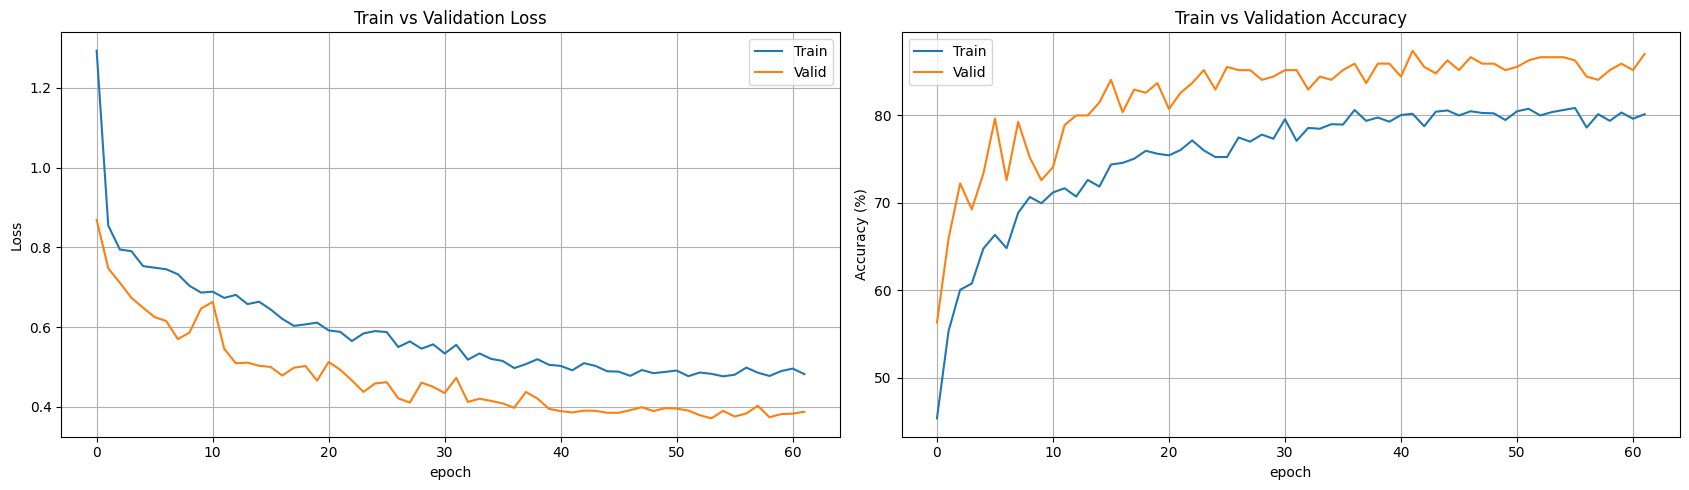

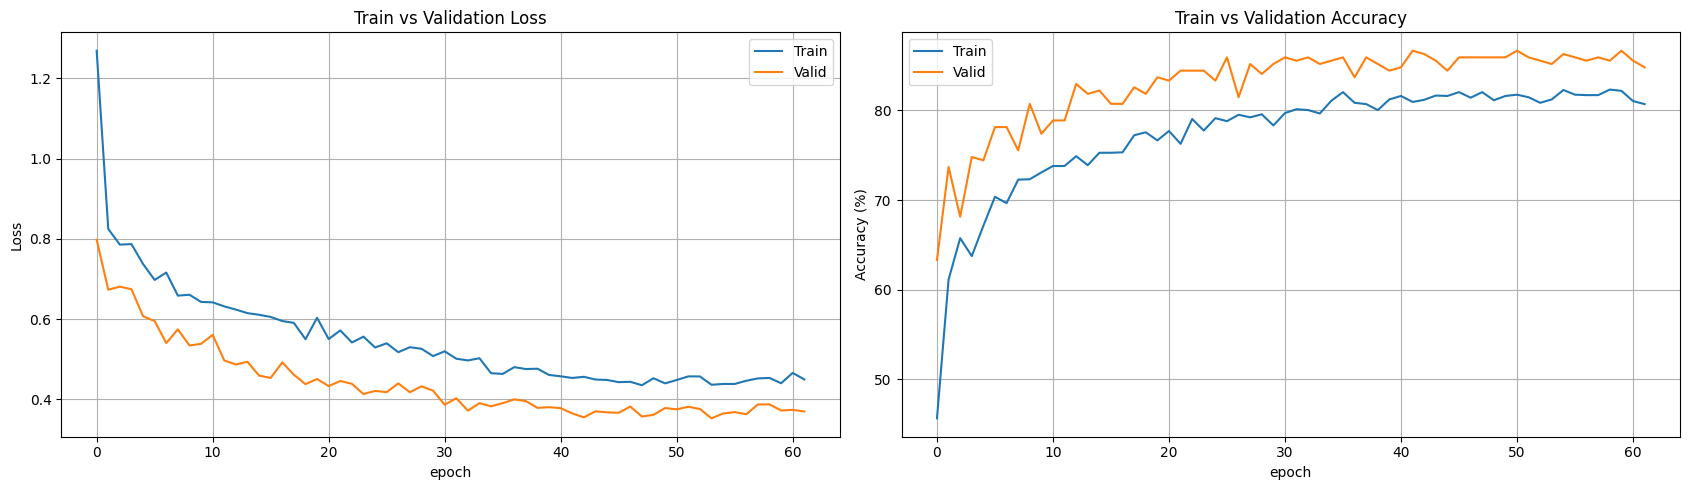

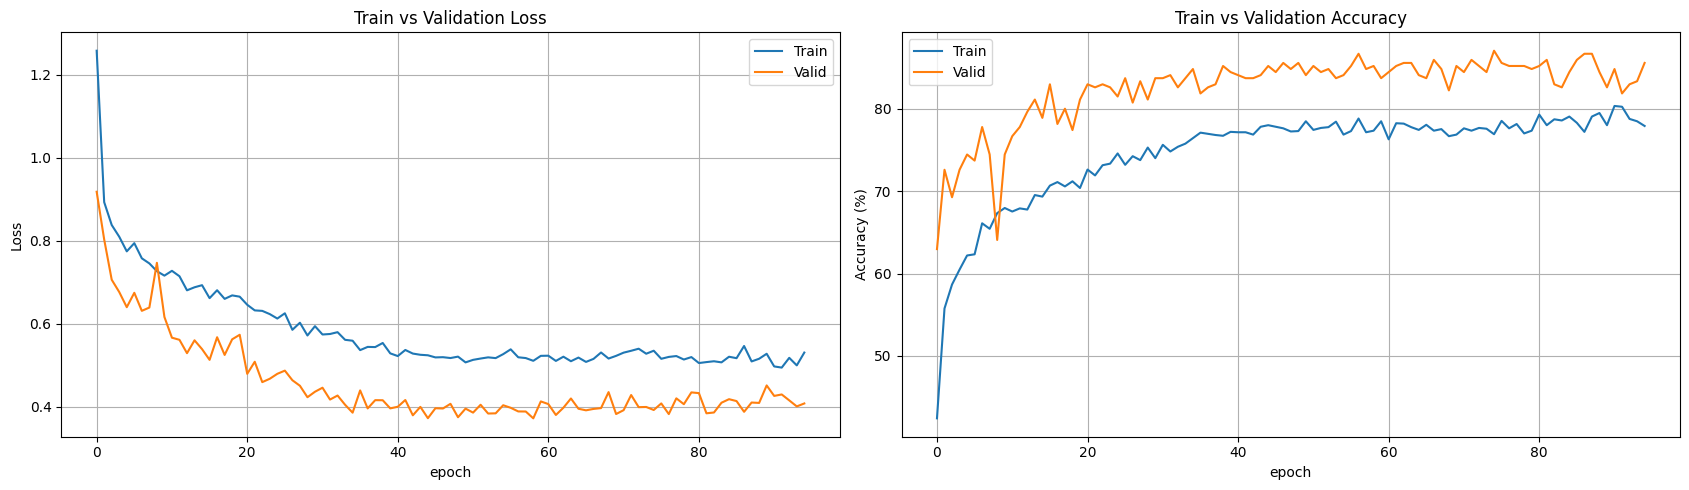

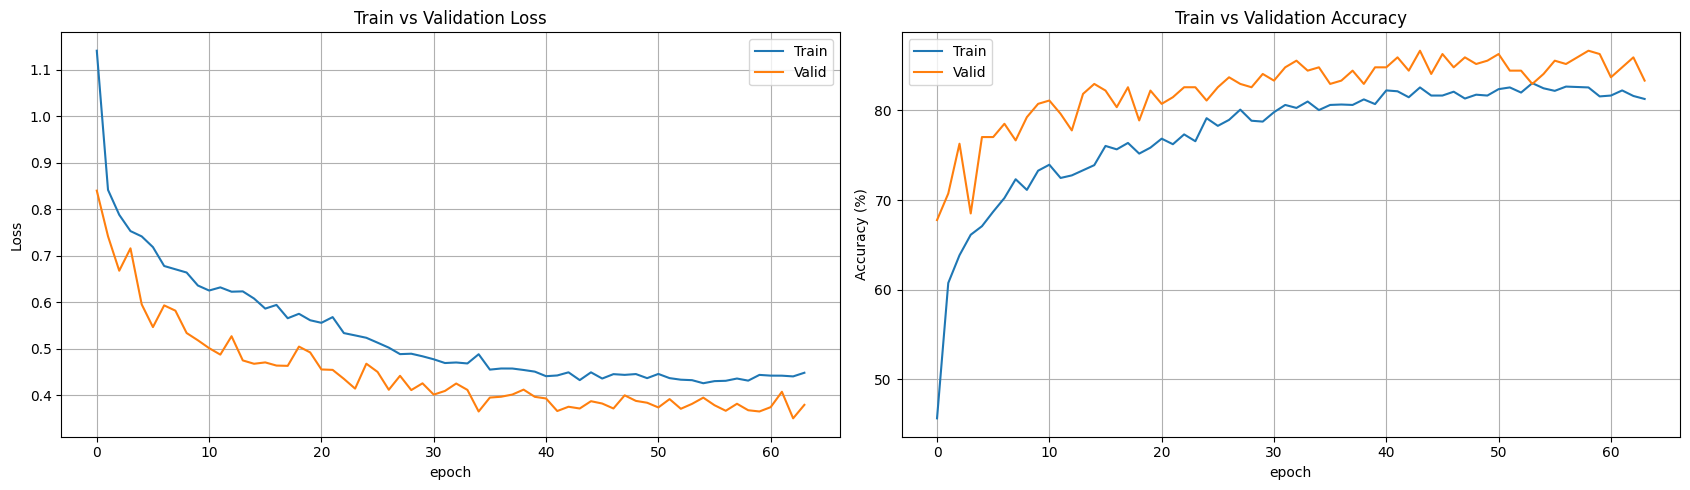

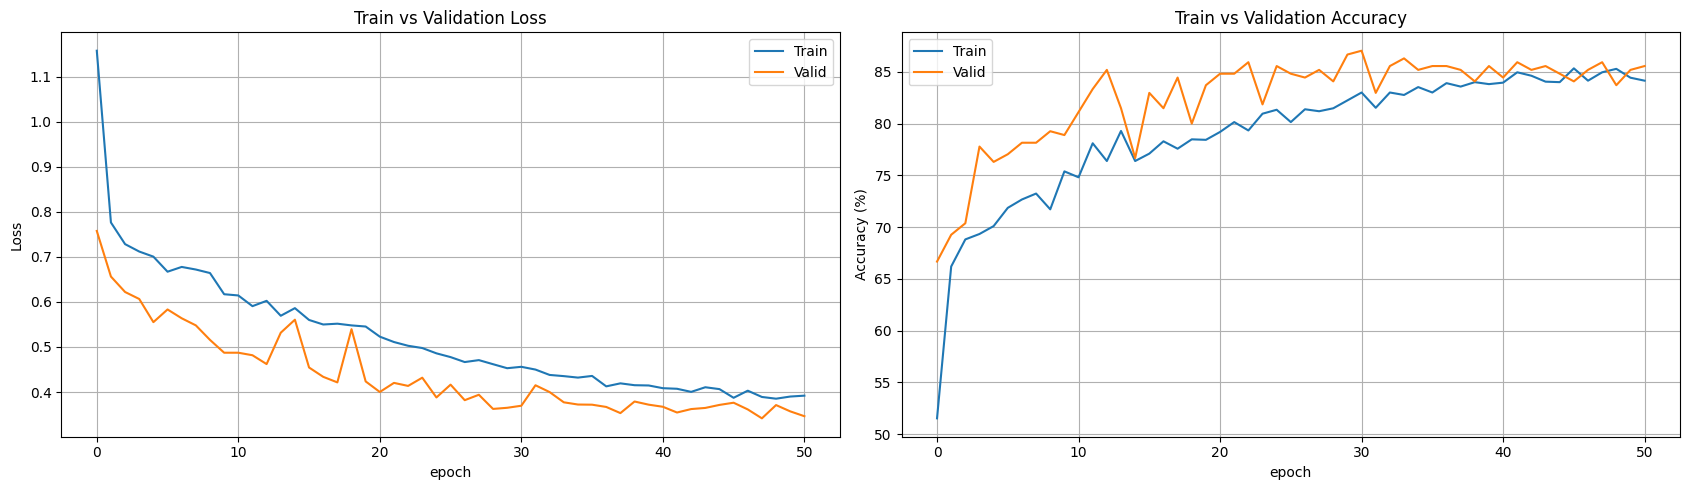

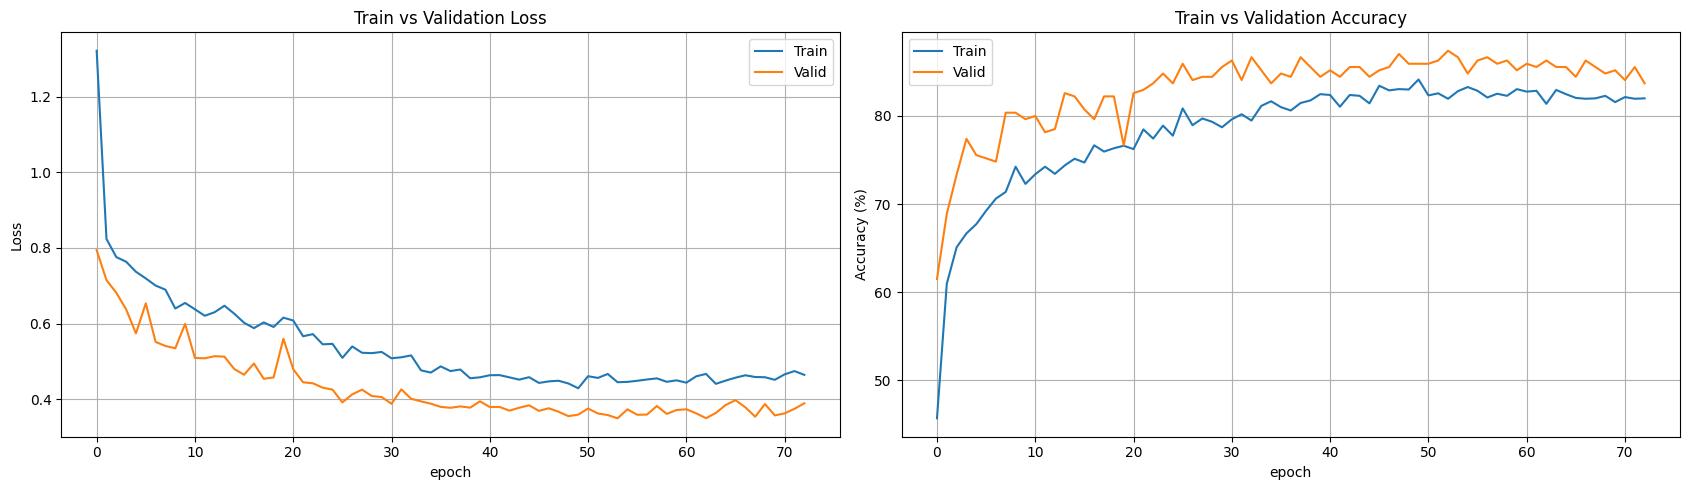

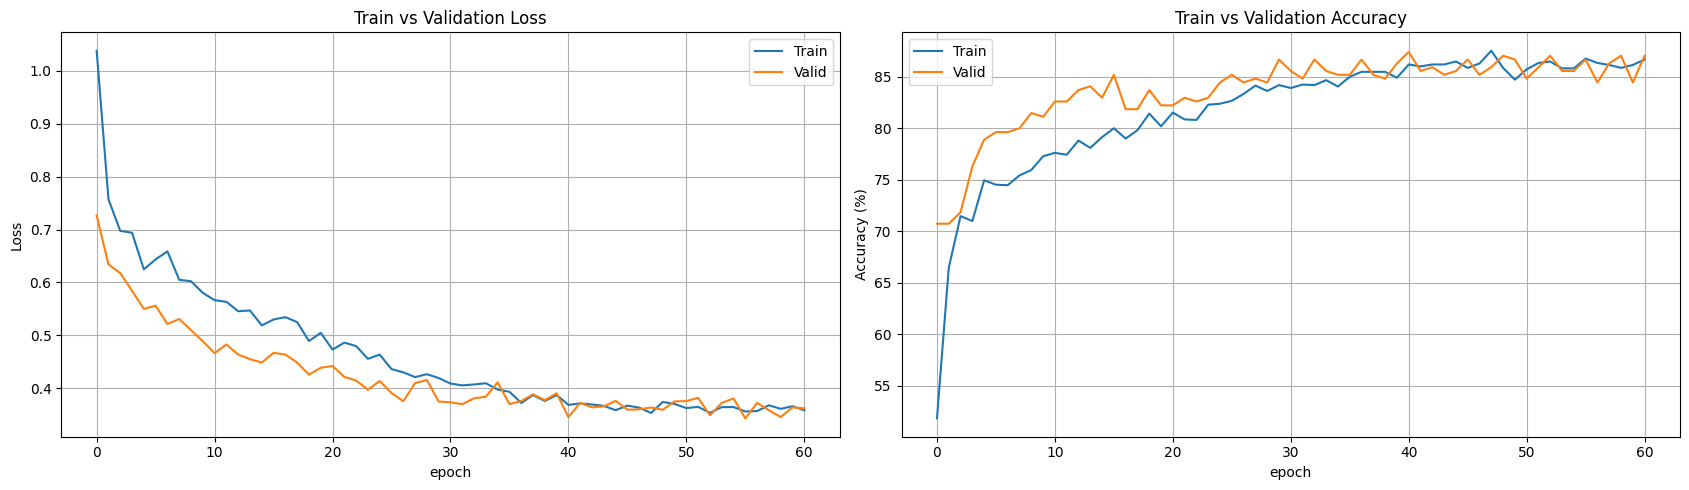

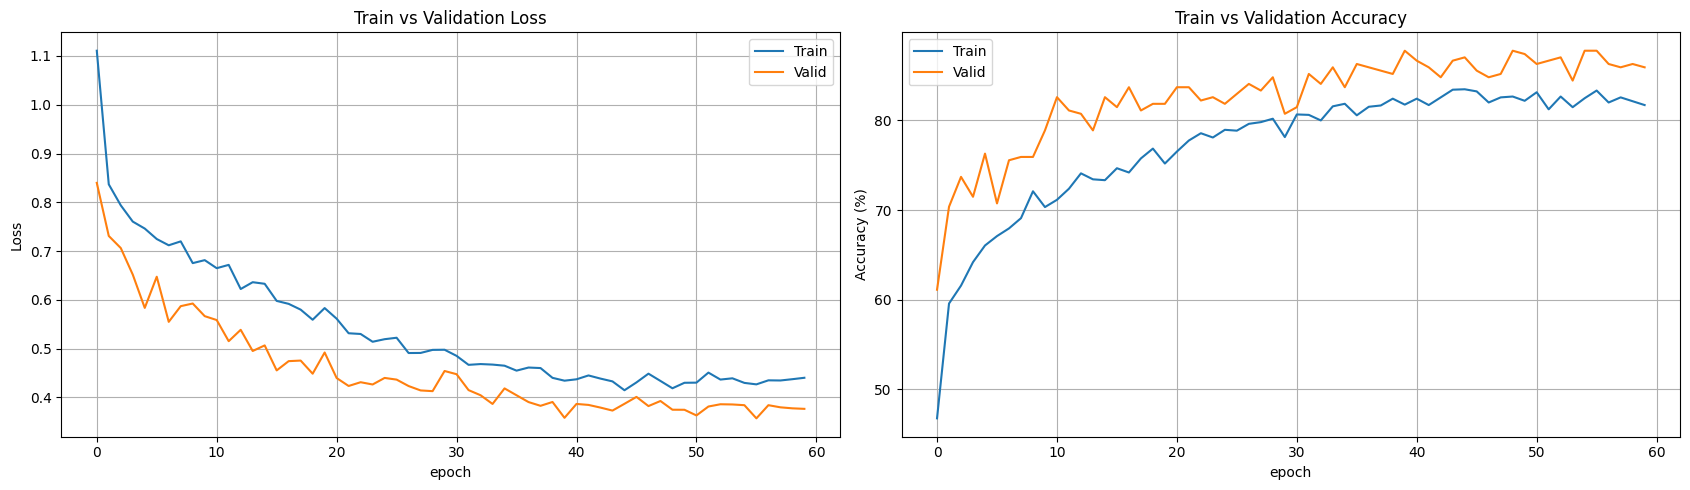

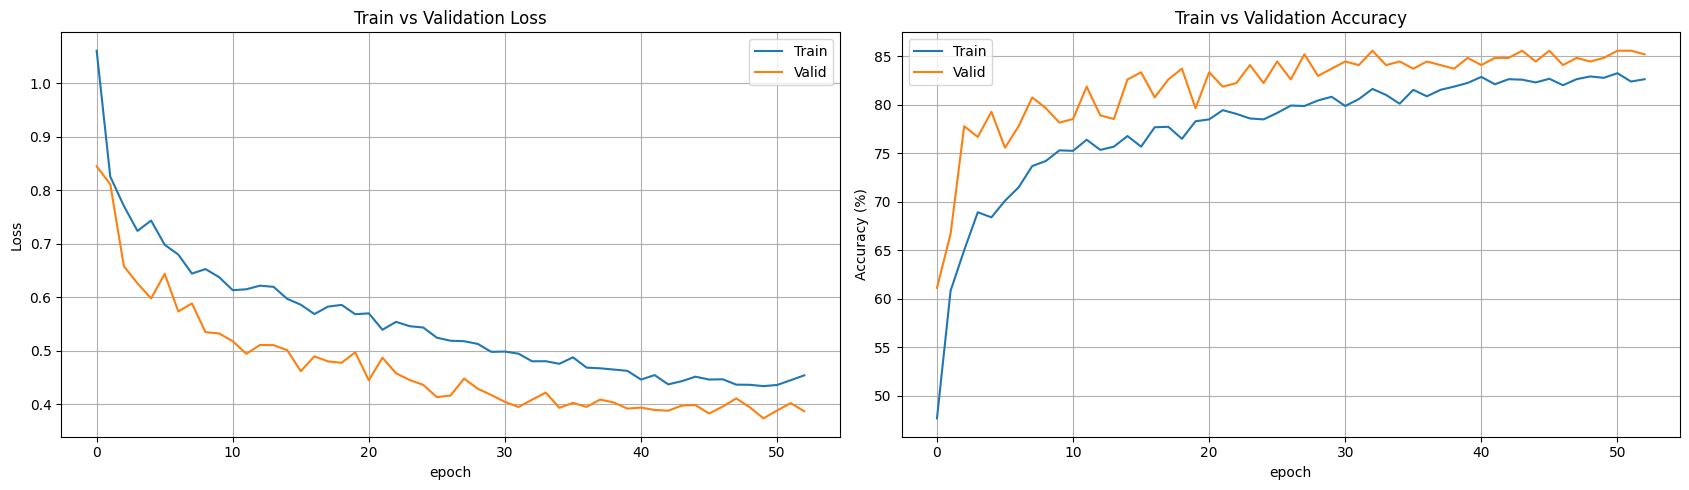

In [ ]:
results = []

for i, combo in enumerate(param_combinations):
    params = dict(zip(param_grid.keys(), combo))
    run_name = f"improved_grid_trial_{i}"
    print(f"\nTraining {run_name} with params: {params}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ImprovedCNN(dropout_rate=params['dropout_fc_rate']).to(device)
    num_epochs = 100
    criterion = nn.CrossEntropyLoss()
    optimizers = {
        "Adam": torch.optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=0),
        "SGD": torch.optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9)
    }
    optimizer = optimizers["Adam"]
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

    train_acc_history = []
    train_loss_history = []
    valid_acc_history = []
    valid_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_valid_acc = 0.0
    best_model_path = f"../models/improved_grid_search/{run_name}.pt"
    patience = 20
    early_stop_counter = 0

    start = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_labels = []
        all_preds = []

        train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, (images, labels) in train_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            train_loss_avg = running_loss / (i + 1)
            train_accuracy = 100 * correct_train / total_train
            train_bar.set_postfix({'loss': f'{train_loss_avg:.3f}', 'acc': f'{train_accuracy:.2f}%'})

        train_f1 = f1_score(all_labels, all_preds, average='macro')
        train_precision = precision_score(all_labels, all_preds, average='macro')
        train_recall = recall_score(all_labels, all_preds, average='macro')
        train_loss_avg = running_loss / len(train_loader)
        train_loss_history.append(train_loss_avg)
        train_acc_history.append(train_accuracy)

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss_avg:.3f}, Train Acc: {train_accuracy:.2f}%, '
            f'Train F1: {train_f1:.3f}, Train Precision: {train_precision:.3f}, Train Recall: {train_recall:.3f}')
        
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            valid_bar = tqdm(valid_loader, total=len(valid_loader), desc="Validation")
            for images, labels in valid_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total_valid += labels.size(0)
                correct_valid += (preds == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

                valid_loss_avg = valid_loss / len(valid_loader)
                valid_accuracy = 100 * correct_valid / total_valid
                valid_bar.set_postfix({'loss': f'{valid_loss_avg:.3f}', 'acc': f'{valid_accuracy:.2f}%'})

        valid_f1 = f1_score(all_labels, all_preds, average='macro')
        valid_precision = precision_score(all_labels, all_preds, average='macro',zero_division=1)
        valid_recall = recall_score(all_labels, all_preds, average='macro',zero_division=1)
        valid_loss_avg = valid_loss / len(valid_loader)
        valid_loss_history.append(valid_loss_avg)
        valid_acc_history.append(valid_accuracy)

        print(f'Epoch {epoch + 1}, Valid Loss: {valid_loss_avg:.3f}, Valid Acc: {valid_accuracy:.2f}%, '
            f'Valid F1: {valid_f1:.3f}, Valid Precision: {valid_precision:.3f}, Valid Recall: {valid_recall:.3f}')
        print("Validation Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

        if valid_accuracy > best_valid_acc:
            best_valid_acc = valid_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved: Valid Accuracy = {best_valid_acc:.2f}%")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stop counter: {early_stop_counter}/{patience}")

        scheduler.step()
        print(f"Current learning rate: {scheduler.get_last_lr()[0]:.6f}")

        if early_stop_counter >= patience:
            print(f"Early stop triggered! No recovery during {patience} epoch.")
            break

    results.append({**params, "run_name": run_name, "valid_acc": best_valid_acc})
    time_elapsed = time.time() - start
    print(f"Training finished after: {time_elapsed:.2f} seconds")

    plt.figure(figsize=(17,5))
    plt.subplot(121)
    plt.plot(train_loss_history)
    plt.plot(valid_loss_history)
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Validation Loss')
    plt.grid()

    plt.subplot(122)
    plt.plot(train_acc_history,)
    plt.plot(valid_acc_history)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Validation Accuracy')
    plt.grid()

    plt.tight_layout()
    plt.savefig(f"../images/{run_name}_training_results.png")

results_df = pd.DataFrame(results).sort_values(by="valid_acc", ascending=False)
results_df.to_csv("improved_grid_search_results.csv", index=False)

In [143]:
results_df

,learning_rate,dropout_fc_rate,run_name,valid_acc
7,0.0005,0.35,improved_grid_trial_7,87.777778
0,0.0010,0.30,improved_grid_trial_0,87.407407
5,0.0007,0.40,improved_grid_trial_5,87.407407
6,0.0005,0.30,improved_grid_trial_6,87.407407
2,0.0010,0.40,improved_grid_trial_2,87.037037
4,0.0007,0.35,improved_grid_trial_4,87.037037
1,0.0010,0.35,improved_grid_trial_1,86.666667
3,0.0007,0.30,improved_grid_trial_3,86.666667
8,0.0005,0.40,improved_grid_trial_8,85.555556


In [144]:
best_run = results_df.iloc[0]
print("\nBest Hyperparameters:")
print(best_run)


Best Hyperparameters:
learning_rate                     0.0005
dropout_fc_rate                     0.35
run_name           improved_grid_trial_7
valid_acc                      87.777778
Name: 7, dtype: object



Training best_model


Epoch 1/100: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, loss=1.078, acc=49.57%]


Epoch 1, Train Loss: 1.078, Train Acc: 49.57%, Train F1: 0.496, Train Precision: 0.497, Train Recall: 0.497


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s, loss=0.783, acc=60.37%]


Epoch 1, Valid Loss: 0.783, Valid Acc: 60.37%, Valid F1: 0.568, Valid Precision: 0.673, Valid Recall: 0.608
Validation Confusion Matrix:
 [[14 77  1]
 [ 5 82  3]
 [ 4 17 67]]
Best model saved: Valid Accuracy = 60.37%
Current learning rate: 0.000500


Epoch 2/100: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=0.826, acc=60.62%]


Epoch 2, Train Loss: 0.826, Train Acc: 60.62%, Train F1: 0.610, Train Precision: 0.615, Train Recall: 0.608


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.14it/s, loss=0.787, acc=65.93%]


Epoch 2, Valid Loss: 0.787, Valid Acc: 65.93%, Valid F1: 0.651, Valid Precision: 0.660, Valid Recall: 0.662
Validation Confusion Matrix:
 [[50 27 15]
 [18 48 24]
 [ 2  6 80]]
Best model saved: Valid Accuracy = 65.93%
Current learning rate: 0.000498


Epoch 3/100: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s, loss=0.768, acc=64.48%]


Epoch 3, Train Loss: 0.768, Train Acc: 64.48%, Train F1: 0.649, Train Precision: 0.653, Train Recall: 0.646


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.81it/s, loss=0.669, acc=74.07%]


Epoch 3, Valid Loss: 0.669, Valid Acc: 74.07%, Valid F1: 0.747, Valid Precision: 0.772, Valid Recall: 0.740
Validation Confusion Matrix:
 [[70 22  0]
 [21 68  1]
 [13 13 62]]
Best model saved: Valid Accuracy = 74.07%
Current learning rate: 0.000496


Epoch 4/100: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s, loss=0.706, acc=70.05%]


Epoch 4, Train Loss: 0.706, Train Acc: 70.05%, Train F1: 0.705, Train Precision: 0.713, Train Recall: 0.701


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.00it/s, loss=0.633, acc=77.04%]


Epoch 4, Valid Loss: 0.633, Valid Acc: 77.04%, Valid F1: 0.775, Valid Precision: 0.787, Valid Recall: 0.770
Validation Confusion Matrix:
 [[74 18  0]
 [23 64  3]
 [10  8 70]]
Best model saved: Valid Accuracy = 77.04%
Current learning rate: 0.000492


Epoch 5/100: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s, loss=0.683, acc=69.95%]


Epoch 5, Train Loss: 0.683, Train Acc: 69.95%, Train F1: 0.704, Train Precision: 0.710, Train Recall: 0.700


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.52it/s, loss=0.571, acc=75.19%]


Epoch 5, Valid Loss: 0.571, Valid Acc: 75.19%, Valid F1: 0.750, Valid Precision: 0.773, Valid Recall: 0.751
Validation Confusion Matrix:
 [[82 10  0]
 [34 50  6]
 [10  7 71]]
Early stop counter: 1/50
Current learning rate: 0.000488


Epoch 6/100: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=0.713, acc=70.57%]


Epoch 6, Train Loss: 0.713, Train Acc: 70.57%, Train F1: 0.709, Train Precision: 0.714, Train Recall: 0.706


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.60it/s, loss=0.564, acc=79.26%]


Epoch 6, Valid Loss: 0.564, Valid Acc: 79.26%, Valid F1: 0.794, Valid Precision: 0.796, Valid Recall: 0.793
Validation Confusion Matrix:
 [[73 16  3]
 [15 68  7]
 [ 4 11 73]]
Best model saved: Valid Accuracy = 79.26%
Current learning rate: 0.000482


Epoch 7/100: 100%|██████████| 66/66 [00:18<00:00,  3.60it/s, loss=0.653, acc=71.86%]


Epoch 7, Train Loss: 0.653, Train Acc: 71.86%, Train F1: 0.722, Train Precision: 0.726, Train Recall: 0.719


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s, loss=0.537, acc=80.37%]


Epoch 7, Valid Loss: 0.537, Valid Acc: 80.37%, Valid F1: 0.808, Valid Precision: 0.820, Valid Recall: 0.804
Validation Confusion Matrix:
 [[73 19  0]
 [14 74  2]
 [ 7 11 70]]
Best model saved: Valid Accuracy = 80.37%
Current learning rate: 0.000476


Epoch 8/100: 100%|██████████| 66/66 [00:17<00:00,  3.77it/s, loss=0.654, acc=73.00%]


Epoch 8, Train Loss: 0.654, Train Acc: 73.00%, Train F1: 0.734, Train Precision: 0.741, Train Recall: 0.730


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.13it/s, loss=0.533, acc=80.74%]


Epoch 8, Valid Loss: 0.533, Valid Acc: 80.74%, Valid F1: 0.811, Valid Precision: 0.824, Valid Recall: 0.807
Validation Confusion Matrix:
 [[76 16  0]
 [14 74  2]
 [ 8 12 68]]
Best model saved: Valid Accuracy = 80.74%
Current learning rate: 0.000469


Epoch 9/100: 100%|██████████| 66/66 [00:17<00:00,  3.80it/s, loss=0.643, acc=74.29%]


Epoch 9, Train Loss: 0.643, Train Acc: 74.29%, Train F1: 0.746, Train Precision: 0.752, Train Recall: 0.743


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s, loss=0.535, acc=78.52%]


Epoch 9, Valid Loss: 0.535, Valid Acc: 78.52%, Valid F1: 0.789, Valid Precision: 0.809, Valid Recall: 0.785
Validation Confusion Matrix:
 [[76 16  0]
 [18 71  1]
 [ 9 14 65]]
Early stop counter: 1/50
Current learning rate: 0.000461


Epoch 10/100: 100%|██████████| 66/66 [00:17<00:00,  3.81it/s, loss=0.609, acc=74.71%]


Epoch 10, Train Loss: 0.609, Train Acc: 74.71%, Train F1: 0.750, Train Precision: 0.756, Train Recall: 0.748


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.06it/s, loss=0.512, acc=82.22%]


Epoch 10, Valid Loss: 0.512, Valid Acc: 82.22%, Valid F1: 0.825, Valid Precision: 0.830, Valid Recall: 0.823
Validation Confusion Matrix:
 [[70 20  2]
 [12 75  3]
 [ 3  8 77]]
Best model saved: Valid Accuracy = 82.22%
Current learning rate: 0.000452


Epoch 11/100: 100%|██████████| 66/66 [00:17<00:00,  3.72it/s, loss=0.612, acc=74.90%]


Epoch 11, Train Loss: 0.612, Train Acc: 74.90%, Train F1: 0.751, Train Precision: 0.754, Train Recall: 0.750


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s, loss=0.498, acc=80.00%]


Epoch 11, Valid Loss: 0.498, Valid Acc: 80.00%, Valid F1: 0.803, Valid Precision: 0.820, Valid Recall: 0.799
Validation Confusion Matrix:
 [[76 16  0]
 [13 75  2]
 [ 9 14 65]]
Early stop counter: 1/50
Current learning rate: 0.000443


Epoch 12/100: 100%|██████████| 66/66 [00:17<00:00,  3.75it/s, loss=0.620, acc=75.29%]


Epoch 12, Train Loss: 0.620, Train Acc: 75.29%, Train F1: 0.756, Train Precision: 0.761, Train Recall: 0.753


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.28it/s, loss=0.481, acc=80.00%]


Epoch 12, Valid Loss: 0.481, Valid Acc: 80.00%, Valid F1: 0.804, Valid Precision: 0.818, Valid Recall: 0.800
Validation Confusion Matrix:
 [[73 19  0]
 [13 75  2]
 [10 10 68]]
Early stop counter: 2/50
Current learning rate: 0.000432


Epoch 13/100: 100%|██████████| 66/66 [00:17<00:00,  3.75it/s, loss=0.589, acc=77.29%]


Epoch 13, Train Loss: 0.589, Train Acc: 77.29%, Train F1: 0.775, Train Precision: 0.778, Train Recall: 0.773


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s, loss=0.525, acc=79.26%]


Epoch 13, Valid Loss: 0.525, Valid Acc: 79.26%, Valid F1: 0.795, Valid Precision: 0.817, Valid Recall: 0.792
Validation Confusion Matrix:
 [[76 16  0]
 [14 75  1]
 [15 10 63]]
Early stop counter: 3/50
Current learning rate: 0.000421


Epoch 14/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.572, acc=77.10%]


Epoch 14, Train Loss: 0.572, Train Acc: 77.10%, Train F1: 0.774, Train Precision: 0.779, Train Recall: 0.771


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s, loss=0.519, acc=82.22%]


Epoch 14, Valid Loss: 0.519, Valid Acc: 82.22%, Valid F1: 0.823, Valid Precision: 0.825, Valid Recall: 0.823
Validation Confusion Matrix:
 [[77 12  3]
 [18 68  4]
 [ 4  7 77]]
Early stop counter: 4/50
Current learning rate: 0.000409


Epoch 15/100: 100%|██████████| 66/66 [00:17<00:00,  3.73it/s, loss=0.587, acc=77.05%]


Epoch 15, Train Loss: 0.587, Train Acc: 77.05%, Train F1: 0.773, Train Precision: 0.776, Train Recall: 0.771


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.31it/s, loss=0.498, acc=82.22%]


Epoch 15, Valid Loss: 0.498, Valid Acc: 82.22%, Valid F1: 0.825, Valid Precision: 0.829, Valid Recall: 0.823
Validation Confusion Matrix:
 [[73 18  1]
 [13 73  4]
 [ 4  8 76]]
Early stop counter: 5/50
Current learning rate: 0.000397


Epoch 16/100: 100%|██████████| 66/66 [00:17<00:00,  3.69it/s, loss=0.561, acc=78.38%]


Epoch 16, Train Loss: 0.561, Train Acc: 78.38%, Train F1: 0.786, Train Precision: 0.789, Train Recall: 0.784


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.29it/s, loss=0.489, acc=81.85%]


Epoch 16, Valid Loss: 0.489, Valid Acc: 81.85%, Valid F1: 0.821, Valid Precision: 0.823, Valid Recall: 0.819
Validation Confusion Matrix:
 [[74 17  1]
 [17 69  4]
 [ 3  7 78]]
Early stop counter: 6/50
Current learning rate: 0.000384


Epoch 17/100: 100%|██████████| 66/66 [00:17<00:00,  3.67it/s, loss=0.555, acc=78.05%]


Epoch 17, Train Loss: 0.555, Train Acc: 78.05%, Train F1: 0.783, Train Precision: 0.786, Train Recall: 0.781


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.15it/s, loss=0.480, acc=81.48%]


Epoch 17, Valid Loss: 0.480, Valid Acc: 81.48%, Valid F1: 0.818, Valid Precision: 0.828, Valid Recall: 0.815
Validation Confusion Matrix:
 [[70 21  1]
 [11 77  2]
 [ 6  9 73]]
Early stop counter: 7/50
Current learning rate: 0.000370


Epoch 18/100: 100%|██████████| 66/66 [00:17<00:00,  3.69it/s, loss=0.547, acc=78.14%]


Epoch 18, Train Loss: 0.547, Train Acc: 78.14%, Train F1: 0.784, Train Precision: 0.787, Train Recall: 0.782


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.81it/s, loss=0.509, acc=80.74%]


Epoch 18, Valid Loss: 0.509, Valid Acc: 80.74%, Valid F1: 0.811, Valid Precision: 0.826, Valid Recall: 0.807
Validation Confusion Matrix:
 [[74 18  0]
 [14 75  1]
 [ 9 10 69]]
Early stop counter: 8/50
Current learning rate: 0.000356


Epoch 19/100: 100%|██████████| 66/66 [00:17<00:00,  3.71it/s, loss=0.549, acc=78.81%]


Epoch 19, Train Loss: 0.549, Train Acc: 78.81%, Train F1: 0.790, Train Precision: 0.792, Train Recall: 0.789


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.40it/s, loss=0.457, acc=81.11%]


Epoch 19, Valid Loss: 0.457, Valid Acc: 81.11%, Valid F1: 0.815, Valid Precision: 0.830, Valid Recall: 0.812
Validation Confusion Matrix:
 [[68 24  0]
 [ 9 78  3]
 [ 4 11 73]]
Early stop counter: 9/50
Current learning rate: 0.000342


Epoch 20/100: 100%|██████████| 66/66 [00:18<00:00,  3.48it/s, loss=0.546, acc=79.24%]


Epoch 20, Train Loss: 0.546, Train Acc: 79.24%, Train F1: 0.795, Train Precision: 0.798, Train Recall: 0.793


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.61it/s, loss=0.473, acc=82.59%]


Epoch 20, Valid Loss: 0.473, Valid Acc: 82.59%, Valid F1: 0.828, Valid Precision: 0.833, Valid Recall: 0.827
Validation Confusion Matrix:
 [[70 20  2]
 [12 75  3]
 [ 3  7 78]]
Best model saved: Valid Accuracy = 82.59%
Current learning rate: 0.000327


Epoch 21/100: 100%|██████████| 66/66 [00:17<00:00,  3.72it/s, loss=0.525, acc=79.33%]


Epoch 21, Train Loss: 0.525, Train Acc: 79.33%, Train F1: 0.795, Train Precision: 0.798, Train Recall: 0.794


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.18it/s, loss=0.459, acc=82.22%]


Epoch 21, Valid Loss: 0.459, Valid Acc: 82.22%, Valid F1: 0.826, Valid Precision: 0.840, Valid Recall: 0.822
Validation Confusion Matrix:
 [[72 20  0]
 [10 78  2]
 [ 4 12 72]]
Early stop counter: 1/50
Current learning rate: 0.000312


Epoch 22/100: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s, loss=0.519, acc=79.43%]


Epoch 22, Train Loss: 0.519, Train Acc: 79.43%, Train F1: 0.796, Train Precision: 0.799, Train Recall: 0.795


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.43it/s, loss=0.456, acc=82.59%]


Epoch 22, Valid Loss: 0.456, Valid Acc: 82.59%, Valid F1: 0.829, Valid Precision: 0.834, Valid Recall: 0.827
Validation Confusion Matrix:
 [[70 21  1]
 [12 75  3]
 [ 3  7 78]]
Early stop counter: 2/50
Current learning rate: 0.000297


Epoch 23/100: 100%|██████████| 66/66 [00:17<00:00,  3.82it/s, loss=0.498, acc=80.71%]


Epoch 23, Train Loss: 0.498, Train Acc: 80.71%, Train F1: 0.809, Train Precision: 0.811, Train Recall: 0.808


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.69it/s, loss=0.434, acc=82.96%]


Epoch 23, Valid Loss: 0.434, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.835, Valid Recall: 0.830
Validation Confusion Matrix:
 [[73 18  1]
 [15 72  3]
 [ 2  7 79]]
Best model saved: Valid Accuracy = 82.96%
Current learning rate: 0.000281


Epoch 24/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.509, acc=79.29%]


Epoch 24, Train Loss: 0.509, Train Acc: 79.29%, Train F1: 0.794, Train Precision: 0.796, Train Recall: 0.793


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.43it/s, loss=0.458, acc=81.48%]


Epoch 24, Valid Loss: 0.458, Valid Acc: 81.48%, Valid F1: 0.816, Valid Precision: 0.825, Valid Recall: 0.816
Validation Confusion Matrix:
 [[64 24  4]
 [ 9 78  3]
 [ 3  7 78]]
Early stop counter: 1/50
Current learning rate: 0.000266


Epoch 25/100: 100%|██████████| 66/66 [00:17<00:00,  3.85it/s, loss=0.494, acc=80.52%]


Epoch 25, Train Loss: 0.494, Train Acc: 80.52%, Train F1: 0.807, Train Precision: 0.811, Train Recall: 0.806


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.44it/s, loss=0.410, acc=84.07%]


Epoch 25, Valid Loss: 0.410, Valid Acc: 84.07%, Valid F1: 0.842, Valid Precision: 0.843, Valid Recall: 0.841
Validation Confusion Matrix:
 [[75 14  3]
 [16 72  2]
 [ 2  6 80]]
Best model saved: Valid Accuracy = 84.07%
Current learning rate: 0.000250


Epoch 26/100: 100%|██████████| 66/66 [00:17<00:00,  3.76it/s, loss=0.492, acc=79.81%]


Epoch 26, Train Loss: 0.492, Train Acc: 79.81%, Train F1: 0.800, Train Precision: 0.801, Train Recall: 0.799


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.441, acc=82.96%]


Epoch 26, Valid Loss: 0.441, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.844, Valid Recall: 0.831
Validation Confusion Matrix:
 [[68 23  1]
 [ 8 80  2]
 [ 4  8 76]]
Early stop counter: 1/50
Current learning rate: 0.000234


Epoch 27/100: 100%|██████████| 66/66 [00:17<00:00,  3.85it/s, loss=0.483, acc=81.95%]


Epoch 27, Train Loss: 0.483, Train Acc: 81.95%, Train F1: 0.821, Train Precision: 0.823, Train Recall: 0.820


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.29it/s, loss=0.397, acc=85.56%]


Epoch 27, Valid Loss: 0.397, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[79 13  0]
 [12 75  3]
 [ 3  8 77]]
Best model saved: Valid Accuracy = 85.56%
Current learning rate: 0.000219


Epoch 28/100: 100%|██████████| 66/66 [00:17<00:00,  3.76it/s, loss=0.487, acc=80.76%]


Epoch 28, Train Loss: 0.487, Train Acc: 80.76%, Train F1: 0.809, Train Precision: 0.810, Train Recall: 0.808


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.19it/s, loss=0.430, acc=83.70%]


Epoch 28, Valid Loss: 0.430, Valid Acc: 83.70%, Valid F1: 0.840, Valid Precision: 0.849, Valid Recall: 0.837
Validation Confusion Matrix:
 [[75 17  0]
 [13 76  1]
 [ 5  8 75]]
Early stop counter: 1/50
Current learning rate: 0.000203


Epoch 29/100: 100%|██████████| 66/66 [00:17<00:00,  3.81it/s, loss=0.484, acc=81.48%]


Epoch 29, Train Loss: 0.484, Train Acc: 81.48%, Train F1: 0.816, Train Precision: 0.818, Train Recall: 0.815


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.42it/s, loss=0.411, acc=82.96%]


Epoch 29, Valid Loss: 0.411, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.838, Valid Recall: 0.830
Validation Confusion Matrix:
 [[73 18  1]
 [12 75  3]
 [ 4  8 76]]
Early stop counter: 2/50
Current learning rate: 0.000188


Epoch 30/100: 100%|██████████| 66/66 [00:17<00:00,  3.80it/s, loss=0.475, acc=80.95%]


Epoch 30, Train Loss: 0.475, Train Acc: 80.95%, Train F1: 0.811, Train Precision: 0.813, Train Recall: 0.810


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.07it/s, loss=0.413, acc=83.70%]


Epoch 30, Valid Loss: 0.413, Valid Acc: 83.70%, Valid F1: 0.837, Valid Precision: 0.837, Valid Recall: 0.838
Validation Confusion Matrix:
 [[74 15  3]
 [14 70  6]
 [ 2  4 82]]
Early stop counter: 3/50
Current learning rate: 0.000173


Epoch 31/100: 100%|██████████| 66/66 [00:17<00:00,  3.84it/s, loss=0.457, acc=82.48%]


Epoch 31, Train Loss: 0.457, Train Acc: 82.48%, Train F1: 0.826, Train Precision: 0.828, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.40it/s, loss=0.398, acc=85.19%]


Epoch 31, Valid Loss: 0.398, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.859, Valid Recall: 0.852
Validation Confusion Matrix:
 [[74 17  1]
 [ 9 78  3]
 [ 3  7 78]]
Early stop counter: 4/50
Current learning rate: 0.000158


Epoch 32/100: 100%|██████████| 66/66 [00:17<00:00,  3.82it/s, loss=0.440, acc=82.10%]


Epoch 32, Train Loss: 0.440, Train Acc: 82.10%, Train F1: 0.823, Train Precision: 0.825, Train Recall: 0.821


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.21it/s, loss=0.394, acc=85.19%]


Epoch 32, Valid Loss: 0.394, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.853, Valid Recall: 0.853
Validation Confusion Matrix:
 [[75 16  1]
 [12 73  5]
 [ 2  4 82]]
Early stop counter: 5/50
Current learning rate: 0.000144


Epoch 33/100: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.448, acc=82.38%]


Epoch 33, Train Loss: 0.448, Train Acc: 82.38%, Train F1: 0.825, Train Precision: 0.826, Train Recall: 0.824


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s, loss=0.408, acc=84.44%]


Epoch 33, Valid Loss: 0.408, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.856, Valid Recall: 0.845
Validation Confusion Matrix:
 [[70 21  1]
 [ 8 80  2]
 [ 3  7 78]]
Early stop counter: 6/50
Current learning rate: 0.000130


Epoch 34/100: 100%|██████████| 66/66 [00:17<00:00,  3.78it/s, loss=0.446, acc=82.71%]


Epoch 34, Train Loss: 0.446, Train Acc: 82.71%, Train F1: 0.828, Train Precision: 0.829, Train Recall: 0.828


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.11it/s, loss=0.394, acc=83.70%]


Epoch 34, Valid Loss: 0.394, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.843, Valid Recall: 0.838
Validation Confusion Matrix:
 [[74 18  0]
 [12 74  4]
 [ 3  7 78]]
Early stop counter: 7/50
Current learning rate: 0.000116


Epoch 35/100: 100%|██████████| 66/66 [00:17<00:00,  3.76it/s, loss=0.438, acc=82.48%]


Epoch 35, Train Loss: 0.438, Train Acc: 82.48%, Train F1: 0.826, Train Precision: 0.828, Train Recall: 0.825


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.39it/s, loss=0.396, acc=86.67%]


Epoch 35, Valid Loss: 0.396, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.869, Valid Recall: 0.867
Validation Confusion Matrix:
 [[77 13  2]
 [11 77  2]
 [ 4  4 80]]
Best model saved: Valid Accuracy = 86.67%
Current learning rate: 0.000103


Epoch 36/100: 100%|██████████| 66/66 [00:17<00:00,  3.74it/s, loss=0.443, acc=82.57%]


Epoch 36, Train Loss: 0.443, Train Acc: 82.57%, Train F1: 0.827, Train Precision: 0.828, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s, loss=0.385, acc=84.07%]


Epoch 36, Valid Loss: 0.385, Valid Acc: 84.07%, Valid F1: 0.843, Valid Precision: 0.848, Valid Recall: 0.841
Validation Confusion Matrix:
 [[74 17  1]
 [13 75  2]
 [ 3  7 78]]
Early stop counter: 1/50
Current learning rate: 0.000091


Epoch 37/100: 100%|██████████| 66/66 [00:17<00:00,  3.79it/s, loss=0.424, acc=83.24%]


Epoch 37, Train Loss: 0.424, Train Acc: 83.24%, Train F1: 0.834, Train Precision: 0.835, Train Recall: 0.833


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.372, acc=85.19%]


Epoch 37, Valid Loss: 0.372, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.857, Valid Recall: 0.852
Validation Confusion Matrix:
 [[75 16  1]
 [11 76  3]
 [ 3  6 79]]
Early stop counter: 2/50
Current learning rate: 0.000079


Epoch 38/100: 100%|██████████| 66/66 [00:17<00:00,  3.78it/s, loss=0.421, acc=83.24%]


Epoch 38, Train Loss: 0.421, Train Acc: 83.24%, Train F1: 0.834, Train Precision: 0.835, Train Recall: 0.833


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.15it/s, loss=0.388, acc=84.81%]


Epoch 38, Valid Loss: 0.388, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.857, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 17  0]
 [11 77  2]
 [ 4  7 77]]
Early stop counter: 3/50
Current learning rate: 0.000068


Epoch 39/100: 100%|██████████| 66/66 [00:17<00:00,  3.76it/s, loss=0.422, acc=83.00%]


Epoch 39, Train Loss: 0.422, Train Acc: 83.00%, Train F1: 0.832, Train Precision: 0.833, Train Recall: 0.831


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.400, acc=85.56%]


Epoch 39, Valid Loss: 0.400, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.866, Valid Recall: 0.856
Validation Confusion Matrix:
 [[72 19  1]
 [ 6 81  3]
 [ 3  7 78]]
Early stop counter: 4/50
Current learning rate: 0.000057


Epoch 40/100: 100%|██████████| 66/66 [00:17<00:00,  3.76it/s, loss=0.404, acc=84.95%]


Epoch 40, Train Loss: 0.404, Train Acc: 84.95%, Train F1: 0.851, Train Precision: 0.854, Train Recall: 0.850


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.14it/s, loss=0.369, acc=85.56%]


Epoch 40, Valid Loss: 0.369, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.862, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 16  0]
 [12 76  2]
 [ 3  6 79]]
Early stop counter: 5/50
Current learning rate: 0.000048


Epoch 41/100: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s, loss=0.406, acc=84.62%]


Epoch 41, Train Loss: 0.406, Train Acc: 84.62%, Train F1: 0.847, Train Precision: 0.848, Train Recall: 0.847


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s, loss=0.373, acc=85.19%]


Epoch 41, Valid Loss: 0.373, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.856, Valid Recall: 0.852
Validation Confusion Matrix:
 [[77 15  0]
 [10 75  5]
 [ 3  7 78]]
Early stop counter: 6/50
Current learning rate: 0.000039


Epoch 42/100: 100%|██████████| 66/66 [00:17<00:00,  3.72it/s, loss=0.416, acc=83.67%]


Epoch 42, Train Loss: 0.416, Train Acc: 83.67%, Train F1: 0.838, Train Precision: 0.840, Train Recall: 0.837


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.07it/s, loss=0.400, acc=85.93%]


Epoch 42, Valid Loss: 0.400, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.866, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 14  1]
 [10 78  2]
 [ 4  7 77]]
Early stop counter: 7/50
Current learning rate: 0.000031


Epoch 43/100: 100%|██████████| 66/66 [00:17<00:00,  3.81it/s, loss=0.406, acc=84.05%]


Epoch 43, Train Loss: 0.406, Train Acc: 84.05%, Train F1: 0.842, Train Precision: 0.843, Train Recall: 0.841


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.32it/s, loss=0.377, acc=86.67%]


Epoch 43, Valid Loss: 0.377, Valid Acc: 86.67%, Valid F1: 0.868, Valid Precision: 0.870, Valid Recall: 0.867
Validation Confusion Matrix:
 [[78 14  0]
 [ 8 77  5]
 [ 3  6 79]]
Early stop counter: 8/50
Current learning rate: 0.000024


Epoch 44/100: 100%|██████████| 66/66 [00:17<00:00,  3.74it/s, loss=0.396, acc=84.95%]


Epoch 44, Train Loss: 0.396, Train Acc: 84.95%, Train F1: 0.851, Train Precision: 0.852, Train Recall: 0.850


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s, loss=0.381, acc=85.93%]


Epoch 44, Valid Loss: 0.381, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.865, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 15  0]
 [10 77  3]
 [ 3  7 78]]
Early stop counter: 9/50
Current learning rate: 0.000018


Epoch 45/100: 100%|██████████| 66/66 [00:18<00:00,  3.64it/s, loss=0.422, acc=83.95%]


Epoch 45, Train Loss: 0.422, Train Acc: 83.95%, Train F1: 0.841, Train Precision: 0.842, Train Recall: 0.840


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.58it/s, loss=0.378, acc=85.93%]


Epoch 45, Valid Loss: 0.378, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.865, Valid Recall: 0.859
Validation Confusion Matrix:
 [[79 13  0]
 [13 75  2]
 [ 4  6 78]]
Early stop counter: 10/50
Current learning rate: 0.000012


Epoch 46/100: 100%|██████████| 66/66 [00:21<00:00,  3.07it/s, loss=0.415, acc=83.86%]


Epoch 46, Train Loss: 0.415, Train Acc: 83.86%, Train F1: 0.840, Train Precision: 0.840, Train Recall: 0.839


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.59it/s, loss=0.375, acc=85.93%]


Epoch 46, Valid Loss: 0.375, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.865, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 15  0]
 [10 77  3]
 [ 3  7 78]]
Early stop counter: 11/50
Current learning rate: 0.000008


Epoch 47/100: 100%|██████████| 66/66 [00:17<00:00,  3.79it/s, loss=0.398, acc=84.14%]


Epoch 47, Train Loss: 0.398, Train Acc: 84.14%, Train F1: 0.842, Train Precision: 0.843, Train Recall: 0.842


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.73it/s, loss=0.382, acc=84.44%]


Epoch 47, Valid Loss: 0.382, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.850, Valid Recall: 0.845
Validation Confusion Matrix:
 [[73 17  2]
 [10 77  3]
 [ 3  7 78]]
Early stop counter: 12/50
Current learning rate: 0.000004


Epoch 48/100: 100%|██████████| 66/66 [00:18<00:00,  3.65it/s, loss=0.408, acc=84.24%]


Epoch 48, Train Loss: 0.408, Train Acc: 84.24%, Train F1: 0.844, Train Precision: 0.845, Train Recall: 0.843


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.31it/s, loss=0.377, acc=86.30%]


Epoch 48, Valid Loss: 0.377, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.869, Valid Recall: 0.863
Validation Confusion Matrix:
 [[78 14  0]
 [10 77  3]
 [ 3  7 78]]
Early stop counter: 13/50
Current learning rate: 0.000002


Epoch 49/100: 100%|██████████| 66/66 [00:17<00:00,  3.74it/s, loss=0.411, acc=83.86%]


Epoch 49, Train Loss: 0.411, Train Acc: 83.86%, Train F1: 0.840, Train Precision: 0.840, Train Recall: 0.839


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.99it/s, loss=0.381, acc=87.78%]


Epoch 49, Valid Loss: 0.381, Valid Acc: 87.78%, Valid F1: 0.879, Valid Precision: 0.881, Valid Recall: 0.878
Validation Confusion Matrix:
 [[79 13  0]
 [ 7 79  4]
 [ 4  5 79]]
Best model saved: Valid Accuracy = 87.78%
Current learning rate: 0.000000


Epoch 50/100: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.402, acc=84.48%]


Epoch 50, Train Loss: 0.402, Train Acc: 84.48%, Train F1: 0.846, Train Precision: 0.848, Train Recall: 0.845


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.25it/s, loss=0.370, acc=87.04%]


Epoch 50, Valid Loss: 0.370, Valid Acc: 87.04%, Valid F1: 0.871, Valid Precision: 0.873, Valid Recall: 0.871
Validation Confusion Matrix:
 [[79 13  0]
 [ 9 76  5]
 [ 3  5 80]]
Early stop counter: 1/50
Current learning rate: 0.000000


Epoch 51/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.397, acc=84.48%]


Epoch 51, Train Loss: 0.397, Train Acc: 84.48%, Train F1: 0.846, Train Precision: 0.848, Train Recall: 0.845


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.90it/s, loss=0.366, acc=85.19%]


Epoch 51, Valid Loss: 0.366, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.856, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 15  1]
 [10 76  4]
 [ 3  7 78]]
Early stop counter: 2/50
Current learning rate: 0.000000


Epoch 52/100: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s, loss=0.407, acc=84.19%]


Epoch 52, Train Loss: 0.407, Train Acc: 84.19%, Train F1: 0.843, Train Precision: 0.845, Train Recall: 0.843


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.67it/s, loss=0.381, acc=86.30%]


Epoch 52, Valid Loss: 0.381, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.872, Valid Recall: 0.863
Validation Confusion Matrix:
 [[76 15  1]
 [ 7 81  2]
 [ 3  9 76]]
Early stop counter: 3/50
Current learning rate: 0.000002


Epoch 53/100: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s, loss=0.413, acc=83.95%]


Epoch 53, Train Loss: 0.413, Train Acc: 83.95%, Train F1: 0.841, Train Precision: 0.842, Train Recall: 0.840


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s, loss=0.388, acc=87.04%]


Epoch 53, Valid Loss: 0.388, Valid Acc: 87.04%, Valid F1: 0.872, Valid Precision: 0.875, Valid Recall: 0.871
Validation Confusion Matrix:
 [[79 13  0]
 [ 8 78  4]
 [ 3  7 78]]
Early stop counter: 4/50
Current learning rate: 0.000004


Epoch 54/100: 100%|██████████| 66/66 [00:19<00:00,  3.45it/s, loss=0.410, acc=84.00%]


Epoch 54, Train Loss: 0.410, Train Acc: 84.00%, Train F1: 0.841, Train Precision: 0.842, Train Recall: 0.841


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.50it/s, loss=0.383, acc=85.56%]


Epoch 54, Valid Loss: 0.383, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.859, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 15  1]
 [10 76  4]
 [ 4  5 79]]
Early stop counter: 5/50
Current learning rate: 0.000008


Epoch 55/100: 100%|██████████| 66/66 [00:19<00:00,  3.32it/s, loss=0.407, acc=84.19%]


Epoch 55, Train Loss: 0.407, Train Acc: 84.19%, Train F1: 0.843, Train Precision: 0.844, Train Recall: 0.843


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.78it/s, loss=0.382, acc=84.81%]


Epoch 55, Valid Loss: 0.382, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.855, Valid Recall: 0.849
Validation Confusion Matrix:
 [[74 17  1]
 [10 77  3]
 [ 3  7 78]]
Early stop counter: 6/50
Current learning rate: 0.000012


Epoch 56/100: 100%|██████████| 66/66 [00:18<00:00,  3.50it/s, loss=0.415, acc=83.67%]


Epoch 56, Train Loss: 0.415, Train Acc: 83.67%, Train F1: 0.838, Train Precision: 0.839, Train Recall: 0.838


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s, loss=0.386, acc=84.81%]


Epoch 56, Valid Loss: 0.386, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.852, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 15  2]
 [10 76  4]
 [ 3  7 78]]
Early stop counter: 7/50
Current learning rate: 0.000018


Epoch 57/100: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s, loss=0.415, acc=85.10%]


Epoch 57, Train Loss: 0.415, Train Acc: 85.10%, Train F1: 0.852, Train Precision: 0.853, Train Recall: 0.852


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.70it/s, loss=0.371, acc=85.56%]


Epoch 57, Valid Loss: 0.371, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[76 15  1]
 [10 77  3]
 [ 3  7 78]]
Early stop counter: 8/50
Current learning rate: 0.000024


Epoch 58/100: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s, loss=0.408, acc=84.38%]


Epoch 58, Train Loss: 0.408, Train Acc: 84.38%, Train F1: 0.845, Train Precision: 0.847, Train Recall: 0.845


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.67it/s, loss=0.382, acc=85.19%]


Epoch 58, Valid Loss: 0.382, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.855, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 14  2]
 [10 76  4]
 [ 3  7 78]]
Early stop counter: 9/50
Current learning rate: 0.000031


Epoch 59/100: 100%|██████████| 66/66 [00:19<00:00,  3.34it/s, loss=0.406, acc=85.14%]


Epoch 59, Train Loss: 0.406, Train Acc: 85.14%, Train F1: 0.852, Train Precision: 0.853, Train Recall: 0.852


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.74it/s, loss=0.366, acc=85.19%]


Epoch 59, Valid Loss: 0.366, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 16  0]
 [10 76  4]
 [ 3  7 78]]
Early stop counter: 10/50
Current learning rate: 0.000039


Epoch 60/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.401, acc=84.57%]


Epoch 60, Train Loss: 0.401, Train Acc: 84.57%, Train F1: 0.847, Train Precision: 0.847, Train Recall: 0.846


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.77it/s, loss=0.387, acc=84.81%]


Epoch 60, Valid Loss: 0.387, Valid Acc: 84.81%, Valid F1: 0.850, Valid Precision: 0.855, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 16  1]
 [10 77  3]
 [ 3  8 77]]
Early stop counter: 11/50
Current learning rate: 0.000048


Epoch 61/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.405, acc=83.57%]


Epoch 61, Train Loss: 0.405, Train Acc: 83.57%, Train F1: 0.837, Train Precision: 0.838, Train Recall: 0.837


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.57it/s, loss=0.389, acc=85.56%]


Epoch 61, Valid Loss: 0.389, Valid Acc: 85.56%, Valid F1: 0.858, Valid Precision: 0.863, Valid Recall: 0.856
Validation Confusion Matrix:
 [[78 14  0]
 [12 76  2]
 [ 3  8 77]]
Early stop counter: 12/50
Current learning rate: 0.000057


Epoch 62/100: 100%|██████████| 66/66 [00:19<00:00,  3.42it/s, loss=0.406, acc=84.38%]


Epoch 62, Train Loss: 0.406, Train Acc: 84.38%, Train F1: 0.845, Train Precision: 0.846, Train Recall: 0.845


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.75it/s, loss=0.361, acc=87.41%]


Epoch 62, Valid Loss: 0.361, Valid Acc: 87.41%, Valid F1: 0.876, Valid Precision: 0.879, Valid Recall: 0.874
Validation Confusion Matrix:
 [[80 12  0]
 [ 9 78  3]
 [ 3  7 78]]
Early stop counter: 13/50
Current learning rate: 0.000068


Epoch 63/100: 100%|██████████| 66/66 [00:19<00:00,  3.45it/s, loss=0.410, acc=84.29%]


Epoch 63, Train Loss: 0.410, Train Acc: 84.29%, Train F1: 0.844, Train Precision: 0.846, Train Recall: 0.844


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.76it/s, loss=0.377, acc=84.44%]


Epoch 63, Valid Loss: 0.377, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.855, Valid Recall: 0.845
Validation Confusion Matrix:
 [[74 18  0]
 [ 9 78  3]
 [ 3  9 76]]
Early stop counter: 14/50
Current learning rate: 0.000079


Epoch 64/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.415, acc=82.62%]


Epoch 64, Train Loss: 0.415, Train Acc: 82.62%, Train F1: 0.827, Train Precision: 0.828, Train Recall: 0.827


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.69it/s, loss=0.367, acc=87.41%]


Epoch 64, Valid Loss: 0.367, Valid Acc: 87.41%, Valid F1: 0.876, Valid Precision: 0.882, Valid Recall: 0.874
Validation Confusion Matrix:
 [[79 13  0]
 [ 9 80  1]
 [ 5  6 77]]
Early stop counter: 15/50
Current learning rate: 0.000091


Epoch 65/100: 100%|██████████| 66/66 [00:19<00:00,  3.44it/s, loss=0.408, acc=83.86%]


Epoch 65, Train Loss: 0.408, Train Acc: 83.86%, Train F1: 0.840, Train Precision: 0.841, Train Recall: 0.839


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.78it/s, loss=0.383, acc=85.93%]


Epoch 65, Valid Loss: 0.383, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.866, Valid Recall: 0.860
Validation Confusion Matrix:
 [[76 16  0]
 [10 77  3]
 [ 2  7 79]]
Early stop counter: 16/50
Current learning rate: 0.000103


Epoch 66/100: 100%|██████████| 66/66 [00:19<00:00,  3.44it/s, loss=0.407, acc=84.48%]


Epoch 66, Train Loss: 0.407, Train Acc: 84.48%, Train F1: 0.846, Train Precision: 0.847, Train Recall: 0.846


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.67it/s, loss=0.374, acc=84.81%]


Epoch 66, Valid Loss: 0.374, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.857, Valid Recall: 0.849
Validation Confusion Matrix:
 [[75 17  0]
 [10 77  3]
 [ 3  8 77]]
Early stop counter: 17/50
Current learning rate: 0.000116


Epoch 67/100: 100%|██████████| 66/66 [00:18<00:00,  3.48it/s, loss=0.400, acc=84.48%]


Epoch 67, Train Loss: 0.400, Train Acc: 84.48%, Train F1: 0.846, Train Precision: 0.847, Train Recall: 0.846


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.77it/s, loss=0.393, acc=85.19%]


Epoch 67, Valid Loss: 0.393, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 16  0]
 [ 8 77  5]
 [ 3  8 77]]
Early stop counter: 18/50
Current learning rate: 0.000130


Epoch 68/100: 100%|██████████| 66/66 [00:19<00:00,  3.43it/s, loss=0.407, acc=84.05%]


Epoch 68, Train Loss: 0.407, Train Acc: 84.05%, Train F1: 0.842, Train Precision: 0.842, Train Recall: 0.841


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.76it/s, loss=0.378, acc=85.93%]


Epoch 68, Valid Loss: 0.378, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.864, Valid Recall: 0.860
Validation Confusion Matrix:
 [[77 15  0]
 [ 9 77  4]
 [ 4  6 78]]
Early stop counter: 19/50
Current learning rate: 0.000144


Epoch 69/100: 100%|██████████| 66/66 [00:19<00:00,  3.33it/s, loss=0.434, acc=83.57%]


Epoch 69, Train Loss: 0.434, Train Acc: 83.57%, Train F1: 0.837, Train Precision: 0.838, Train Recall: 0.836


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.54it/s, loss=0.390, acc=84.81%]


Epoch 69, Valid Loss: 0.390, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.860, Valid Recall: 0.849
Validation Confusion Matrix:
 [[71 21  0]
 [ 9 79  2]
 [ 2  7 79]]
Early stop counter: 20/50
Current learning rate: 0.000158


Epoch 70/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.411, acc=83.38%]


Epoch 70, Train Loss: 0.411, Train Acc: 83.38%, Train F1: 0.835, Train Precision: 0.837, Train Recall: 0.835


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s, loss=0.379, acc=84.81%]


Epoch 70, Valid Loss: 0.379, Valid Acc: 84.81%, Valid F1: 0.851, Valid Precision: 0.856, Valid Recall: 0.849
Validation Confusion Matrix:
 [[73 19  0]
 [11 77  2]
 [ 3  6 79]]
Early stop counter: 21/50
Current learning rate: 0.000173


Epoch 71/100: 100%|██████████| 66/66 [00:19<00:00,  3.40it/s, loss=0.407, acc=83.52%]


Epoch 71, Train Loss: 0.407, Train Acc: 83.52%, Train F1: 0.836, Train Precision: 0.837, Train Recall: 0.836


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.56it/s, loss=0.381, acc=86.30%]


Epoch 71, Valid Loss: 0.381, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.869, Valid Recall: 0.863
Validation Confusion Matrix:
 [[77 15  0]
 [10 78  2]
 [ 5  5 78]]
Early stop counter: 22/50
Current learning rate: 0.000188


Epoch 72/100: 100%|██████████| 66/66 [00:20<00:00,  3.20it/s, loss=0.409, acc=83.43%]


Epoch 72, Train Loss: 0.409, Train Acc: 83.43%, Train F1: 0.836, Train Precision: 0.837, Train Recall: 0.835


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.74it/s, loss=0.386, acc=84.44%]


Epoch 72, Valid Loss: 0.386, Valid Acc: 84.44%, Valid F1: 0.845, Valid Precision: 0.846, Valid Recall: 0.845
Validation Confusion Matrix:
 [[74 14  4]
 [12 75  3]
 [ 4  5 79]]
Early stop counter: 23/50
Current learning rate: 0.000203


Epoch 73/100: 100%|██████████| 66/66 [00:19<00:00,  3.46it/s, loss=0.416, acc=82.38%]


Epoch 73, Train Loss: 0.416, Train Acc: 82.38%, Train F1: 0.825, Train Precision: 0.825, Train Recall: 0.825


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.05it/s, loss=0.381, acc=86.30%]


Epoch 73, Valid Loss: 0.381, Valid Acc: 86.30%, Valid F1: 0.864, Valid Precision: 0.867, Valid Recall: 0.863
Validation Confusion Matrix:
 [[77 14  1]
 [10 77  3]
 [ 4  5 79]]
Early stop counter: 24/50
Current learning rate: 0.000219


Epoch 74/100: 100%|██████████| 66/66 [00:19<00:00,  3.46it/s, loss=0.412, acc=83.67%]


Epoch 74, Train Loss: 0.412, Train Acc: 83.67%, Train F1: 0.838, Train Precision: 0.839, Train Recall: 0.837


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.39it/s, loss=0.366, acc=86.30%]


Epoch 74, Valid Loss: 0.366, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.867, Valid Recall: 0.863
Validation Confusion Matrix:
 [[78 14  0]
 [11 76  3]
 [ 4  5 79]]
Early stop counter: 25/50
Current learning rate: 0.000234


Epoch 75/100: 100%|██████████| 66/66 [00:17<00:00,  3.71it/s, loss=0.419, acc=82.52%]


Epoch 75, Train Loss: 0.419, Train Acc: 82.52%, Train F1: 0.827, Train Precision: 0.828, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.34it/s, loss=0.410, acc=85.19%]


Epoch 75, Valid Loss: 0.410, Valid Acc: 85.19%, Valid F1: 0.852, Valid Precision: 0.856, Valid Recall: 0.853
Validation Confusion Matrix:
 [[71 17  4]
 [ 7 79  4]
 [ 3  5 80]]
Early stop counter: 26/50
Current learning rate: 0.000250


Epoch 76/100: 100%|██████████| 66/66 [00:17<00:00,  3.72it/s, loss=0.415, acc=82.90%]


Epoch 76, Train Loss: 0.415, Train Acc: 82.90%, Train F1: 0.830, Train Precision: 0.832, Train Recall: 0.830


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.73it/s, loss=0.399, acc=82.96%]


Epoch 76, Valid Loss: 0.399, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.841, Valid Recall: 0.830
Validation Confusion Matrix:
 [[80 12  0]
 [19 69  2]
 [ 7  6 75]]
Early stop counter: 27/50
Current learning rate: 0.000266


Epoch 77/100: 100%|██████████| 66/66 [00:17<00:00,  3.72it/s, loss=0.412, acc=82.86%]


Epoch 77, Train Loss: 0.412, Train Acc: 82.86%, Train F1: 0.830, Train Precision: 0.830, Train Recall: 0.829


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.36it/s, loss=0.451, acc=84.44%]


Epoch 77, Valid Loss: 0.451, Valid Acc: 84.44%, Valid F1: 0.843, Valid Precision: 0.847, Valid Recall: 0.846
Validation Confusion Matrix:
 [[68 16  8]
 [ 7 76  7]
 [ 2  2 84]]
Early stop counter: 28/50
Current learning rate: 0.000281


Epoch 78/100: 100%|██████████| 66/66 [00:18<00:00,  3.55it/s, loss=0.428, acc=82.14%]


Epoch 78, Train Loss: 0.428, Train Acc: 82.14%, Train F1: 0.823, Train Precision: 0.825, Train Recall: 0.822


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.81it/s, loss=0.380, acc=84.07%]


Epoch 78, Valid Loss: 0.380, Valid Acc: 84.07%, Valid F1: 0.842, Valid Precision: 0.842, Valid Recall: 0.841
Validation Confusion Matrix:
 [[75 15  2]
 [11 73  6]
 [ 3  6 79]]
Early stop counter: 29/50
Current learning rate: 0.000297


Epoch 79/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.411, acc=83.62%]


Epoch 79, Train Loss: 0.411, Train Acc: 83.62%, Train F1: 0.837, Train Precision: 0.838, Train Recall: 0.837


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.400, acc=85.56%]


Epoch 79, Valid Loss: 0.400, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.859, Valid Recall: 0.856
Validation Confusion Matrix:
 [[78 13  1]
 [13 74  3]
 [ 4  5 79]]
Early stop counter: 30/50
Current learning rate: 0.000312


Epoch 80/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.405, acc=83.95%]


Epoch 80, Train Loss: 0.405, Train Acc: 83.95%, Train F1: 0.841, Train Precision: 0.843, Train Recall: 0.840


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.35it/s, loss=0.419, acc=84.44%]


Epoch 80, Valid Loss: 0.419, Valid Acc: 84.44%, Valid F1: 0.845, Valid Precision: 0.849, Valid Recall: 0.846
Validation Confusion Matrix:
 [[70 18  4]
 [ 6 77  7]
 [ 2  5 81]]
Early stop counter: 31/50
Current learning rate: 0.000327


Epoch 81/100: 100%|██████████| 66/66 [00:18<00:00,  3.48it/s, loss=0.431, acc=83.62%]


Epoch 81, Train Loss: 0.431, Train Acc: 83.62%, Train F1: 0.837, Train Precision: 0.839, Train Recall: 0.837


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.37it/s, loss=0.386, acc=85.93%]


Epoch 81, Valid Loss: 0.386, Valid Acc: 85.93%, Valid F1: 0.862, Valid Precision: 0.867, Valid Recall: 0.859
Validation Confusion Matrix:
 [[80 12  0]
 [15 74  1]
 [ 4  6 78]]
Early stop counter: 32/50
Current learning rate: 0.000342


Epoch 82/100: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s, loss=0.415, acc=83.00%]


Epoch 82, Train Loss: 0.415, Train Acc: 83.00%, Train F1: 0.831, Train Precision: 0.832, Train Recall: 0.831


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.37it/s, loss=0.421, acc=84.81%]


Epoch 82, Valid Loss: 0.421, Valid Acc: 84.81%, Valid F1: 0.848, Valid Precision: 0.850, Valid Recall: 0.850
Validation Confusion Matrix:
 [[69 18  5]
 [ 8 77  5]
 [ 3  2 83]]
Early stop counter: 33/50
Current learning rate: 0.000356


Epoch 83/100: 100%|██████████| 66/66 [00:18<00:00,  3.51it/s, loss=0.424, acc=83.71%]


Epoch 83, Train Loss: 0.424, Train Acc: 83.71%, Train F1: 0.838, Train Precision: 0.838, Train Recall: 0.838


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.33it/s, loss=0.396, acc=83.70%]


Epoch 83, Valid Loss: 0.396, Valid Acc: 83.70%, Valid F1: 0.839, Valid Precision: 0.846, Valid Recall: 0.838
Validation Confusion Matrix:
 [[71 20  1]
 [ 7 79  4]
 [ 5  7 76]]
Early stop counter: 34/50
Current learning rate: 0.000370


Epoch 84/100: 100%|██████████| 66/66 [00:18<00:00,  3.52it/s, loss=0.427, acc=83.10%]


Epoch 84, Train Loss: 0.427, Train Acc: 83.10%, Train F1: 0.832, Train Precision: 0.834, Train Recall: 0.832


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.31it/s, loss=0.384, acc=85.19%]


Epoch 84, Valid Loss: 0.384, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 16  0]
 [11 76  3]
 [ 4  6 78]]
Early stop counter: 35/50
Current learning rate: 0.000384


Epoch 85/100: 100%|██████████| 66/66 [00:20<00:00,  3.23it/s, loss=0.432, acc=82.67%]


Epoch 85, Train Loss: 0.432, Train Acc: 82.67%, Train F1: 0.828, Train Precision: 0.830, Train Recall: 0.827


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.63it/s, loss=0.359, acc=85.56%]


Epoch 85, Valid Loss: 0.359, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.860, Valid Recall: 0.856
Validation Confusion Matrix:
 [[78 14  0]
 [13 74  3]
 [ 4  5 79]]
Early stop counter: 36/50
Current learning rate: 0.000397


Epoch 86/100: 100%|██████████| 66/66 [00:23<00:00,  2.86it/s, loss=0.429, acc=83.19%]


Epoch 86, Train Loss: 0.429, Train Acc: 83.19%, Train F1: 0.833, Train Precision: 0.834, Train Recall: 0.833


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.04it/s, loss=0.410, acc=85.19%]


Epoch 86, Valid Loss: 0.410, Valid Acc: 85.19%, Valid F1: 0.852, Valid Precision: 0.852, Valid Recall: 0.852
Validation Confusion Matrix:
 [[78 12  2]
 [14 70  6]
 [ 3  3 82]]
Early stop counter: 37/50
Current learning rate: 0.000409


Epoch 87/100: 100%|██████████| 66/66 [00:21<00:00,  3.08it/s, loss=0.411, acc=83.86%]


Epoch 87, Train Loss: 0.411, Train Acc: 83.86%, Train F1: 0.840, Train Precision: 0.840, Train Recall: 0.839


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.76it/s, loss=0.374, acc=84.07%]


Epoch 87, Valid Loss: 0.374, Valid Acc: 84.07%, Valid F1: 0.840, Valid Precision: 0.840, Valid Recall: 0.841
Validation Confusion Matrix:
 [[78 11  3]
 [13 69  8]
 [ 3  5 80]]
Early stop counter: 38/50
Current learning rate: 0.000421


Epoch 88/100: 100%|██████████| 66/66 [00:20<00:00,  3.29it/s, loss=0.417, acc=83.52%]


Epoch 88, Train Loss: 0.417, Train Acc: 83.52%, Train F1: 0.837, Train Precision: 0.838, Train Recall: 0.836


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s, loss=0.407, acc=84.07%]


Epoch 88, Valid Loss: 0.407, Valid Acc: 84.07%, Valid F1: 0.844, Valid Precision: 0.858, Valid Recall: 0.841
Validation Confusion Matrix:
 [[72 20  0]
 [ 7 81  2]
 [ 3 11 74]]
Early stop counter: 39/50
Current learning rate: 0.000432


Epoch 89/100: 100%|██████████| 66/66 [00:19<00:00,  3.40it/s, loss=0.442, acc=82.19%]


Epoch 89, Train Loss: 0.442, Train Acc: 82.19%, Train F1: 0.823, Train Precision: 0.825, Train Recall: 0.823


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.79it/s, loss=0.367, acc=85.19%]


Epoch 89, Valid Loss: 0.367, Valid Acc: 85.19%, Valid F1: 0.853, Valid Precision: 0.854, Valid Recall: 0.852
Validation Confusion Matrix:
 [[77 14  1]
 [10 74  6]
 [ 3  6 79]]
Early stop counter: 40/50
Current learning rate: 0.000443


Epoch 90/100: 100%|██████████| 66/66 [00:17<00:00,  3.77it/s, loss=0.443, acc=82.00%]


Epoch 90, Train Loss: 0.443, Train Acc: 82.00%, Train F1: 0.821, Train Precision: 0.821, Train Recall: 0.821


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.17it/s, loss=0.374, acc=85.93%]


Epoch 90, Valid Loss: 0.374, Valid Acc: 85.93%, Valid F1: 0.861, Valid Precision: 0.865, Valid Recall: 0.859
Validation Confusion Matrix:
 [[80 12  0]
 [14 74  2]
 [ 3  7 78]]
Early stop counter: 41/50
Current learning rate: 0.000452


Epoch 91/100: 100%|██████████| 66/66 [00:18<00:00,  3.58it/s, loss=0.412, acc=83.19%]


Epoch 91, Train Loss: 0.412, Train Acc: 83.19%, Train F1: 0.833, Train Precision: 0.834, Train Recall: 0.833


Validation: 100%|██████████| 9/9 [00:01<00:00,  7.00it/s, loss=0.447, acc=84.44%]


Epoch 91, Valid Loss: 0.447, Valid Acc: 84.44%, Valid F1: 0.847, Valid Precision: 0.851, Valid Recall: 0.845
Validation Confusion Matrix:
 [[78 14  0]
 [13 74  3]
 [ 5  7 76]]
Early stop counter: 42/50
Current learning rate: 0.000461


Epoch 92/100: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s, loss=0.402, acc=84.43%]


Epoch 92, Train Loss: 0.402, Train Acc: 84.43%, Train F1: 0.845, Train Precision: 0.846, Train Recall: 0.845


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.82it/s, loss=0.393, acc=87.04%]


Epoch 92, Valid Loss: 0.393, Valid Acc: 87.04%, Valid F1: 0.871, Valid Precision: 0.873, Valid Recall: 0.871
Validation Confusion Matrix:
 [[81 11  0]
 [12 74  4]
 [ 3  5 80]]
Early stop counter: 43/50
Current learning rate: 0.000469


Epoch 93/100: 100%|██████████| 66/66 [00:20<00:00,  3.25it/s, loss=0.420, acc=82.48%]


Epoch 93, Train Loss: 0.420, Train Acc: 82.48%, Train F1: 0.826, Train Precision: 0.826, Train Recall: 0.826


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s, loss=0.359, acc=85.56%]


Epoch 93, Valid Loss: 0.359, Valid Acc: 85.56%, Valid F1: 0.857, Valid Precision: 0.861, Valid Recall: 0.856
Validation Confusion Matrix:
 [[79 13  0]
 [12 75  3]
 [ 4  7 77]]
Early stop counter: 44/50
Current learning rate: 0.000476


Epoch 94/100: 100%|██████████| 66/66 [00:20<00:00,  3.22it/s, loss=0.432, acc=83.52%]


Epoch 94, Train Loss: 0.432, Train Acc: 83.52%, Train F1: 0.836, Train Precision: 0.839, Train Recall: 0.836


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.48it/s, loss=0.400, acc=84.81%]


Epoch 94, Valid Loss: 0.400, Valid Acc: 84.81%, Valid F1: 0.849, Valid Precision: 0.850, Valid Recall: 0.849
Validation Confusion Matrix:
 [[78 12  2]
 [15 71  4]
 [ 3  5 80]]
Early stop counter: 45/50
Current learning rate: 0.000482


Epoch 95/100: 100%|██████████| 66/66 [00:19<00:00,  3.31it/s, loss=0.416, acc=83.29%]


Epoch 95, Train Loss: 0.416, Train Acc: 83.29%, Train F1: 0.834, Train Precision: 0.836, Train Recall: 0.833


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.84it/s, loss=0.437, acc=82.96%]


Epoch 95, Valid Loss: 0.437, Valid Acc: 82.96%, Valid F1: 0.832, Valid Precision: 0.844, Valid Recall: 0.831
Validation Confusion Matrix:
 [[67 25  0]
 [ 7 79  4]
 [ 3  7 78]]
Early stop counter: 46/50
Current learning rate: 0.000488


Epoch 96/100: 100%|██████████| 66/66 [00:20<00:00,  3.17it/s, loss=0.409, acc=83.62%]


Epoch 96, Train Loss: 0.409, Train Acc: 83.62%, Train F1: 0.837, Train Precision: 0.838, Train Recall: 0.837


Validation: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s, loss=0.408, acc=84.44%]


Epoch 96, Valid Loss: 0.408, Valid Acc: 84.44%, Valid F1: 0.846, Valid Precision: 0.849, Valid Recall: 0.845
Validation Confusion Matrix:
 [[78 14  0]
 [16 71  3]
 [ 4  5 79]]
Early stop counter: 47/50
Current learning rate: 0.000492


Epoch 97/100: 100%|██████████| 66/66 [00:19<00:00,  3.47it/s, loss=0.403, acc=84.24%]


Epoch 97, Train Loss: 0.403, Train Acc: 84.24%, Train F1: 0.843, Train Precision: 0.844, Train Recall: 0.843


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.97it/s, loss=0.392, acc=82.22%]


Epoch 97, Valid Loss: 0.392, Valid Acc: 82.22%, Valid F1: 0.822, Valid Precision: 0.822, Valid Recall: 0.823
Validation Confusion Matrix:
 [[75 13  4]
 [15 67  8]
 [ 4  4 80]]
Early stop counter: 48/50
Current learning rate: 0.000496


Epoch 98/100: 100%|██████████| 66/66 [00:21<00:00,  3.08it/s, loss=0.408, acc=83.67%]


Epoch 98, Train Loss: 0.408, Train Acc: 83.67%, Train F1: 0.838, Train Precision: 0.840, Train Recall: 0.837


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.80it/s, loss=0.364, acc=86.30%]


Epoch 98, Valid Loss: 0.364, Valid Acc: 86.30%, Valid F1: 0.865, Valid Precision: 0.867, Valid Recall: 0.863
Validation Confusion Matrix:
 [[80 12  0]
 [13 74  3]
 [ 3  6 79]]
Early stop counter: 49/50
Current learning rate: 0.000498


Epoch 99/100: 100%|██████████| 66/66 [00:20<00:00,  3.15it/s, loss=0.427, acc=82.38%]


Epoch 99, Train Loss: 0.427, Train Acc: 82.38%, Train F1: 0.825, Train Precision: 0.826, Train Recall: 0.825


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.58it/s, loss=0.385, acc=85.19%]


Epoch 99, Valid Loss: 0.385, Valid Acc: 85.19%, Valid F1: 0.854, Valid Precision: 0.858, Valid Recall: 0.852
Validation Confusion Matrix:
 [[76 16  0]
 [11 76  3]
 [ 4  6 78]]
Early stop counter: 50/50
Current learning rate: 0.000500
Early stop triggered! No recovery during 50 epoch.
Training finished after: 1968.00 seconds


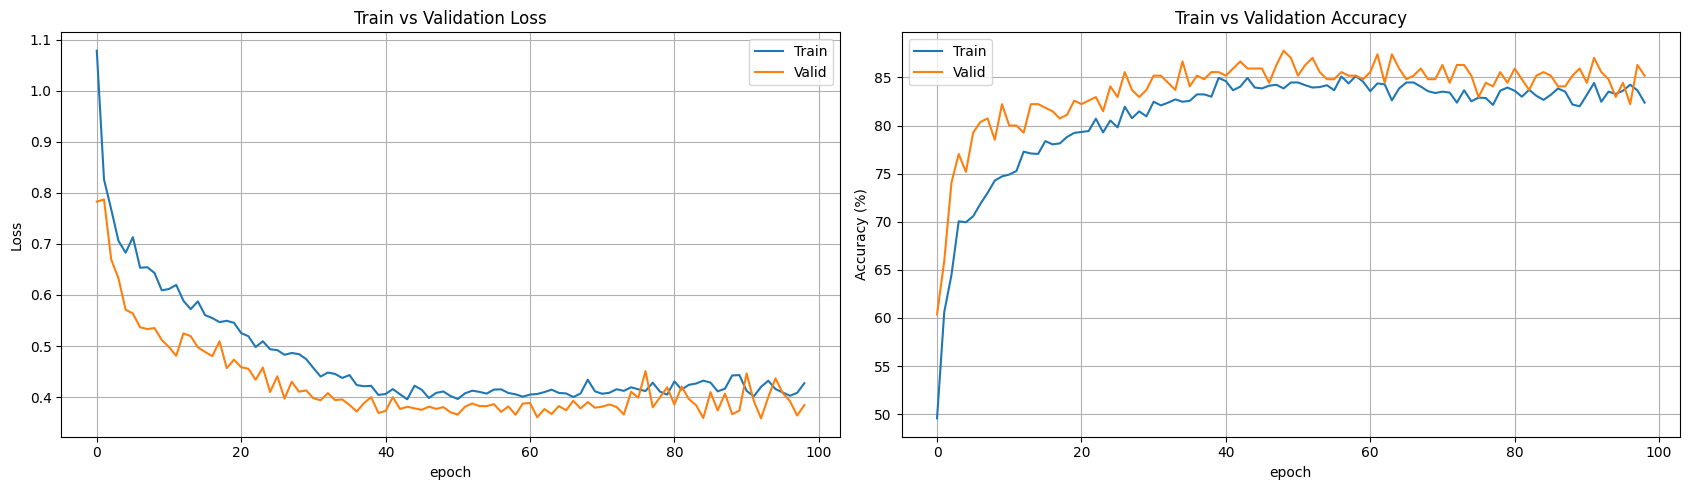

In [ ]:

run_name = f"best_model"
print(f"\nTraining {run_name}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedCNN(dropout_rate=0.35).to(device)
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizers = {
    "Adam": torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0),
    "SGD": torch.optim.SGD(model.parameters(), lr=5e-4, momentum=0.9)
}
optimizer = optimizers["Adam"]
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

train_acc_history = []
train_loss_history = []
valid_acc_history = []
valid_loss_history = []

best_model_wts = copy.deepcopy(model.state_dict())
best_valid_acc = 0.0
best_model_path = f"../models/best_model/{run_name}.pt"
patience = 50
early_stop_counter = 0

start = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_labels = []
    all_preds = []

    train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, (images, labels) in train_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        train_loss_avg = running_loss / (i + 1)
        train_accuracy = 100 * correct_train / total_train
        train_bar.set_postfix({'loss': f'{train_loss_avg:.3f}', 'acc': f'{train_accuracy:.2f}%'})

    train_f1 = f1_score(all_labels, all_preds, average='macro')
    train_precision = precision_score(all_labels, all_preds, average='macro')
    train_recall = recall_score(all_labels, all_preds, average='macro')
    train_loss_avg = running_loss / len(train_loader)
    train_loss_history.append(train_loss_avg)
    train_acc_history.append(train_accuracy)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss_avg:.3f}, Train Acc: {train_accuracy:.2f}%, '
        f'Train F1: {train_f1:.3f}, Train Precision: {train_precision:.3f}, Train Recall: {train_recall:.3f}')
    
    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        valid_bar = tqdm(valid_loader, total=len(valid_loader), desc="Validation")
        for images, labels in valid_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            valid_loss_avg = valid_loss / len(valid_loader)
            valid_accuracy = 100 * correct_valid / total_valid
            valid_bar.set_postfix({'loss': f'{valid_loss_avg:.3f}', 'acc': f'{valid_accuracy:.2f}%'})

    valid_f1 = f1_score(all_labels, all_preds, average='macro')
    valid_precision = precision_score(all_labels, all_preds, average='macro',zero_division=1)
    valid_recall = recall_score(all_labels, all_preds, average='macro',zero_division=1)
    valid_loss_avg = valid_loss / len(valid_loader)
    valid_loss_history.append(valid_loss_avg)
    valid_acc_history.append(valid_accuracy)

    print(f'Epoch {epoch + 1}, Valid Loss: {valid_loss_avg:.3f}, Valid Acc: {valid_accuracy:.2f}%, '
        f'Valid F1: {valid_f1:.3f}, Valid Precision: {valid_precision:.3f}, Valid Recall: {valid_recall:.3f}')
    print("Validation Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

    if valid_accuracy > best_valid_acc:
        best_valid_acc = valid_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved: Valid Accuracy = {best_valid_acc:.2f}%")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"Early stop counter: {early_stop_counter}/{patience}")

    scheduler.step()
    print(f"Current learning rate: {scheduler.get_last_lr()[0]:.6f}")

    if early_stop_counter >= patience:
        print(f"Early stop triggered! No recovery during {patience} epoch.")
        break

results.append({**params, "run_name": run_name, "valid_acc": best_valid_acc})
time_elapsed = time.time() - start
print(f"Training finished after: {time_elapsed:.2f} seconds")

plt.figure(figsize=(17,5))
plt.subplot(121)
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Validation Loss')
plt.grid()

plt.subplot(122)
plt.plot(train_acc_history,)
plt.plot(valid_acc_history)
plt.xlabel('epoch')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Valid'])
plt.title('Train vs Validation Accuracy')
plt.grid()

plt.tight_layout()
plt.savefig(f"../images/{run_name}_training_results.png")
